In [1]:
from tensorflow_setup import *
import tensorflow as tf 
import os 
import matplotlib.pyplot as plt
#%matplotlib inline

# filenames used 
traindtfile = 'hdf_50.h5'
testdtfile = 'hdf_50.h5'
losssavefig = 'cnn_train_50_loss.png'
accsavefig = 'cnn_train_50_accuracy.png'
resultsave = 'cnn_train_50.h5'
chkpointdir = 'cnn-50/'

X_tr, X_vld, y_tr, y_vld, list_ch_train = get_tf_train_data(traindtfile)


batch_size = 600       # Batch size
seq_len = 12          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 3 # buy sell and nothing
n_channels = 6 # moving averages

graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

with graph.as_default():
    # (batch, 12, 3) --> (batch, 6, 6)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=6, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_1, (-1, 6*6))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    soft = tf.argmax(logits,1)
    pred = tf.nn.softmax(logits,1)
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


if (os.path.exists('bschkpnt-cnn') == False):
    !mkdir bschkpnt-cnn

validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()


with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1


    saver.save(sess,chkpointdir + "bs.ckpt")


t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+losssavefig)

# change filename here


# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+accsavefig)

del(X_tr, X_vld, y_tr, y_vld, list_ch_train)

X_test, y_test, lab_ch_test = get_tf_test_data(testdtfile)

test_acc = []
probs = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(chkpointdir))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
        prob = sess.run(pred, feed_dict=feed)
        probs.append(prob)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))


# now reshape the probs array
probs = np.array(probs)
probs = probs.reshape((probs.shape[0]*probs.shape[1]), probs.shape[2])
y_test = y_test[:len(probs),:]
# model complete

# save the results

import h5py
hf = h5py.File('h5files/' + resultsave, 'w')
hf.create_dataset('predict_valid', data=probs)
hf.create_dataset('y_test', data = y_test)
hf.close()

del(X_test, y_test, lab_ch_test)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Epoch: 0/1000 Iteration: 5 Train loss: 2.129321 Train acc: 0.308333
Epoch: 0/1000 Iteration: 10 Train loss: 2.157978 Train acc: 0.325000
Epoch: 0/1000 Iteration: 10 Validation loss: 1.753461 Validation acc: 0.326111
Epoch: 0/1000 Iteration: 15 Train loss: 2.079564 Train acc: 0.306667
Epoch: 0/1000 Iteration: 20 Train loss: 2.145004 Train acc: 0.283333
Epoch: 0/1000 Iteration: 20 Validation loss: 1.707003 Validation acc: 0.325741
Epoch: 0/1000 Iteration: 25 Train loss: 2.050171 Train acc: 0.310000
Epoch: 1/1000 Iteration: 30 Train loss: 1.942989 Train acc: 0.323333
Epoch: 1/1000 Iteration: 30 Validation loss: 1.662310 Validation acc: 0.325741
Epoch: 1/1000 Iteration: 35 Train loss: 1.940479 Train acc: 0.323333
Epoch: 1/1000 Iteration: 40 Train loss: 1.730930 Train acc: 0.383333
Epoch: 1/1000 Iterat

Epoch: 13/1000 Iteration: 380 Validation loss: 1.143667 Validation acc: 0.135185
Epoch: 13/1000 Iteration: 385 Train loss: 1.402882 Train acc: 0.333333
Epoch: 13/1000 Iteration: 390 Train loss: 1.433533 Train acc: 0.315000
Epoch: 13/1000 Iteration: 390 Validation loss: 1.140939 Validation acc: 0.121852
Epoch: 13/1000 Iteration: 395 Train loss: 1.423550 Train acc: 0.326667
Epoch: 13/1000 Iteration: 400 Train loss: 1.439223 Train acc: 0.335000
Epoch: 13/1000 Iteration: 400 Validation loss: 1.138481 Validation acc: 0.116667
Epoch: 13/1000 Iteration: 405 Train loss: 1.380519 Train acc: 0.353333
Epoch: 14/1000 Iteration: 410 Train loss: 1.389606 Train acc: 0.360000
Epoch: 14/1000 Iteration: 410 Validation loss: 1.136373 Validation acc: 0.119074
Epoch: 14/1000 Iteration: 415 Train loss: 1.402712 Train acc: 0.303333
Epoch: 14/1000 Iteration: 420 Train loss: 1.376636 Train acc: 0.351667
Epoch: 14/1000 Iteration: 420 Validation loss: 1.134183 Validation acc: 0.124630
Epoch: 14/1000 Iteration: 4

Epoch: 26/1000 Iteration: 760 Train loss: 1.233973 Train acc: 0.350000
Epoch: 26/1000 Iteration: 760 Validation loss: 1.103668 Validation acc: 0.374444
Epoch: 26/1000 Iteration: 765 Train loss: 1.271935 Train acc: 0.341667
Epoch: 26/1000 Iteration: 770 Train loss: 1.288631 Train acc: 0.325000
Epoch: 26/1000 Iteration: 770 Validation loss: 1.103429 Validation acc: 0.374259
Epoch: 26/1000 Iteration: 775 Train loss: 1.234244 Train acc: 0.358333
Epoch: 26/1000 Iteration: 780 Train loss: 1.287696 Train acc: 0.338333
Epoch: 26/1000 Iteration: 780 Validation loss: 1.103239 Validation acc: 0.372778
Epoch: 27/1000 Iteration: 785 Train loss: 1.283721 Train acc: 0.318333
Epoch: 27/1000 Iteration: 790 Train loss: 1.242200 Train acc: 0.326667
Epoch: 27/1000 Iteration: 790 Validation loss: 1.102780 Validation acc: 0.373889
Epoch: 27/1000 Iteration: 795 Train loss: 1.221150 Train acc: 0.336667
Epoch: 27/1000 Iteration: 800 Train loss: 1.233899 Train acc: 0.355000
Epoch: 27/1000 Iteration: 800 Validat

Epoch: 39/1000 Iteration: 1140 Validation loss: 1.085154 Validation acc: 0.428889
Epoch: 39/1000 Iteration: 1145 Train loss: 1.172117 Train acc: 0.361667
Epoch: 39/1000 Iteration: 1150 Train loss: 1.126441 Train acc: 0.400000
Epoch: 39/1000 Iteration: 1150 Validation loss: 1.084698 Validation acc: 0.429444
Epoch: 39/1000 Iteration: 1155 Train loss: 1.174511 Train acc: 0.355000
Epoch: 39/1000 Iteration: 1160 Train loss: 1.148747 Train acc: 0.383333
Epoch: 39/1000 Iteration: 1160 Validation loss: 1.084252 Validation acc: 0.429444
Epoch: 40/1000 Iteration: 1165 Train loss: 1.154593 Train acc: 0.371667
Epoch: 40/1000 Iteration: 1170 Train loss: 1.168881 Train acc: 0.353333
Epoch: 40/1000 Iteration: 1170 Validation loss: 1.083610 Validation acc: 0.430370
Epoch: 40/1000 Iteration: 1175 Train loss: 1.152526 Train acc: 0.365000
Epoch: 40/1000 Iteration: 1180 Train loss: 1.128820 Train acc: 0.381667
Epoch: 40/1000 Iteration: 1180 Validation loss: 1.083076 Validation acc: 0.431481
Epoch: 40/1000

Epoch: 52/1000 Iteration: 1520 Train loss: 1.106988 Train acc: 0.391667
Epoch: 52/1000 Iteration: 1520 Validation loss: 1.053630 Validation acc: 0.433333
Epoch: 52/1000 Iteration: 1525 Train loss: 1.124444 Train acc: 0.356667
Epoch: 52/1000 Iteration: 1530 Train loss: 1.098850 Train acc: 0.383333
Epoch: 52/1000 Iteration: 1530 Validation loss: 1.048595 Validation acc: 0.433518
Epoch: 52/1000 Iteration: 1535 Train loss: 1.071354 Train acc: 0.428333
Epoch: 53/1000 Iteration: 1540 Train loss: 1.091581 Train acc: 0.408333
Epoch: 53/1000 Iteration: 1540 Validation loss: 1.044123 Validation acc: 0.433518
Epoch: 53/1000 Iteration: 1545 Train loss: 1.090049 Train acc: 0.406667
Epoch: 53/1000 Iteration: 1550 Train loss: 1.069105 Train acc: 0.418333
Epoch: 53/1000 Iteration: 1550 Validation loss: 1.041007 Validation acc: 0.433889
Epoch: 53/1000 Iteration: 1555 Train loss: 1.074870 Train acc: 0.423333
Epoch: 53/1000 Iteration: 1560 Train loss: 1.075070 Train acc: 0.425000
Epoch: 53/1000 Iteration

Epoch: 65/1000 Iteration: 1890 Train loss: 1.040857 Train acc: 0.460000
Epoch: 65/1000 Iteration: 1890 Validation loss: 1.020718 Validation acc: 0.494815
Epoch: 65/1000 Iteration: 1895 Train loss: 1.053017 Train acc: 0.433333
Epoch: 65/1000 Iteration: 1900 Train loss: 1.045145 Train acc: 0.443333
Epoch: 65/1000 Iteration: 1900 Validation loss: 1.020219 Validation acc: 0.494630
Epoch: 65/1000 Iteration: 1905 Train loss: 1.022590 Train acc: 0.503333
Epoch: 65/1000 Iteration: 1910 Train loss: 1.042442 Train acc: 0.436667
Epoch: 65/1000 Iteration: 1910 Validation loss: 1.019863 Validation acc: 0.495370
Epoch: 66/1000 Iteration: 1915 Train loss: 1.018724 Train acc: 0.501667
Epoch: 66/1000 Iteration: 1920 Train loss: 1.022418 Train acc: 0.535000
Epoch: 66/1000 Iteration: 1920 Validation loss: 1.019501 Validation acc: 0.496296
Epoch: 66/1000 Iteration: 1925 Train loss: 1.052948 Train acc: 0.456667
Epoch: 66/1000 Iteration: 1930 Train loss: 1.015421 Train acc: 0.516667
Epoch: 66/1000 Iteration

Epoch: 77/1000 Iteration: 2260 Validation loss: 1.006590 Validation acc: 0.511296
Epoch: 78/1000 Iteration: 2265 Train loss: 1.032012 Train acc: 0.478333
Epoch: 78/1000 Iteration: 2270 Train loss: 1.015211 Train acc: 0.508333
Epoch: 78/1000 Iteration: 2270 Validation loss: 1.006129 Validation acc: 0.511482
Epoch: 78/1000 Iteration: 2275 Train loss: 1.021114 Train acc: 0.490000
Epoch: 78/1000 Iteration: 2280 Train loss: 1.028605 Train acc: 0.463333
Epoch: 78/1000 Iteration: 2280 Validation loss: 1.005894 Validation acc: 0.514630
Epoch: 78/1000 Iteration: 2285 Train loss: 1.028658 Train acc: 0.473333
Epoch: 78/1000 Iteration: 2290 Train loss: 1.004543 Train acc: 0.506667
Epoch: 78/1000 Iteration: 2290 Validation loss: 1.005702 Validation acc: 0.517778
Epoch: 79/1000 Iteration: 2295 Train loss: 1.004081 Train acc: 0.523333
Epoch: 79/1000 Iteration: 2300 Train loss: 1.031316 Train acc: 0.478333
Epoch: 79/1000 Iteration: 2300 Validation loss: 1.005348 Validation acc: 0.518519
Epoch: 79/1000

Epoch: 90/1000 Iteration: 2635 Train loss: 1.000475 Train acc: 0.523333
Epoch: 91/1000 Iteration: 2640 Train loss: 0.987698 Train acc: 0.566667
Epoch: 91/1000 Iteration: 2640 Validation loss: 0.992338 Validation acc: 0.535000
Epoch: 91/1000 Iteration: 2645 Train loss: 0.997190 Train acc: 0.551667
Epoch: 91/1000 Iteration: 2650 Train loss: 1.021715 Train acc: 0.486667
Epoch: 91/1000 Iteration: 2650 Validation loss: 0.991903 Validation acc: 0.534630
Epoch: 91/1000 Iteration: 2655 Train loss: 0.998147 Train acc: 0.545000
Epoch: 91/1000 Iteration: 2660 Train loss: 1.040351 Train acc: 0.486667
Epoch: 91/1000 Iteration: 2660 Validation loss: 0.991765 Validation acc: 0.537963
Epoch: 91/1000 Iteration: 2665 Train loss: 1.014109 Train acc: 0.498333
Epoch: 92/1000 Iteration: 2670 Train loss: 1.022103 Train acc: 0.498333
Epoch: 92/1000 Iteration: 2670 Validation loss: 0.991539 Validation acc: 0.539815
Epoch: 92/1000 Iteration: 2675 Train loss: 1.005593 Train acc: 0.550000
Epoch: 92/1000 Iteration

Epoch: 103/1000 Iteration: 3010 Train loss: 0.981410 Train acc: 0.550000
Epoch: 103/1000 Iteration: 3010 Validation loss: 0.977627 Validation acc: 0.560185
Epoch: 103/1000 Iteration: 3015 Train loss: 0.986544 Train acc: 0.550000
Epoch: 104/1000 Iteration: 3020 Train loss: 0.962911 Train acc: 0.576667
Epoch: 104/1000 Iteration: 3020 Validation loss: 0.977286 Validation acc: 0.562037
Epoch: 104/1000 Iteration: 3025 Train loss: 0.997690 Train acc: 0.533333
Epoch: 104/1000 Iteration: 3030 Train loss: 1.013980 Train acc: 0.510000
Epoch: 104/1000 Iteration: 3030 Validation loss: 0.976522 Validation acc: 0.558148
Epoch: 104/1000 Iteration: 3035 Train loss: 0.998475 Train acc: 0.528333
Epoch: 104/1000 Iteration: 3040 Train loss: 0.995612 Train acc: 0.528333
Epoch: 104/1000 Iteration: 3040 Validation loss: 0.976232 Validation acc: 0.559074
Epoch: 104/1000 Iteration: 3045 Train loss: 0.979199 Train acc: 0.541667
Epoch: 105/1000 Iteration: 3050 Train loss: 0.969827 Train acc: 0.536667
Epoch: 105/

Epoch: 116/1000 Iteration: 3370 Train loss: 0.974544 Train acc: 0.575000
Epoch: 116/1000 Iteration: 3370 Validation loss: 0.962029 Validation acc: 0.582037
Epoch: 116/1000 Iteration: 3375 Train loss: 0.984917 Train acc: 0.568333
Epoch: 116/1000 Iteration: 3380 Train loss: 0.961737 Train acc: 0.576667
Epoch: 116/1000 Iteration: 3380 Validation loss: 0.961579 Validation acc: 0.581852
Epoch: 116/1000 Iteration: 3385 Train loss: 1.023302 Train acc: 0.520000
Epoch: 116/1000 Iteration: 3390 Train loss: 0.970336 Train acc: 0.571667
Epoch: 116/1000 Iteration: 3390 Validation loss: 0.961417 Validation acc: 0.585741
Epoch: 117/1000 Iteration: 3395 Train loss: 0.999679 Train acc: 0.540000
Epoch: 117/1000 Iteration: 3400 Train loss: 0.977438 Train acc: 0.558333
Epoch: 117/1000 Iteration: 3400 Validation loss: 0.960872 Validation acc: 0.585000
Epoch: 117/1000 Iteration: 3405 Train loss: 0.999126 Train acc: 0.511667
Epoch: 117/1000 Iteration: 3410 Train loss: 0.964100 Train acc: 0.583333
Epoch: 117/

Epoch: 128/1000 Iteration: 3735 Train loss: 0.940082 Train acc: 0.595000
Epoch: 128/1000 Iteration: 3740 Train loss: 0.936172 Train acc: 0.586667
Epoch: 128/1000 Iteration: 3740 Validation loss: 0.945403 Validation acc: 0.603889
Epoch: 129/1000 Iteration: 3745 Train loss: 0.943371 Train acc: 0.598333
Epoch: 129/1000 Iteration: 3750 Train loss: 0.974329 Train acc: 0.558333
Epoch: 129/1000 Iteration: 3750 Validation loss: 0.944647 Validation acc: 0.600741
Epoch: 129/1000 Iteration: 3755 Train loss: 0.972508 Train acc: 0.560000
Epoch: 129/1000 Iteration: 3760 Train loss: 0.973762 Train acc: 0.545000
Epoch: 129/1000 Iteration: 3760 Validation loss: 0.944134 Validation acc: 0.603148
Epoch: 129/1000 Iteration: 3765 Train loss: 0.973366 Train acc: 0.570000
Epoch: 129/1000 Iteration: 3770 Train loss: 0.950958 Train acc: 0.585000
Epoch: 129/1000 Iteration: 3770 Validation loss: 0.943712 Validation acc: 0.604630
Epoch: 130/1000 Iteration: 3775 Train loss: 0.943637 Train acc: 0.586667
Epoch: 130/

Epoch: 141/1000 Iteration: 4110 Train loss: 0.976142 Train acc: 0.531667
Epoch: 141/1000 Iteration: 4110 Validation loss: 0.927699 Validation acc: 0.620370
Epoch: 141/1000 Iteration: 4115 Train loss: 0.944006 Train acc: 0.593333
Epoch: 142/1000 Iteration: 4120 Train loss: 0.963443 Train acc: 0.560000
Epoch: 142/1000 Iteration: 4120 Validation loss: 0.927253 Validation acc: 0.622593
Epoch: 142/1000 Iteration: 4125 Train loss: 0.957358 Train acc: 0.600000
Epoch: 142/1000 Iteration: 4130 Train loss: 0.966438 Train acc: 0.563333
Epoch: 142/1000 Iteration: 4130 Validation loss: 0.926608 Validation acc: 0.620741
Epoch: 142/1000 Iteration: 4135 Train loss: 0.935118 Train acc: 0.601667
Epoch: 142/1000 Iteration: 4140 Train loss: 0.953882 Train acc: 0.575000
Epoch: 142/1000 Iteration: 4140 Validation loss: 0.926305 Validation acc: 0.622778
Epoch: 142/1000 Iteration: 4145 Train loss: 0.927682 Train acc: 0.596667
Epoch: 143/1000 Iteration: 4150 Train loss: 0.966409 Train acc: 0.595000
Epoch: 143/

Epoch: 154/1000 Iteration: 4470 Train loss: 0.910006 Train acc: 0.586667
Epoch: 154/1000 Iteration: 4470 Validation loss: 0.911378 Validation acc: 0.630556
Epoch: 154/1000 Iteration: 4475 Train loss: 0.957071 Train acc: 0.580000
Epoch: 154/1000 Iteration: 4480 Train loss: 0.930411 Train acc: 0.591667
Epoch: 154/1000 Iteration: 4480 Validation loss: 0.910914 Validation acc: 0.628333
Epoch: 154/1000 Iteration: 4485 Train loss: 0.937180 Train acc: 0.601667
Epoch: 154/1000 Iteration: 4490 Train loss: 0.941114 Train acc: 0.600000
Epoch: 154/1000 Iteration: 4490 Validation loss: 0.910592 Validation acc: 0.630000
Epoch: 154/1000 Iteration: 4495 Train loss: 0.924787 Train acc: 0.596667
Epoch: 155/1000 Iteration: 4500 Train loss: 0.903115 Train acc: 0.615000
Epoch: 155/1000 Iteration: 4500 Validation loss: 0.909994 Validation acc: 0.629630
Epoch: 155/1000 Iteration: 4505 Train loss: 0.924463 Train acc: 0.601667
Epoch: 155/1000 Iteration: 4510 Train loss: 0.964179 Train acc: 0.556667
Epoch: 155/

Epoch: 166/1000 Iteration: 4830 Train loss: 0.883020 Train acc: 0.630000
Epoch: 166/1000 Iteration: 4830 Validation loss: 0.894964 Validation acc: 0.637593
Epoch: 166/1000 Iteration: 4835 Train loss: 0.954398 Train acc: 0.558333
Epoch: 166/1000 Iteration: 4840 Train loss: 0.933166 Train acc: 0.610000
Epoch: 166/1000 Iteration: 4840 Validation loss: 0.894695 Validation acc: 0.639630
Epoch: 167/1000 Iteration: 4845 Train loss: 0.962183 Train acc: 0.586667
Epoch: 167/1000 Iteration: 4850 Train loss: 0.927559 Train acc: 0.593333
Epoch: 167/1000 Iteration: 4850 Validation loss: 0.894467 Validation acc: 0.639259
Epoch: 167/1000 Iteration: 4855 Train loss: 0.942876 Train acc: 0.576667
Epoch: 167/1000 Iteration: 4860 Train loss: 0.915106 Train acc: 0.618333
Epoch: 167/1000 Iteration: 4860 Validation loss: 0.894092 Validation acc: 0.640556
Epoch: 167/1000 Iteration: 4865 Train loss: 0.911442 Train acc: 0.596667
Epoch: 167/1000 Iteration: 4870 Train loss: 0.893812 Train acc: 0.618333
Epoch: 167/

Epoch: 178/1000 Iteration: 5190 Train loss: 0.890987 Train acc: 0.640000
Epoch: 178/1000 Iteration: 5190 Validation loss: 0.880308 Validation acc: 0.649259
Epoch: 179/1000 Iteration: 5195 Train loss: 0.887515 Train acc: 0.621667
Epoch: 179/1000 Iteration: 5200 Train loss: 0.909943 Train acc: 0.608333
Epoch: 179/1000 Iteration: 5200 Validation loss: 0.879703 Validation acc: 0.645370
Epoch: 179/1000 Iteration: 5205 Train loss: 0.903763 Train acc: 0.606667
Epoch: 179/1000 Iteration: 5210 Train loss: 0.899313 Train acc: 0.611667
Epoch: 179/1000 Iteration: 5210 Validation loss: 0.879298 Validation acc: 0.645370
Epoch: 179/1000 Iteration: 5215 Train loss: 0.916905 Train acc: 0.610000
Epoch: 179/1000 Iteration: 5220 Train loss: 0.887750 Train acc: 0.631667
Epoch: 179/1000 Iteration: 5220 Validation loss: 0.878887 Validation acc: 0.646111
Epoch: 180/1000 Iteration: 5225 Train loss: 0.887136 Train acc: 0.616667
Epoch: 180/1000 Iteration: 5230 Train loss: 0.886837 Train acc: 0.611667
Epoch: 180/

Epoch: 191/1000 Iteration: 5550 Train loss: 0.893645 Train acc: 0.633333
Epoch: 191/1000 Iteration: 5550 Validation loss: 0.866256 Validation acc: 0.651111
Epoch: 191/1000 Iteration: 5555 Train loss: 0.856658 Train acc: 0.641667
Epoch: 191/1000 Iteration: 5560 Train loss: 0.924576 Train acc: 0.583333
Epoch: 191/1000 Iteration: 5560 Validation loss: 0.865991 Validation acc: 0.652222
Epoch: 191/1000 Iteration: 5565 Train loss: 0.893120 Train acc: 0.623333
Epoch: 192/1000 Iteration: 5570 Train loss: 0.920166 Train acc: 0.616667
Epoch: 192/1000 Iteration: 5570 Validation loss: 0.865338 Validation acc: 0.651481
Epoch: 192/1000 Iteration: 5575 Train loss: 0.908400 Train acc: 0.608333
Epoch: 192/1000 Iteration: 5580 Train loss: 0.920559 Train acc: 0.596667
Epoch: 192/1000 Iteration: 5580 Validation loss: 0.864667 Validation acc: 0.648333
Epoch: 192/1000 Iteration: 5585 Train loss: 0.874227 Train acc: 0.636667
Epoch: 192/1000 Iteration: 5590 Train loss: 0.901182 Train acc: 0.600000
Epoch: 192/

Epoch: 203/1000 Iteration: 5910 Train loss: 0.868180 Train acc: 0.641667
Epoch: 203/1000 Iteration: 5910 Validation loss: 0.852196 Validation acc: 0.654074
Epoch: 203/1000 Iteration: 5915 Train loss: 0.864116 Train acc: 0.641667
Epoch: 204/1000 Iteration: 5920 Train loss: 0.878732 Train acc: 0.625000
Epoch: 204/1000 Iteration: 5920 Validation loss: 0.851687 Validation acc: 0.654630
Epoch: 204/1000 Iteration: 5925 Train loss: 0.893593 Train acc: 0.605000
Epoch: 204/1000 Iteration: 5930 Train loss: 0.893380 Train acc: 0.608333
Epoch: 204/1000 Iteration: 5930 Validation loss: 0.851264 Validation acc: 0.654444
Epoch: 204/1000 Iteration: 5935 Train loss: 0.886976 Train acc: 0.610000
Epoch: 204/1000 Iteration: 5940 Train loss: 0.879989 Train acc: 0.633333
Epoch: 204/1000 Iteration: 5940 Validation loss: 0.851299 Validation acc: 0.655000
Epoch: 204/1000 Iteration: 5945 Train loss: 0.860320 Train acc: 0.626667
Epoch: 205/1000 Iteration: 5950 Train loss: 0.851587 Train acc: 0.626667
Epoch: 205/

Epoch: 216/1000 Iteration: 6270 Train loss: 0.859315 Train acc: 0.636667
Epoch: 216/1000 Iteration: 6270 Validation loss: 0.840045 Validation acc: 0.656482
Epoch: 216/1000 Iteration: 6275 Train loss: 0.862973 Train acc: 0.641667
Epoch: 216/1000 Iteration: 6280 Train loss: 0.837591 Train acc: 0.650000
Epoch: 216/1000 Iteration: 6280 Validation loss: 0.839619 Validation acc: 0.656481
Epoch: 216/1000 Iteration: 6285 Train loss: 0.901131 Train acc: 0.590000
Epoch: 216/1000 Iteration: 6290 Train loss: 0.852941 Train acc: 0.648333
Epoch: 216/1000 Iteration: 6290 Validation loss: 0.839376 Validation acc: 0.657963
Epoch: 217/1000 Iteration: 6295 Train loss: 0.897878 Train acc: 0.631667
Epoch: 217/1000 Iteration: 6300 Train loss: 0.889086 Train acc: 0.631667
Epoch: 217/1000 Iteration: 6300 Validation loss: 0.839026 Validation acc: 0.657593
Epoch: 217/1000 Iteration: 6305 Train loss: 0.896197 Train acc: 0.596667
Epoch: 217/1000 Iteration: 6310 Train loss: 0.862181 Train acc: 0.650000
Epoch: 217/

Epoch: 228/1000 Iteration: 6630 Train loss: 0.874121 Train acc: 0.626667
Epoch: 228/1000 Iteration: 6630 Validation loss: 0.828366 Validation acc: 0.659259
Epoch: 228/1000 Iteration: 6635 Train loss: 0.824393 Train acc: 0.670000
Epoch: 228/1000 Iteration: 6640 Train loss: 0.839236 Train acc: 0.656667
Epoch: 228/1000 Iteration: 6640 Validation loss: 0.828244 Validation acc: 0.660926
Epoch: 229/1000 Iteration: 6645 Train loss: 0.847526 Train acc: 0.641667
Epoch: 229/1000 Iteration: 6650 Train loss: 0.871328 Train acc: 0.626667
Epoch: 229/1000 Iteration: 6650 Validation loss: 0.827871 Validation acc: 0.660556
Epoch: 229/1000 Iteration: 6655 Train loss: 0.872086 Train acc: 0.621667
Epoch: 229/1000 Iteration: 6660 Train loss: 0.855257 Train acc: 0.623333
Epoch: 229/1000 Iteration: 6660 Validation loss: 0.827665 Validation acc: 0.660556
Epoch: 229/1000 Iteration: 6665 Train loss: 0.873778 Train acc: 0.605000
Epoch: 229/1000 Iteration: 6670 Train loss: 0.837533 Train acc: 0.641667
Epoch: 229/

Epoch: 241/1000 Iteration: 6990 Train loss: 0.844549 Train acc: 0.648333
Epoch: 241/1000 Iteration: 6990 Validation loss: 0.817822 Validation acc: 0.663704
Epoch: 241/1000 Iteration: 6995 Train loss: 0.839254 Train acc: 0.650000
Epoch: 241/1000 Iteration: 7000 Train loss: 0.839511 Train acc: 0.641667
Epoch: 241/1000 Iteration: 7000 Validation loss: 0.817191 Validation acc: 0.662222
Epoch: 241/1000 Iteration: 7005 Train loss: 0.810987 Train acc: 0.675000
Epoch: 241/1000 Iteration: 7010 Train loss: 0.873987 Train acc: 0.613333
Epoch: 241/1000 Iteration: 7010 Validation loss: 0.817043 Validation acc: 0.662778
Epoch: 241/1000 Iteration: 7015 Train loss: 0.844878 Train acc: 0.648333
Epoch: 242/1000 Iteration: 7020 Train loss: 0.883474 Train acc: 0.635000
Epoch: 242/1000 Iteration: 7020 Validation loss: 0.816746 Validation acc: 0.664074
Epoch: 242/1000 Iteration: 7025 Train loss: 0.863094 Train acc: 0.643333
Epoch: 242/1000 Iteration: 7030 Train loss: 0.884124 Train acc: 0.601667
Epoch: 242/

Epoch: 253/1000 Iteration: 7350 Train loss: 0.815856 Train acc: 0.646667
Epoch: 253/1000 Iteration: 7350 Validation loss: 0.806858 Validation acc: 0.665926
Epoch: 253/1000 Iteration: 7355 Train loss: 0.835969 Train acc: 0.640000
Epoch: 253/1000 Iteration: 7360 Train loss: 0.820449 Train acc: 0.638333
Epoch: 253/1000 Iteration: 7360 Validation loss: 0.806666 Validation acc: 0.668148
Epoch: 253/1000 Iteration: 7365 Train loss: 0.818553 Train acc: 0.661667
Epoch: 254/1000 Iteration: 7370 Train loss: 0.843048 Train acc: 0.641667
Epoch: 254/1000 Iteration: 7370 Validation loss: 0.806672 Validation acc: 0.668889
Epoch: 254/1000 Iteration: 7375 Train loss: 0.857842 Train acc: 0.611667
Epoch: 254/1000 Iteration: 7380 Train loss: 0.855519 Train acc: 0.636667
Epoch: 254/1000 Iteration: 7380 Validation loss: 0.806495 Validation acc: 0.666667
Epoch: 254/1000 Iteration: 7385 Train loss: 0.839734 Train acc: 0.626667
Epoch: 254/1000 Iteration: 7390 Train loss: 0.837206 Train acc: 0.631667
Epoch: 254/

Epoch: 265/1000 Iteration: 7710 Train loss: 0.817301 Train acc: 0.650000
Epoch: 265/1000 Iteration: 7710 Validation loss: 0.796619 Validation acc: 0.671296
Epoch: 266/1000 Iteration: 7715 Train loss: 0.809911 Train acc: 0.663333
Epoch: 266/1000 Iteration: 7720 Train loss: 0.842968 Train acc: 0.643333
Epoch: 266/1000 Iteration: 7720 Validation loss: 0.796378 Validation acc: 0.671667
Epoch: 266/1000 Iteration: 7725 Train loss: 0.826336 Train acc: 0.653333
Epoch: 266/1000 Iteration: 7730 Train loss: 0.806012 Train acc: 0.668333
Epoch: 266/1000 Iteration: 7730 Validation loss: 0.795975 Validation acc: 0.669630
Epoch: 266/1000 Iteration: 7735 Train loss: 0.869702 Train acc: 0.608333
Epoch: 266/1000 Iteration: 7740 Train loss: 0.823925 Train acc: 0.650000
Epoch: 266/1000 Iteration: 7740 Validation loss: 0.795776 Validation acc: 0.671852
Epoch: 267/1000 Iteration: 7745 Train loss: 0.862597 Train acc: 0.626667
Epoch: 267/1000 Iteration: 7750 Train loss: 0.851994 Train acc: 0.645000
Epoch: 267/

Epoch: 278/1000 Iteration: 8070 Train loss: 0.815726 Train acc: 0.646667
Epoch: 278/1000 Iteration: 8070 Validation loss: 0.787464 Validation acc: 0.673704
Epoch: 278/1000 Iteration: 8075 Train loss: 0.789310 Train acc: 0.653333
Epoch: 278/1000 Iteration: 8080 Train loss: 0.817724 Train acc: 0.648333
Epoch: 278/1000 Iteration: 8080 Validation loss: 0.787227 Validation acc: 0.674259
Epoch: 278/1000 Iteration: 8085 Train loss: 0.813936 Train acc: 0.675000
Epoch: 278/1000 Iteration: 8090 Train loss: 0.801068 Train acc: 0.663333
Epoch: 278/1000 Iteration: 8090 Validation loss: 0.786948 Validation acc: 0.675185
Epoch: 279/1000 Iteration: 8095 Train loss: 0.806821 Train acc: 0.671667
Epoch: 279/1000 Iteration: 8100 Train loss: 0.830186 Train acc: 0.643333
Epoch: 279/1000 Iteration: 8100 Validation loss: 0.786735 Validation acc: 0.674630
Epoch: 279/1000 Iteration: 8105 Train loss: 0.829970 Train acc: 0.641667
Epoch: 279/1000 Iteration: 8110 Train loss: 0.829800 Train acc: 0.636667
Epoch: 279/

Epoch: 290/1000 Iteration: 8430 Train loss: 0.789551 Train acc: 0.656667
Epoch: 290/1000 Iteration: 8430 Validation loss: 0.778005 Validation acc: 0.677407
Epoch: 290/1000 Iteration: 8435 Train loss: 0.789556 Train acc: 0.648333
Epoch: 291/1000 Iteration: 8440 Train loss: 0.810116 Train acc: 0.671667
Epoch: 291/1000 Iteration: 8440 Validation loss: 0.777556 Validation acc: 0.677407
Epoch: 291/1000 Iteration: 8445 Train loss: 0.809237 Train acc: 0.658333
Epoch: 291/1000 Iteration: 8450 Train loss: 0.815082 Train acc: 0.665000
Epoch: 291/1000 Iteration: 8450 Validation loss: 0.777089 Validation acc: 0.676667
Epoch: 291/1000 Iteration: 8455 Train loss: 0.777117 Train acc: 0.690000
Epoch: 291/1000 Iteration: 8460 Train loss: 0.849991 Train acc: 0.621667
Epoch: 291/1000 Iteration: 8460 Validation loss: 0.776533 Validation acc: 0.676852
Epoch: 291/1000 Iteration: 8465 Train loss: 0.801544 Train acc: 0.675000
Epoch: 292/1000 Iteration: 8470 Train loss: 0.838615 Train acc: 0.645000
Epoch: 292/

Epoch: 303/1000 Iteration: 8790 Train loss: 0.812893 Train acc: 0.636667
Epoch: 303/1000 Iteration: 8790 Validation loss: 0.768124 Validation acc: 0.681296
Epoch: 303/1000 Iteration: 8795 Train loss: 0.809724 Train acc: 0.648333
Epoch: 303/1000 Iteration: 8800 Train loss: 0.787397 Train acc: 0.651667
Epoch: 303/1000 Iteration: 8800 Validation loss: 0.767836 Validation acc: 0.680556
Epoch: 303/1000 Iteration: 8805 Train loss: 0.806421 Train acc: 0.643333
Epoch: 303/1000 Iteration: 8810 Train loss: 0.791607 Train acc: 0.673333
Epoch: 303/1000 Iteration: 8810 Validation loss: 0.767680 Validation acc: 0.681111
Epoch: 303/1000 Iteration: 8815 Train loss: 0.799231 Train acc: 0.680000
Epoch: 304/1000 Iteration: 8820 Train loss: 0.801374 Train acc: 0.641667
Epoch: 304/1000 Iteration: 8820 Validation loss: 0.767681 Validation acc: 0.680926
Epoch: 304/1000 Iteration: 8825 Train loss: 0.822577 Train acc: 0.641667
Epoch: 304/1000 Iteration: 8830 Train loss: 0.810726 Train acc: 0.655000
Epoch: 304/

Epoch: 315/1000 Iteration: 9150 Train loss: 0.806297 Train acc: 0.646667
Epoch: 315/1000 Iteration: 9150 Validation loss: 0.759113 Validation acc: 0.682593
Epoch: 315/1000 Iteration: 9155 Train loss: 0.799919 Train acc: 0.668333
Epoch: 315/1000 Iteration: 9160 Train loss: 0.774693 Train acc: 0.660000
Epoch: 315/1000 Iteration: 9160 Validation loss: 0.759352 Validation acc: 0.683519
Epoch: 316/1000 Iteration: 9165 Train loss: 0.783954 Train acc: 0.676667
Epoch: 316/1000 Iteration: 9170 Train loss: 0.765369 Train acc: 0.653333
Epoch: 316/1000 Iteration: 9170 Validation loss: 0.758850 Validation acc: 0.683148
Epoch: 316/1000 Iteration: 9175 Train loss: 0.793512 Train acc: 0.668333
Epoch: 316/1000 Iteration: 9180 Train loss: 0.792696 Train acc: 0.671667
Epoch: 316/1000 Iteration: 9180 Validation loss: 0.758333 Validation acc: 0.681852
Epoch: 316/1000 Iteration: 9185 Train loss: 0.822606 Train acc: 0.623333
Epoch: 316/1000 Iteration: 9190 Train loss: 0.824121 Train acc: 0.646667
Epoch: 316/

Epoch: 327/1000 Iteration: 9510 Train loss: 0.751030 Train acc: 0.681667
Epoch: 327/1000 Iteration: 9510 Validation loss: 0.750629 Validation acc: 0.684444
Epoch: 328/1000 Iteration: 9515 Train loss: 0.803432 Train acc: 0.636667
Epoch: 328/1000 Iteration: 9520 Train loss: 0.792834 Train acc: 0.663333
Epoch: 328/1000 Iteration: 9520 Validation loss: 0.750185 Validation acc: 0.684815
Epoch: 328/1000 Iteration: 9525 Train loss: 0.745364 Train acc: 0.673333
Epoch: 328/1000 Iteration: 9530 Train loss: 0.789379 Train acc: 0.655000
Epoch: 328/1000 Iteration: 9530 Validation loss: 0.750152 Validation acc: 0.685000
Epoch: 328/1000 Iteration: 9535 Train loss: 0.770651 Train acc: 0.673333
Epoch: 328/1000 Iteration: 9540 Train loss: 0.764165 Train acc: 0.671667
Epoch: 328/1000 Iteration: 9540 Validation loss: 0.750383 Validation acc: 0.684630
Epoch: 329/1000 Iteration: 9545 Train loss: 0.788763 Train acc: 0.665000
Epoch: 329/1000 Iteration: 9550 Train loss: 0.816726 Train acc: 0.650000
Epoch: 329/

Epoch: 340/1000 Iteration: 9870 Train loss: 0.733414 Train acc: 0.686667
Epoch: 340/1000 Iteration: 9870 Validation loss: 0.741804 Validation acc: 0.685926
Epoch: 340/1000 Iteration: 9875 Train loss: 0.787316 Train acc: 0.648333
Epoch: 340/1000 Iteration: 9880 Train loss: 0.766590 Train acc: 0.676667
Epoch: 340/1000 Iteration: 9880 Validation loss: 0.741477 Validation acc: 0.686111
Epoch: 340/1000 Iteration: 9885 Train loss: 0.763801 Train acc: 0.666667
Epoch: 341/1000 Iteration: 9890 Train loss: 0.795681 Train acc: 0.681667
Epoch: 341/1000 Iteration: 9890 Validation loss: 0.741697 Validation acc: 0.685556
Epoch: 341/1000 Iteration: 9895 Train loss: 0.768692 Train acc: 0.680000
Epoch: 341/1000 Iteration: 9900 Train loss: 0.787085 Train acc: 0.668333
Epoch: 341/1000 Iteration: 9900 Validation loss: 0.741706 Validation acc: 0.686296
Epoch: 341/1000 Iteration: 9905 Train loss: 0.759721 Train acc: 0.680000
Epoch: 341/1000 Iteration: 9910 Train loss: 0.809366 Train acc: 0.635000
Epoch: 341/

Epoch: 352/1000 Iteration: 10230 Train loss: 0.779466 Train acc: 0.646667
Epoch: 352/1000 Iteration: 10230 Validation loss: 0.734117 Validation acc: 0.687593
Epoch: 352/1000 Iteration: 10235 Train loss: 0.748687 Train acc: 0.676667
Epoch: 353/1000 Iteration: 10240 Train loss: 0.765734 Train acc: 0.661667
Epoch: 353/1000 Iteration: 10240 Validation loss: 0.734225 Validation acc: 0.687222
Epoch: 353/1000 Iteration: 10245 Train loss: 0.773888 Train acc: 0.671667
Epoch: 353/1000 Iteration: 10250 Train loss: 0.746345 Train acc: 0.675000
Epoch: 353/1000 Iteration: 10250 Validation loss: 0.733937 Validation acc: 0.687222
Epoch: 353/1000 Iteration: 10255 Train loss: 0.767688 Train acc: 0.666667
Epoch: 353/1000 Iteration: 10260 Train loss: 0.732728 Train acc: 0.681667
Epoch: 353/1000 Iteration: 10260 Validation loss: 0.733377 Validation acc: 0.687963
Epoch: 353/1000 Iteration: 10265 Train loss: 0.754700 Train acc: 0.683333
Epoch: 354/1000 Iteration: 10270 Train loss: 0.764763 Train acc: 0.66500

Epoch: 365/1000 Iteration: 10590 Train loss: 0.735641 Train acc: 0.680000
Epoch: 365/1000 Iteration: 10590 Validation loss: 0.726295 Validation acc: 0.689630
Epoch: 365/1000 Iteration: 10595 Train loss: 0.737470 Train acc: 0.676667
Epoch: 365/1000 Iteration: 10600 Train loss: 0.762795 Train acc: 0.668333
Epoch: 365/1000 Iteration: 10600 Validation loss: 0.725863 Validation acc: 0.688889
Epoch: 365/1000 Iteration: 10605 Train loss: 0.755803 Train acc: 0.680000
Epoch: 365/1000 Iteration: 10610 Train loss: 0.765298 Train acc: 0.673333
Epoch: 365/1000 Iteration: 10610 Validation loss: 0.726118 Validation acc: 0.689815
Epoch: 366/1000 Iteration: 10615 Train loss: 0.748566 Train acc: 0.695000
Epoch: 366/1000 Iteration: 10620 Train loss: 0.760167 Train acc: 0.683333
Epoch: 366/1000 Iteration: 10620 Validation loss: 0.726178 Validation acc: 0.689630
Epoch: 366/1000 Iteration: 10625 Train loss: 0.759707 Train acc: 0.673333
Epoch: 366/1000 Iteration: 10630 Train loss: 0.758538 Train acc: 0.68500

Epoch: 377/1000 Iteration: 10950 Validation loss: 0.718678 Validation acc: 0.691111
Epoch: 377/1000 Iteration: 10955 Train loss: 0.744988 Train acc: 0.658333
Epoch: 377/1000 Iteration: 10960 Train loss: 0.746969 Train acc: 0.675000
Epoch: 377/1000 Iteration: 10960 Validation loss: 0.718528 Validation acc: 0.691667
Epoch: 378/1000 Iteration: 10965 Train loss: 0.772028 Train acc: 0.650000
Epoch: 378/1000 Iteration: 10970 Train loss: 0.746361 Train acc: 0.671667
Epoch: 378/1000 Iteration: 10970 Validation loss: 0.718746 Validation acc: 0.691111
Epoch: 378/1000 Iteration: 10975 Train loss: 0.727469 Train acc: 0.681667
Epoch: 378/1000 Iteration: 10980 Train loss: 0.763644 Train acc: 0.671667
Epoch: 378/1000 Iteration: 10980 Validation loss: 0.718492 Validation acc: 0.690370
Epoch: 378/1000 Iteration: 10985 Train loss: 0.735989 Train acc: 0.690000
Epoch: 378/1000 Iteration: 10990 Train loss: 0.746160 Train acc: 0.680000
Epoch: 378/1000 Iteration: 10990 Validation loss: 0.718497 Validation ac

Epoch: 389/1000 Iteration: 11310 Train loss: 0.734711 Train acc: 0.675000
Epoch: 389/1000 Iteration: 11310 Validation loss: 0.711261 Validation acc: 0.692037
Epoch: 390/1000 Iteration: 11315 Train loss: 0.706950 Train acc: 0.685000
Epoch: 390/1000 Iteration: 11320 Train loss: 0.725600 Train acc: 0.686667
Epoch: 390/1000 Iteration: 11320 Validation loss: 0.710997 Validation acc: 0.692778
Epoch: 390/1000 Iteration: 11325 Train loss: 0.749664 Train acc: 0.675000
Epoch: 390/1000 Iteration: 11330 Train loss: 0.753497 Train acc: 0.668333
Epoch: 390/1000 Iteration: 11330 Validation loss: 0.711028 Validation acc: 0.692778
Epoch: 390/1000 Iteration: 11335 Train loss: 0.771425 Train acc: 0.666667
Epoch: 391/1000 Iteration: 11340 Train loss: 0.729036 Train acc: 0.683333
Epoch: 391/1000 Iteration: 11340 Validation loss: 0.711235 Validation acc: 0.692407
Epoch: 391/1000 Iteration: 11345 Train loss: 0.773904 Train acc: 0.660000
Epoch: 391/1000 Iteration: 11350 Train loss: 0.744147 Train acc: 0.67333

Epoch: 402/1000 Iteration: 11670 Train loss: 0.782107 Train acc: 0.646667
Epoch: 402/1000 Iteration: 11670 Validation loss: 0.704159 Validation acc: 0.694630
Epoch: 402/1000 Iteration: 11675 Train loss: 0.719239 Train acc: 0.693333
Epoch: 402/1000 Iteration: 11680 Train loss: 0.770584 Train acc: 0.660000
Epoch: 402/1000 Iteration: 11680 Validation loss: 0.704299 Validation acc: 0.693148
Epoch: 402/1000 Iteration: 11685 Train loss: 0.721289 Train acc: 0.710000
Epoch: 403/1000 Iteration: 11690 Train loss: 0.752280 Train acc: 0.661667
Epoch: 403/1000 Iteration: 11690 Validation loss: 0.704473 Validation acc: 0.693148
Epoch: 403/1000 Iteration: 11695 Train loss: 0.726033 Train acc: 0.673333
Epoch: 403/1000 Iteration: 11700 Train loss: 0.701451 Train acc: 0.696667
Epoch: 403/1000 Iteration: 11700 Validation loss: 0.703667 Validation acc: 0.694630
Epoch: 403/1000 Iteration: 11705 Train loss: 0.760857 Train acc: 0.673333
Epoch: 403/1000 Iteration: 11710 Train loss: 0.711782 Train acc: 0.70500

Epoch: 414/1000 Iteration: 12030 Validation loss: 0.696517 Validation acc: 0.694630
Epoch: 414/1000 Iteration: 12035 Train loss: 0.702685 Train acc: 0.690000
Epoch: 415/1000 Iteration: 12040 Train loss: 0.715810 Train acc: 0.685000
Epoch: 415/1000 Iteration: 12040 Validation loss: 0.695769 Validation acc: 0.694444
Epoch: 415/1000 Iteration: 12045 Train loss: 0.704104 Train acc: 0.698333
Epoch: 415/1000 Iteration: 12050 Train loss: 0.743797 Train acc: 0.676667
Epoch: 415/1000 Iteration: 12050 Validation loss: 0.695076 Validation acc: 0.694815
Epoch: 415/1000 Iteration: 12055 Train loss: 0.717854 Train acc: 0.691667
Epoch: 415/1000 Iteration: 12060 Train loss: 0.738324 Train acc: 0.676667
Epoch: 415/1000 Iteration: 12060 Validation loss: 0.694540 Validation acc: 0.694444
Epoch: 416/1000 Iteration: 12065 Train loss: 0.718880 Train acc: 0.703333
Epoch: 416/1000 Iteration: 12070 Train loss: 0.737970 Train acc: 0.671667
Epoch: 416/1000 Iteration: 12070 Validation loss: 0.694466 Validation ac

Epoch: 427/1000 Iteration: 12390 Validation loss: 0.687276 Validation acc: 0.696481
Epoch: 427/1000 Iteration: 12395 Train loss: 0.754129 Train acc: 0.658333
Epoch: 427/1000 Iteration: 12400 Train loss: 0.702160 Train acc: 0.703333
Epoch: 427/1000 Iteration: 12400 Validation loss: 0.686993 Validation acc: 0.696296
Epoch: 427/1000 Iteration: 12405 Train loss: 0.731451 Train acc: 0.678333
Epoch: 427/1000 Iteration: 12410 Train loss: 0.724428 Train acc: 0.700000
Epoch: 427/1000 Iteration: 12410 Validation loss: 0.687367 Validation acc: 0.695370
Epoch: 428/1000 Iteration: 12415 Train loss: 0.736215 Train acc: 0.671667
Epoch: 428/1000 Iteration: 12420 Train loss: 0.696478 Train acc: 0.696667
Epoch: 428/1000 Iteration: 12420 Validation loss: 0.686776 Validation acc: 0.696481
Epoch: 428/1000 Iteration: 12425 Train loss: 0.703484 Train acc: 0.683333
Epoch: 428/1000 Iteration: 12430 Train loss: 0.730471 Train acc: 0.681667
Epoch: 428/1000 Iteration: 12430 Validation loss: 0.686222 Validation ac

Epoch: 439/1000 Iteration: 12750 Validation loss: 0.679056 Validation acc: 0.697963
Epoch: 439/1000 Iteration: 12755 Train loss: 0.750183 Train acc: 0.668333
Epoch: 439/1000 Iteration: 12760 Train loss: 0.705633 Train acc: 0.691667
Epoch: 439/1000 Iteration: 12760 Validation loss: 0.679504 Validation acc: 0.697222
Epoch: 440/1000 Iteration: 12765 Train loss: 0.698418 Train acc: 0.685000
Epoch: 440/1000 Iteration: 12770 Train loss: 0.685554 Train acc: 0.703333
Epoch: 440/1000 Iteration: 12770 Validation loss: 0.679246 Validation acc: 0.698333
Epoch: 440/1000 Iteration: 12775 Train loss: 0.719809 Train acc: 0.680000
Epoch: 440/1000 Iteration: 12780 Train loss: 0.708491 Train acc: 0.693333
Epoch: 440/1000 Iteration: 12780 Validation loss: 0.679215 Validation acc: 0.698333
Epoch: 440/1000 Iteration: 12785 Train loss: 0.726476 Train acc: 0.675000
Epoch: 441/1000 Iteration: 12790 Train loss: 0.711828 Train acc: 0.701667
Epoch: 441/1000 Iteration: 12790 Validation loss: 0.679137 Validation ac

Epoch: 452/1000 Iteration: 13110 Train loss: 0.755239 Train acc: 0.678333
Epoch: 452/1000 Iteration: 13110 Validation loss: 0.672832 Validation acc: 0.700185
Epoch: 452/1000 Iteration: 13115 Train loss: 0.737052 Train acc: 0.685000
Epoch: 452/1000 Iteration: 13120 Train loss: 0.730918 Train acc: 0.680000
Epoch: 452/1000 Iteration: 13120 Validation loss: 0.672359 Validation acc: 0.702222
Epoch: 452/1000 Iteration: 13125 Train loss: 0.685885 Train acc: 0.711667
Epoch: 452/1000 Iteration: 13130 Train loss: 0.718699 Train acc: 0.673333
Epoch: 452/1000 Iteration: 13130 Validation loss: 0.672076 Validation acc: 0.700741
Epoch: 452/1000 Iteration: 13135 Train loss: 0.685670 Train acc: 0.703333
Epoch: 453/1000 Iteration: 13140 Train loss: 0.701051 Train acc: 0.671667
Epoch: 453/1000 Iteration: 13140 Validation loss: 0.672256 Validation acc: 0.700741
Epoch: 453/1000 Iteration: 13145 Train loss: 0.692716 Train acc: 0.698333
Epoch: 453/1000 Iteration: 13150 Train loss: 0.679204 Train acc: 0.70833

Epoch: 465/1000 Iteration: 13495 Train loss: 0.680430 Train acc: 0.706667
Epoch: 465/1000 Iteration: 13500 Train loss: 0.708475 Train acc: 0.696667
Epoch: 465/1000 Iteration: 13500 Validation loss: 0.664969 Validation acc: 0.705556
Epoch: 465/1000 Iteration: 13505 Train loss: 0.694524 Train acc: 0.693333
Epoch: 465/1000 Iteration: 13510 Train loss: 0.696648 Train acc: 0.676667
Epoch: 465/1000 Iteration: 13510 Validation loss: 0.664338 Validation acc: 0.706481
Epoch: 466/1000 Iteration: 13515 Train loss: 0.691805 Train acc: 0.703333
Epoch: 466/1000 Iteration: 13520 Train loss: 0.707222 Train acc: 0.695000
Epoch: 466/1000 Iteration: 13520 Validation loss: 0.664065 Validation acc: 0.705185
Epoch: 466/1000 Iteration: 13525 Train loss: 0.701236 Train acc: 0.700000
Epoch: 466/1000 Iteration: 13530 Train loss: 0.666265 Train acc: 0.706667
Epoch: 466/1000 Iteration: 13530 Validation loss: 0.663730 Validation acc: 0.705556
Epoch: 466/1000 Iteration: 13535 Train loss: 0.750576 Train acc: 0.66000

Epoch: 477/1000 Iteration: 13850 Train loss: 0.679321 Train acc: 0.711667
Epoch: 477/1000 Iteration: 13850 Validation loss: 0.657854 Validation acc: 0.709074
Epoch: 477/1000 Iteration: 13855 Train loss: 0.705498 Train acc: 0.676667
Epoch: 477/1000 Iteration: 13860 Train loss: 0.686333 Train acc: 0.710000
Epoch: 477/1000 Iteration: 13860 Validation loss: 0.658342 Validation acc: 0.708519
Epoch: 478/1000 Iteration: 13865 Train loss: 0.701819 Train acc: 0.685000
Epoch: 478/1000 Iteration: 13870 Train loss: 0.676061 Train acc: 0.685000
Epoch: 478/1000 Iteration: 13870 Validation loss: 0.658127 Validation acc: 0.707407
Epoch: 478/1000 Iteration: 13875 Train loss: 0.666165 Train acc: 0.696667
Epoch: 478/1000 Iteration: 13880 Train loss: 0.705761 Train acc: 0.680000
Epoch: 478/1000 Iteration: 13880 Validation loss: 0.658111 Validation acc: 0.706667
Epoch: 478/1000 Iteration: 13885 Train loss: 0.678697 Train acc: 0.708333
Epoch: 478/1000 Iteration: 13890 Train loss: 0.725621 Train acc: 0.69666

Epoch: 489/1000 Iteration: 14210 Train loss: 0.666416 Train acc: 0.703333
Epoch: 489/1000 Iteration: 14210 Validation loss: 0.651294 Validation acc: 0.712222
Epoch: 490/1000 Iteration: 14215 Train loss: 0.664500 Train acc: 0.711667
Epoch: 490/1000 Iteration: 14220 Train loss: 0.659476 Train acc: 0.725000
Epoch: 490/1000 Iteration: 14220 Validation loss: 0.650915 Validation acc: 0.712222
Epoch: 490/1000 Iteration: 14225 Train loss: 0.687115 Train acc: 0.710000
Epoch: 490/1000 Iteration: 14230 Train loss: 0.678145 Train acc: 0.696667
Epoch: 490/1000 Iteration: 14230 Validation loss: 0.650890 Validation acc: 0.711852
Epoch: 490/1000 Iteration: 14235 Train loss: 0.697758 Train acc: 0.683333
Epoch: 491/1000 Iteration: 14240 Train loss: 0.685215 Train acc: 0.730000
Epoch: 491/1000 Iteration: 14240 Validation loss: 0.651264 Validation acc: 0.712593
Epoch: 491/1000 Iteration: 14245 Train loss: 0.683950 Train acc: 0.693333
Epoch: 491/1000 Iteration: 14250 Train loss: 0.671746 Train acc: 0.70500

Epoch: 502/1000 Iteration: 14570 Train loss: 0.708464 Train acc: 0.681667
Epoch: 502/1000 Iteration: 14570 Validation loss: 0.646488 Validation acc: 0.715370
Epoch: 502/1000 Iteration: 14575 Train loss: 0.673323 Train acc: 0.718333
Epoch: 502/1000 Iteration: 14580 Train loss: 0.691258 Train acc: 0.705000
Epoch: 502/1000 Iteration: 14580 Validation loss: 0.646018 Validation acc: 0.714630
Epoch: 502/1000 Iteration: 14585 Train loss: 0.680199 Train acc: 0.706667
Epoch: 503/1000 Iteration: 14590 Train loss: 0.696088 Train acc: 0.676667
Epoch: 503/1000 Iteration: 14590 Validation loss: 0.645754 Validation acc: 0.716111
Epoch: 503/1000 Iteration: 14595 Train loss: 0.673058 Train acc: 0.705000
Epoch: 503/1000 Iteration: 14600 Train loss: 0.652480 Train acc: 0.710000
Epoch: 503/1000 Iteration: 14600 Validation loss: 0.645634 Validation acc: 0.717037
Epoch: 503/1000 Iteration: 14605 Train loss: 0.692039 Train acc: 0.691667
Epoch: 503/1000 Iteration: 14610 Train loss: 0.668962 Train acc: 0.71666

Epoch: 514/1000 Iteration: 14930 Train loss: 0.712512 Train acc: 0.711667
Epoch: 514/1000 Iteration: 14930 Validation loss: 0.640929 Validation acc: 0.720185
Epoch: 514/1000 Iteration: 14935 Train loss: 0.665281 Train acc: 0.710000
Epoch: 515/1000 Iteration: 14940 Train loss: 0.664481 Train acc: 0.703333
Epoch: 515/1000 Iteration: 14940 Validation loss: 0.640567 Validation acc: 0.717778
Epoch: 515/1000 Iteration: 14945 Train loss: 0.646334 Train acc: 0.723333
Epoch: 515/1000 Iteration: 14950 Train loss: 0.672269 Train acc: 0.696667
Epoch: 515/1000 Iteration: 14950 Validation loss: 0.640047 Validation acc: 0.720000
Epoch: 515/1000 Iteration: 14955 Train loss: 0.658554 Train acc: 0.708333
Epoch: 515/1000 Iteration: 14960 Train loss: 0.686026 Train acc: 0.690000
Epoch: 515/1000 Iteration: 14960 Validation loss: 0.639393 Validation acc: 0.720000
Epoch: 516/1000 Iteration: 14965 Train loss: 0.679681 Train acc: 0.726667
Epoch: 516/1000 Iteration: 14970 Train loss: 0.662517 Train acc: 0.72500

Epoch: 527/1000 Iteration: 15300 Validation loss: 0.634753 Validation acc: 0.723889
Epoch: 527/1000 Iteration: 15305 Train loss: 0.697229 Train acc: 0.691667
Epoch: 527/1000 Iteration: 15310 Train loss: 0.684204 Train acc: 0.721667
Epoch: 527/1000 Iteration: 15310 Validation loss: 0.634693 Validation acc: 0.726481
Epoch: 528/1000 Iteration: 15315 Train loss: 0.673885 Train acc: 0.688333
Epoch: 528/1000 Iteration: 15320 Train loss: 0.648124 Train acc: 0.718333
Epoch: 528/1000 Iteration: 15320 Validation loss: 0.634620 Validation acc: 0.722963
Epoch: 528/1000 Iteration: 15325 Train loss: 0.630194 Train acc: 0.726667
Epoch: 528/1000 Iteration: 15330 Train loss: 0.710705 Train acc: 0.668333
Epoch: 528/1000 Iteration: 15330 Validation loss: 0.634556 Validation acc: 0.723148
Epoch: 528/1000 Iteration: 15335 Train loss: 0.677001 Train acc: 0.720000
Epoch: 528/1000 Iteration: 15340 Train loss: 0.679646 Train acc: 0.718333
Epoch: 528/1000 Iteration: 15340 Validation loss: 0.634969 Validation ac

Epoch: 540/1000 Iteration: 15675 Train loss: 0.673023 Train acc: 0.695000
Epoch: 540/1000 Iteration: 15680 Train loss: 0.659905 Train acc: 0.705000
Epoch: 540/1000 Iteration: 15680 Validation loss: 0.629270 Validation acc: 0.729630
Epoch: 540/1000 Iteration: 15685 Train loss: 0.677730 Train acc: 0.691667
Epoch: 541/1000 Iteration: 15690 Train loss: 0.663927 Train acc: 0.725000
Epoch: 541/1000 Iteration: 15690 Validation loss: 0.629527 Validation acc: 0.732037
Epoch: 541/1000 Iteration: 15695 Train loss: 0.668396 Train acc: 0.703333
Epoch: 541/1000 Iteration: 15700 Train loss: 0.666315 Train acc: 0.720000
Epoch: 541/1000 Iteration: 15700 Validation loss: 0.629420 Validation acc: 0.727037
Epoch: 541/1000 Iteration: 15705 Train loss: 0.627690 Train acc: 0.738333
Epoch: 541/1000 Iteration: 15710 Train loss: 0.719433 Train acc: 0.676667
Epoch: 541/1000 Iteration: 15710 Validation loss: 0.628799 Validation acc: 0.728704
Epoch: 541/1000 Iteration: 15715 Train loss: 0.694659 Train acc: 0.72000

Epoch: 552/1000 Iteration: 16030 Validation loss: 0.624321 Validation acc: 0.734259
Epoch: 552/1000 Iteration: 16035 Train loss: 0.669184 Train acc: 0.715000
Epoch: 553/1000 Iteration: 16040 Train loss: 0.659222 Train acc: 0.698333
Epoch: 553/1000 Iteration: 16040 Validation loss: 0.624543 Validation acc: 0.733518
Epoch: 553/1000 Iteration: 16045 Train loss: 0.645680 Train acc: 0.725000
Epoch: 553/1000 Iteration: 16050 Train loss: 0.630236 Train acc: 0.723333
Epoch: 553/1000 Iteration: 16050 Validation loss: 0.624455 Validation acc: 0.733518
Epoch: 553/1000 Iteration: 16055 Train loss: 0.685170 Train acc: 0.705000
Epoch: 553/1000 Iteration: 16060 Train loss: 0.630735 Train acc: 0.745000
Epoch: 553/1000 Iteration: 16060 Validation loss: 0.624325 Validation acc: 0.735185
Epoch: 553/1000 Iteration: 16065 Train loss: 0.666007 Train acc: 0.716667
Epoch: 554/1000 Iteration: 16070 Train loss: 0.657995 Train acc: 0.705000
Epoch: 554/1000 Iteration: 16070 Validation loss: 0.624374 Validation ac

Epoch: 565/1000 Iteration: 16410 Train loss: 0.658672 Train acc: 0.696667
Epoch: 565/1000 Iteration: 16410 Validation loss: 0.619624 Validation acc: 0.739074
Epoch: 566/1000 Iteration: 16415 Train loss: 0.652149 Train acc: 0.738333
Epoch: 566/1000 Iteration: 16420 Train loss: 0.657740 Train acc: 0.736667
Epoch: 566/1000 Iteration: 16420 Validation loss: 0.619428 Validation acc: 0.737407
Epoch: 566/1000 Iteration: 16425 Train loss: 0.665761 Train acc: 0.721667
Epoch: 566/1000 Iteration: 16430 Train loss: 0.626533 Train acc: 0.725000
Epoch: 566/1000 Iteration: 16430 Validation loss: 0.619414 Validation acc: 0.739259
Epoch: 566/1000 Iteration: 16435 Train loss: 0.701321 Train acc: 0.708333
Epoch: 566/1000 Iteration: 16440 Train loss: 0.672750 Train acc: 0.725000
Epoch: 566/1000 Iteration: 16440 Validation loss: 0.619533 Validation acc: 0.742407
Epoch: 567/1000 Iteration: 16445 Train loss: 0.703202 Train acc: 0.720000
Epoch: 567/1000 Iteration: 16450 Train loss: 0.694536 Train acc: 0.71333

Epoch: 578/1000 Iteration: 16770 Validation loss: 0.615968 Validation acc: 0.742222
Epoch: 578/1000 Iteration: 16775 Train loss: 0.617324 Train acc: 0.728333
Epoch: 578/1000 Iteration: 16780 Train loss: 0.663429 Train acc: 0.696667
Epoch: 578/1000 Iteration: 16780 Validation loss: 0.615844 Validation acc: 0.742407
Epoch: 578/1000 Iteration: 16785 Train loss: 0.637128 Train acc: 0.740000
Epoch: 578/1000 Iteration: 16790 Train loss: 0.680674 Train acc: 0.731667
Epoch: 578/1000 Iteration: 16790 Validation loss: 0.615476 Validation acc: 0.743889
Epoch: 579/1000 Iteration: 16795 Train loss: 0.650169 Train acc: 0.713333
Epoch: 579/1000 Iteration: 16800 Train loss: 0.652099 Train acc: 0.711667
Epoch: 579/1000 Iteration: 16800 Validation loss: 0.614904 Validation acc: 0.741111
Epoch: 579/1000 Iteration: 16805 Train loss: 0.652820 Train acc: 0.708333
Epoch: 579/1000 Iteration: 16810 Train loss: 0.636427 Train acc: 0.740000
Epoch: 579/1000 Iteration: 16810 Validation loss: 0.614132 Validation ac

Epoch: 590/1000 Iteration: 17130 Train loss: 0.652720 Train acc: 0.705000
Epoch: 590/1000 Iteration: 17130 Validation loss: 0.611497 Validation acc: 0.745370
Epoch: 590/1000 Iteration: 17135 Train loss: 0.672804 Train acc: 0.708333
Epoch: 591/1000 Iteration: 17140 Train loss: 0.630468 Train acc: 0.748333
Epoch: 591/1000 Iteration: 17140 Validation loss: 0.611761 Validation acc: 0.747037
Epoch: 591/1000 Iteration: 17145 Train loss: 0.631017 Train acc: 0.736667
Epoch: 591/1000 Iteration: 17150 Train loss: 0.640574 Train acc: 0.741667
Epoch: 591/1000 Iteration: 17150 Validation loss: 0.611074 Validation acc: 0.745185
Epoch: 591/1000 Iteration: 17155 Train loss: 0.626391 Train acc: 0.733333
Epoch: 591/1000 Iteration: 17160 Train loss: 0.684881 Train acc: 0.696667
Epoch: 591/1000 Iteration: 17160 Validation loss: 0.610414 Validation acc: 0.747037
Epoch: 591/1000 Iteration: 17165 Train loss: 0.695924 Train acc: 0.715000
Epoch: 592/1000 Iteration: 17170 Train loss: 0.685037 Train acc: 0.72166

Epoch: 603/1000 Iteration: 17495 Train loss: 0.630381 Train acc: 0.740000
Epoch: 603/1000 Iteration: 17500 Train loss: 0.592958 Train acc: 0.736667
Epoch: 603/1000 Iteration: 17500 Validation loss: 0.606497 Validation acc: 0.746111
Epoch: 603/1000 Iteration: 17505 Train loss: 0.656785 Train acc: 0.725000
Epoch: 603/1000 Iteration: 17510 Train loss: 0.633711 Train acc: 0.740000
Epoch: 603/1000 Iteration: 17510 Validation loss: 0.605966 Validation acc: 0.749815
Epoch: 603/1000 Iteration: 17515 Train loss: 0.665396 Train acc: 0.746667
Epoch: 604/1000 Iteration: 17520 Train loss: 0.640452 Train acc: 0.726667
Epoch: 604/1000 Iteration: 17520 Validation loss: 0.606413 Validation acc: 0.747037
Epoch: 604/1000 Iteration: 17525 Train loss: 0.644184 Train acc: 0.723333
Epoch: 604/1000 Iteration: 17530 Train loss: 0.645694 Train acc: 0.715000
Epoch: 604/1000 Iteration: 17530 Validation loss: 0.606259 Validation acc: 0.747407
Epoch: 604/1000 Iteration: 17535 Train loss: 0.624003 Train acc: 0.73000

Epoch: 615/1000 Iteration: 17860 Train loss: 0.659802 Train acc: 0.700000
Epoch: 615/1000 Iteration: 17860 Validation loss: 0.602808 Validation acc: 0.750000
Epoch: 616/1000 Iteration: 17865 Train loss: 0.640717 Train acc: 0.738333
Epoch: 616/1000 Iteration: 17870 Train loss: 0.642311 Train acc: 0.728333
Epoch: 616/1000 Iteration: 17870 Validation loss: 0.602425 Validation acc: 0.750926
Epoch: 616/1000 Iteration: 17875 Train loss: 0.667335 Train acc: 0.718333
Epoch: 616/1000 Iteration: 17880 Train loss: 0.605336 Train acc: 0.751667
Epoch: 616/1000 Iteration: 17880 Validation loss: 0.601864 Validation acc: 0.750370
Epoch: 616/1000 Iteration: 17885 Train loss: 0.676124 Train acc: 0.696667
Epoch: 616/1000 Iteration: 17890 Train loss: 0.673319 Train acc: 0.741667
Epoch: 616/1000 Iteration: 17890 Validation loss: 0.602343 Validation acc: 0.751481
Epoch: 617/1000 Iteration: 17895 Train loss: 0.696481 Train acc: 0.713333
Epoch: 617/1000 Iteration: 17900 Train loss: 0.673714 Train acc: 0.71333

Epoch: 628/1000 Iteration: 18230 Train loss: 0.670840 Train acc: 0.713333
Epoch: 628/1000 Iteration: 18230 Validation loss: 0.598820 Validation acc: 0.752407
Epoch: 628/1000 Iteration: 18235 Train loss: 0.615964 Train acc: 0.743333
Epoch: 628/1000 Iteration: 18240 Train loss: 0.633644 Train acc: 0.745000
Epoch: 628/1000 Iteration: 18240 Validation loss: 0.599157 Validation acc: 0.752037
Epoch: 629/1000 Iteration: 18245 Train loss: 0.616108 Train acc: 0.738333
Epoch: 629/1000 Iteration: 18250 Train loss: 0.648595 Train acc: 0.690000
Epoch: 629/1000 Iteration: 18250 Validation loss: 0.598551 Validation acc: 0.752778
Epoch: 629/1000 Iteration: 18255 Train loss: 0.641502 Train acc: 0.703333
Epoch: 629/1000 Iteration: 18260 Train loss: 0.613110 Train acc: 0.748333
Epoch: 629/1000 Iteration: 18260 Validation loss: 0.598150 Validation acc: 0.753148
Epoch: 629/1000 Iteration: 18265 Train loss: 0.686596 Train acc: 0.725000
Epoch: 629/1000 Iteration: 18270 Train loss: 0.637058 Train acc: 0.72333

Epoch: 641/1000 Iteration: 18595 Train loss: 0.618628 Train acc: 0.746667
Epoch: 641/1000 Iteration: 18600 Train loss: 0.642382 Train acc: 0.711667
Epoch: 641/1000 Iteration: 18600 Validation loss: 0.595805 Validation acc: 0.753704
Epoch: 641/1000 Iteration: 18605 Train loss: 0.608472 Train acc: 0.733333
Epoch: 641/1000 Iteration: 18610 Train loss: 0.658325 Train acc: 0.735000
Epoch: 641/1000 Iteration: 18610 Validation loss: 0.595253 Validation acc: 0.754259
Epoch: 641/1000 Iteration: 18615 Train loss: 0.625240 Train acc: 0.731667
Epoch: 642/1000 Iteration: 18620 Train loss: 0.660262 Train acc: 0.728333
Epoch: 642/1000 Iteration: 18620 Validation loss: 0.594980 Validation acc: 0.753704
Epoch: 642/1000 Iteration: 18625 Train loss: 0.656138 Train acc: 0.705000
Epoch: 642/1000 Iteration: 18630 Train loss: 0.672973 Train acc: 0.710000
Epoch: 642/1000 Iteration: 18630 Validation loss: 0.594256 Validation acc: 0.754259
Epoch: 642/1000 Iteration: 18635 Train loss: 0.631681 Train acc: 0.74833

Epoch: 653/1000 Iteration: 18960 Train loss: 0.619683 Train acc: 0.751667
Epoch: 653/1000 Iteration: 18960 Validation loss: 0.591973 Validation acc: 0.755370
Epoch: 653/1000 Iteration: 18965 Train loss: 0.641011 Train acc: 0.743333
Epoch: 654/1000 Iteration: 18970 Train loss: 0.625731 Train acc: 0.725000
Epoch: 654/1000 Iteration: 18970 Validation loss: 0.591855 Validation acc: 0.755556
Epoch: 654/1000 Iteration: 18975 Train loss: 0.609986 Train acc: 0.728333
Epoch: 654/1000 Iteration: 18980 Train loss: 0.637326 Train acc: 0.738333
Epoch: 654/1000 Iteration: 18980 Validation loss: 0.591687 Validation acc: 0.756481
Epoch: 654/1000 Iteration: 18985 Train loss: 0.632675 Train acc: 0.730000
Epoch: 654/1000 Iteration: 18990 Train loss: 0.684558 Train acc: 0.720000
Epoch: 654/1000 Iteration: 18990 Validation loss: 0.591724 Validation acc: 0.756852
Epoch: 654/1000 Iteration: 18995 Train loss: 0.628948 Train acc: 0.725000
Epoch: 655/1000 Iteration: 19000 Train loss: 0.623960 Train acc: 0.72333

Epoch: 666/1000 Iteration: 19335 Train loss: 0.654312 Train acc: 0.716667
Epoch: 666/1000 Iteration: 19340 Train loss: 0.651246 Train acc: 0.741667
Epoch: 666/1000 Iteration: 19340 Validation loss: 0.589611 Validation acc: 0.757778
Epoch: 667/1000 Iteration: 19345 Train loss: 0.675480 Train acc: 0.741667
Epoch: 667/1000 Iteration: 19350 Train loss: 0.672447 Train acc: 0.721667
Epoch: 667/1000 Iteration: 19350 Validation loss: 0.588703 Validation acc: 0.758148
Epoch: 667/1000 Iteration: 19355 Train loss: 0.650722 Train acc: 0.703333
Epoch: 667/1000 Iteration: 19360 Train loss: 0.605458 Train acc: 0.748333
Epoch: 667/1000 Iteration: 19360 Validation loss: 0.588260 Validation acc: 0.758333
Epoch: 667/1000 Iteration: 19365 Train loss: 0.627149 Train acc: 0.725000
Epoch: 667/1000 Iteration: 19370 Train loss: 0.611389 Train acc: 0.736667
Epoch: 667/1000 Iteration: 19370 Validation loss: 0.588536 Validation acc: 0.759259
Epoch: 668/1000 Iteration: 19375 Train loss: 0.631661 Train acc: 0.72000

Epoch: 678/1000 Iteration: 19690 Validation loss: 0.584869 Validation acc: 0.760185
Epoch: 679/1000 Iteration: 19695 Train loss: 0.613180 Train acc: 0.708333
Epoch: 679/1000 Iteration: 19700 Train loss: 0.612266 Train acc: 0.743333
Epoch: 679/1000 Iteration: 19700 Validation loss: 0.584771 Validation acc: 0.761481
Epoch: 679/1000 Iteration: 19705 Train loss: 0.627669 Train acc: 0.731667
Epoch: 679/1000 Iteration: 19710 Train loss: 0.608647 Train acc: 0.743333
Epoch: 679/1000 Iteration: 19710 Validation loss: 0.584707 Validation acc: 0.760556
Epoch: 679/1000 Iteration: 19715 Train loss: 0.683996 Train acc: 0.731667
Epoch: 679/1000 Iteration: 19720 Train loss: 0.622529 Train acc: 0.740000
Epoch: 679/1000 Iteration: 19720 Validation loss: 0.584848 Validation acc: 0.761111
Epoch: 680/1000 Iteration: 19725 Train loss: 0.590666 Train acc: 0.746667
Epoch: 680/1000 Iteration: 19730 Train loss: 0.588734 Train acc: 0.755000
Epoch: 680/1000 Iteration: 19730 Validation loss: 0.584800 Validation ac

Epoch: 691/1000 Iteration: 20065 Train loss: 0.638167 Train acc: 0.765000
Epoch: 692/1000 Iteration: 20070 Train loss: 0.657676 Train acc: 0.725000
Epoch: 692/1000 Iteration: 20070 Validation loss: 0.582464 Validation acc: 0.759630
Epoch: 692/1000 Iteration: 20075 Train loss: 0.652684 Train acc: 0.733333
Epoch: 692/1000 Iteration: 20080 Train loss: 0.657617 Train acc: 0.708333
Epoch: 692/1000 Iteration: 20080 Validation loss: 0.582282 Validation acc: 0.761852
Epoch: 692/1000 Iteration: 20085 Train loss: 0.628141 Train acc: 0.770000
Epoch: 692/1000 Iteration: 20090 Train loss: 0.624278 Train acc: 0.740000
Epoch: 692/1000 Iteration: 20090 Validation loss: 0.582200 Validation acc: 0.760370
Epoch: 692/1000 Iteration: 20095 Train loss: 0.648263 Train acc: 0.741667
Epoch: 693/1000 Iteration: 20100 Train loss: 0.630749 Train acc: 0.708333
Epoch: 693/1000 Iteration: 20100 Validation loss: 0.582193 Validation acc: 0.760370
Epoch: 693/1000 Iteration: 20105 Train loss: 0.595396 Train acc: 0.76166

Epoch: 704/1000 Iteration: 20420 Validation loss: 0.579633 Validation acc: 0.761111
Epoch: 704/1000 Iteration: 20425 Train loss: 0.603085 Train acc: 0.751667
Epoch: 704/1000 Iteration: 20430 Train loss: 0.624326 Train acc: 0.738333
Epoch: 704/1000 Iteration: 20430 Validation loss: 0.579317 Validation acc: 0.762778
Epoch: 704/1000 Iteration: 20435 Train loss: 0.597210 Train acc: 0.746667
Epoch: 704/1000 Iteration: 20440 Train loss: 0.661057 Train acc: 0.721667
Epoch: 704/1000 Iteration: 20440 Validation loss: 0.579681 Validation acc: 0.762963
Epoch: 704/1000 Iteration: 20445 Train loss: 0.591313 Train acc: 0.760000
Epoch: 705/1000 Iteration: 20450 Train loss: 0.596916 Train acc: 0.736667
Epoch: 705/1000 Iteration: 20450 Validation loss: 0.579598 Validation acc: 0.762222
Epoch: 705/1000 Iteration: 20455 Train loss: 0.583314 Train acc: 0.738333
Epoch: 705/1000 Iteration: 20460 Train loss: 0.602834 Train acc: 0.741667
Epoch: 705/1000 Iteration: 20460 Validation loss: 0.579578 Validation ac

Epoch: 717/1000 Iteration: 20800 Train loss: 0.664296 Train acc: 0.730000
Epoch: 717/1000 Iteration: 20800 Validation loss: 0.577016 Validation acc: 0.763889
Epoch: 717/1000 Iteration: 20805 Train loss: 0.673113 Train acc: 0.700000
Epoch: 717/1000 Iteration: 20810 Train loss: 0.580397 Train acc: 0.773333
Epoch: 717/1000 Iteration: 20810 Validation loss: 0.576788 Validation acc: 0.764259
Epoch: 717/1000 Iteration: 20815 Train loss: 0.621933 Train acc: 0.748333
Epoch: 717/1000 Iteration: 20820 Train loss: 0.630019 Train acc: 0.746667
Epoch: 717/1000 Iteration: 20820 Validation loss: 0.576645 Validation acc: 0.765000
Epoch: 718/1000 Iteration: 20825 Train loss: 0.630261 Train acc: 0.723333
Epoch: 718/1000 Iteration: 20830 Train loss: 0.601858 Train acc: 0.750000
Epoch: 718/1000 Iteration: 20830 Validation loss: 0.576711 Validation acc: 0.763889
Epoch: 718/1000 Iteration: 20835 Train loss: 0.570815 Train acc: 0.775000
Epoch: 718/1000 Iteration: 20840 Train loss: 0.624770 Train acc: 0.71166

Epoch: 730/1000 Iteration: 21185 Train loss: 0.586088 Train acc: 0.763333
Epoch: 730/1000 Iteration: 21190 Train loss: 0.617312 Train acc: 0.716667
Epoch: 730/1000 Iteration: 21190 Validation loss: 0.573472 Validation acc: 0.765185
Epoch: 730/1000 Iteration: 21195 Train loss: 0.629053 Train acc: 0.716667
Epoch: 731/1000 Iteration: 21200 Train loss: 0.599491 Train acc: 0.768333
Epoch: 731/1000 Iteration: 21200 Validation loss: 0.574304 Validation acc: 0.766482
Epoch: 731/1000 Iteration: 21205 Train loss: 0.607435 Train acc: 0.741667
Epoch: 731/1000 Iteration: 21210 Train loss: 0.623197 Train acc: 0.740000
Epoch: 731/1000 Iteration: 21210 Validation loss: 0.574171 Validation acc: 0.765370
Epoch: 731/1000 Iteration: 21215 Train loss: 0.560747 Train acc: 0.773333
Epoch: 731/1000 Iteration: 21220 Train loss: 0.655520 Train acc: 0.718333
Epoch: 731/1000 Iteration: 21220 Validation loss: 0.573983 Validation acc: 0.765185
Epoch: 731/1000 Iteration: 21225 Train loss: 0.625018 Train acc: 0.75500

Epoch: 742/1000 Iteration: 21545 Train loss: 0.624443 Train acc: 0.741667
Epoch: 743/1000 Iteration: 21550 Train loss: 0.611070 Train acc: 0.740000
Epoch: 743/1000 Iteration: 21550 Validation loss: 0.572631 Validation acc: 0.766482
Epoch: 743/1000 Iteration: 21555 Train loss: 0.580062 Train acc: 0.740000
Epoch: 743/1000 Iteration: 21560 Train loss: 0.553609 Train acc: 0.770000
Epoch: 743/1000 Iteration: 21560 Validation loss: 0.572058 Validation acc: 0.766296
Epoch: 743/1000 Iteration: 21565 Train loss: 0.613067 Train acc: 0.735000
Epoch: 743/1000 Iteration: 21570 Train loss: 0.611272 Train acc: 0.750000
Epoch: 743/1000 Iteration: 21570 Validation loss: 0.571446 Validation acc: 0.769074
Epoch: 743/1000 Iteration: 21575 Train loss: 0.611324 Train acc: 0.775000
Epoch: 744/1000 Iteration: 21580 Train loss: 0.598207 Train acc: 0.746667
Epoch: 744/1000 Iteration: 21580 Validation loss: 0.571396 Validation acc: 0.769630
Epoch: 744/1000 Iteration: 21585 Train loss: 0.613316 Train acc: 0.73666

Epoch: 755/1000 Iteration: 21905 Train loss: 0.567587 Train acc: 0.750000
Epoch: 755/1000 Iteration: 21910 Train loss: 0.598597 Train acc: 0.746667
Epoch: 755/1000 Iteration: 21910 Validation loss: 0.568698 Validation acc: 0.768333
Epoch: 755/1000 Iteration: 21915 Train loss: 0.592537 Train acc: 0.756667
Epoch: 755/1000 Iteration: 21920 Train loss: 0.626495 Train acc: 0.731667
Epoch: 755/1000 Iteration: 21920 Validation loss: 0.568835 Validation acc: 0.770185
Epoch: 756/1000 Iteration: 21925 Train loss: 0.592844 Train acc: 0.766667
Epoch: 756/1000 Iteration: 21930 Train loss: 0.595061 Train acc: 0.761667
Epoch: 756/1000 Iteration: 21930 Validation loss: 0.568546 Validation acc: 0.770000
Epoch: 756/1000 Iteration: 21935 Train loss: 0.595418 Train acc: 0.746667
Epoch: 756/1000 Iteration: 21940 Train loss: 0.580023 Train acc: 0.765000
Epoch: 756/1000 Iteration: 21940 Validation loss: 0.568536 Validation acc: 0.768889
Epoch: 756/1000 Iteration: 21945 Train loss: 0.656817 Train acc: 0.72000

Epoch: 767/1000 Iteration: 22260 Train loss: 0.609052 Train acc: 0.751667
Epoch: 767/1000 Iteration: 22260 Validation loss: 0.567779 Validation acc: 0.769630
Epoch: 767/1000 Iteration: 22265 Train loss: 0.600570 Train acc: 0.748333
Epoch: 767/1000 Iteration: 22270 Train loss: 0.634081 Train acc: 0.748333
Epoch: 767/1000 Iteration: 22270 Validation loss: 0.567841 Validation acc: 0.770556
Epoch: 768/1000 Iteration: 22275 Train loss: 0.622148 Train acc: 0.731667
Epoch: 768/1000 Iteration: 22280 Train loss: 0.581092 Train acc: 0.760000
Epoch: 768/1000 Iteration: 22280 Validation loss: 0.567061 Validation acc: 0.769815
Epoch: 768/1000 Iteration: 22285 Train loss: 0.560607 Train acc: 0.770000
Epoch: 768/1000 Iteration: 22290 Train loss: 0.606596 Train acc: 0.748333
Epoch: 768/1000 Iteration: 22290 Validation loss: 0.566672 Validation acc: 0.770370
Epoch: 768/1000 Iteration: 22295 Train loss: 0.571984 Train acc: 0.765000
Epoch: 768/1000 Iteration: 22300 Train loss: 0.630351 Train acc: 0.74666

Epoch: 780/1000 Iteration: 22635 Train loss: 0.590820 Train acc: 0.763333
Epoch: 780/1000 Iteration: 22640 Train loss: 0.604948 Train acc: 0.763333
Epoch: 780/1000 Iteration: 22640 Validation loss: 0.565591 Validation acc: 0.771111
Epoch: 780/1000 Iteration: 22645 Train loss: 0.633839 Train acc: 0.723333
Epoch: 781/1000 Iteration: 22650 Train loss: 0.590693 Train acc: 0.751667
Epoch: 781/1000 Iteration: 22650 Validation loss: 0.566438 Validation acc: 0.772037
Epoch: 781/1000 Iteration: 22655 Train loss: 0.591166 Train acc: 0.746667
Epoch: 781/1000 Iteration: 22660 Train loss: 0.581834 Train acc: 0.751667
Epoch: 781/1000 Iteration: 22660 Validation loss: 0.565730 Validation acc: 0.770926
Epoch: 781/1000 Iteration: 22665 Train loss: 0.601245 Train acc: 0.763333
Epoch: 781/1000 Iteration: 22670 Train loss: 0.641472 Train acc: 0.731667
Epoch: 781/1000 Iteration: 22670 Validation loss: 0.564826 Validation acc: 0.771296
Epoch: 781/1000 Iteration: 22675 Train loss: 0.627123 Train acc: 0.75500

Epoch: 793/1000 Iteration: 23000 Train loss: 0.612776 Train acc: 0.728333
Epoch: 793/1000 Iteration: 23000 Validation loss: 0.563182 Validation acc: 0.771481
Epoch: 793/1000 Iteration: 23005 Train loss: 0.574384 Train acc: 0.753333
Epoch: 793/1000 Iteration: 23010 Train loss: 0.563944 Train acc: 0.781667
Epoch: 793/1000 Iteration: 23010 Validation loss: 0.563041 Validation acc: 0.772222
Epoch: 793/1000 Iteration: 23015 Train loss: 0.608755 Train acc: 0.730000
Epoch: 793/1000 Iteration: 23020 Train loss: 0.586553 Train acc: 0.768333
Epoch: 793/1000 Iteration: 23020 Validation loss: 0.563296 Validation acc: 0.774074
Epoch: 793/1000 Iteration: 23025 Train loss: 0.609634 Train acc: 0.761667
Epoch: 794/1000 Iteration: 23030 Train loss: 0.581528 Train acc: 0.741667
Epoch: 794/1000 Iteration: 23030 Validation loss: 0.563267 Validation acc: 0.771667
Epoch: 794/1000 Iteration: 23035 Train loss: 0.590125 Train acc: 0.745000
Epoch: 794/1000 Iteration: 23040 Train loss: 0.563111 Train acc: 0.75833

Epoch: 805/1000 Iteration: 23350 Validation loss: 0.560360 Validation acc: 0.773148
Epoch: 805/1000 Iteration: 23355 Train loss: 0.592264 Train acc: 0.746667
Epoch: 805/1000 Iteration: 23360 Train loss: 0.583462 Train acc: 0.753333
Epoch: 805/1000 Iteration: 23360 Validation loss: 0.560573 Validation acc: 0.772778
Epoch: 805/1000 Iteration: 23365 Train loss: 0.593974 Train acc: 0.748333
Epoch: 805/1000 Iteration: 23370 Train loss: 0.601850 Train acc: 0.740000
Epoch: 805/1000 Iteration: 23370 Validation loss: 0.561673 Validation acc: 0.774074
Epoch: 806/1000 Iteration: 23375 Train loss: 0.599012 Train acc: 0.768333
Epoch: 806/1000 Iteration: 23380 Train loss: 0.574344 Train acc: 0.756667
Epoch: 806/1000 Iteration: 23380 Validation loss: 0.561376 Validation acc: 0.772593
Epoch: 806/1000 Iteration: 23385 Train loss: 0.584050 Train acc: 0.753333
Epoch: 806/1000 Iteration: 23390 Train loss: 0.557468 Train acc: 0.780000
Epoch: 806/1000 Iteration: 23390 Validation loss: 0.560751 Validation ac

Epoch: 817/1000 Iteration: 23705 Train loss: 0.656708 Train acc: 0.710000
Epoch: 817/1000 Iteration: 23710 Train loss: 0.597583 Train acc: 0.778333
Epoch: 817/1000 Iteration: 23710 Validation loss: 0.559067 Validation acc: 0.773519
Epoch: 817/1000 Iteration: 23715 Train loss: 0.617318 Train acc: 0.751667
Epoch: 817/1000 Iteration: 23720 Train loss: 0.619979 Train acc: 0.738333
Epoch: 817/1000 Iteration: 23720 Validation loss: 0.559663 Validation acc: 0.775926
Epoch: 818/1000 Iteration: 23725 Train loss: 0.590530 Train acc: 0.745000
Epoch: 818/1000 Iteration: 23730 Train loss: 0.583994 Train acc: 0.731667
Epoch: 818/1000 Iteration: 23730 Validation loss: 0.559438 Validation acc: 0.773704
Epoch: 818/1000 Iteration: 23735 Train loss: 0.568184 Train acc: 0.763333
Epoch: 818/1000 Iteration: 23740 Train loss: 0.614909 Train acc: 0.738333
Epoch: 818/1000 Iteration: 23740 Validation loss: 0.559053 Validation acc: 0.772222
Epoch: 818/1000 Iteration: 23745 Train loss: 0.569412 Train acc: 0.77333

Epoch: 830/1000 Iteration: 24075 Train loss: 0.573571 Train acc: 0.760000
Epoch: 830/1000 Iteration: 24080 Train loss: 0.555630 Train acc: 0.758333
Epoch: 830/1000 Iteration: 24080 Validation loss: 0.556895 Validation acc: 0.773889
Epoch: 830/1000 Iteration: 24085 Train loss: 0.597693 Train acc: 0.748333
Epoch: 830/1000 Iteration: 24090 Train loss: 0.600803 Train acc: 0.750000
Epoch: 830/1000 Iteration: 24090 Validation loss: 0.556670 Validation acc: 0.776667
Epoch: 830/1000 Iteration: 24095 Train loss: 0.621399 Train acc: 0.740000
Epoch: 831/1000 Iteration: 24100 Train loss: 0.578108 Train acc: 0.768333
Epoch: 831/1000 Iteration: 24100 Validation loss: 0.557275 Validation acc: 0.776481
Epoch: 831/1000 Iteration: 24105 Train loss: 0.594773 Train acc: 0.763333
Epoch: 831/1000 Iteration: 24110 Train loss: 0.584605 Train acc: 0.751667
Epoch: 831/1000 Iteration: 24110 Validation loss: 0.557300 Validation acc: 0.774074
Epoch: 831/1000 Iteration: 24115 Train loss: 0.586791 Train acc: 0.75666

Epoch: 842/1000 Iteration: 24430 Train loss: 0.633483 Train acc: 0.706667
Epoch: 842/1000 Iteration: 24430 Validation loss: 0.555530 Validation acc: 0.775370
Epoch: 842/1000 Iteration: 24435 Train loss: 0.584794 Train acc: 0.788333
Epoch: 842/1000 Iteration: 24440 Train loss: 0.598592 Train acc: 0.755000
Epoch: 842/1000 Iteration: 24440 Validation loss: 0.555463 Validation acc: 0.776296
Epoch: 842/1000 Iteration: 24445 Train loss: 0.660736 Train acc: 0.751667
Epoch: 843/1000 Iteration: 24450 Train loss: 0.605604 Train acc: 0.738333
Epoch: 843/1000 Iteration: 24450 Validation loss: 0.555788 Validation acc: 0.776481
Epoch: 843/1000 Iteration: 24455 Train loss: 0.551334 Train acc: 0.780000
Epoch: 843/1000 Iteration: 24460 Train loss: 0.547383 Train acc: 0.788333
Epoch: 843/1000 Iteration: 24460 Validation loss: 0.555286 Validation acc: 0.775741
Epoch: 843/1000 Iteration: 24465 Train loss: 0.599911 Train acc: 0.740000
Epoch: 843/1000 Iteration: 24470 Train loss: 0.585043 Train acc: 0.76666

Epoch: 855/1000 Iteration: 24800 Validation loss: 0.553424 Validation acc: 0.777222
Epoch: 855/1000 Iteration: 24805 Train loss: 0.551921 Train acc: 0.773333
Epoch: 855/1000 Iteration: 24810 Train loss: 0.588286 Train acc: 0.761667
Epoch: 855/1000 Iteration: 24810 Validation loss: 0.553104 Validation acc: 0.776852
Epoch: 855/1000 Iteration: 24815 Train loss: 0.604318 Train acc: 0.753333
Epoch: 855/1000 Iteration: 24820 Train loss: 0.623638 Train acc: 0.735000
Epoch: 855/1000 Iteration: 24820 Validation loss: 0.553391 Validation acc: 0.777593
Epoch: 856/1000 Iteration: 24825 Train loss: 0.560521 Train acc: 0.766667
Epoch: 856/1000 Iteration: 24830 Train loss: 0.589662 Train acc: 0.760000
Epoch: 856/1000 Iteration: 24830 Validation loss: 0.553216 Validation acc: 0.776481
Epoch: 856/1000 Iteration: 24835 Train loss: 0.584514 Train acc: 0.751667
Epoch: 856/1000 Iteration: 24840 Train loss: 0.560723 Train acc: 0.763333
Epoch: 856/1000 Iteration: 24840 Validation loss: 0.553143 Validation ac

Epoch: 867/1000 Iteration: 25165 Train loss: 0.598744 Train acc: 0.750000
Epoch: 867/1000 Iteration: 25170 Train loss: 0.613496 Train acc: 0.753333
Epoch: 867/1000 Iteration: 25170 Validation loss: 0.552941 Validation acc: 0.778148
Epoch: 868/1000 Iteration: 25175 Train loss: 0.586652 Train acc: 0.743333
Epoch: 868/1000 Iteration: 25180 Train loss: 0.562115 Train acc: 0.763333
Epoch: 868/1000 Iteration: 25180 Validation loss: 0.553373 Validation acc: 0.778148
Epoch: 868/1000 Iteration: 25185 Train loss: 0.538815 Train acc: 0.780000
Epoch: 868/1000 Iteration: 25190 Train loss: 0.598201 Train acc: 0.725000
Epoch: 868/1000 Iteration: 25190 Validation loss: 0.553479 Validation acc: 0.778148
Epoch: 868/1000 Iteration: 25195 Train loss: 0.574102 Train acc: 0.760000
Epoch: 868/1000 Iteration: 25200 Train loss: 0.593502 Train acc: 0.765000
Epoch: 868/1000 Iteration: 25200 Validation loss: 0.553699 Validation acc: 0.779074
Epoch: 869/1000 Iteration: 25205 Train loss: 0.581649 Train acc: 0.75666

Epoch: 879/1000 Iteration: 25520 Validation loss: 0.550539 Validation acc: 0.777963
Epoch: 880/1000 Iteration: 25525 Train loss: 0.578750 Train acc: 0.770000
Epoch: 880/1000 Iteration: 25530 Train loss: 0.541533 Train acc: 0.786667
Epoch: 880/1000 Iteration: 25530 Validation loss: 0.550448 Validation acc: 0.779444
Epoch: 880/1000 Iteration: 25535 Train loss: 0.564544 Train acc: 0.771667
Epoch: 880/1000 Iteration: 25540 Train loss: 0.593441 Train acc: 0.756667
Epoch: 880/1000 Iteration: 25540 Validation loss: 0.549975 Validation acc: 0.779630
Epoch: 880/1000 Iteration: 25545 Train loss: 0.603736 Train acc: 0.763333
Epoch: 881/1000 Iteration: 25550 Train loss: 0.567758 Train acc: 0.768333
Epoch: 881/1000 Iteration: 25550 Validation loss: 0.550495 Validation acc: 0.780000
Epoch: 881/1000 Iteration: 25555 Train loss: 0.589567 Train acc: 0.758333
Epoch: 881/1000 Iteration: 25560 Train loss: 0.577836 Train acc: 0.761667
Epoch: 881/1000 Iteration: 25560 Validation loss: 0.550376 Validation ac

Epoch: 892/1000 Iteration: 25890 Train loss: 0.585094 Train acc: 0.743333
Epoch: 892/1000 Iteration: 25890 Validation loss: 0.548616 Validation acc: 0.782407
Epoch: 892/1000 Iteration: 25895 Train loss: 0.636261 Train acc: 0.768333
Epoch: 893/1000 Iteration: 25900 Train loss: 0.580335 Train acc: 0.748333
Epoch: 893/1000 Iteration: 25900 Validation loss: 0.549262 Validation acc: 0.782037
Epoch: 893/1000 Iteration: 25905 Train loss: 0.535735 Train acc: 0.781667
Epoch: 893/1000 Iteration: 25910 Train loss: 0.530430 Train acc: 0.770000
Epoch: 893/1000 Iteration: 25910 Validation loss: 0.548496 Validation acc: 0.780556
Epoch: 893/1000 Iteration: 25915 Train loss: 0.591366 Train acc: 0.753333
Epoch: 893/1000 Iteration: 25920 Train loss: 0.561074 Train acc: 0.755000
Epoch: 893/1000 Iteration: 25920 Validation loss: 0.547930 Validation acc: 0.779444
Epoch: 893/1000 Iteration: 25925 Train loss: 0.592664 Train acc: 0.758333
Epoch: 894/1000 Iteration: 25930 Train loss: 0.560856 Train acc: 0.75166

Epoch: 905/1000 Iteration: 26270 Train loss: 0.618126 Train acc: 0.741667
Epoch: 905/1000 Iteration: 26270 Validation loss: 0.547254 Validation acc: 0.782963
Epoch: 906/1000 Iteration: 26275 Train loss: 0.555595 Train acc: 0.783333
Epoch: 906/1000 Iteration: 26280 Train loss: 0.582889 Train acc: 0.763333
Epoch: 906/1000 Iteration: 26280 Validation loss: 0.546549 Validation acc: 0.780926
Epoch: 906/1000 Iteration: 26285 Train loss: 0.575310 Train acc: 0.770000
Epoch: 906/1000 Iteration: 26290 Train loss: 0.547769 Train acc: 0.781667
Epoch: 906/1000 Iteration: 26290 Validation loss: 0.546777 Validation acc: 0.782037
Epoch: 906/1000 Iteration: 26295 Train loss: 0.609773 Train acc: 0.750000
Epoch: 906/1000 Iteration: 26300 Train loss: 0.614217 Train acc: 0.765000
Epoch: 906/1000 Iteration: 26300 Validation loss: 0.547636 Validation acc: 0.782037
Epoch: 907/1000 Iteration: 26305 Train loss: 0.613392 Train acc: 0.751667
Epoch: 907/1000 Iteration: 26310 Train loss: 0.618090 Train acc: 0.71000

Epoch: 918/1000 Iteration: 26645 Train loss: 0.590127 Train acc: 0.745000
Epoch: 918/1000 Iteration: 26650 Train loss: 0.581098 Train acc: 0.776667
Epoch: 918/1000 Iteration: 26650 Validation loss: 0.545769 Validation acc: 0.783519
Epoch: 919/1000 Iteration: 26655 Train loss: 0.576502 Train acc: 0.748333
Epoch: 919/1000 Iteration: 26660 Train loss: 0.554658 Train acc: 0.740000
Epoch: 919/1000 Iteration: 26660 Validation loss: 0.545465 Validation acc: 0.783704
Epoch: 919/1000 Iteration: 26665 Train loss: 0.585767 Train acc: 0.773333
Epoch: 919/1000 Iteration: 26670 Train loss: 0.579892 Train acc: 0.755000
Epoch: 919/1000 Iteration: 26670 Validation loss: 0.545408 Validation acc: 0.782222
Epoch: 919/1000 Iteration: 26675 Train loss: 0.648839 Train acc: 0.748333
Epoch: 919/1000 Iteration: 26680 Train loss: 0.563849 Train acc: 0.765000
Epoch: 919/1000 Iteration: 26680 Validation loss: 0.545641 Validation acc: 0.783519
Epoch: 920/1000 Iteration: 26685 Train loss: 0.562644 Train acc: 0.77000

Epoch: 931/1000 Iteration: 27000 Train loss: 0.590470 Train acc: 0.775000
Epoch: 931/1000 Iteration: 27000 Validation loss: 0.544591 Validation acc: 0.783889
Epoch: 931/1000 Iteration: 27005 Train loss: 0.578595 Train acc: 0.778333
Epoch: 931/1000 Iteration: 27010 Train loss: 0.575751 Train acc: 0.765000
Epoch: 931/1000 Iteration: 27010 Validation loss: 0.544554 Validation acc: 0.783148
Epoch: 931/1000 Iteration: 27015 Train loss: 0.549969 Train acc: 0.781667
Epoch: 931/1000 Iteration: 27020 Train loss: 0.616433 Train acc: 0.738333
Epoch: 931/1000 Iteration: 27020 Validation loss: 0.544374 Validation acc: 0.783704
Epoch: 931/1000 Iteration: 27025 Train loss: 0.623162 Train acc: 0.750000
Epoch: 932/1000 Iteration: 27030 Train loss: 0.628104 Train acc: 0.740000
Epoch: 932/1000 Iteration: 27030 Validation loss: 0.544799 Validation acc: 0.783889
Epoch: 932/1000 Iteration: 27035 Train loss: 0.632724 Train acc: 0.728333
Epoch: 932/1000 Iteration: 27040 Train loss: 0.614202 Train acc: 0.73333

Epoch: 944/1000 Iteration: 27380 Train loss: 0.565293 Train acc: 0.748333
Epoch: 944/1000 Iteration: 27380 Validation loss: 0.542898 Validation acc: 0.785000
Epoch: 944/1000 Iteration: 27385 Train loss: 0.568374 Train acc: 0.741667
Epoch: 944/1000 Iteration: 27390 Train loss: 0.602639 Train acc: 0.761667
Epoch: 944/1000 Iteration: 27390 Validation loss: 0.542566 Validation acc: 0.784444
Epoch: 944/1000 Iteration: 27395 Train loss: 0.555080 Train acc: 0.770000
Epoch: 944/1000 Iteration: 27400 Train loss: 0.650110 Train acc: 0.751667
Epoch: 944/1000 Iteration: 27400 Validation loss: 0.542883 Validation acc: 0.785370
Epoch: 944/1000 Iteration: 27405 Train loss: 0.539623 Train acc: 0.771667
Epoch: 945/1000 Iteration: 27410 Train loss: 0.549091 Train acc: 0.761667
Epoch: 945/1000 Iteration: 27410 Validation loss: 0.542590 Validation acc: 0.785000
Epoch: 945/1000 Iteration: 27415 Train loss: 0.521732 Train acc: 0.786667
Epoch: 945/1000 Iteration: 27420 Train loss: 0.570701 Train acc: 0.76000

Epoch: 957/1000 Iteration: 27755 Train loss: 0.646608 Train acc: 0.735000
Epoch: 957/1000 Iteration: 27760 Train loss: 0.622383 Train acc: 0.740000
Epoch: 957/1000 Iteration: 27760 Validation loss: 0.541037 Validation acc: 0.786296
Epoch: 957/1000 Iteration: 27765 Train loss: 0.607589 Train acc: 0.743333
Epoch: 957/1000 Iteration: 27770 Train loss: 0.570262 Train acc: 0.788333
Epoch: 957/1000 Iteration: 27770 Validation loss: 0.540556 Validation acc: 0.784444
Epoch: 957/1000 Iteration: 27775 Train loss: 0.579160 Train acc: 0.775000
Epoch: 957/1000 Iteration: 27780 Train loss: 0.607739 Train acc: 0.771667
Epoch: 957/1000 Iteration: 27780 Validation loss: 0.541222 Validation acc: 0.786296
Epoch: 958/1000 Iteration: 27785 Train loss: 0.575427 Train acc: 0.760000
Epoch: 958/1000 Iteration: 27790 Train loss: 0.548263 Train acc: 0.768333
Epoch: 958/1000 Iteration: 27790 Validation loss: 0.540613 Validation acc: 0.786296
Epoch: 958/1000 Iteration: 27795 Train loss: 0.540074 Train acc: 0.77000

Epoch: 969/1000 Iteration: 28130 Train loss: 0.558669 Train acc: 0.785000
Epoch: 969/1000 Iteration: 28130 Validation loss: 0.540966 Validation acc: 0.787037
Epoch: 970/1000 Iteration: 28135 Train loss: 0.557722 Train acc: 0.775000
Epoch: 970/1000 Iteration: 28140 Train loss: 0.526062 Train acc: 0.775000
Epoch: 970/1000 Iteration: 28140 Validation loss: 0.539763 Validation acc: 0.786481
Epoch: 970/1000 Iteration: 28145 Train loss: 0.560350 Train acc: 0.783333
Epoch: 970/1000 Iteration: 28150 Train loss: 0.554770 Train acc: 0.766667
Epoch: 970/1000 Iteration: 28150 Validation loss: 0.539303 Validation acc: 0.787778
Epoch: 970/1000 Iteration: 28155 Train loss: 0.598825 Train acc: 0.745000
Epoch: 971/1000 Iteration: 28160 Train loss: 0.532440 Train acc: 0.798333
Epoch: 971/1000 Iteration: 28160 Validation loss: 0.540067 Validation acc: 0.788148
Epoch: 971/1000 Iteration: 28165 Train loss: 0.581967 Train acc: 0.770000
Epoch: 971/1000 Iteration: 28170 Train loss: 0.573957 Train acc: 0.76833

Epoch: 982/1000 Iteration: 28480 Validation loss: 0.538568 Validation acc: 0.789815
Epoch: 982/1000 Iteration: 28485 Train loss: 0.612770 Train acc: 0.756667
Epoch: 982/1000 Iteration: 28490 Train loss: 0.602620 Train acc: 0.741667
Epoch: 982/1000 Iteration: 28490 Validation loss: 0.538532 Validation acc: 0.786111
Epoch: 982/1000 Iteration: 28495 Train loss: 0.580698 Train acc: 0.788333
Epoch: 982/1000 Iteration: 28500 Train loss: 0.585635 Train acc: 0.745000
Epoch: 982/1000 Iteration: 28500 Validation loss: 0.538697 Validation acc: 0.789444
Epoch: 982/1000 Iteration: 28505 Train loss: 0.633331 Train acc: 0.740000
Epoch: 983/1000 Iteration: 28510 Train loss: 0.581063 Train acc: 0.746667
Epoch: 983/1000 Iteration: 28510 Validation loss: 0.539624 Validation acc: 0.790000
Epoch: 983/1000 Iteration: 28515 Train loss: 0.559856 Train acc: 0.773333
Epoch: 983/1000 Iteration: 28520 Train loss: 0.513393 Train acc: 0.816667
Epoch: 983/1000 Iteration: 28520 Validation loss: 0.539754 Validation ac

Epoch: 995/1000 Iteration: 28860 Validation loss: 0.537412 Validation acc: 0.786852
Epoch: 995/1000 Iteration: 28865 Train loss: 0.522143 Train acc: 0.765000
Epoch: 995/1000 Iteration: 28870 Train loss: 0.551575 Train acc: 0.776667
Epoch: 995/1000 Iteration: 28870 Validation loss: 0.537780 Validation acc: 0.788518
Epoch: 995/1000 Iteration: 28875 Train loss: 0.566573 Train acc: 0.768333
Epoch: 995/1000 Iteration: 28880 Train loss: 0.613008 Train acc: 0.761667
Epoch: 995/1000 Iteration: 28880 Validation loss: 0.538163 Validation acc: 0.790741
Epoch: 996/1000 Iteration: 28885 Train loss: 0.554202 Train acc: 0.771667
Epoch: 996/1000 Iteration: 28890 Train loss: 0.559893 Train acc: 0.770000
Epoch: 996/1000 Iteration: 28890 Validation loss: 0.537536 Validation acc: 0.788333
Epoch: 996/1000 Iteration: 28895 Train loss: 0.556723 Train acc: 0.788333
Epoch: 996/1000 Iteration: 28900 Train loss: 0.532419 Train acc: 0.775000
Epoch: 996/1000 Iteration: 28900 Validation loss: 0.536909 Validation ac

Epoch: 0/100 Iteration: 5 Train loss: 1.395419 Train acc: 0.385000
Epoch: 0/100 Iteration: 10 Train loss: 1.471775 Train acc: 0.348333
Epoch: 0/100 Iteration: 10 Validation loss: 1.294716 Validation acc: 0.344510
Epoch: 0/100 Iteration: 15 Train loss: 1.435311 Train acc: 0.360000
Epoch: 0/100 Iteration: 20 Train loss: 1.469558 Train acc: 0.335000
Epoch: 0/100 Iteration: 20 Validation loss: 1.277155 Validation acc: 0.344542
Epoch: 0/100 Iteration: 25 Train loss: 1.436589 Train acc: 0.341667
Epoch: 0/100 Iteration: 30 Train loss: 1.444173 Train acc: 0.306667
Epoch: 0/100 Iteration: 30 Validation loss: 1.259986 Validation acc: 0.344575
Epoch: 0/100 Iteration: 35 Train loss: 1.364427 Train acc: 0.331667
Epoch: 0/100 Iteration: 40 Train loss: 1.456973 Train acc: 0.336667
Epoch: 0/100 Iteration: 40 Validation loss: 1.243945 Validation acc: 0.344575
Epoch: 0/100 Iteration: 45 Train loss: 1.352390 Train acc: 0.335000
Epoch: 0/100 Iteration: 50 Train loss: 1.373841 Train acc: 0.346667
Epoch: 0/

Epoch: 2/100 Iteration: 395 Train loss: 1.147201 Train acc: 0.385000
Epoch: 2/100 Iteration: 400 Train loss: 1.158077 Train acc: 0.386667
Epoch: 2/100 Iteration: 400 Validation loss: 1.009372 Validation acc: 0.648006
Epoch: 2/100 Iteration: 405 Train loss: 1.114959 Train acc: 0.423333
Epoch: 2/100 Iteration: 410 Train loss: 1.170188 Train acc: 0.385000
Epoch: 2/100 Iteration: 410 Validation loss: 1.008147 Validation acc: 0.646830
Epoch: 2/100 Iteration: 415 Train loss: 1.131133 Train acc: 0.435000
Epoch: 2/100 Iteration: 420 Train loss: 1.139241 Train acc: 0.395000
Epoch: 2/100 Iteration: 420 Validation loss: 1.006996 Validation acc: 0.643758
Epoch: 2/100 Iteration: 425 Train loss: 1.125802 Train acc: 0.418333
Epoch: 2/100 Iteration: 430 Train loss: 1.164668 Train acc: 0.385000
Epoch: 2/100 Iteration: 430 Validation loss: 1.005977 Validation acc: 0.637582
Epoch: 2/100 Iteration: 435 Train loss: 1.101028 Train acc: 0.443333
Epoch: 2/100 Iteration: 440 Train loss: 1.167368 Train acc: 0.3

Epoch: 5/100 Iteration: 780 Validation loss: 0.980683 Validation acc: 0.615196
Epoch: 5/100 Iteration: 785 Train loss: 1.049565 Train acc: 0.473333
Epoch: 5/100 Iteration: 790 Train loss: 1.061084 Train acc: 0.458333
Epoch: 5/100 Iteration: 790 Validation loss: 0.979965 Validation acc: 0.619967
Epoch: 5/100 Iteration: 795 Train loss: 1.063675 Train acc: 0.443333
Epoch: 5/100 Iteration: 800 Train loss: 1.045951 Train acc: 0.460000
Epoch: 5/100 Iteration: 800 Validation loss: 0.979392 Validation acc: 0.618137
Epoch: 5/100 Iteration: 805 Train loss: 1.073012 Train acc: 0.441667
Epoch: 5/100 Iteration: 810 Train loss: 1.067804 Train acc: 0.441667
Epoch: 5/100 Iteration: 810 Validation loss: 0.978917 Validation acc: 0.617451
Epoch: 5/100 Iteration: 815 Train loss: 1.034299 Train acc: 0.475000
Epoch: 5/100 Iteration: 820 Train loss: 1.012783 Train acc: 0.510000
Epoch: 5/100 Iteration: 820 Validation loss: 0.978353 Validation acc: 0.618268
Epoch: 5/100 Iteration: 825 Train loss: 1.042470 Trai

Epoch: 7/100 Iteration: 1170 Train loss: 1.015716 Train acc: 0.501667
Epoch: 7/100 Iteration: 1170 Validation loss: 0.956606 Validation acc: 0.633922
Epoch: 7/100 Iteration: 1175 Train loss: 1.003510 Train acc: 0.511667
Epoch: 7/100 Iteration: 1180 Train loss: 1.014086 Train acc: 0.513333
Epoch: 7/100 Iteration: 1180 Validation loss: 0.956012 Validation acc: 0.635065
Epoch: 7/100 Iteration: 1185 Train loss: 1.033871 Train acc: 0.468333
Epoch: 7/100 Iteration: 1190 Train loss: 1.017296 Train acc: 0.508333
Epoch: 7/100 Iteration: 1190 Validation loss: 0.955410 Validation acc: 0.637549
Epoch: 7/100 Iteration: 1195 Train loss: 1.010499 Train acc: 0.485000
Epoch: 7/100 Iteration: 1200 Train loss: 1.007530 Train acc: 0.520000
Epoch: 7/100 Iteration: 1200 Validation loss: 0.954940 Validation acc: 0.636274
Epoch: 7/100 Iteration: 1205 Train loss: 1.009056 Train acc: 0.491667
Epoch: 7/100 Iteration: 1210 Train loss: 0.991453 Train acc: 0.535000
Epoch: 7/100 Iteration: 1210 Validation loss: 0.95

Epoch: 9/100 Iteration: 1545 Train loss: 0.966213 Train acc: 0.550000
Epoch: 9/100 Iteration: 1550 Train loss: 0.947322 Train acc: 0.581667
Epoch: 9/100 Iteration: 1550 Validation loss: 0.932197 Validation acc: 0.643072
Epoch: 10/100 Iteration: 1555 Train loss: 0.961775 Train acc: 0.556667
Epoch: 10/100 Iteration: 1560 Train loss: 0.945586 Train acc: 0.576667
Epoch: 10/100 Iteration: 1560 Validation loss: 0.931333 Validation acc: 0.646209
Epoch: 10/100 Iteration: 1565 Train loss: 0.973046 Train acc: 0.536667
Epoch: 10/100 Iteration: 1570 Train loss: 0.973659 Train acc: 0.543333
Epoch: 10/100 Iteration: 1570 Validation loss: 0.930857 Validation acc: 0.648235
Epoch: 10/100 Iteration: 1575 Train loss: 0.968438 Train acc: 0.556667
Epoch: 10/100 Iteration: 1580 Train loss: 0.968671 Train acc: 0.536667
Epoch: 10/100 Iteration: 1580 Validation loss: 0.930466 Validation acc: 0.645229
Epoch: 10/100 Iteration: 1585 Train loss: 0.975375 Train acc: 0.546667
Epoch: 10/100 Iteration: 1590 Train loss

Epoch: 12/100 Iteration: 1920 Validation loss: 0.908468 Validation acc: 0.648006
Epoch: 12/100 Iteration: 1925 Train loss: 0.916677 Train acc: 0.608333
Epoch: 12/100 Iteration: 1930 Train loss: 0.931402 Train acc: 0.593333
Epoch: 12/100 Iteration: 1930 Validation loss: 0.907756 Validation acc: 0.649183
Epoch: 12/100 Iteration: 1935 Train loss: 0.960149 Train acc: 0.563333
Epoch: 12/100 Iteration: 1940 Train loss: 0.929241 Train acc: 0.583333
Epoch: 12/100 Iteration: 1940 Validation loss: 0.907034 Validation acc: 0.649935
Epoch: 12/100 Iteration: 1945 Train loss: 0.945517 Train acc: 0.581667
Epoch: 12/100 Iteration: 1950 Train loss: 0.925862 Train acc: 0.595000
Epoch: 12/100 Iteration: 1950 Validation loss: 0.906498 Validation acc: 0.649739
Epoch: 12/100 Iteration: 1955 Train loss: 0.932662 Train acc: 0.566667
Epoch: 12/100 Iteration: 1960 Train loss: 0.948708 Train acc: 0.590000
Epoch: 12/100 Iteration: 1960 Validation loss: 0.905936 Validation acc: 0.651503
Epoch: 12/100 Iteration: 19

Epoch: 14/100 Iteration: 2290 Validation loss: 0.885880 Validation acc: 0.653628
Epoch: 14/100 Iteration: 2295 Train loss: 0.889071 Train acc: 0.636667
Epoch: 14/100 Iteration: 2300 Train loss: 0.909304 Train acc: 0.590000
Epoch: 14/100 Iteration: 2300 Validation loss: 0.885205 Validation acc: 0.653497
Epoch: 14/100 Iteration: 2305 Train loss: 0.891776 Train acc: 0.590000
Epoch: 14/100 Iteration: 2310 Train loss: 0.913282 Train acc: 0.583333
Epoch: 14/100 Iteration: 2310 Validation loss: 0.884533 Validation acc: 0.653987
Epoch: 14/100 Iteration: 2315 Train loss: 0.905924 Train acc: 0.605000
Epoch: 14/100 Iteration: 2320 Train loss: 0.902453 Train acc: 0.598333
Epoch: 14/100 Iteration: 2320 Validation loss: 0.883911 Validation acc: 0.654052
Epoch: 14/100 Iteration: 2325 Train loss: 0.873098 Train acc: 0.643333
Epoch: 15/100 Iteration: 2330 Train loss: 0.908804 Train acc: 0.588333
Epoch: 15/100 Iteration: 2330 Validation loss: 0.883313 Validation acc: 0.654248
Epoch: 15/100 Iteration: 23

Epoch: 17/100 Iteration: 2660 Validation loss: 0.865153 Validation acc: 0.660000
Epoch: 17/100 Iteration: 2665 Train loss: 0.911555 Train acc: 0.595000
Epoch: 17/100 Iteration: 2670 Train loss: 0.928436 Train acc: 0.575000
Epoch: 17/100 Iteration: 2670 Validation loss: 0.864885 Validation acc: 0.658137
Epoch: 17/100 Iteration: 2675 Train loss: 0.859800 Train acc: 0.653333
Epoch: 17/100 Iteration: 2680 Train loss: 0.900396 Train acc: 0.611667
Epoch: 17/100 Iteration: 2680 Validation loss: 0.864132 Validation acc: 0.660980
Epoch: 17/100 Iteration: 2685 Train loss: 0.867227 Train acc: 0.618333
Epoch: 17/100 Iteration: 2690 Train loss: 0.872607 Train acc: 0.626667
Epoch: 17/100 Iteration: 2690 Validation loss: 0.863201 Validation acc: 0.660686
Epoch: 17/100 Iteration: 2695 Train loss: 0.900013 Train acc: 0.601667
Epoch: 17/100 Iteration: 2700 Train loss: 0.860542 Train acc: 0.646667
Epoch: 17/100 Iteration: 2700 Validation loss: 0.862321 Validation acc: 0.660752
Epoch: 17/100 Iteration: 27

Epoch: 19/100 Iteration: 3030 Validation loss: 0.845098 Validation acc: 0.664444
Epoch: 19/100 Iteration: 3035 Train loss: 0.868623 Train acc: 0.615000
Epoch: 19/100 Iteration: 3040 Train loss: 0.841506 Train acc: 0.650000
Epoch: 19/100 Iteration: 3040 Validation loss: 0.844699 Validation acc: 0.665229
Epoch: 19/100 Iteration: 3045 Train loss: 0.871368 Train acc: 0.606667
Epoch: 19/100 Iteration: 3050 Train loss: 0.883355 Train acc: 0.635000
Epoch: 19/100 Iteration: 3050 Validation loss: 0.844210 Validation acc: 0.665948
Epoch: 19/100 Iteration: 3055 Train loss: 0.894902 Train acc: 0.593333
Epoch: 19/100 Iteration: 3060 Train loss: 0.847288 Train acc: 0.648333
Epoch: 19/100 Iteration: 3060 Validation loss: 0.843930 Validation acc: 0.665163
Epoch: 19/100 Iteration: 3065 Train loss: 0.885100 Train acc: 0.625000
Epoch: 19/100 Iteration: 3070 Train loss: 0.851243 Train acc: 0.660000
Epoch: 19/100 Iteration: 3070 Validation loss: 0.843597 Validation acc: 0.663366
Epoch: 19/100 Iteration: 30

Epoch: 21/100 Iteration: 3400 Validation loss: 0.827154 Validation acc: 0.668170
Epoch: 21/100 Iteration: 3405 Train loss: 0.838729 Train acc: 0.640000
Epoch: 21/100 Iteration: 3410 Train loss: 0.837578 Train acc: 0.653333
Epoch: 21/100 Iteration: 3410 Validation loss: 0.826615 Validation acc: 0.667418
Epoch: 22/100 Iteration: 3415 Train loss: 0.853870 Train acc: 0.610000
Epoch: 22/100 Iteration: 3420 Train loss: 0.851688 Train acc: 0.643333
Epoch: 22/100 Iteration: 3420 Validation loss: 0.826056 Validation acc: 0.668628
Epoch: 22/100 Iteration: 3425 Train loss: 0.853940 Train acc: 0.626667
Epoch: 22/100 Iteration: 3430 Train loss: 0.866919 Train acc: 0.615000
Epoch: 22/100 Iteration: 3430 Validation loss: 0.825686 Validation acc: 0.670392
Epoch: 22/100 Iteration: 3435 Train loss: 0.862659 Train acc: 0.625000
Epoch: 22/100 Iteration: 3440 Train loss: 0.878864 Train acc: 0.611667
Epoch: 22/100 Iteration: 3440 Validation loss: 0.825484 Validation acc: 0.668628
Epoch: 22/100 Iteration: 34

Epoch: 24/100 Iteration: 3780 Validation loss: 0.810024 Validation acc: 0.671830
Epoch: 24/100 Iteration: 3785 Train loss: 0.804585 Train acc: 0.665000
Epoch: 24/100 Iteration: 3790 Train loss: 0.826642 Train acc: 0.653333
Epoch: 24/100 Iteration: 3790 Validation loss: 0.809250 Validation acc: 0.672222
Epoch: 24/100 Iteration: 3795 Train loss: 0.855023 Train acc: 0.623333
Epoch: 24/100 Iteration: 3800 Train loss: 0.814342 Train acc: 0.638333
Epoch: 24/100 Iteration: 3800 Validation loss: 0.808473 Validation acc: 0.672614
Epoch: 24/100 Iteration: 3805 Train loss: 0.833765 Train acc: 0.630000
Epoch: 24/100 Iteration: 3810 Train loss: 0.819965 Train acc: 0.648333
Epoch: 24/100 Iteration: 3810 Validation loss: 0.808256 Validation acc: 0.671895
Epoch: 24/100 Iteration: 3815 Train loss: 0.814882 Train acc: 0.663333
Epoch: 24/100 Iteration: 3820 Train loss: 0.829458 Train acc: 0.673333
Epoch: 24/100 Iteration: 3820 Validation loss: 0.807909 Validation acc: 0.674183
Epoch: 24/100 Iteration: 38

Epoch: 26/100 Iteration: 4160 Train loss: 0.826161 Train acc: 0.633333
Epoch: 26/100 Iteration: 4160 Validation loss: 0.790689 Validation acc: 0.676242
Epoch: 26/100 Iteration: 4165 Train loss: 0.787680 Train acc: 0.645000
Epoch: 26/100 Iteration: 4170 Train loss: 0.818076 Train acc: 0.643333
Epoch: 26/100 Iteration: 4170 Validation loss: 0.789849 Validation acc: 0.677680
Epoch: 26/100 Iteration: 4175 Train loss: 0.843599 Train acc: 0.643333
Epoch: 26/100 Iteration: 4180 Train loss: 0.797790 Train acc: 0.663333
Epoch: 26/100 Iteration: 4180 Validation loss: 0.789376 Validation acc: 0.677320
Epoch: 26/100 Iteration: 4185 Train loss: 0.782793 Train acc: 0.678333
Epoch: 27/100 Iteration: 4190 Train loss: 0.819203 Train acc: 0.648333
Epoch: 27/100 Iteration: 4190 Validation loss: 0.788814 Validation acc: 0.677582
Epoch: 27/100 Iteration: 4195 Train loss: 0.815654 Train acc: 0.670000
Epoch: 27/100 Iteration: 4200 Train loss: 0.807393 Train acc: 0.656667
Epoch: 27/100 Iteration: 4200 Validat

Epoch: 29/100 Iteration: 4530 Train loss: 0.835928 Train acc: 0.648333
Epoch: 29/100 Iteration: 4530 Validation loss: 0.774711 Validation acc: 0.681176
Epoch: 29/100 Iteration: 4535 Train loss: 0.771344 Train acc: 0.686667
Epoch: 29/100 Iteration: 4540 Train loss: 0.792608 Train acc: 0.666667
Epoch: 29/100 Iteration: 4540 Validation loss: 0.774335 Validation acc: 0.683203
Epoch: 29/100 Iteration: 4545 Train loss: 0.777099 Train acc: 0.678333
Epoch: 29/100 Iteration: 4550 Train loss: 0.817672 Train acc: 0.631667
Epoch: 29/100 Iteration: 4550 Validation loss: 0.773750 Validation acc: 0.682418
Epoch: 29/100 Iteration: 4555 Train loss: 0.802769 Train acc: 0.656667
Epoch: 29/100 Iteration: 4560 Train loss: 0.773635 Train acc: 0.680000
Epoch: 29/100 Iteration: 4560 Validation loss: 0.773186 Validation acc: 0.683039
Epoch: 29/100 Iteration: 4565 Train loss: 0.805126 Train acc: 0.656667
Epoch: 29/100 Iteration: 4570 Train loss: 0.822204 Train acc: 0.635000
Epoch: 29/100 Iteration: 4570 Validat

Epoch: 31/100 Iteration: 4900 Validation loss: 0.759486 Validation acc: 0.686373
Epoch: 31/100 Iteration: 4905 Train loss: 0.781625 Train acc: 0.671667
Epoch: 31/100 Iteration: 4910 Train loss: 0.807346 Train acc: 0.665000
Epoch: 31/100 Iteration: 4910 Validation loss: 0.759409 Validation acc: 0.687157
Epoch: 31/100 Iteration: 4915 Train loss: 0.798938 Train acc: 0.653333
Epoch: 31/100 Iteration: 4920 Train loss: 0.787154 Train acc: 0.668333
Epoch: 31/100 Iteration: 4920 Validation loss: 0.759118 Validation acc: 0.686667
Epoch: 31/100 Iteration: 4925 Train loss: 0.807503 Train acc: 0.638333
Epoch: 31/100 Iteration: 4930 Train loss: 0.765062 Train acc: 0.688333
Epoch: 31/100 Iteration: 4930 Validation loss: 0.759126 Validation acc: 0.684771
Epoch: 31/100 Iteration: 4935 Train loss: 0.782181 Train acc: 0.668333
Epoch: 31/100 Iteration: 4940 Train loss: 0.764288 Train acc: 0.665000
Epoch: 31/100 Iteration: 4940 Validation loss: 0.758348 Validation acc: 0.686863
Epoch: 31/100 Iteration: 49

Epoch: 34/100 Iteration: 5280 Validation loss: 0.745845 Validation acc: 0.690163
Epoch: 34/100 Iteration: 5285 Train loss: 0.768887 Train acc: 0.663333
Epoch: 34/100 Iteration: 5290 Train loss: 0.799067 Train acc: 0.646667
Epoch: 34/100 Iteration: 5290 Validation loss: 0.745753 Validation acc: 0.690621
Epoch: 34/100 Iteration: 5295 Train loss: 0.761393 Train acc: 0.663333
Epoch: 34/100 Iteration: 5300 Train loss: 0.799316 Train acc: 0.640000
Epoch: 34/100 Iteration: 5300 Validation loss: 0.746225 Validation acc: 0.688268
Epoch: 34/100 Iteration: 5305 Train loss: 0.802492 Train acc: 0.643333
Epoch: 34/100 Iteration: 5310 Train loss: 0.734250 Train acc: 0.696667
Epoch: 34/100 Iteration: 5310 Validation loss: 0.745830 Validation acc: 0.689608
Epoch: 34/100 Iteration: 5315 Train loss: 0.766736 Train acc: 0.685000
Epoch: 34/100 Iteration: 5320 Train loss: 0.752261 Train acc: 0.691667
Epoch: 34/100 Iteration: 5320 Validation loss: 0.745015 Validation acc: 0.690850
Epoch: 34/100 Iteration: 53

Epoch: 36/100 Iteration: 5660 Validation loss: 0.732955 Validation acc: 0.693758
Epoch: 36/100 Iteration: 5665 Train loss: 0.769225 Train acc: 0.661667
Epoch: 36/100 Iteration: 5670 Train loss: 0.758377 Train acc: 0.668333
Epoch: 36/100 Iteration: 5670 Validation loss: 0.732844 Validation acc: 0.693431
Epoch: 36/100 Iteration: 5675 Train loss: 0.728653 Train acc: 0.685000
Epoch: 36/100 Iteration: 5680 Train loss: 0.759924 Train acc: 0.680000
Epoch: 36/100 Iteration: 5680 Validation loss: 0.732543 Validation acc: 0.694020
Epoch: 36/100 Iteration: 5685 Train loss: 0.787583 Train acc: 0.661667
Epoch: 36/100 Iteration: 5690 Train loss: 0.784367 Train acc: 0.656667
Epoch: 36/100 Iteration: 5690 Validation loss: 0.732147 Validation acc: 0.694085
Epoch: 36/100 Iteration: 5695 Train loss: 0.743832 Train acc: 0.671667
Epoch: 36/100 Iteration: 5700 Train loss: 0.762807 Train acc: 0.673333
Epoch: 36/100 Iteration: 5700 Validation loss: 0.732071 Validation acc: 0.692811
Epoch: 36/100 Iteration: 57

Epoch: 38/100 Iteration: 6040 Validation loss: 0.720785 Validation acc: 0.695915
Epoch: 38/100 Iteration: 6045 Train loss: 0.721929 Train acc: 0.693333
Epoch: 39/100 Iteration: 6050 Train loss: 0.748777 Train acc: 0.673333
Epoch: 39/100 Iteration: 6050 Validation loss: 0.720380 Validation acc: 0.695948
Epoch: 39/100 Iteration: 6055 Train loss: 0.744849 Train acc: 0.688333
Epoch: 39/100 Iteration: 6060 Train loss: 0.754178 Train acc: 0.670000
Epoch: 39/100 Iteration: 6060 Validation loss: 0.719920 Validation acc: 0.697092
Epoch: 39/100 Iteration: 6065 Train loss: 0.773985 Train acc: 0.658333
Epoch: 39/100 Iteration: 6070 Train loss: 0.752660 Train acc: 0.665000
Epoch: 39/100 Iteration: 6070 Validation loss: 0.720020 Validation acc: 0.696470
Epoch: 39/100 Iteration: 6075 Train loss: 0.771598 Train acc: 0.653333
Epoch: 39/100 Iteration: 6080 Train loss: 0.777142 Train acc: 0.660000
Epoch: 39/100 Iteration: 6080 Validation loss: 0.720486 Validation acc: 0.694837
Epoch: 39/100 Iteration: 60

Epoch: 41/100 Iteration: 6420 Validation loss: 0.709533 Validation acc: 0.699804
Epoch: 41/100 Iteration: 6425 Train loss: 0.736400 Train acc: 0.683333
Epoch: 41/100 Iteration: 6430 Train loss: 0.772092 Train acc: 0.665000
Epoch: 41/100 Iteration: 6430 Validation loss: 0.709399 Validation acc: 0.699575
Epoch: 41/100 Iteration: 6435 Train loss: 0.725270 Train acc: 0.676667
Epoch: 41/100 Iteration: 6440 Train loss: 0.743043 Train acc: 0.665000
Epoch: 41/100 Iteration: 6440 Validation loss: 0.709179 Validation acc: 0.699706
Epoch: 41/100 Iteration: 6445 Train loss: 0.745478 Train acc: 0.665000
Epoch: 41/100 Iteration: 6450 Train loss: 0.709866 Train acc: 0.695000
Epoch: 41/100 Iteration: 6450 Validation loss: 0.709003 Validation acc: 0.699902
Epoch: 41/100 Iteration: 6455 Train loss: 0.718217 Train acc: 0.688333
Epoch: 41/100 Iteration: 6460 Train loss: 0.751639 Train acc: 0.678333
Epoch: 41/100 Iteration: 6460 Validation loss: 0.708633 Validation acc: 0.700033
Epoch: 41/100 Iteration: 64

Epoch: 43/100 Iteration: 6800 Validation loss: 0.699567 Validation acc: 0.702386
Epoch: 43/100 Iteration: 6805 Train loss: 0.717919 Train acc: 0.678333
Epoch: 43/100 Iteration: 6810 Train loss: 0.739621 Train acc: 0.671667
Epoch: 43/100 Iteration: 6810 Validation loss: 0.699190 Validation acc: 0.701830
Epoch: 43/100 Iteration: 6815 Train loss: 0.709421 Train acc: 0.686667
Epoch: 43/100 Iteration: 6820 Train loss: 0.704716 Train acc: 0.701667
Epoch: 43/100 Iteration: 6820 Validation loss: 0.698706 Validation acc: 0.701536
Epoch: 44/100 Iteration: 6825 Train loss: 0.737038 Train acc: 0.663333
Epoch: 44/100 Iteration: 6830 Train loss: 0.715491 Train acc: 0.695000
Epoch: 44/100 Iteration: 6830 Validation loss: 0.697818 Validation acc: 0.702386
Epoch: 44/100 Iteration: 6835 Train loss: 0.740849 Train acc: 0.678333
Epoch: 44/100 Iteration: 6840 Train loss: 0.744115 Train acc: 0.673333
Epoch: 44/100 Iteration: 6840 Validation loss: 0.697492 Validation acc: 0.702418
Epoch: 44/100 Iteration: 68

Epoch: 46/100 Iteration: 7180 Train loss: 0.702276 Train acc: 0.681667
Epoch: 46/100 Iteration: 7180 Validation loss: 0.689353 Validation acc: 0.703889
Epoch: 46/100 Iteration: 7185 Train loss: 0.720076 Train acc: 0.668333
Epoch: 46/100 Iteration: 7190 Train loss: 0.712615 Train acc: 0.685000
Epoch: 46/100 Iteration: 7190 Validation loss: 0.688780 Validation acc: 0.703627
Epoch: 46/100 Iteration: 7195 Train loss: 0.694289 Train acc: 0.706667
Epoch: 46/100 Iteration: 7200 Train loss: 0.720664 Train acc: 0.673333
Epoch: 46/100 Iteration: 7200 Validation loss: 0.688251 Validation acc: 0.703954
Epoch: 46/100 Iteration: 7205 Train loss: 0.744640 Train acc: 0.663333
Epoch: 46/100 Iteration: 7210 Train loss: 0.689859 Train acc: 0.693333
Epoch: 46/100 Iteration: 7210 Validation loss: 0.687909 Validation acc: 0.704444
Epoch: 46/100 Iteration: 7215 Train loss: 0.721109 Train acc: 0.678333
Epoch: 46/100 Iteration: 7220 Train loss: 0.690226 Train acc: 0.685000
Epoch: 46/100 Iteration: 7220 Validat

Epoch: 48/100 Iteration: 7550 Validation loss: 0.680209 Validation acc: 0.706503
Epoch: 48/100 Iteration: 7555 Train loss: 0.689590 Train acc: 0.693333
Epoch: 48/100 Iteration: 7560 Train loss: 0.711736 Train acc: 0.700000
Epoch: 48/100 Iteration: 7560 Validation loss: 0.680162 Validation acc: 0.705490
Epoch: 48/100 Iteration: 7565 Train loss: 0.684299 Train acc: 0.710000
Epoch: 48/100 Iteration: 7570 Train loss: 0.720581 Train acc: 0.666667
Epoch: 48/100 Iteration: 7570 Validation loss: 0.679595 Validation acc: 0.705621
Epoch: 48/100 Iteration: 7575 Train loss: 0.699161 Train acc: 0.688333
Epoch: 48/100 Iteration: 7580 Train loss: 0.696521 Train acc: 0.663333
Epoch: 48/100 Iteration: 7580 Validation loss: 0.679197 Validation acc: 0.706699
Epoch: 48/100 Iteration: 7585 Train loss: 0.724473 Train acc: 0.690000
Epoch: 48/100 Iteration: 7590 Train loss: 0.692268 Train acc: 0.698333
Epoch: 48/100 Iteration: 7590 Validation loss: 0.678890 Validation acc: 0.705980
Epoch: 48/100 Iteration: 75

Epoch: 51/100 Iteration: 7930 Validation loss: 0.671509 Validation acc: 0.710163
Epoch: 51/100 Iteration: 7935 Train loss: 0.743579 Train acc: 0.651667
Epoch: 51/100 Iteration: 7940 Train loss: 0.745991 Train acc: 0.660000
Epoch: 51/100 Iteration: 7940 Validation loss: 0.671770 Validation acc: 0.709673
Epoch: 51/100 Iteration: 7945 Train loss: 0.674678 Train acc: 0.706667
Epoch: 51/100 Iteration: 7950 Train loss: 0.684266 Train acc: 0.696667
Epoch: 51/100 Iteration: 7950 Validation loss: 0.671628 Validation acc: 0.710980
Epoch: 51/100 Iteration: 7955 Train loss: 0.689148 Train acc: 0.715000
Epoch: 51/100 Iteration: 7960 Train loss: 0.712705 Train acc: 0.683333
Epoch: 51/100 Iteration: 7960 Validation loss: 0.671431 Validation acc: 0.710196
Epoch: 51/100 Iteration: 7965 Train loss: 0.691010 Train acc: 0.695000
Epoch: 51/100 Iteration: 7970 Train loss: 0.682302 Train acc: 0.691667
Epoch: 51/100 Iteration: 7970 Validation loss: 0.670689 Validation acc: 0.710392
Epoch: 51/100 Iteration: 79

Epoch: 53/100 Iteration: 8310 Validation loss: 0.663179 Validation acc: 0.715850
Epoch: 53/100 Iteration: 8315 Train loss: 0.680635 Train acc: 0.706667
Epoch: 53/100 Iteration: 8320 Train loss: 0.714373 Train acc: 0.678333
Epoch: 53/100 Iteration: 8320 Validation loss: 0.663054 Validation acc: 0.717092
Epoch: 53/100 Iteration: 8325 Train loss: 0.704758 Train acc: 0.685000
Epoch: 53/100 Iteration: 8330 Train loss: 0.678191 Train acc: 0.705000
Epoch: 53/100 Iteration: 8330 Validation loss: 0.663091 Validation acc: 0.716863
Epoch: 53/100 Iteration: 8335 Train loss: 0.684336 Train acc: 0.698333
Epoch: 53/100 Iteration: 8340 Train loss: 0.678011 Train acc: 0.710000
Epoch: 53/100 Iteration: 8340 Validation loss: 0.663405 Validation acc: 0.716569
Epoch: 53/100 Iteration: 8345 Train loss: 0.683788 Train acc: 0.696667
Epoch: 53/100 Iteration: 8350 Train loss: 0.662538 Train acc: 0.688333
Epoch: 53/100 Iteration: 8350 Validation loss: 0.662739 Validation acc: 0.717549
Epoch: 53/100 Iteration: 83

Epoch: 56/100 Iteration: 8690 Validation loss: 0.655406 Validation acc: 0.725752
Epoch: 56/100 Iteration: 8695 Train loss: 0.690299 Train acc: 0.690000
Epoch: 56/100 Iteration: 8700 Train loss: 0.710860 Train acc: 0.688333
Epoch: 56/100 Iteration: 8700 Validation loss: 0.655334 Validation acc: 0.725033
Epoch: 56/100 Iteration: 8705 Train loss: 0.693658 Train acc: 0.695000
Epoch: 56/100 Iteration: 8710 Train loss: 0.698018 Train acc: 0.680000
Epoch: 56/100 Iteration: 8710 Validation loss: 0.655965 Validation acc: 0.721601
Epoch: 56/100 Iteration: 8715 Train loss: 0.722595 Train acc: 0.681667
Epoch: 56/100 Iteration: 8720 Train loss: 0.673346 Train acc: 0.715000
Epoch: 56/100 Iteration: 8720 Validation loss: 0.655529 Validation acc: 0.721895
Epoch: 56/100 Iteration: 8725 Train loss: 0.667793 Train acc: 0.711667
Epoch: 56/100 Iteration: 8730 Train loss: 0.645846 Train acc: 0.703333
Epoch: 56/100 Iteration: 8730 Validation loss: 0.655036 Validation acc: 0.725882
Epoch: 56/100 Iteration: 87

Epoch: 58/100 Iteration: 9070 Validation loss: 0.649030 Validation acc: 0.730915
Epoch: 58/100 Iteration: 9075 Train loss: 0.697730 Train acc: 0.676667
Epoch: 58/100 Iteration: 9080 Train loss: 0.687543 Train acc: 0.693333
Epoch: 58/100 Iteration: 9080 Validation loss: 0.649164 Validation acc: 0.731046
Epoch: 58/100 Iteration: 9085 Train loss: 0.650477 Train acc: 0.718333
Epoch: 58/100 Iteration: 9090 Train loss: 0.651961 Train acc: 0.713333
Epoch: 58/100 Iteration: 9090 Validation loss: 0.648913 Validation acc: 0.731471
Epoch: 58/100 Iteration: 9095 Train loss: 0.692090 Train acc: 0.703333
Epoch: 58/100 Iteration: 9100 Train loss: 0.707209 Train acc: 0.688333
Epoch: 58/100 Iteration: 9100 Validation loss: 0.648352 Validation acc: 0.731274
Epoch: 58/100 Iteration: 9105 Train loss: 0.664980 Train acc: 0.713333
Epoch: 58/100 Iteration: 9110 Train loss: 0.671871 Train acc: 0.701667
Epoch: 58/100 Iteration: 9110 Validation loss: 0.648602 Validation acc: 0.727190
Epoch: 58/100 Iteration: 91

Epoch: 60/100 Iteration: 9450 Validation loss: 0.641603 Validation acc: 0.735163
Epoch: 60/100 Iteration: 9455 Train loss: 0.664222 Train acc: 0.730000
Epoch: 61/100 Iteration: 9460 Train loss: 0.658393 Train acc: 0.716667
Epoch: 61/100 Iteration: 9460 Validation loss: 0.641406 Validation acc: 0.735457
Epoch: 61/100 Iteration: 9465 Train loss: 0.650858 Train acc: 0.725000
Epoch: 61/100 Iteration: 9470 Train loss: 0.686858 Train acc: 0.695000
Epoch: 61/100 Iteration: 9470 Validation loss: 0.641593 Validation acc: 0.736895
Epoch: 61/100 Iteration: 9475 Train loss: 0.680481 Train acc: 0.688333
Epoch: 61/100 Iteration: 9480 Train loss: 0.679211 Train acc: 0.710000
Epoch: 61/100 Iteration: 9480 Validation loss: 0.641742 Validation acc: 0.736372
Epoch: 61/100 Iteration: 9485 Train loss: 0.687656 Train acc: 0.681667
Epoch: 61/100 Iteration: 9490 Train loss: 0.721200 Train acc: 0.688333
Epoch: 61/100 Iteration: 9490 Validation loss: 0.642263 Validation acc: 0.730915
Epoch: 61/100 Iteration: 94

Epoch: 63/100 Iteration: 9830 Validation loss: 0.636033 Validation acc: 0.740621
Epoch: 63/100 Iteration: 9835 Train loss: 0.660273 Train acc: 0.698333
Epoch: 63/100 Iteration: 9840 Train loss: 0.709675 Train acc: 0.681667
Epoch: 63/100 Iteration: 9840 Validation loss: 0.635617 Validation acc: 0.739935
Epoch: 63/100 Iteration: 9845 Train loss: 0.642321 Train acc: 0.720000
Epoch: 63/100 Iteration: 9850 Train loss: 0.660309 Train acc: 0.695000
Epoch: 63/100 Iteration: 9850 Validation loss: 0.635312 Validation acc: 0.740033
Epoch: 63/100 Iteration: 9855 Train loss: 0.659419 Train acc: 0.738333
Epoch: 63/100 Iteration: 9860 Train loss: 0.639325 Train acc: 0.731667
Epoch: 63/100 Iteration: 9860 Validation loss: 0.635036 Validation acc: 0.739967
Epoch: 63/100 Iteration: 9865 Train loss: 0.652574 Train acc: 0.725000
Epoch: 63/100 Iteration: 9870 Train loss: 0.692962 Train acc: 0.703333
Epoch: 63/100 Iteration: 9870 Validation loss: 0.634622 Validation acc: 0.740948
Epoch: 63/100 Iteration: 98

Epoch: 65/100 Iteration: 10210 Validation loss: 0.630683 Validation acc: 0.745360
Epoch: 65/100 Iteration: 10215 Train loss: 0.634143 Train acc: 0.718333
Epoch: 65/100 Iteration: 10220 Train loss: 0.670659 Train acc: 0.705000
Epoch: 65/100 Iteration: 10220 Validation loss: 0.630096 Validation acc: 0.744085
Epoch: 65/100 Iteration: 10225 Train loss: 0.629519 Train acc: 0.721667
Epoch: 65/100 Iteration: 10230 Train loss: 0.649943 Train acc: 0.708333
Epoch: 65/100 Iteration: 10230 Validation loss: 0.630345 Validation acc: 0.742810
Epoch: 66/100 Iteration: 10235 Train loss: 0.665635 Train acc: 0.700000
Epoch: 66/100 Iteration: 10240 Train loss: 0.645501 Train acc: 0.720000
Epoch: 66/100 Iteration: 10240 Validation loss: 0.629781 Validation acc: 0.744379
Epoch: 66/100 Iteration: 10245 Train loss: 0.661350 Train acc: 0.710000
Epoch: 66/100 Iteration: 10250 Train loss: 0.692850 Train acc: 0.703333
Epoch: 66/100 Iteration: 10250 Validation loss: 0.629395 Validation acc: 0.745065
Epoch: 66/100 

Epoch: 68/100 Iteration: 10590 Validation loss: 0.624326 Validation acc: 0.749248
Epoch: 68/100 Iteration: 10595 Train loss: 0.674039 Train acc: 0.715000
Epoch: 68/100 Iteration: 10600 Train loss: 0.660884 Train acc: 0.715000
Epoch: 68/100 Iteration: 10600 Validation loss: 0.624276 Validation acc: 0.747484
Epoch: 68/100 Iteration: 10605 Train loss: 0.629299 Train acc: 0.716667
Epoch: 68/100 Iteration: 10610 Train loss: 0.654038 Train acc: 0.720000
Epoch: 68/100 Iteration: 10610 Validation loss: 0.624122 Validation acc: 0.748758
Epoch: 68/100 Iteration: 10615 Train loss: 0.683455 Train acc: 0.696667
Epoch: 68/100 Iteration: 10620 Train loss: 0.641846 Train acc: 0.701667
Epoch: 68/100 Iteration: 10620 Validation loss: 0.624042 Validation acc: 0.748758
Epoch: 68/100 Iteration: 10625 Train loss: 0.648237 Train acc: 0.708333
Epoch: 68/100 Iteration: 10630 Train loss: 0.652878 Train acc: 0.713333
Epoch: 68/100 Iteration: 10630 Validation loss: 0.623905 Validation acc: 0.748627
Epoch: 68/100 

Epoch: 70/100 Iteration: 10970 Validation loss: 0.619175 Validation acc: 0.750523
Epoch: 70/100 Iteration: 10975 Train loss: 0.642160 Train acc: 0.718333
Epoch: 70/100 Iteration: 10980 Train loss: 0.665033 Train acc: 0.723333
Epoch: 70/100 Iteration: 10980 Validation loss: 0.618770 Validation acc: 0.751274
Epoch: 70/100 Iteration: 10985 Train loss: 0.622616 Train acc: 0.731667
Epoch: 70/100 Iteration: 10990 Train loss: 0.621298 Train acc: 0.703333
Epoch: 70/100 Iteration: 10990 Validation loss: 0.618484 Validation acc: 0.752026
Epoch: 70/100 Iteration: 10995 Train loss: 0.661393 Train acc: 0.708333
Epoch: 70/100 Iteration: 11000 Train loss: 0.642669 Train acc: 0.716667
Epoch: 70/100 Iteration: 11000 Validation loss: 0.618625 Validation acc: 0.750784
Epoch: 70/100 Iteration: 11005 Train loss: 0.647708 Train acc: 0.718333
Epoch: 71/100 Iteration: 11010 Train loss: 0.648957 Train acc: 0.728333
Epoch: 71/100 Iteration: 11010 Validation loss: 0.618411 Validation acc: 0.752222
Epoch: 71/100 

Epoch: 73/100 Iteration: 11350 Validation loss: 0.616032 Validation acc: 0.751340
Epoch: 73/100 Iteration: 11355 Train loss: 0.616644 Train acc: 0.728333
Epoch: 73/100 Iteration: 11360 Train loss: 0.631357 Train acc: 0.740000
Epoch: 73/100 Iteration: 11360 Validation loss: 0.615548 Validation acc: 0.754640
Epoch: 73/100 Iteration: 11365 Train loss: 0.608309 Train acc: 0.753333
Epoch: 73/100 Iteration: 11370 Train loss: 0.654642 Train acc: 0.721667
Epoch: 73/100 Iteration: 11370 Validation loss: 0.615284 Validation acc: 0.753725
Epoch: 73/100 Iteration: 11375 Train loss: 0.663302 Train acc: 0.715000
Epoch: 73/100 Iteration: 11380 Train loss: 0.630781 Train acc: 0.725000
Epoch: 73/100 Iteration: 11380 Validation loss: 0.615091 Validation acc: 0.753562
Epoch: 73/100 Iteration: 11385 Train loss: 0.657125 Train acc: 0.710000
Epoch: 73/100 Iteration: 11390 Train loss: 0.672606 Train acc: 0.716667
Epoch: 73/100 Iteration: 11390 Validation loss: 0.614897 Validation acc: 0.753987
Epoch: 73/100 

Epoch: 75/100 Iteration: 11730 Validation loss: 0.609321 Validation acc: 0.757418
Epoch: 75/100 Iteration: 11735 Train loss: 0.668410 Train acc: 0.708333
Epoch: 75/100 Iteration: 11740 Train loss: 0.624855 Train acc: 0.716667
Epoch: 75/100 Iteration: 11740 Validation loss: 0.609701 Validation acc: 0.757353
Epoch: 75/100 Iteration: 11745 Train loss: 0.656038 Train acc: 0.721667
Epoch: 75/100 Iteration: 11750 Train loss: 0.620334 Train acc: 0.738333
Epoch: 75/100 Iteration: 11750 Validation loss: 0.610537 Validation acc: 0.754673
Epoch: 75/100 Iteration: 11755 Train loss: 0.649441 Train acc: 0.716667
Epoch: 75/100 Iteration: 11760 Train loss: 0.618737 Train acc: 0.731667
Epoch: 75/100 Iteration: 11760 Validation loss: 0.610039 Validation acc: 0.758039
Epoch: 75/100 Iteration: 11765 Train loss: 0.606889 Train acc: 0.725000
Epoch: 75/100 Iteration: 11770 Train loss: 0.647394 Train acc: 0.718333
Epoch: 75/100 Iteration: 11770 Validation loss: 0.609810 Validation acc: 0.757647
Epoch: 75/100 

Epoch: 78/100 Iteration: 12110 Validation loss: 0.605503 Validation acc: 0.760654
Epoch: 78/100 Iteration: 12115 Train loss: 0.653146 Train acc: 0.720000
Epoch: 78/100 Iteration: 12120 Train loss: 0.659940 Train acc: 0.676667
Epoch: 78/100 Iteration: 12120 Validation loss: 0.606321 Validation acc: 0.757549
Epoch: 78/100 Iteration: 12125 Train loss: 0.656803 Train acc: 0.710000
Epoch: 78/100 Iteration: 12130 Train loss: 0.591500 Train acc: 0.741667
Epoch: 78/100 Iteration: 12130 Validation loss: 0.606404 Validation acc: 0.759575
Epoch: 78/100 Iteration: 12135 Train loss: 0.621843 Train acc: 0.743333
Epoch: 78/100 Iteration: 12140 Train loss: 0.627674 Train acc: 0.733333
Epoch: 78/100 Iteration: 12140 Validation loss: 0.606459 Validation acc: 0.760261
Epoch: 78/100 Iteration: 12145 Train loss: 0.640814 Train acc: 0.728333
Epoch: 78/100 Iteration: 12150 Train loss: 0.635923 Train acc: 0.695000
Epoch: 78/100 Iteration: 12150 Validation loss: 0.606444 Validation acc: 0.758889
Epoch: 78/100 

Epoch: 80/100 Iteration: 12490 Validation loss: 0.602031 Validation acc: 0.761699
Epoch: 80/100 Iteration: 12495 Train loss: 0.612841 Train acc: 0.750000
Epoch: 80/100 Iteration: 12500 Train loss: 0.610978 Train acc: 0.721667
Epoch: 80/100 Iteration: 12500 Validation loss: 0.601733 Validation acc: 0.762908
Epoch: 80/100 Iteration: 12505 Train loss: 0.677711 Train acc: 0.731667
Epoch: 80/100 Iteration: 12510 Train loss: 0.669794 Train acc: 0.705000
Epoch: 80/100 Iteration: 12510 Validation loss: 0.601668 Validation acc: 0.763203
Epoch: 80/100 Iteration: 12515 Train loss: 0.617822 Train acc: 0.738333
Epoch: 80/100 Iteration: 12520 Train loss: 0.635924 Train acc: 0.728333
Epoch: 80/100 Iteration: 12520 Validation loss: 0.602251 Validation acc: 0.760098
Epoch: 80/100 Iteration: 12525 Train loss: 0.626475 Train acc: 0.738333
Epoch: 80/100 Iteration: 12530 Train loss: 0.637914 Train acc: 0.723333
Epoch: 80/100 Iteration: 12530 Validation loss: 0.601544 Validation acc: 0.762255
Epoch: 80/100 

Epoch: 83/100 Iteration: 12870 Validation loss: 0.598770 Validation acc: 0.764902
Epoch: 83/100 Iteration: 12875 Train loss: 0.615787 Train acc: 0.740000
Epoch: 83/100 Iteration: 12880 Train loss: 0.632598 Train acc: 0.716667
Epoch: 83/100 Iteration: 12880 Validation loss: 0.598762 Validation acc: 0.765784
Epoch: 83/100 Iteration: 12885 Train loss: 0.651659 Train acc: 0.725000
Epoch: 83/100 Iteration: 12890 Train loss: 0.626987 Train acc: 0.733333
Epoch: 83/100 Iteration: 12890 Validation loss: 0.598891 Validation acc: 0.762941
Epoch: 83/100 Iteration: 12895 Train loss: 0.653472 Train acc: 0.698333
Epoch: 83/100 Iteration: 12900 Train loss: 0.657455 Train acc: 0.708333
Epoch: 83/100 Iteration: 12900 Validation loss: 0.599664 Validation acc: 0.761078
Epoch: 83/100 Iteration: 12905 Train loss: 0.601362 Train acc: 0.751667
Epoch: 83/100 Iteration: 12910 Train loss: 0.612620 Train acc: 0.751667
Epoch: 83/100 Iteration: 12910 Validation loss: 0.598662 Validation acc: 0.765719
Epoch: 83/100 

Epoch: 85/100 Iteration: 13250 Validation loss: 0.595041 Validation acc: 0.766797
Epoch: 85/100 Iteration: 13255 Train loss: 0.602935 Train acc: 0.740000
Epoch: 85/100 Iteration: 13260 Train loss: 0.600450 Train acc: 0.741667
Epoch: 85/100 Iteration: 13260 Validation loss: 0.594905 Validation acc: 0.766373
Epoch: 85/100 Iteration: 13265 Train loss: 0.623824 Train acc: 0.716667
Epoch: 85/100 Iteration: 13270 Train loss: 0.603453 Train acc: 0.731667
Epoch: 85/100 Iteration: 13270 Validation loss: 0.594959 Validation acc: 0.765784
Epoch: 85/100 Iteration: 13275 Train loss: 0.599046 Train acc: 0.743333
Epoch: 85/100 Iteration: 13280 Train loss: 0.641783 Train acc: 0.736667
Epoch: 85/100 Iteration: 13280 Validation loss: 0.594719 Validation acc: 0.767549
Epoch: 85/100 Iteration: 13285 Train loss: 0.630931 Train acc: 0.731667
Epoch: 85/100 Iteration: 13290 Train loss: 0.612922 Train acc: 0.756667
Epoch: 85/100 Iteration: 13290 Validation loss: 0.594876 Validation acc: 0.765065
Epoch: 85/100 

Epoch: 87/100 Iteration: 13630 Validation loss: 0.591105 Validation acc: 0.767974
Epoch: 87/100 Iteration: 13635 Train loss: 0.613585 Train acc: 0.725000
Epoch: 87/100 Iteration: 13640 Train loss: 0.620274 Train acc: 0.758333
Epoch: 87/100 Iteration: 13640 Validation loss: 0.590924 Validation acc: 0.767386
Epoch: 88/100 Iteration: 13645 Train loss: 0.609230 Train acc: 0.741667
Epoch: 88/100 Iteration: 13650 Train loss: 0.629749 Train acc: 0.738333
Epoch: 88/100 Iteration: 13650 Validation loss: 0.591126 Validation acc: 0.769542
Epoch: 88/100 Iteration: 13655 Train loss: 0.604045 Train acc: 0.736667
Epoch: 88/100 Iteration: 13660 Train loss: 0.652504 Train acc: 0.738333
Epoch: 88/100 Iteration: 13660 Validation loss: 0.591284 Validation acc: 0.768758
Epoch: 88/100 Iteration: 13665 Train loss: 0.620232 Train acc: 0.723333
Epoch: 88/100 Iteration: 13670 Train loss: 0.647222 Train acc: 0.705000
Epoch: 88/100 Iteration: 13670 Validation loss: 0.592539 Validation acc: 0.764673
Epoch: 88/100 

Epoch: 90/100 Iteration: 14010 Validation loss: 0.587953 Validation acc: 0.769575
Epoch: 90/100 Iteration: 14015 Train loss: 0.601679 Train acc: 0.751667
Epoch: 90/100 Iteration: 14020 Train loss: 0.649467 Train acc: 0.718333
Epoch: 90/100 Iteration: 14020 Validation loss: 0.588214 Validation acc: 0.770817
Epoch: 90/100 Iteration: 14025 Train loss: 0.644373 Train acc: 0.740000
Epoch: 90/100 Iteration: 14030 Train loss: 0.606525 Train acc: 0.738333
Epoch: 90/100 Iteration: 14030 Validation loss: 0.588530 Validation acc: 0.769281
Epoch: 90/100 Iteration: 14035 Train loss: 0.634488 Train acc: 0.731667
Epoch: 90/100 Iteration: 14040 Train loss: 0.620395 Train acc: 0.736667
Epoch: 90/100 Iteration: 14040 Validation loss: 0.588460 Validation acc: 0.769118
Epoch: 90/100 Iteration: 14045 Train loss: 0.599413 Train acc: 0.740000
Epoch: 90/100 Iteration: 14050 Train loss: 0.610562 Train acc: 0.761667
Epoch: 90/100 Iteration: 14050 Validation loss: 0.588150 Validation acc: 0.769314
Epoch: 90/100 

Epoch: 92/100 Iteration: 14390 Validation loss: 0.585444 Validation acc: 0.770948
Epoch: 92/100 Iteration: 14395 Train loss: 0.589677 Train acc: 0.753333
Epoch: 92/100 Iteration: 14400 Train loss: 0.591720 Train acc: 0.736667
Epoch: 92/100 Iteration: 14400 Validation loss: 0.585385 Validation acc: 0.771634
Epoch: 92/100 Iteration: 14405 Train loss: 0.623702 Train acc: 0.730000
Epoch: 92/100 Iteration: 14410 Train loss: 0.597333 Train acc: 0.755000
Epoch: 92/100 Iteration: 14410 Validation loss: 0.585104 Validation acc: 0.770392
Epoch: 92/100 Iteration: 14415 Train loss: 0.621853 Train acc: 0.731667
Epoch: 93/100 Iteration: 14420 Train loss: 0.629876 Train acc: 0.731667
Epoch: 93/100 Iteration: 14420 Validation loss: 0.584973 Validation acc: 0.770261
Epoch: 93/100 Iteration: 14425 Train loss: 0.606165 Train acc: 0.761667
Epoch: 93/100 Iteration: 14430 Train loss: 0.594570 Train acc: 0.728333
Epoch: 93/100 Iteration: 14430 Validation loss: 0.585212 Validation acc: 0.771765
Epoch: 93/100 

Epoch: 95/100 Iteration: 14770 Validation loss: 0.582986 Validation acc: 0.772026
Epoch: 95/100 Iteration: 14775 Train loss: 0.588882 Train acc: 0.755000
Epoch: 95/100 Iteration: 14780 Train loss: 0.620774 Train acc: 0.728333
Epoch: 95/100 Iteration: 14780 Validation loss: 0.582894 Validation acc: 0.771209
Epoch: 95/100 Iteration: 14785 Train loss: 0.607042 Train acc: 0.758333
Epoch: 95/100 Iteration: 14790 Train loss: 0.595167 Train acc: 0.741667
Epoch: 95/100 Iteration: 14790 Validation loss: 0.582397 Validation acc: 0.771732
Epoch: 95/100 Iteration: 14795 Train loss: 0.623963 Train acc: 0.728333
Epoch: 95/100 Iteration: 14800 Train loss: 0.631307 Train acc: 0.721667
Epoch: 95/100 Iteration: 14800 Validation loss: 0.582266 Validation acc: 0.772124
Epoch: 95/100 Iteration: 14805 Train loss: 0.587055 Train acc: 0.748333
Epoch: 95/100 Iteration: 14810 Train loss: 0.634455 Train acc: 0.735000
Epoch: 95/100 Iteration: 14810 Validation loss: 0.582132 Validation acc: 0.772124
Epoch: 95/100 

Epoch: 97/100 Iteration: 15150 Validation loss: 0.580335 Validation acc: 0.772320
Epoch: 97/100 Iteration: 15155 Train loss: 0.598527 Train acc: 0.745000
Epoch: 97/100 Iteration: 15160 Train loss: 0.602939 Train acc: 0.746667
Epoch: 97/100 Iteration: 15160 Validation loss: 0.580078 Validation acc: 0.772549
Epoch: 97/100 Iteration: 15165 Train loss: 0.616960 Train acc: 0.731667
Epoch: 97/100 Iteration: 15170 Train loss: 0.592918 Train acc: 0.746667
Epoch: 97/100 Iteration: 15170 Validation loss: 0.580307 Validation acc: 0.774281
Epoch: 97/100 Iteration: 15175 Train loss: 0.584417 Train acc: 0.746667
Epoch: 97/100 Iteration: 15180 Train loss: 0.659275 Train acc: 0.726667
Epoch: 97/100 Iteration: 15180 Validation loss: 0.580244 Validation acc: 0.772909
Epoch: 97/100 Iteration: 15185 Train loss: 0.588764 Train acc: 0.728333
Epoch: 97/100 Iteration: 15190 Train loss: 0.611395 Train acc: 0.735000
Epoch: 97/100 Iteration: 15190 Validation loss: 0.580576 Validation acc: 0.772026
Epoch: 98/100 

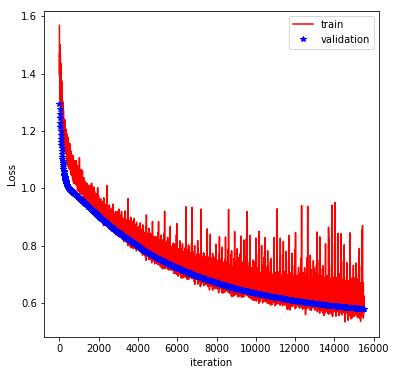

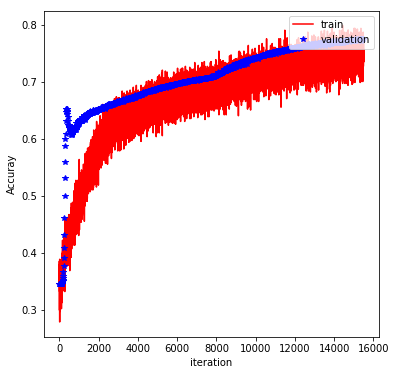

In [2]:
from tensorflow_setup import *
import tensorflow as tf 
import os 
import matplotlib.pyplot as plt
#%matplotlib inline

# filenames used 
traindtfile = 'hdf_250.h5'
testdtfile = 'hdf_250.h5'
losssavefig = 'cnn_train_250_loss.png'
accsavefig = 'cnn_train_250_accuracy.png'
resultsave = 'cnn_train_250.h5'
chkpointdir = 'cnn-250/'

X_tr, X_vld, y_tr, y_vld, list_ch_train = get_tf_train_data(traindtfile)


batch_size = 600       # Batch size
seq_len = 12          # Number of steps
learning_rate = 0.0001
epochs = 100

n_classes = 3 # buy sell and nothing
n_channels = 6 # moving averages

graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

with graph.as_default():
    # (batch, 12, 3) --> (batch, 6, 6)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=6, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_1, (-1, 6*6))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    soft = tf.argmax(logits,1)
    pred = tf.nn.softmax(logits,1)
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


if (os.path.exists('bschkpnt-cnn') == False):
    !mkdir bschkpnt-cnn

validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()


with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1


    saver.save(sess,chkpointdir + "bs.ckpt")


t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+losssavefig)

# change filename here


# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+accsavefig)

del(X_tr, X_vld, y_tr, y_vld, list_ch_train)

X_test, y_test, lab_ch_test = get_tf_test_data(testdtfile)

test_acc = []
probs = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(chkpointdir))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
        prob = sess.run(pred, feed_dict=feed)
        probs.append(prob)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))


# now reshape the probs array
probs = np.array(probs)
probs = probs.reshape((probs.shape[0]*probs.shape[1]), probs.shape[2])
y_test = y_test[:len(probs),:]
# model complete

# save the results

import h5py
hf = h5py.File('h5files/' + resultsave, 'w')
hf.create_dataset('predict_valid', data=probs)
hf.create_dataset('y_test', data = y_test)
hf.close()

del(X_test, y_test, lab_ch_test)


Epoch: 0/100 Iteration: 5 Train loss: 1.195491 Train acc: 0.285000
Epoch: 0/100 Iteration: 10 Train loss: 1.174576 Train acc: 0.311667
Epoch: 0/100 Iteration: 10 Validation loss: 1.125004 Validation acc: 0.239728
Epoch: 0/100 Iteration: 15 Train loss: 1.179457 Train acc: 0.296667
Epoch: 0/100 Iteration: 20 Train loss: 1.163035 Train acc: 0.315000
Epoch: 0/100 Iteration: 20 Validation loss: 1.121443 Validation acc: 0.239792
Epoch: 0/100 Iteration: 25 Train loss: 1.170084 Train acc: 0.321667
Epoch: 0/100 Iteration: 30 Train loss: 1.152744 Train acc: 0.340000
Epoch: 0/100 Iteration: 30 Validation loss: 1.118164 Validation acc: 0.239647
Epoch: 0/100 Iteration: 35 Train loss: 1.167792 Train acc: 0.321667
Epoch: 0/100 Iteration: 40 Train loss: 1.156915 Train acc: 0.321667
Epoch: 0/100 Iteration: 40 Validation loss: 1.115273 Validation acc: 0.239599
Epoch: 0/100 Iteration: 45 Train loss: 1.161867 Train acc: 0.300000
Epoch: 0/100 Iteration: 50 Train loss: 1.163673 Train acc: 0.298333
Epoch: 0/

Epoch: 1/100 Iteration: 390 Validation loss: 1.078129 Validation acc: 0.418910
Epoch: 1/100 Iteration: 395 Train loss: 1.092795 Train acc: 0.380000
Epoch: 1/100 Iteration: 400 Train loss: 1.098139 Train acc: 0.343333
Epoch: 1/100 Iteration: 400 Validation loss: 1.077703 Validation acc: 0.419792
Epoch: 1/100 Iteration: 405 Train loss: 1.081721 Train acc: 0.383333
Epoch: 1/100 Iteration: 410 Train loss: 1.080799 Train acc: 0.376667
Epoch: 1/100 Iteration: 410 Validation loss: 1.077255 Validation acc: 0.421298
Epoch: 1/100 Iteration: 415 Train loss: 1.092141 Train acc: 0.331667
Epoch: 1/100 Iteration: 420 Train loss: 1.087158 Train acc: 0.353333
Epoch: 1/100 Iteration: 420 Validation loss: 1.076872 Validation acc: 0.422548
Epoch: 1/100 Iteration: 425 Train loss: 1.081780 Train acc: 0.391667
Epoch: 1/100 Iteration: 430 Train loss: 1.076763 Train acc: 0.396667
Epoch: 1/100 Iteration: 430 Validation loss: 1.076547 Validation acc: 0.423269
Epoch: 1/100 Iteration: 435 Train loss: 1.071781 Trai

Epoch: 2/100 Iteration: 770 Validation loss: 1.066077 Validation acc: 0.434663
Epoch: 2/100 Iteration: 775 Train loss: 1.074578 Train acc: 0.403333
Epoch: 2/100 Iteration: 780 Train loss: 1.075684 Train acc: 0.413333
Epoch: 2/100 Iteration: 780 Validation loss: 1.065754 Validation acc: 0.433526
Epoch: 2/100 Iteration: 785 Train loss: 1.073961 Train acc: 0.428333
Epoch: 2/100 Iteration: 790 Train loss: 1.070399 Train acc: 0.408333
Epoch: 2/100 Iteration: 790 Validation loss: 1.065312 Validation acc: 0.432324
Epoch: 2/100 Iteration: 795 Train loss: 1.076452 Train acc: 0.425000
Epoch: 2/100 Iteration: 800 Train loss: 1.072449 Train acc: 0.433333
Epoch: 2/100 Iteration: 800 Validation loss: 1.064778 Validation acc: 0.430833
Epoch: 2/100 Iteration: 805 Train loss: 1.073310 Train acc: 0.398333
Epoch: 2/100 Iteration: 810 Train loss: 1.075845 Train acc: 0.416667
Epoch: 2/100 Iteration: 810 Validation loss: 1.064342 Validation acc: 0.429856
Epoch: 2/100 Iteration: 815 Train loss: 1.074115 Trai

Epoch: 3/100 Iteration: 1150 Validation loss: 1.051990 Validation acc: 0.429151
Epoch: 3/100 Iteration: 1155 Train loss: 1.050653 Train acc: 0.430000
Epoch: 3/100 Iteration: 1160 Train loss: 1.039828 Train acc: 0.451667
Epoch: 3/100 Iteration: 1160 Validation loss: 1.051611 Validation acc: 0.429327
Epoch: 3/100 Iteration: 1165 Train loss: 1.052307 Train acc: 0.450000
Epoch: 3/100 Iteration: 1170 Train loss: 1.067220 Train acc: 0.441667
Epoch: 3/100 Iteration: 1170 Validation loss: 1.051278 Validation acc: 0.430160
Epoch: 3/100 Iteration: 1175 Train loss: 1.057712 Train acc: 0.431667
Epoch: 3/100 Iteration: 1180 Train loss: 1.071287 Train acc: 0.390000
Epoch: 3/100 Iteration: 1180 Validation loss: 1.050945 Validation acc: 0.431875
Epoch: 3/100 Iteration: 1185 Train loss: 1.077595 Train acc: 0.406667
Epoch: 3/100 Iteration: 1190 Train loss: 1.070147 Train acc: 0.428333
Epoch: 3/100 Iteration: 1190 Validation loss: 1.050744 Validation acc: 0.432420
Epoch: 3/100 Iteration: 1195 Train loss:

Epoch: 4/100 Iteration: 1530 Validation loss: 1.038652 Validation acc: 0.453654
Epoch: 4/100 Iteration: 1535 Train loss: 1.049143 Train acc: 0.445000
Epoch: 4/100 Iteration: 1540 Train loss: 1.043436 Train acc: 0.458333
Epoch: 4/100 Iteration: 1540 Validation loss: 1.038219 Validation acc: 0.457837
Epoch: 4/100 Iteration: 1545 Train loss: 1.043395 Train acc: 0.461667
Epoch: 4/100 Iteration: 1550 Train loss: 1.047096 Train acc: 0.455000
Epoch: 4/100 Iteration: 1550 Validation loss: 1.037860 Validation acc: 0.460721
Epoch: 4/100 Iteration: 1555 Train loss: 1.052198 Train acc: 0.423333
Epoch: 4/100 Iteration: 1560 Train loss: 1.046981 Train acc: 0.465000
Epoch: 4/100 Iteration: 1560 Validation loss: 1.037468 Validation acc: 0.462724
Epoch: 4/100 Iteration: 1565 Train loss: 1.044126 Train acc: 0.481667
Epoch: 5/100 Iteration: 1570 Train loss: 1.040848 Train acc: 0.455000
Epoch: 5/100 Iteration: 1570 Validation loss: 1.037034 Validation acc: 0.463782
Epoch: 5/100 Iteration: 1575 Train loss:

Epoch: 6/100 Iteration: 1910 Validation loss: 1.022541 Validation acc: 0.503734
Epoch: 6/100 Iteration: 1915 Train loss: 1.044276 Train acc: 0.488333
Epoch: 6/100 Iteration: 1920 Train loss: 1.024561 Train acc: 0.511667
Epoch: 6/100 Iteration: 1920 Validation loss: 1.021985 Validation acc: 0.501394
Epoch: 6/100 Iteration: 1925 Train loss: 1.027593 Train acc: 0.498333
Epoch: 6/100 Iteration: 1930 Train loss: 1.017916 Train acc: 0.520000
Epoch: 6/100 Iteration: 1930 Validation loss: 1.021464 Validation acc: 0.498606
Epoch: 6/100 Iteration: 1935 Train loss: 1.034632 Train acc: 0.501667
Epoch: 6/100 Iteration: 1940 Train loss: 1.017123 Train acc: 0.516667
Epoch: 6/100 Iteration: 1940 Validation loss: 1.020969 Validation acc: 0.497580
Epoch: 6/100 Iteration: 1945 Train loss: 1.015281 Train acc: 0.530000
Epoch: 6/100 Iteration: 1950 Train loss: 1.034372 Train acc: 0.493333
Epoch: 6/100 Iteration: 1950 Validation loss: 1.020668 Validation acc: 0.504583
Epoch: 6/100 Iteration: 1955 Train loss:

Epoch: 7/100 Iteration: 2290 Validation loss: 0.978738 Validation acc: 0.605721
Epoch: 7/100 Iteration: 2295 Train loss: 0.991912 Train acc: 0.575000
Epoch: 7/100 Iteration: 2300 Train loss: 1.009983 Train acc: 0.545000
Epoch: 7/100 Iteration: 2300 Validation loss: 0.977726 Validation acc: 0.603526
Epoch: 7/100 Iteration: 2305 Train loss: 1.004182 Train acc: 0.538333
Epoch: 7/100 Iteration: 2310 Train loss: 0.999338 Train acc: 0.553333
Epoch: 7/100 Iteration: 2310 Validation loss: 0.976858 Validation acc: 0.604391
Epoch: 7/100 Iteration: 2315 Train loss: 0.991827 Train acc: 0.586667
Epoch: 7/100 Iteration: 2320 Train loss: 0.985264 Train acc: 0.560000
Epoch: 7/100 Iteration: 2320 Validation loss: 0.976022 Validation acc: 0.602853
Epoch: 7/100 Iteration: 2325 Train loss: 0.988252 Train acc: 0.563333
Epoch: 7/100 Iteration: 2330 Train loss: 1.002367 Train acc: 0.566667
Epoch: 7/100 Iteration: 2330 Validation loss: 0.975237 Validation acc: 0.603157
Epoch: 7/100 Iteration: 2335 Train loss:

Epoch: 8/100 Iteration: 2670 Validation loss: 0.943764 Validation acc: 0.622051
Epoch: 8/100 Iteration: 2675 Train loss: 0.941990 Train acc: 0.618333
Epoch: 8/100 Iteration: 2680 Train loss: 0.963506 Train acc: 0.566667
Epoch: 8/100 Iteration: 2680 Validation loss: 0.942589 Validation acc: 0.620994
Epoch: 8/100 Iteration: 2685 Train loss: 0.957604 Train acc: 0.566667
Epoch: 8/100 Iteration: 2690 Train loss: 0.930907 Train acc: 0.643333
Epoch: 8/100 Iteration: 2690 Validation loss: 0.941453 Validation acc: 0.622099
Epoch: 8/100 Iteration: 2695 Train loss: 0.956686 Train acc: 0.588333
Epoch: 8/100 Iteration: 2700 Train loss: 0.954798 Train acc: 0.561667
Epoch: 8/100 Iteration: 2700 Validation loss: 0.940469 Validation acc: 0.625369
Epoch: 8/100 Iteration: 2705 Train loss: 0.951085 Train acc: 0.605000
Epoch: 8/100 Iteration: 2710 Train loss: 0.936027 Train acc: 0.618333
Epoch: 8/100 Iteration: 2710 Validation loss: 0.939903 Validation acc: 0.632067
Epoch: 8/100 Iteration: 2715 Train loss:

Epoch: 9/100 Iteration: 3050 Validation loss: 0.912177 Validation acc: 0.641282
Epoch: 9/100 Iteration: 3055 Train loss: 0.960157 Train acc: 0.561667
Epoch: 9/100 Iteration: 3060 Train loss: 0.918957 Train acc: 0.595000
Epoch: 9/100 Iteration: 3060 Validation loss: 0.911301 Validation acc: 0.642580
Epoch: 9/100 Iteration: 3065 Train loss: 0.951747 Train acc: 0.598333
Epoch: 9/100 Iteration: 3070 Train loss: 0.962270 Train acc: 0.570000
Epoch: 9/100 Iteration: 3070 Validation loss: 0.910636 Validation acc: 0.640962
Epoch: 9/100 Iteration: 3075 Train loss: 0.942015 Train acc: 0.598333
Epoch: 9/100 Iteration: 3080 Train loss: 0.918380 Train acc: 0.611667
Epoch: 9/100 Iteration: 3080 Validation loss: 0.909710 Validation acc: 0.637484
Epoch: 9/100 Iteration: 3085 Train loss: 0.904735 Train acc: 0.630000
Epoch: 9/100 Iteration: 3090 Train loss: 0.930644 Train acc: 0.596667
Epoch: 9/100 Iteration: 3090 Validation loss: 0.908543 Validation acc: 0.638478
Epoch: 9/100 Iteration: 3095 Train loss:

Epoch: 10/100 Iteration: 3420 Validation loss: 0.884540 Validation acc: 0.650016
Epoch: 10/100 Iteration: 3425 Train loss: 0.895791 Train acc: 0.606667
Epoch: 10/100 Iteration: 3430 Train loss: 0.918817 Train acc: 0.581667
Epoch: 10/100 Iteration: 3430 Validation loss: 0.884148 Validation acc: 0.650176
Epoch: 10/100 Iteration: 3435 Train loss: 0.875374 Train acc: 0.635000
Epoch: 10/100 Iteration: 3440 Train loss: 0.877801 Train acc: 0.628333
Epoch: 10/100 Iteration: 3440 Validation loss: 0.883789 Validation acc: 0.651010
Epoch: 11/100 Iteration: 3445 Train loss: 0.909153 Train acc: 0.603333
Epoch: 11/100 Iteration: 3450 Train loss: 0.911535 Train acc: 0.606667
Epoch: 11/100 Iteration: 3450 Validation loss: 0.883316 Validation acc: 0.650849
Epoch: 11/100 Iteration: 3455 Train loss: 0.888897 Train acc: 0.640000
Epoch: 11/100 Iteration: 3460 Train loss: 0.883053 Train acc: 0.641667
Epoch: 11/100 Iteration: 3460 Validation loss: 0.882623 Validation acc: 0.648750
Epoch: 11/100 Iteration: 34

Epoch: 12/100 Iteration: 3790 Validation loss: 0.861151 Validation acc: 0.653301
Epoch: 12/100 Iteration: 3795 Train loss: 0.848160 Train acc: 0.656667
Epoch: 12/100 Iteration: 3800 Train loss: 0.884938 Train acc: 0.603333
Epoch: 12/100 Iteration: 3800 Validation loss: 0.860448 Validation acc: 0.651859
Epoch: 12/100 Iteration: 3805 Train loss: 0.894792 Train acc: 0.613333
Epoch: 12/100 Iteration: 3810 Train loss: 0.888468 Train acc: 0.613333
Epoch: 12/100 Iteration: 3810 Validation loss: 0.859748 Validation acc: 0.653253
Epoch: 12/100 Iteration: 3815 Train loss: 0.873415 Train acc: 0.640000
Epoch: 12/100 Iteration: 3820 Train loss: 0.919313 Train acc: 0.591667
Epoch: 12/100 Iteration: 3820 Validation loss: 0.859196 Validation acc: 0.652708
Epoch: 12/100 Iteration: 3825 Train loss: 0.903745 Train acc: 0.616667
Epoch: 12/100 Iteration: 3830 Train loss: 0.877097 Train acc: 0.623333
Epoch: 12/100 Iteration: 3830 Validation loss: 0.858725 Validation acc: 0.657308
Epoch: 12/100 Iteration: 38

Epoch: 13/100 Iteration: 4160 Validation loss: 0.840554 Validation acc: 0.663990
Epoch: 13/100 Iteration: 4165 Train loss: 0.853717 Train acc: 0.640000
Epoch: 13/100 Iteration: 4170 Train loss: 0.856539 Train acc: 0.638333
Epoch: 13/100 Iteration: 4170 Validation loss: 0.839755 Validation acc: 0.662949
Epoch: 13/100 Iteration: 4175 Train loss: 0.867164 Train acc: 0.615000
Epoch: 13/100 Iteration: 4180 Train loss: 0.881619 Train acc: 0.623333
Epoch: 13/100 Iteration: 4180 Validation loss: 0.839460 Validation acc: 0.663317
Epoch: 13/100 Iteration: 4185 Train loss: 0.860468 Train acc: 0.636667
Epoch: 13/100 Iteration: 4190 Train loss: 0.865519 Train acc: 0.646667
Epoch: 13/100 Iteration: 4190 Validation loss: 0.839257 Validation acc: 0.664583
Epoch: 13/100 Iteration: 4195 Train loss: 0.860571 Train acc: 0.648333
Epoch: 13/100 Iteration: 4200 Train loss: 0.860607 Train acc: 0.640000
Epoch: 13/100 Iteration: 4200 Validation loss: 0.838823 Validation acc: 0.664776
Epoch: 13/100 Iteration: 42

Epoch: 14/100 Iteration: 4530 Validation loss: 0.821310 Validation acc: 0.668365
Epoch: 14/100 Iteration: 4535 Train loss: 0.887246 Train acc: 0.606667
Epoch: 14/100 Iteration: 4540 Train loss: 0.826661 Train acc: 0.655000
Epoch: 14/100 Iteration: 4540 Validation loss: 0.821057 Validation acc: 0.667821
Epoch: 14/100 Iteration: 4545 Train loss: 0.836656 Train acc: 0.658333
Epoch: 14/100 Iteration: 4550 Train loss: 0.853263 Train acc: 0.628333
Epoch: 14/100 Iteration: 4550 Validation loss: 0.820634 Validation acc: 0.667917
Epoch: 14/100 Iteration: 4555 Train loss: 0.817157 Train acc: 0.658333
Epoch: 14/100 Iteration: 4560 Train loss: 0.872681 Train acc: 0.615000
Epoch: 14/100 Iteration: 4560 Validation loss: 0.820131 Validation acc: 0.668974
Epoch: 14/100 Iteration: 4565 Train loss: 0.847908 Train acc: 0.638333
Epoch: 14/100 Iteration: 4570 Train loss: 0.848101 Train acc: 0.618333
Epoch: 14/100 Iteration: 4570 Validation loss: 0.819260 Validation acc: 0.668413
Epoch: 14/100 Iteration: 45

Epoch: 15/100 Iteration: 4900 Validation loss: 0.803510 Validation acc: 0.674487
Epoch: 15/100 Iteration: 4905 Train loss: 0.834044 Train acc: 0.653333
Epoch: 15/100 Iteration: 4910 Train loss: 0.789878 Train acc: 0.686667
Epoch: 15/100 Iteration: 4910 Validation loss: 0.802718 Validation acc: 0.672724
Epoch: 15/100 Iteration: 4915 Train loss: 0.810286 Train acc: 0.670000
Epoch: 15/100 Iteration: 4920 Train loss: 0.798227 Train acc: 0.665000
Epoch: 15/100 Iteration: 4920 Validation loss: 0.801876 Validation acc: 0.673125
Epoch: 15/100 Iteration: 4925 Train loss: 0.813639 Train acc: 0.661667
Epoch: 15/100 Iteration: 4930 Train loss: 0.817713 Train acc: 0.658333
Epoch: 15/100 Iteration: 4930 Validation loss: 0.801194 Validation acc: 0.673782
Epoch: 15/100 Iteration: 4935 Train loss: 0.844478 Train acc: 0.638333
Epoch: 15/100 Iteration: 4940 Train loss: 0.807882 Train acc: 0.656667
Epoch: 15/100 Iteration: 4940 Validation loss: 0.800718 Validation acc: 0.674087
Epoch: 15/100 Iteration: 49

Epoch: 16/100 Iteration: 5270 Validation loss: 0.786287 Validation acc: 0.676202
Epoch: 16/100 Iteration: 5275 Train loss: 0.817161 Train acc: 0.655000
Epoch: 16/100 Iteration: 5280 Train loss: 0.781505 Train acc: 0.668333
Epoch: 16/100 Iteration: 5280 Validation loss: 0.785523 Validation acc: 0.676939
Epoch: 16/100 Iteration: 5285 Train loss: 0.810021 Train acc: 0.655000
Epoch: 16/100 Iteration: 5290 Train loss: 0.783589 Train acc: 0.678333
Epoch: 16/100 Iteration: 5290 Validation loss: 0.784748 Validation acc: 0.678029
Epoch: 16/100 Iteration: 5295 Train loss: 0.845589 Train acc: 0.616667
Epoch: 16/100 Iteration: 5300 Train loss: 0.792329 Train acc: 0.671667
Epoch: 16/100 Iteration: 5300 Validation loss: 0.784305 Validation acc: 0.678734
Epoch: 16/100 Iteration: 5305 Train loss: 0.769240 Train acc: 0.686667
Epoch: 16/100 Iteration: 5310 Train loss: 0.802945 Train acc: 0.648333
Epoch: 16/100 Iteration: 5310 Validation loss: 0.784052 Validation acc: 0.678333
Epoch: 16/100 Iteration: 53

Epoch: 18/100 Iteration: 5640 Validation loss: 0.770929 Validation acc: 0.682196
Epoch: 18/100 Iteration: 5645 Train loss: 0.853685 Train acc: 0.618333
Epoch: 18/100 Iteration: 5650 Train loss: 0.844640 Train acc: 0.635000
Epoch: 18/100 Iteration: 5650 Validation loss: 0.770484 Validation acc: 0.682164
Epoch: 18/100 Iteration: 5655 Train loss: 0.776871 Train acc: 0.693333
Epoch: 18/100 Iteration: 5660 Train loss: 0.820571 Train acc: 0.631667
Epoch: 18/100 Iteration: 5660 Validation loss: 0.770054 Validation acc: 0.681907
Epoch: 18/100 Iteration: 5665 Train loss: 0.784375 Train acc: 0.661667
Epoch: 18/100 Iteration: 5670 Train loss: 0.796773 Train acc: 0.665000
Epoch: 18/100 Iteration: 5670 Validation loss: 0.769598 Validation acc: 0.681554
Epoch: 18/100 Iteration: 5675 Train loss: 0.806860 Train acc: 0.660000
Epoch: 18/100 Iteration: 5680 Train loss: 0.796168 Train acc: 0.673333
Epoch: 18/100 Iteration: 5680 Validation loss: 0.769120 Validation acc: 0.681683
Epoch: 18/100 Iteration: 56

Epoch: 19/100 Iteration: 6010 Validation loss: 0.756411 Validation acc: 0.684199
Epoch: 19/100 Iteration: 6015 Train loss: 0.784172 Train acc: 0.650000
Epoch: 19/100 Iteration: 6020 Train loss: 0.781272 Train acc: 0.671667
Epoch: 19/100 Iteration: 6020 Validation loss: 0.756041 Validation acc: 0.687612
Epoch: 19/100 Iteration: 6025 Train loss: 0.819839 Train acc: 0.640000
Epoch: 19/100 Iteration: 6030 Train loss: 0.773913 Train acc: 0.691667
Epoch: 19/100 Iteration: 6030 Validation loss: 0.755926 Validation acc: 0.687676
Epoch: 19/100 Iteration: 6035 Train loss: 0.762823 Train acc: 0.680000
Epoch: 19/100 Iteration: 6040 Train loss: 0.754003 Train acc: 0.671667
Epoch: 19/100 Iteration: 6040 Validation loss: 0.755398 Validation acc: 0.687388
Epoch: 19/100 Iteration: 6045 Train loss: 0.784204 Train acc: 0.671667
Epoch: 19/100 Iteration: 6050 Train loss: 0.758903 Train acc: 0.683333
Epoch: 19/100 Iteration: 6050 Validation loss: 0.754817 Validation acc: 0.685753
Epoch: 19/100 Iteration: 60

Epoch: 20/100 Iteration: 6380 Validation loss: 0.742926 Validation acc: 0.691490
Epoch: 20/100 Iteration: 6385 Train loss: 0.768270 Train acc: 0.661667
Epoch: 20/100 Iteration: 6390 Train loss: 0.795899 Train acc: 0.653333
Epoch: 20/100 Iteration: 6390 Validation loss: 0.742748 Validation acc: 0.691731
Epoch: 20/100 Iteration: 6395 Train loss: 0.783498 Train acc: 0.668333
Epoch: 20/100 Iteration: 6400 Train loss: 0.761387 Train acc: 0.658333
Epoch: 20/100 Iteration: 6400 Validation loss: 0.742152 Validation acc: 0.691458
Epoch: 20/100 Iteration: 6405 Train loss: 0.782003 Train acc: 0.671667
Epoch: 20/100 Iteration: 6410 Train loss: 0.799220 Train acc: 0.648333
Epoch: 20/100 Iteration: 6410 Validation loss: 0.741819 Validation acc: 0.691442
Epoch: 20/100 Iteration: 6415 Train loss: 0.760968 Train acc: 0.666667
Epoch: 20/100 Iteration: 6420 Train loss: 0.730598 Train acc: 0.696667
Epoch: 20/100 Iteration: 6420 Validation loss: 0.741519 Validation acc: 0.691426
Epoch: 20/100 Iteration: 64

Epoch: 21/100 Iteration: 6750 Validation loss: 0.729165 Validation acc: 0.694231
Epoch: 21/100 Iteration: 6755 Train loss: 0.749755 Train acc: 0.676667
Epoch: 21/100 Iteration: 6760 Train loss: 0.788846 Train acc: 0.645000
Epoch: 21/100 Iteration: 6760 Validation loss: 0.728690 Validation acc: 0.695032
Epoch: 21/100 Iteration: 6765 Train loss: 0.775534 Train acc: 0.678333
Epoch: 21/100 Iteration: 6770 Train loss: 0.777957 Train acc: 0.655000
Epoch: 21/100 Iteration: 6770 Validation loss: 0.728449 Validation acc: 0.695000
Epoch: 21/100 Iteration: 6775 Train loss: 0.739822 Train acc: 0.683333
Epoch: 21/100 Iteration: 6780 Train loss: 0.763461 Train acc: 0.666667
Epoch: 21/100 Iteration: 6780 Validation loss: 0.728623 Validation acc: 0.695481
Epoch: 21/100 Iteration: 6785 Train loss: 0.751569 Train acc: 0.660000
Epoch: 21/100 Iteration: 6790 Train loss: 0.764216 Train acc: 0.675000
Epoch: 21/100 Iteration: 6790 Validation loss: 0.728095 Validation acc: 0.694663
Epoch: 21/100 Iteration: 67

Epoch: 22/100 Iteration: 7120 Validation loss: 0.717412 Validation acc: 0.698029
Epoch: 22/100 Iteration: 7125 Train loss: 0.731039 Train acc: 0.690000
Epoch: 22/100 Iteration: 7130 Train loss: 0.707155 Train acc: 0.705000
Epoch: 22/100 Iteration: 7130 Validation loss: 0.716817 Validation acc: 0.698526
Epoch: 22/100 Iteration: 7135 Train loss: 0.754493 Train acc: 0.658333
Epoch: 22/100 Iteration: 7140 Train loss: 0.754794 Train acc: 0.681667
Epoch: 22/100 Iteration: 7140 Validation loss: 0.716300 Validation acc: 0.697500
Epoch: 22/100 Iteration: 7145 Train loss: 0.762473 Train acc: 0.660000
Epoch: 22/100 Iteration: 7150 Train loss: 0.745955 Train acc: 0.686667
Epoch: 22/100 Iteration: 7150 Validation loss: 0.716022 Validation acc: 0.696955
Epoch: 22/100 Iteration: 7155 Train loss: 0.760534 Train acc: 0.671667
Epoch: 22/100 Iteration: 7160 Train loss: 0.676083 Train acc: 0.720000
Epoch: 22/100 Iteration: 7160 Validation loss: 0.715603 Validation acc: 0.697147
Epoch: 22/100 Iteration: 71

Epoch: 23/100 Iteration: 7490 Validation loss: 0.705537 Validation acc: 0.700641
Epoch: 23/100 Iteration: 7495 Train loss: 0.734432 Train acc: 0.683333
Epoch: 23/100 Iteration: 7500 Train loss: 0.761951 Train acc: 0.661667
Epoch: 23/100 Iteration: 7500 Validation loss: 0.705094 Validation acc: 0.700144
Epoch: 23/100 Iteration: 7505 Train loss: 0.741118 Train acc: 0.663333
Epoch: 23/100 Iteration: 7510 Train loss: 0.725564 Train acc: 0.683333
Epoch: 23/100 Iteration: 7510 Validation loss: 0.704986 Validation acc: 0.700273
Epoch: 24/100 Iteration: 7515 Train loss: 0.765081 Train acc: 0.688333
Epoch: 24/100 Iteration: 7520 Train loss: 0.742421 Train acc: 0.686667
Epoch: 24/100 Iteration: 7520 Validation loss: 0.704666 Validation acc: 0.700913
Epoch: 24/100 Iteration: 7525 Train loss: 0.703523 Train acc: 0.693333
Epoch: 24/100 Iteration: 7530 Train loss: 0.727258 Train acc: 0.693333
Epoch: 24/100 Iteration: 7530 Validation loss: 0.704181 Validation acc: 0.700481
Epoch: 24/100 Iteration: 75

Epoch: 25/100 Iteration: 7860 Validation loss: 0.694785 Validation acc: 0.701779
Epoch: 25/100 Iteration: 7865 Train loss: 0.746674 Train acc: 0.668333
Epoch: 25/100 Iteration: 7870 Train loss: 0.722158 Train acc: 0.686667
Epoch: 25/100 Iteration: 7870 Validation loss: 0.694604 Validation acc: 0.701635
Epoch: 25/100 Iteration: 7875 Train loss: 0.758368 Train acc: 0.646667
Epoch: 25/100 Iteration: 7880 Train loss: 0.692705 Train acc: 0.720000
Epoch: 25/100 Iteration: 7880 Validation loss: 0.694058 Validation acc: 0.702051
Epoch: 25/100 Iteration: 7885 Train loss: 0.745489 Train acc: 0.666667
Epoch: 25/100 Iteration: 7890 Train loss: 0.726554 Train acc: 0.686667
Epoch: 25/100 Iteration: 7890 Validation loss: 0.693809 Validation acc: 0.702035
Epoch: 25/100 Iteration: 7895 Train loss: 0.734894 Train acc: 0.671667
Epoch: 25/100 Iteration: 7900 Train loss: 0.725905 Train acc: 0.685000
Epoch: 25/100 Iteration: 7900 Validation loss: 0.693552 Validation acc: 0.703974
Epoch: 25/100 Iteration: 79

Epoch: 26/100 Iteration: 8230 Validation loss: 0.684866 Validation acc: 0.705625
Epoch: 26/100 Iteration: 8235 Train loss: 0.718918 Train acc: 0.680000
Epoch: 26/100 Iteration: 8240 Train loss: 0.707320 Train acc: 0.680000
Epoch: 26/100 Iteration: 8240 Validation loss: 0.684629 Validation acc: 0.704615
Epoch: 26/100 Iteration: 8245 Train loss: 0.720483 Train acc: 0.700000
Epoch: 26/100 Iteration: 8250 Train loss: 0.693506 Train acc: 0.716667
Epoch: 26/100 Iteration: 8250 Validation loss: 0.684026 Validation acc: 0.705337
Epoch: 26/100 Iteration: 8255 Train loss: 0.725220 Train acc: 0.693333
Epoch: 26/100 Iteration: 8260 Train loss: 0.709999 Train acc: 0.665000
Epoch: 26/100 Iteration: 8260 Validation loss: 0.683813 Validation acc: 0.705978
Epoch: 26/100 Iteration: 8265 Train loss: 0.717540 Train acc: 0.695000
Epoch: 26/100 Iteration: 8270 Train loss: 0.725626 Train acc: 0.656667
Epoch: 26/100 Iteration: 8270 Validation loss: 0.683309 Validation acc: 0.706186
Epoch: 26/100 Iteration: 82

Epoch: 27/100 Iteration: 8600 Validation loss: 0.674946 Validation acc: 0.707676
Epoch: 27/100 Iteration: 8605 Train loss: 0.716884 Train acc: 0.665000
Epoch: 27/100 Iteration: 8610 Train loss: 0.726940 Train acc: 0.666667
Epoch: 27/100 Iteration: 8610 Validation loss: 0.674728 Validation acc: 0.707196
Epoch: 27/100 Iteration: 8615 Train loss: 0.677249 Train acc: 0.690000
Epoch: 27/100 Iteration: 8620 Train loss: 0.733040 Train acc: 0.675000
Epoch: 27/100 Iteration: 8620 Validation loss: 0.674407 Validation acc: 0.707147
Epoch: 27/100 Iteration: 8625 Train loss: 0.720121 Train acc: 0.678333
Epoch: 27/100 Iteration: 8630 Train loss: 0.682341 Train acc: 0.706667
Epoch: 27/100 Iteration: 8630 Validation loss: 0.673943 Validation acc: 0.708013
Epoch: 27/100 Iteration: 8635 Train loss: 0.708624 Train acc: 0.686667
Epoch: 27/100 Iteration: 8640 Train loss: 0.720277 Train acc: 0.680000
Epoch: 27/100 Iteration: 8640 Validation loss: 0.673422 Validation acc: 0.708221
Epoch: 27/100 Iteration: 86

Epoch: 28/100 Iteration: 8970 Validation loss: 0.665742 Validation acc: 0.710449
Epoch: 28/100 Iteration: 8975 Train loss: 0.718785 Train acc: 0.670000
Epoch: 28/100 Iteration: 8980 Train loss: 0.696924 Train acc: 0.736667
Epoch: 28/100 Iteration: 8980 Validation loss: 0.665666 Validation acc: 0.708574
Epoch: 28/100 Iteration: 8985 Train loss: 0.668054 Train acc: 0.726667
Epoch: 28/100 Iteration: 8990 Train loss: 0.683113 Train acc: 0.723333
Epoch: 28/100 Iteration: 8990 Validation loss: 0.665393 Validation acc: 0.709776
Epoch: 28/100 Iteration: 8995 Train loss: 0.704472 Train acc: 0.681667
Epoch: 28/100 Iteration: 9000 Train loss: 0.681033 Train acc: 0.688333
Epoch: 28/100 Iteration: 9000 Validation loss: 0.665152 Validation acc: 0.710176
Epoch: 28/100 Iteration: 9005 Train loss: 0.702870 Train acc: 0.651667
Epoch: 28/100 Iteration: 9010 Train loss: 0.751647 Train acc: 0.671667
Epoch: 28/100 Iteration: 9010 Validation loss: 0.664700 Validation acc: 0.710609
Epoch: 28/100 Iteration: 90

Epoch: 29/100 Iteration: 9340 Validation loss: 0.656668 Validation acc: 0.713942
Epoch: 29/100 Iteration: 9345 Train loss: 0.673549 Train acc: 0.708333
Epoch: 29/100 Iteration: 9350 Train loss: 0.717417 Train acc: 0.666667
Epoch: 29/100 Iteration: 9350 Validation loss: 0.656224 Validation acc: 0.713990
Epoch: 29/100 Iteration: 9355 Train loss: 0.682253 Train acc: 0.708333
Epoch: 29/100 Iteration: 9360 Train loss: 0.697043 Train acc: 0.693333
Epoch: 29/100 Iteration: 9360 Validation loss: 0.655773 Validation acc: 0.714167
Epoch: 29/100 Iteration: 9365 Train loss: 0.697683 Train acc: 0.708333
Epoch: 29/100 Iteration: 9370 Train loss: 0.664158 Train acc: 0.701667
Epoch: 29/100 Iteration: 9370 Validation loss: 0.655569 Validation acc: 0.714263
Epoch: 29/100 Iteration: 9375 Train loss: 0.702332 Train acc: 0.681667
Epoch: 29/100 Iteration: 9380 Train loss: 0.724914 Train acc: 0.666667
Epoch: 29/100 Iteration: 9380 Validation loss: 0.655508 Validation acc: 0.713878
Epoch: 29/100 Iteration: 93

Epoch: 31/100 Iteration: 9710 Validation loss: 0.649489 Validation acc: 0.717756
Epoch: 31/100 Iteration: 9715 Train loss: 0.685139 Train acc: 0.710000
Epoch: 31/100 Iteration: 9720 Train loss: 0.650715 Train acc: 0.721667
Epoch: 31/100 Iteration: 9720 Validation loss: 0.649094 Validation acc: 0.717564
Epoch: 31/100 Iteration: 9725 Train loss: 0.722188 Train acc: 0.660000
Epoch: 31/100 Iteration: 9730 Train loss: 0.668729 Train acc: 0.693333
Epoch: 31/100 Iteration: 9730 Validation loss: 0.648689 Validation acc: 0.717308
Epoch: 31/100 Iteration: 9735 Train loss: 0.648774 Train acc: 0.728333
Epoch: 31/100 Iteration: 9740 Train loss: 0.716593 Train acc: 0.673333
Epoch: 31/100 Iteration: 9740 Validation loss: 0.648499 Validation acc: 0.717628
Epoch: 31/100 Iteration: 9745 Train loss: 0.685980 Train acc: 0.691667
Epoch: 31/100 Iteration: 9750 Train loss: 0.688519 Train acc: 0.685000
Epoch: 31/100 Iteration: 9750 Validation loss: 0.648421 Validation acc: 0.717692
Epoch: 31/100 Iteration: 97

Epoch: 32/100 Iteration: 10080 Validation loss: 0.642091 Validation acc: 0.722292
Epoch: 32/100 Iteration: 10085 Train loss: 0.680180 Train acc: 0.680000
Epoch: 32/100 Iteration: 10090 Train loss: 0.678361 Train acc: 0.703333
Epoch: 32/100 Iteration: 10090 Validation loss: 0.641721 Validation acc: 0.726571
Epoch: 32/100 Iteration: 10095 Train loss: 0.671234 Train acc: 0.706667
Epoch: 32/100 Iteration: 10100 Train loss: 0.649772 Train acc: 0.711667
Epoch: 32/100 Iteration: 10100 Validation loss: 0.641532 Validation acc: 0.726587
Epoch: 32/100 Iteration: 10105 Train loss: 0.686664 Train acc: 0.726667
Epoch: 32/100 Iteration: 10110 Train loss: 0.651227 Train acc: 0.711667
Epoch: 32/100 Iteration: 10110 Validation loss: 0.641367 Validation acc: 0.724183
Epoch: 32/100 Iteration: 10115 Train loss: 0.675084 Train acc: 0.706667
Epoch: 32/100 Iteration: 10120 Train loss: 0.665216 Train acc: 0.708333
Epoch: 32/100 Iteration: 10120 Validation loss: 0.641378 Validation acc: 0.722276
Epoch: 32/100 

Epoch: 33/100 Iteration: 10450 Validation loss: 0.635037 Validation acc: 0.730561
Epoch: 33/100 Iteration: 10455 Train loss: 0.672293 Train acc: 0.706667
Epoch: 33/100 Iteration: 10460 Train loss: 0.682198 Train acc: 0.693333
Epoch: 33/100 Iteration: 10460 Validation loss: 0.634596 Validation acc: 0.730962
Epoch: 33/100 Iteration: 10465 Train loss: 0.680928 Train acc: 0.676667
Epoch: 33/100 Iteration: 10470 Train loss: 0.658964 Train acc: 0.690000
Epoch: 33/100 Iteration: 10470 Validation loss: 0.634028 Validation acc: 0.732019
Epoch: 33/100 Iteration: 10475 Train loss: 0.703821 Train acc: 0.708333
Epoch: 33/100 Iteration: 10480 Train loss: 0.631648 Train acc: 0.731667
Epoch: 33/100 Iteration: 10480 Validation loss: 0.633806 Validation acc: 0.732532
Epoch: 33/100 Iteration: 10485 Train loss: 0.668670 Train acc: 0.705000
Epoch: 33/100 Iteration: 10490 Train loss: 0.662796 Train acc: 0.723333
Epoch: 33/100 Iteration: 10490 Validation loss: 0.633464 Validation acc: 0.732019
Epoch: 33/100 

Epoch: 34/100 Iteration: 10820 Validation loss: 0.627470 Validation acc: 0.737019
Epoch: 34/100 Iteration: 10825 Train loss: 0.663790 Train acc: 0.700000
Epoch: 34/100 Iteration: 10830 Train loss: 0.716582 Train acc: 0.666667
Epoch: 34/100 Iteration: 10830 Validation loss: 0.627655 Validation acc: 0.737340
Epoch: 34/100 Iteration: 10835 Train loss: 0.637317 Train acc: 0.741667
Epoch: 34/100 Iteration: 10840 Train loss: 0.731460 Train acc: 0.671667
Epoch: 34/100 Iteration: 10840 Validation loss: 0.628086 Validation acc: 0.737244
Epoch: 34/100 Iteration: 10845 Train loss: 0.724025 Train acc: 0.665000
Epoch: 34/100 Iteration: 10850 Train loss: 0.683543 Train acc: 0.703333
Epoch: 34/100 Iteration: 10850 Validation loss: 0.628540 Validation acc: 0.737564
Epoch: 34/100 Iteration: 10855 Train loss: 0.654741 Train acc: 0.700000
Epoch: 34/100 Iteration: 10860 Train loss: 0.672100 Train acc: 0.700000
Epoch: 34/100 Iteration: 10860 Validation loss: 0.628170 Validation acc: 0.735946
Epoch: 34/100 

Epoch: 35/100 Iteration: 11190 Validation loss: 0.621246 Validation acc: 0.742019
Epoch: 35/100 Iteration: 11195 Train loss: 0.684050 Train acc: 0.690000
Epoch: 35/100 Iteration: 11200 Train loss: 0.657654 Train acc: 0.711667
Epoch: 35/100 Iteration: 11200 Validation loss: 0.620982 Validation acc: 0.742564
Epoch: 35/100 Iteration: 11205 Train loss: 0.659196 Train acc: 0.726667
Epoch: 35/100 Iteration: 11210 Train loss: 0.669792 Train acc: 0.690000
Epoch: 35/100 Iteration: 11210 Validation loss: 0.621279 Validation acc: 0.741122
Epoch: 35/100 Iteration: 11215 Train loss: 0.649665 Train acc: 0.736667
Epoch: 35/100 Iteration: 11220 Train loss: 0.705432 Train acc: 0.700000
Epoch: 35/100 Iteration: 11220 Validation loss: 0.621190 Validation acc: 0.741282
Epoch: 35/100 Iteration: 11225 Train loss: 0.657625 Train acc: 0.725000
Epoch: 35/100 Iteration: 11230 Train loss: 0.634866 Train acc: 0.720000
Epoch: 35/100 Iteration: 11230 Validation loss: 0.620802 Validation acc: 0.741907
Epoch: 35/100 

Epoch: 36/100 Iteration: 11560 Validation loss: 0.614984 Validation acc: 0.745833
Epoch: 36/100 Iteration: 11565 Train loss: 0.626023 Train acc: 0.740000
Epoch: 36/100 Iteration: 11570 Train loss: 0.648311 Train acc: 0.703333
Epoch: 36/100 Iteration: 11570 Validation loss: 0.615335 Validation acc: 0.744840
Epoch: 36/100 Iteration: 11575 Train loss: 0.658427 Train acc: 0.748333
Epoch: 36/100 Iteration: 11580 Train loss: 0.627484 Train acc: 0.730000
Epoch: 36/100 Iteration: 11580 Validation loss: 0.615796 Validation acc: 0.744920
Epoch: 37/100 Iteration: 11585 Train loss: 0.623043 Train acc: 0.736667
Epoch: 37/100 Iteration: 11590 Train loss: 0.637383 Train acc: 0.736667
Epoch: 37/100 Iteration: 11590 Validation loss: 0.615513 Validation acc: 0.745929
Epoch: 37/100 Iteration: 11595 Train loss: 0.658956 Train acc: 0.696667
Epoch: 37/100 Iteration: 11600 Train loss: 0.654359 Train acc: 0.691667
Epoch: 37/100 Iteration: 11600 Validation loss: 0.614850 Validation acc: 0.744455
Epoch: 37/100 

Epoch: 38/100 Iteration: 11930 Validation loss: 0.610407 Validation acc: 0.746763
Epoch: 38/100 Iteration: 11935 Train loss: 0.638417 Train acc: 0.711667
Epoch: 38/100 Iteration: 11940 Train loss: 0.636295 Train acc: 0.718333
Epoch: 38/100 Iteration: 11940 Validation loss: 0.609853 Validation acc: 0.747179
Epoch: 38/100 Iteration: 11945 Train loss: 0.614069 Train acc: 0.725000
Epoch: 38/100 Iteration: 11950 Train loss: 0.640899 Train acc: 0.735000
Epoch: 38/100 Iteration: 11950 Validation loss: 0.609775 Validation acc: 0.747436
Epoch: 38/100 Iteration: 11955 Train loss: 0.628665 Train acc: 0.711667
Epoch: 38/100 Iteration: 11960 Train loss: 0.669120 Train acc: 0.703333
Epoch: 38/100 Iteration: 11960 Validation loss: 0.610179 Validation acc: 0.747067
Epoch: 38/100 Iteration: 11965 Train loss: 0.626056 Train acc: 0.725000
Epoch: 38/100 Iteration: 11970 Train loss: 0.632739 Train acc: 0.721667
Epoch: 38/100 Iteration: 11970 Validation loss: 0.609886 Validation acc: 0.748846
Epoch: 38/100 

Epoch: 39/100 Iteration: 12300 Validation loss: 0.605713 Validation acc: 0.750737
Epoch: 39/100 Iteration: 12305 Train loss: 0.639120 Train acc: 0.726667
Epoch: 39/100 Iteration: 12310 Train loss: 0.611652 Train acc: 0.753333
Epoch: 39/100 Iteration: 12310 Validation loss: 0.605048 Validation acc: 0.750176
Epoch: 39/100 Iteration: 12315 Train loss: 0.666798 Train acc: 0.690000
Epoch: 39/100 Iteration: 12320 Train loss: 0.663741 Train acc: 0.725000
Epoch: 39/100 Iteration: 12320 Validation loss: 0.604917 Validation acc: 0.751330
Epoch: 39/100 Iteration: 12325 Train loss: 0.686244 Train acc: 0.700000
Epoch: 39/100 Iteration: 12330 Train loss: 0.663951 Train acc: 0.735000
Epoch: 39/100 Iteration: 12330 Validation loss: 0.605099 Validation acc: 0.750785
Epoch: 39/100 Iteration: 12335 Train loss: 0.677088 Train acc: 0.740000
Epoch: 39/100 Iteration: 12340 Train loss: 0.660682 Train acc: 0.706667
Epoch: 39/100 Iteration: 12340 Validation loss: 0.604990 Validation acc: 0.752147
Epoch: 39/100 

Epoch: 40/100 Iteration: 12670 Validation loss: 0.599969 Validation acc: 0.755401
Epoch: 40/100 Iteration: 12675 Train loss: 0.639744 Train acc: 0.726667
Epoch: 40/100 Iteration: 12680 Train loss: 0.594891 Train acc: 0.738333
Epoch: 40/100 Iteration: 12680 Validation loss: 0.599755 Validation acc: 0.755545
Epoch: 40/100 Iteration: 12685 Train loss: 0.637711 Train acc: 0.735000
Epoch: 40/100 Iteration: 12690 Train loss: 0.622156 Train acc: 0.748333
Epoch: 40/100 Iteration: 12690 Validation loss: 0.599345 Validation acc: 0.756026
Epoch: 40/100 Iteration: 12695 Train loss: 0.680176 Train acc: 0.700000
Epoch: 40/100 Iteration: 12700 Train loss: 0.647044 Train acc: 0.738333
Epoch: 40/100 Iteration: 12700 Validation loss: 0.599421 Validation acc: 0.756891
Epoch: 40/100 Iteration: 12705 Train loss: 0.646061 Train acc: 0.716667
Epoch: 40/100 Iteration: 12710 Train loss: 0.666167 Train acc: 0.701667
Epoch: 40/100 Iteration: 12710 Validation loss: 0.599150 Validation acc: 0.756138
Epoch: 40/100 

Epoch: 41/100 Iteration: 13040 Validation loss: 0.595439 Validation acc: 0.759984
Epoch: 41/100 Iteration: 13045 Train loss: 0.635737 Train acc: 0.733333
Epoch: 41/100 Iteration: 13050 Train loss: 0.653240 Train acc: 0.730000
Epoch: 41/100 Iteration: 13050 Validation loss: 0.595821 Validation acc: 0.755417
Epoch: 41/100 Iteration: 13055 Train loss: 0.642553 Train acc: 0.723333
Epoch: 41/100 Iteration: 13060 Train loss: 0.616614 Train acc: 0.745000
Epoch: 41/100 Iteration: 13060 Validation loss: 0.595523 Validation acc: 0.758526
Epoch: 41/100 Iteration: 13065 Train loss: 0.602536 Train acc: 0.758333
Epoch: 41/100 Iteration: 13070 Train loss: 0.608497 Train acc: 0.730000
Epoch: 41/100 Iteration: 13070 Validation loss: 0.595561 Validation acc: 0.759744
Epoch: 41/100 Iteration: 13075 Train loss: 0.620902 Train acc: 0.711667
Epoch: 41/100 Iteration: 13080 Train loss: 0.613155 Train acc: 0.745000
Epoch: 41/100 Iteration: 13080 Validation loss: 0.595505 Validation acc: 0.760032
Epoch: 41/100 

Epoch: 42/100 Iteration: 13410 Validation loss: 0.590760 Validation acc: 0.761026
Epoch: 42/100 Iteration: 13415 Train loss: 0.640015 Train acc: 0.716667
Epoch: 42/100 Iteration: 13420 Train loss: 0.587708 Train acc: 0.756667
Epoch: 42/100 Iteration: 13420 Validation loss: 0.590863 Validation acc: 0.761811
Epoch: 42/100 Iteration: 13425 Train loss: 0.602908 Train acc: 0.755000
Epoch: 42/100 Iteration: 13430 Train loss: 0.606346 Train acc: 0.738333
Epoch: 42/100 Iteration: 13430 Validation loss: 0.590610 Validation acc: 0.761843
Epoch: 42/100 Iteration: 13435 Train loss: 0.615877 Train acc: 0.716667
Epoch: 42/100 Iteration: 13440 Train loss: 0.648376 Train acc: 0.718333
Epoch: 42/100 Iteration: 13440 Validation loss: 0.590468 Validation acc: 0.761859
Epoch: 42/100 Iteration: 13445 Train loss: 0.644290 Train acc: 0.748333
Epoch: 42/100 Iteration: 13450 Train loss: 0.596541 Train acc: 0.751667
Epoch: 42/100 Iteration: 13450 Validation loss: 0.590655 Validation acc: 0.761218
Epoch: 42/100 

Epoch: 44/100 Iteration: 13780 Validation loss: 0.587885 Validation acc: 0.764407
Epoch: 44/100 Iteration: 13785 Train loss: 0.602868 Train acc: 0.748333
Epoch: 44/100 Iteration: 13790 Train loss: 0.633374 Train acc: 0.733333
Epoch: 44/100 Iteration: 13790 Validation loss: 0.587103 Validation acc: 0.763061
Epoch: 44/100 Iteration: 13795 Train loss: 0.593767 Train acc: 0.766667
Epoch: 44/100 Iteration: 13800 Train loss: 0.613561 Train acc: 0.731667
Epoch: 44/100 Iteration: 13800 Validation loss: 0.586727 Validation acc: 0.763910
Epoch: 44/100 Iteration: 13805 Train loss: 0.703174 Train acc: 0.711667
Epoch: 44/100 Iteration: 13810 Train loss: 0.674341 Train acc: 0.700000
Epoch: 44/100 Iteration: 13810 Validation loss: 0.586534 Validation acc: 0.762628
Epoch: 44/100 Iteration: 13815 Train loss: 0.643005 Train acc: 0.720000
Epoch: 44/100 Iteration: 13820 Train loss: 0.616409 Train acc: 0.745000
Epoch: 44/100 Iteration: 13820 Validation loss: 0.586734 Validation acc: 0.761651
Epoch: 44/100 

Epoch: 45/100 Iteration: 14150 Validation loss: 0.583749 Validation acc: 0.762949
Epoch: 45/100 Iteration: 14155 Train loss: 0.638093 Train acc: 0.711667
Epoch: 45/100 Iteration: 14160 Train loss: 0.613812 Train acc: 0.725000
Epoch: 45/100 Iteration: 14160 Validation loss: 0.583677 Validation acc: 0.765513
Epoch: 45/100 Iteration: 14165 Train loss: 0.643871 Train acc: 0.748333
Epoch: 45/100 Iteration: 14170 Train loss: 0.632500 Train acc: 0.728333
Epoch: 45/100 Iteration: 14170 Validation loss: 0.583275 Validation acc: 0.765785
Epoch: 45/100 Iteration: 14175 Train loss: 0.608050 Train acc: 0.781667
Epoch: 45/100 Iteration: 14180 Train loss: 0.625792 Train acc: 0.746667
Epoch: 45/100 Iteration: 14180 Validation loss: 0.583145 Validation acc: 0.764199
Epoch: 45/100 Iteration: 14185 Train loss: 0.620322 Train acc: 0.738333
Epoch: 45/100 Iteration: 14190 Train loss: 0.640868 Train acc: 0.736667
Epoch: 45/100 Iteration: 14190 Validation loss: 0.582458 Validation acc: 0.764103
Epoch: 45/100 

Epoch: 46/100 Iteration: 14520 Validation loss: 0.579358 Validation acc: 0.767917
Epoch: 46/100 Iteration: 14525 Train loss: 0.630545 Train acc: 0.716667
Epoch: 46/100 Iteration: 14530 Train loss: 0.629310 Train acc: 0.708333
Epoch: 46/100 Iteration: 14530 Validation loss: 0.579545 Validation acc: 0.767292
Epoch: 46/100 Iteration: 14535 Train loss: 0.614272 Train acc: 0.730000
Epoch: 46/100 Iteration: 14540 Train loss: 0.590647 Train acc: 0.750000
Epoch: 46/100 Iteration: 14540 Validation loss: 0.579559 Validation acc: 0.767997
Epoch: 46/100 Iteration: 14545 Train loss: 0.628721 Train acc: 0.711667
Epoch: 46/100 Iteration: 14550 Train loss: 0.617763 Train acc: 0.743333
Epoch: 46/100 Iteration: 14550 Validation loss: 0.579518 Validation acc: 0.766843
Epoch: 46/100 Iteration: 14555 Train loss: 0.618320 Train acc: 0.720000
Epoch: 46/100 Iteration: 14560 Train loss: 0.601127 Train acc: 0.740000
Epoch: 46/100 Iteration: 14560 Validation loss: 0.578973 Validation acc: 0.766522
Epoch: 46/100 

Epoch: 47/100 Iteration: 14890 Validation loss: 0.575291 Validation acc: 0.770016
Epoch: 47/100 Iteration: 14895 Train loss: 0.622572 Train acc: 0.756667
Epoch: 47/100 Iteration: 14900 Train loss: 0.622849 Train acc: 0.718333
Epoch: 47/100 Iteration: 14900 Validation loss: 0.575431 Validation acc: 0.770321
Epoch: 47/100 Iteration: 14905 Train loss: 0.669454 Train acc: 0.718333
Epoch: 47/100 Iteration: 14910 Train loss: 0.624656 Train acc: 0.718333
Epoch: 47/100 Iteration: 14910 Validation loss: 0.575515 Validation acc: 0.770385
Epoch: 47/100 Iteration: 14915 Train loss: 0.602975 Train acc: 0.740000
Epoch: 47/100 Iteration: 14920 Train loss: 0.588730 Train acc: 0.745000
Epoch: 47/100 Iteration: 14920 Validation loss: 0.575460 Validation acc: 0.770513
Epoch: 47/100 Iteration: 14925 Train loss: 0.645257 Train acc: 0.711667
Epoch: 47/100 Iteration: 14930 Train loss: 0.897391 Train acc: 0.733333
Epoch: 47/100 Iteration: 14930 Validation loss: 0.575326 Validation acc: 0.767933
Epoch: 47/100 

Epoch: 48/100 Iteration: 15260 Validation loss: 0.572606 Validation acc: 0.772276
Epoch: 48/100 Iteration: 15265 Train loss: 0.607166 Train acc: 0.721667
Epoch: 48/100 Iteration: 15270 Train loss: 0.698015 Train acc: 0.686667
Epoch: 48/100 Iteration: 15270 Validation loss: 0.572257 Validation acc: 0.772244
Epoch: 48/100 Iteration: 15275 Train loss: 0.625353 Train acc: 0.721667
Epoch: 48/100 Iteration: 15280 Train loss: 0.605590 Train acc: 0.745000
Epoch: 48/100 Iteration: 15280 Validation loss: 0.571935 Validation acc: 0.771250
Epoch: 48/100 Iteration: 15285 Train loss: 0.615009 Train acc: 0.730000
Epoch: 48/100 Iteration: 15290 Train loss: 0.626703 Train acc: 0.745000
Epoch: 48/100 Iteration: 15290 Validation loss: 0.572279 Validation acc: 0.769631
Epoch: 48/100 Iteration: 15295 Train loss: 0.604594 Train acc: 0.741667
Epoch: 48/100 Iteration: 15300 Train loss: 0.583321 Train acc: 0.765000
Epoch: 48/100 Iteration: 15300 Validation loss: 0.572264 Validation acc: 0.771603
Epoch: 48/100 

Epoch: 49/100 Iteration: 15630 Validation loss: 0.568764 Validation acc: 0.772516
Epoch: 49/100 Iteration: 15635 Train loss: 0.642282 Train acc: 0.730000
Epoch: 49/100 Iteration: 15640 Train loss: 0.657005 Train acc: 0.723333
Epoch: 49/100 Iteration: 15640 Validation loss: 0.568630 Validation acc: 0.771939
Epoch: 49/100 Iteration: 15645 Train loss: 0.635522 Train acc: 0.736667
Epoch: 49/100 Iteration: 15650 Train loss: 0.642485 Train acc: 0.725000
Epoch: 49/100 Iteration: 15650 Validation loss: 0.568742 Validation acc: 0.773654
Epoch: 50/100 Iteration: 15655 Train loss: 0.583479 Train acc: 0.740000
Epoch: 50/100 Iteration: 15660 Train loss: 0.562632 Train acc: 0.750000
Epoch: 50/100 Iteration: 15660 Validation loss: 0.569083 Validation acc: 0.774343
Epoch: 50/100 Iteration: 15665 Train loss: 0.620929 Train acc: 0.765000
Epoch: 50/100 Iteration: 15670 Train loss: 0.611632 Train acc: 0.748333
Epoch: 50/100 Iteration: 15670 Validation loss: 0.568484 Validation acc: 0.771987
Epoch: 50/100 

Epoch: 51/100 Iteration: 16000 Validation loss: 0.565581 Validation acc: 0.772324
Epoch: 51/100 Iteration: 16005 Train loss: 0.646823 Train acc: 0.736667
Epoch: 51/100 Iteration: 16010 Train loss: 0.628248 Train acc: 0.730000
Epoch: 51/100 Iteration: 16010 Validation loss: 0.565793 Validation acc: 0.772788
Epoch: 51/100 Iteration: 16015 Train loss: 0.605243 Train acc: 0.755000
Epoch: 51/100 Iteration: 16020 Train loss: 0.647128 Train acc: 0.755000
Epoch: 51/100 Iteration: 16020 Validation loss: 0.566381 Validation acc: 0.772660
Epoch: 51/100 Iteration: 16025 Train loss: 0.589737 Train acc: 0.750000
Epoch: 51/100 Iteration: 16030 Train loss: 0.640026 Train acc: 0.738333
Epoch: 51/100 Iteration: 16030 Validation loss: 0.566160 Validation acc: 0.772821
Epoch: 51/100 Iteration: 16035 Train loss: 0.607741 Train acc: 0.735000
Epoch: 51/100 Iteration: 16040 Train loss: 0.579270 Train acc: 0.753333
Epoch: 51/100 Iteration: 16040 Validation loss: 0.566386 Validation acc: 0.775272
Epoch: 51/100 

Epoch: 52/100 Iteration: 16370 Validation loss: 0.563468 Validation acc: 0.773093
Epoch: 52/100 Iteration: 16375 Train loss: 0.619208 Train acc: 0.725000
Epoch: 52/100 Iteration: 16380 Train loss: 0.583275 Train acc: 0.761667
Epoch: 52/100 Iteration: 16380 Validation loss: 0.562741 Validation acc: 0.773205
Epoch: 52/100 Iteration: 16385 Train loss: 0.656045 Train acc: 0.730000
Epoch: 52/100 Iteration: 16390 Train loss: 0.663816 Train acc: 0.738333
Epoch: 52/100 Iteration: 16390 Validation loss: 0.562600 Validation acc: 0.776635
Epoch: 52/100 Iteration: 16395 Train loss: 0.586173 Train acc: 0.740000
Epoch: 52/100 Iteration: 16400 Train loss: 0.597115 Train acc: 0.740000
Epoch: 52/100 Iteration: 16400 Validation loss: 0.562751 Validation acc: 0.775481
Epoch: 52/100 Iteration: 16405 Train loss: 0.587321 Train acc: 0.751667
Epoch: 52/100 Iteration: 16410 Train loss: 0.582616 Train acc: 0.735000
Epoch: 52/100 Iteration: 16410 Validation loss: 0.563020 Validation acc: 0.775577
Epoch: 52/100 

Epoch: 53/100 Iteration: 16740 Validation loss: 0.560088 Validation acc: 0.776218
Epoch: 53/100 Iteration: 16745 Train loss: 0.599644 Train acc: 0.716667
Epoch: 53/100 Iteration: 16750 Train loss: 0.579504 Train acc: 0.775000
Epoch: 53/100 Iteration: 16750 Validation loss: 0.560409 Validation acc: 0.775096
Epoch: 53/100 Iteration: 16755 Train loss: 0.600535 Train acc: 0.743333
Epoch: 53/100 Iteration: 16760 Train loss: 0.590275 Train acc: 0.743333
Epoch: 53/100 Iteration: 16760 Validation loss: 0.560537 Validation acc: 0.776843
Epoch: 53/100 Iteration: 16765 Train loss: 0.625371 Train acc: 0.746667
Epoch: 53/100 Iteration: 16770 Train loss: 0.596262 Train acc: 0.740000
Epoch: 53/100 Iteration: 16770 Validation loss: 0.561215 Validation acc: 0.777356
Epoch: 53/100 Iteration: 16775 Train loss: 0.556925 Train acc: 0.773333
Epoch: 53/100 Iteration: 16780 Train loss: 0.585965 Train acc: 0.738333
Epoch: 53/100 Iteration: 16780 Validation loss: 0.560764 Validation acc: 0.777147
Epoch: 53/100 

Epoch: 54/100 Iteration: 17110 Validation loss: 0.558393 Validation acc: 0.778381
Epoch: 54/100 Iteration: 17115 Train loss: 0.594442 Train acc: 0.751667
Epoch: 54/100 Iteration: 17120 Train loss: 0.607649 Train acc: 0.751667
Epoch: 54/100 Iteration: 17120 Validation loss: 0.558596 Validation acc: 0.773894
Epoch: 54/100 Iteration: 17125 Train loss: 0.579737 Train acc: 0.775000
Epoch: 54/100 Iteration: 17130 Train loss: 0.589688 Train acc: 0.761667
Epoch: 54/100 Iteration: 17130 Validation loss: 0.557961 Validation acc: 0.777644
Epoch: 54/100 Iteration: 17135 Train loss: 0.579214 Train acc: 0.766667
Epoch: 54/100 Iteration: 17140 Train loss: 0.661693 Train acc: 0.740000
Epoch: 54/100 Iteration: 17140 Validation loss: 0.557967 Validation acc: 0.778462
Epoch: 54/100 Iteration: 17145 Train loss: 0.595796 Train acc: 0.755000
Epoch: 54/100 Iteration: 17150 Train loss: 0.656965 Train acc: 0.753333
Epoch: 54/100 Iteration: 17150 Validation loss: 0.557646 Validation acc: 0.778878
Epoch: 54/100 

Epoch: 55/100 Iteration: 17480 Validation loss: 0.555936 Validation acc: 0.777035
Epoch: 55/100 Iteration: 17485 Train loss: 0.597124 Train acc: 0.786667
Epoch: 55/100 Iteration: 17490 Train loss: 0.546374 Train acc: 0.765000
Epoch: 55/100 Iteration: 17490 Validation loss: 0.555608 Validation acc: 0.778413
Epoch: 55/100 Iteration: 17495 Train loss: 0.571383 Train acc: 0.740000
Epoch: 55/100 Iteration: 17500 Train loss: 0.601007 Train acc: 0.740000
Epoch: 55/100 Iteration: 17500 Validation loss: 0.554479 Validation acc: 0.779167
Epoch: 55/100 Iteration: 17505 Train loss: 0.645081 Train acc: 0.723333
Epoch: 55/100 Iteration: 17510 Train loss: 0.581065 Train acc: 0.756667
Epoch: 55/100 Iteration: 17510 Validation loss: 0.554038 Validation acc: 0.779567
Epoch: 55/100 Iteration: 17515 Train loss: 0.605191 Train acc: 0.750000
Epoch: 55/100 Iteration: 17520 Train loss: 0.572245 Train acc: 0.748333
Epoch: 55/100 Iteration: 17520 Validation loss: 0.554333 Validation acc: 0.778221
Epoch: 55/100 

Epoch: 57/100 Iteration: 17850 Validation loss: 0.552624 Validation acc: 0.780657
Epoch: 57/100 Iteration: 17855 Train loss: 0.582412 Train acc: 0.740000
Epoch: 57/100 Iteration: 17860 Train loss: 0.593911 Train acc: 0.738333
Epoch: 57/100 Iteration: 17860 Validation loss: 0.552339 Validation acc: 0.779744
Epoch: 57/100 Iteration: 17865 Train loss: 0.613064 Train acc: 0.750000
Epoch: 57/100 Iteration: 17870 Train loss: 0.607874 Train acc: 0.760000
Epoch: 57/100 Iteration: 17870 Validation loss: 0.552566 Validation acc: 0.778381
Epoch: 57/100 Iteration: 17875 Train loss: 0.590089 Train acc: 0.766667
Epoch: 57/100 Iteration: 17880 Train loss: 0.600936 Train acc: 0.770000
Epoch: 57/100 Iteration: 17880 Validation loss: 0.552775 Validation acc: 0.777660
Epoch: 57/100 Iteration: 17885 Train loss: 0.561668 Train acc: 0.773333
Epoch: 57/100 Iteration: 17890 Train loss: 0.645785 Train acc: 0.735000
Epoch: 57/100 Iteration: 17890 Validation loss: 0.552627 Validation acc: 0.778510
Epoch: 57/100 

Epoch: 58/100 Iteration: 18220 Validation loss: 0.551684 Validation acc: 0.776859
Epoch: 58/100 Iteration: 18225 Train loss: 0.564137 Train acc: 0.763333
Epoch: 58/100 Iteration: 18230 Train loss: 0.589916 Train acc: 0.740000
Epoch: 58/100 Iteration: 18230 Validation loss: 0.551313 Validation acc: 0.780769
Epoch: 58/100 Iteration: 18235 Train loss: 0.638756 Train acc: 0.721667
Epoch: 58/100 Iteration: 18240 Train loss: 0.620743 Train acc: 0.758333
Epoch: 58/100 Iteration: 18240 Validation loss: 0.551167 Validation acc: 0.779471
Epoch: 58/100 Iteration: 18245 Train loss: 0.594756 Train acc: 0.751667
Epoch: 58/100 Iteration: 18250 Train loss: 0.550113 Train acc: 0.781667
Epoch: 58/100 Iteration: 18250 Validation loss: 0.551326 Validation acc: 0.776747
Epoch: 58/100 Iteration: 18255 Train loss: 0.592476 Train acc: 0.743333
Epoch: 58/100 Iteration: 18260 Train loss: 0.602992 Train acc: 0.745000
Epoch: 58/100 Iteration: 18260 Validation loss: 0.550781 Validation acc: 0.778189
Epoch: 58/100 

Epoch: 59/100 Iteration: 18590 Validation loss: 0.548665 Validation acc: 0.781651
Epoch: 59/100 Iteration: 18595 Train loss: 0.597570 Train acc: 0.758333
Epoch: 59/100 Iteration: 18600 Train loss: 0.580114 Train acc: 0.743333
Epoch: 59/100 Iteration: 18600 Validation loss: 0.548860 Validation acc: 0.781667
Epoch: 59/100 Iteration: 18605 Train loss: 0.602968 Train acc: 0.708333
Epoch: 59/100 Iteration: 18610 Train loss: 0.607398 Train acc: 0.755000
Epoch: 59/100 Iteration: 18610 Validation loss: 0.548583 Validation acc: 0.782228
Epoch: 59/100 Iteration: 18615 Train loss: 0.612900 Train acc: 0.738333
Epoch: 59/100 Iteration: 18620 Train loss: 0.654594 Train acc: 0.748333
Epoch: 59/100 Iteration: 18620 Validation loss: 0.548515 Validation acc: 0.781522
Epoch: 59/100 Iteration: 18625 Train loss: 0.563089 Train acc: 0.780000
Epoch: 59/100 Iteration: 18630 Train loss: 0.644650 Train acc: 0.745000
Epoch: 59/100 Iteration: 18630 Validation loss: 0.548673 Validation acc: 0.780208
Epoch: 59/100 

Epoch: 60/100 Iteration: 18960 Validation loss: 0.546587 Validation acc: 0.782660
Epoch: 60/100 Iteration: 18965 Train loss: 0.601570 Train acc: 0.755000
Epoch: 60/100 Iteration: 18970 Train loss: 0.638037 Train acc: 0.746667
Epoch: 60/100 Iteration: 18970 Validation loss: 0.546472 Validation acc: 0.782901
Epoch: 60/100 Iteration: 18975 Train loss: 0.631538 Train acc: 0.736667
Epoch: 60/100 Iteration: 18980 Train loss: 0.561965 Train acc: 0.776667
Epoch: 60/100 Iteration: 18980 Validation loss: 0.546768 Validation acc: 0.783221
Epoch: 60/100 Iteration: 18985 Train loss: 0.583126 Train acc: 0.733333
Epoch: 60/100 Iteration: 18990 Train loss: 0.570123 Train acc: 0.756667
Epoch: 60/100 Iteration: 18990 Validation loss: 0.546848 Validation acc: 0.781603
Epoch: 60/100 Iteration: 18995 Train loss: 0.551400 Train acc: 0.765000
Epoch: 60/100 Iteration: 19000 Train loss: 0.583619 Train acc: 0.765000
Epoch: 60/100 Iteration: 19000 Validation loss: 0.547347 Validation acc: 0.779247
Epoch: 60/100 

Epoch: 61/100 Iteration: 19330 Validation loss: 0.544477 Validation acc: 0.783782
Epoch: 61/100 Iteration: 19335 Train loss: 0.569167 Train acc: 0.751667
Epoch: 61/100 Iteration: 19340 Train loss: 0.570723 Train acc: 0.756667
Epoch: 61/100 Iteration: 19340 Validation loss: 0.544544 Validation acc: 0.784006
Epoch: 61/100 Iteration: 19345 Train loss: 0.567076 Train acc: 0.756667
Epoch: 61/100 Iteration: 19350 Train loss: 0.516764 Train acc: 0.786667
Epoch: 61/100 Iteration: 19350 Validation loss: 0.544259 Validation acc: 0.783157
Epoch: 61/100 Iteration: 19355 Train loss: 0.542972 Train acc: 0.771667
Epoch: 61/100 Iteration: 19360 Train loss: 0.584777 Train acc: 0.751667
Epoch: 61/100 Iteration: 19360 Validation loss: 0.544022 Validation acc: 0.781907
Epoch: 61/100 Iteration: 19365 Train loss: 0.587601 Train acc: 0.740000
Epoch: 61/100 Iteration: 19370 Train loss: 0.556421 Train acc: 0.773333
Epoch: 61/100 Iteration: 19370 Validation loss: 0.544127 Validation acc: 0.783478
Epoch: 61/100 

Epoch: 62/100 Iteration: 19700 Validation loss: 0.542344 Validation acc: 0.784119
Epoch: 62/100 Iteration: 19705 Train loss: 0.586998 Train acc: 0.776667
Epoch: 62/100 Iteration: 19710 Train loss: 0.581769 Train acc: 0.740000
Epoch: 62/100 Iteration: 19710 Validation loss: 0.542859 Validation acc: 0.782212
Epoch: 62/100 Iteration: 19715 Train loss: 0.639762 Train acc: 0.743333
Epoch: 63/100 Iteration: 19720 Train loss: 0.550295 Train acc: 0.771667
Epoch: 63/100 Iteration: 19720 Validation loss: 0.543050 Validation acc: 0.783494
Epoch: 63/100 Iteration: 19725 Train loss: 0.561845 Train acc: 0.758333
Epoch: 63/100 Iteration: 19730 Train loss: 0.598195 Train acc: 0.738333
Epoch: 63/100 Iteration: 19730 Validation loss: 0.542902 Validation acc: 0.784583
Epoch: 63/100 Iteration: 19735 Train loss: 0.594598 Train acc: 0.736667
Epoch: 63/100 Iteration: 19740 Train loss: 0.552104 Train acc: 0.773333
Epoch: 63/100 Iteration: 19740 Validation loss: 0.542228 Validation acc: 0.783237
Epoch: 63/100 

Epoch: 64/100 Iteration: 20070 Validation loss: 0.541861 Validation acc: 0.783365
Epoch: 64/100 Iteration: 20075 Train loss: 0.606616 Train acc: 0.755000
Epoch: 64/100 Iteration: 20080 Train loss: 0.585648 Train acc: 0.768333
Epoch: 64/100 Iteration: 20080 Validation loss: 0.542138 Validation acc: 0.784343
Epoch: 64/100 Iteration: 20085 Train loss: 0.583588 Train acc: 0.758333
Epoch: 64/100 Iteration: 20090 Train loss: 0.598621 Train acc: 0.740000
Epoch: 64/100 Iteration: 20090 Validation loss: 0.542168 Validation acc: 0.782051
Epoch: 64/100 Iteration: 20095 Train loss: 0.612535 Train acc: 0.751667
Epoch: 64/100 Iteration: 20100 Train loss: 0.600135 Train acc: 0.753333
Epoch: 64/100 Iteration: 20100 Validation loss: 0.541532 Validation acc: 0.783205
Epoch: 64/100 Iteration: 20105 Train loss: 0.593256 Train acc: 0.741667
Epoch: 64/100 Iteration: 20110 Train loss: 0.626021 Train acc: 0.745000
Epoch: 64/100 Iteration: 20110 Validation loss: 0.540943 Validation acc: 0.784840
Epoch: 64/100 

Epoch: 65/100 Iteration: 20440 Validation loss: 0.539728 Validation acc: 0.783430
Epoch: 65/100 Iteration: 20445 Train loss: 0.589204 Train acc: 0.735000
Epoch: 65/100 Iteration: 20450 Train loss: 0.588245 Train acc: 0.753333
Epoch: 65/100 Iteration: 20450 Validation loss: 0.539616 Validation acc: 0.784279
Epoch: 65/100 Iteration: 20455 Train loss: 0.596556 Train acc: 0.750000
Epoch: 65/100 Iteration: 20460 Train loss: 0.615341 Train acc: 0.733333
Epoch: 65/100 Iteration: 20460 Validation loss: 0.539787 Validation acc: 0.785737
Epoch: 65/100 Iteration: 20465 Train loss: 0.591367 Train acc: 0.735000
Epoch: 65/100 Iteration: 20470 Train loss: 0.588250 Train acc: 0.768333
Epoch: 65/100 Iteration: 20470 Validation loss: 0.539754 Validation acc: 0.784503
Epoch: 65/100 Iteration: 20475 Train loss: 0.629523 Train acc: 0.725000
Epoch: 65/100 Iteration: 20480 Train loss: 0.582183 Train acc: 0.765000
Epoch: 65/100 Iteration: 20480 Validation loss: 0.539708 Validation acc: 0.785208
Epoch: 65/100 

Epoch: 66/100 Iteration: 20810 Validation loss: 0.537836 Validation acc: 0.785657
Epoch: 66/100 Iteration: 20815 Train loss: 0.571974 Train acc: 0.756667
Epoch: 66/100 Iteration: 20820 Train loss: 0.596735 Train acc: 0.770000
Epoch: 66/100 Iteration: 20820 Validation loss: 0.537580 Validation acc: 0.785577
Epoch: 66/100 Iteration: 20825 Train loss: 0.583264 Train acc: 0.735000
Epoch: 66/100 Iteration: 20830 Train loss: 0.576332 Train acc: 0.761667
Epoch: 66/100 Iteration: 20830 Validation loss: 0.537491 Validation acc: 0.785577
Epoch: 66/100 Iteration: 20835 Train loss: 0.587454 Train acc: 0.750000
Epoch: 66/100 Iteration: 20840 Train loss: 0.576461 Train acc: 0.736667
Epoch: 66/100 Iteration: 20840 Validation loss: 0.537803 Validation acc: 0.786587
Epoch: 66/100 Iteration: 20845 Train loss: 0.613560 Train acc: 0.725000
Epoch: 66/100 Iteration: 20850 Train loss: 0.608956 Train acc: 0.736667
Epoch: 66/100 Iteration: 20850 Validation loss: 0.537528 Validation acc: 0.785609
Epoch: 66/100 

Epoch: 67/100 Iteration: 21180 Validation loss: 0.536424 Validation acc: 0.787372
Epoch: 67/100 Iteration: 21185 Train loss: 0.619520 Train acc: 0.718333
Epoch: 67/100 Iteration: 21190 Train loss: 0.750484 Train acc: 0.751667
Epoch: 67/100 Iteration: 21190 Validation loss: 0.536502 Validation acc: 0.783173
Epoch: 67/100 Iteration: 21195 Train loss: 0.594073 Train acc: 0.746667
Epoch: 67/100 Iteration: 21200 Train loss: 0.566884 Train acc: 0.770000
Epoch: 67/100 Iteration: 21200 Validation loss: 0.536269 Validation acc: 0.785657
Epoch: 67/100 Iteration: 21205 Train loss: 0.606450 Train acc: 0.766667
Epoch: 67/100 Iteration: 21210 Train loss: 0.573713 Train acc: 0.753333
Epoch: 67/100 Iteration: 21210 Validation loss: 0.536546 Validation acc: 0.787019
Epoch: 67/100 Iteration: 21215 Train loss: 0.549584 Train acc: 0.755000
Epoch: 67/100 Iteration: 21220 Train loss: 0.578510 Train acc: 0.766667
Epoch: 67/100 Iteration: 21220 Validation loss: 0.535873 Validation acc: 0.786442
Epoch: 67/100 

Epoch: 68/100 Iteration: 21550 Validation loss: 0.534591 Validation acc: 0.786122
Epoch: 68/100 Iteration: 21555 Train loss: 0.573281 Train acc: 0.741667
Epoch: 68/100 Iteration: 21560 Train loss: 0.520491 Train acc: 0.798333
Epoch: 68/100 Iteration: 21560 Validation loss: 0.534604 Validation acc: 0.786250
Epoch: 68/100 Iteration: 21565 Train loss: 0.604890 Train acc: 0.753333
Epoch: 68/100 Iteration: 21570 Train loss: 0.543850 Train acc: 0.783333
Epoch: 68/100 Iteration: 21570 Validation loss: 0.534348 Validation acc: 0.786138
Epoch: 68/100 Iteration: 21575 Train loss: 0.617923 Train acc: 0.750000
Epoch: 68/100 Iteration: 21580 Train loss: 0.585490 Train acc: 0.750000
Epoch: 68/100 Iteration: 21580 Validation loss: 0.534199 Validation acc: 0.786378
Epoch: 68/100 Iteration: 21585 Train loss: 0.590303 Train acc: 0.748333
Epoch: 68/100 Iteration: 21590 Train loss: 0.554915 Train acc: 0.765000
Epoch: 68/100 Iteration: 21590 Validation loss: 0.534173 Validation acc: 0.786635
Epoch: 68/100 

Epoch: 70/100 Iteration: 21920 Validation loss: 0.534217 Validation acc: 0.787821
Epoch: 70/100 Iteration: 21925 Train loss: 0.559637 Train acc: 0.781667
Epoch: 70/100 Iteration: 21930 Train loss: 0.581690 Train acc: 0.741667
Epoch: 70/100 Iteration: 21930 Validation loss: 0.533109 Validation acc: 0.786811
Epoch: 70/100 Iteration: 21935 Train loss: 0.580758 Train acc: 0.750000
Epoch: 70/100 Iteration: 21940 Train loss: 0.539152 Train acc: 0.783333
Epoch: 70/100 Iteration: 21940 Validation loss: 0.533201 Validation acc: 0.784696
Epoch: 70/100 Iteration: 21945 Train loss: 0.536783 Train acc: 0.796667
Epoch: 70/100 Iteration: 21950 Train loss: 0.568583 Train acc: 0.765000
Epoch: 70/100 Iteration: 21950 Validation loss: 0.533030 Validation acc: 0.786394
Epoch: 70/100 Iteration: 21955 Train loss: 0.624328 Train acc: 0.718333
Epoch: 70/100 Iteration: 21960 Train loss: 0.607804 Train acc: 0.736667
Epoch: 70/100 Iteration: 21960 Validation loss: 0.533395 Validation acc: 0.787163
Epoch: 70/100 

Epoch: 71/100 Iteration: 22290 Validation loss: 0.532296 Validation acc: 0.787035
Epoch: 71/100 Iteration: 22295 Train loss: 0.579854 Train acc: 0.763333
Epoch: 71/100 Iteration: 22300 Train loss: 0.527705 Train acc: 0.776667
Epoch: 71/100 Iteration: 22300 Validation loss: 0.532049 Validation acc: 0.788349
Epoch: 71/100 Iteration: 22305 Train loss: 0.616020 Train acc: 0.723333
Epoch: 71/100 Iteration: 22310 Train loss: 0.565077 Train acc: 0.765000
Epoch: 71/100 Iteration: 22310 Validation loss: 0.531530 Validation acc: 0.787244
Epoch: 71/100 Iteration: 22315 Train loss: 0.556618 Train acc: 0.780000
Epoch: 71/100 Iteration: 22320 Train loss: 0.586037 Train acc: 0.753333
Epoch: 71/100 Iteration: 22320 Validation loss: 0.532402 Validation acc: 0.784215
Epoch: 71/100 Iteration: 22325 Train loss: 0.585946 Train acc: 0.763333
Epoch: 71/100 Iteration: 22330 Train loss: 0.571237 Train acc: 0.770000
Epoch: 71/100 Iteration: 22330 Validation loss: 0.531994 Validation acc: 0.786971
Epoch: 71/100 

Epoch: 72/100 Iteration: 22660 Validation loss: 0.530717 Validation acc: 0.786923
Epoch: 72/100 Iteration: 22665 Train loss: 0.541527 Train acc: 0.761667
Epoch: 72/100 Iteration: 22670 Train loss: 0.598011 Train acc: 0.758333
Epoch: 72/100 Iteration: 22670 Validation loss: 0.531139 Validation acc: 0.788125
Epoch: 72/100 Iteration: 22675 Train loss: 0.591705 Train acc: 0.738333
Epoch: 72/100 Iteration: 22680 Train loss: 0.598708 Train acc: 0.763333
Epoch: 72/100 Iteration: 22680 Validation loss: 0.531257 Validation acc: 0.788237
Epoch: 72/100 Iteration: 22685 Train loss: 0.606514 Train acc: 0.735000
Epoch: 72/100 Iteration: 22690 Train loss: 0.589671 Train acc: 0.755000
Epoch: 72/100 Iteration: 22690 Validation loss: 0.531287 Validation acc: 0.786987
Epoch: 72/100 Iteration: 22695 Train loss: 0.586343 Train acc: 0.738333
Epoch: 72/100 Iteration: 22700 Train loss: 0.550468 Train acc: 0.766667
Epoch: 72/100 Iteration: 22700 Validation loss: 0.530983 Validation acc: 0.787500
Epoch: 72/100 

Epoch: 73/100 Iteration: 23030 Validation loss: 0.528793 Validation acc: 0.788638
Epoch: 73/100 Iteration: 23035 Train loss: 0.548406 Train acc: 0.781667
Epoch: 73/100 Iteration: 23040 Train loss: 0.564027 Train acc: 0.766667
Epoch: 73/100 Iteration: 23040 Validation loss: 0.528844 Validation acc: 0.788510
Epoch: 73/100 Iteration: 23045 Train loss: 0.569308 Train acc: 0.750000
Epoch: 73/100 Iteration: 23050 Train loss: 0.605584 Train acc: 0.743333
Epoch: 73/100 Iteration: 23050 Validation loss: 0.529168 Validation acc: 0.789103
Epoch: 73/100 Iteration: 23055 Train loss: 0.543641 Train acc: 0.776667
Epoch: 73/100 Iteration: 23060 Train loss: 0.571875 Train acc: 0.765000
Epoch: 73/100 Iteration: 23060 Validation loss: 0.529294 Validation acc: 0.787836
Epoch: 73/100 Iteration: 23065 Train loss: 0.622964 Train acc: 0.786667
Epoch: 73/100 Iteration: 23070 Train loss: 0.536570 Train acc: 0.766667
Epoch: 73/100 Iteration: 23070 Validation loss: 0.529965 Validation acc: 0.785465
Epoch: 73/100 

Epoch: 74/100 Iteration: 23400 Validation loss: 0.528159 Validation acc: 0.788894
Epoch: 74/100 Iteration: 23405 Train loss: 0.598408 Train acc: 0.743333
Epoch: 74/100 Iteration: 23410 Train loss: 0.631377 Train acc: 0.745000
Epoch: 74/100 Iteration: 23410 Validation loss: 0.528026 Validation acc: 0.789167
Epoch: 74/100 Iteration: 23415 Train loss: 0.616946 Train acc: 0.736667
Epoch: 74/100 Iteration: 23420 Train loss: 0.600371 Train acc: 0.753333
Epoch: 74/100 Iteration: 23420 Validation loss: 0.528209 Validation acc: 0.787452
Epoch: 74/100 Iteration: 23425 Train loss: 0.544809 Train acc: 0.783333
Epoch: 74/100 Iteration: 23430 Train loss: 0.549093 Train acc: 0.770000
Epoch: 74/100 Iteration: 23430 Validation loss: 0.528495 Validation acc: 0.787308
Epoch: 74/100 Iteration: 23435 Train loss: 0.567021 Train acc: 0.748333
Epoch: 74/100 Iteration: 23440 Train loss: 0.567955 Train acc: 0.773333
Epoch: 74/100 Iteration: 23440 Validation loss: 0.528143 Validation acc: 0.788317
Epoch: 74/100 

Epoch: 75/100 Iteration: 23770 Validation loss: 0.525912 Validation acc: 0.788958
Epoch: 75/100 Iteration: 23775 Train loss: 0.570922 Train acc: 0.768333
Epoch: 75/100 Iteration: 23780 Train loss: 0.528202 Train acc: 0.773333
Epoch: 75/100 Iteration: 23780 Validation loss: 0.526432 Validation acc: 0.788446
Epoch: 75/100 Iteration: 23785 Train loss: 0.556088 Train acc: 0.763333
Epoch: 76/100 Iteration: 23790 Train loss: 0.595414 Train acc: 0.765000
Epoch: 76/100 Iteration: 23790 Validation loss: 0.527061 Validation acc: 0.788253
Epoch: 76/100 Iteration: 23795 Train loss: 0.553604 Train acc: 0.786667
Epoch: 76/100 Iteration: 23800 Train loss: 0.575901 Train acc: 0.760000
Epoch: 76/100 Iteration: 23800 Validation loss: 0.526940 Validation acc: 0.789551
Epoch: 76/100 Iteration: 23805 Train loss: 0.564080 Train acc: 0.770000
Epoch: 76/100 Iteration: 23810 Train loss: 0.579251 Train acc: 0.770000
Epoch: 76/100 Iteration: 23810 Validation loss: 0.526817 Validation acc: 0.789054
Epoch: 76/100 

Epoch: 77/100 Iteration: 24140 Validation loss: 0.525451 Validation acc: 0.787933
Epoch: 77/100 Iteration: 24145 Train loss: 0.526778 Train acc: 0.770000
Epoch: 77/100 Iteration: 24150 Train loss: 0.555001 Train acc: 0.761667
Epoch: 77/100 Iteration: 24150 Validation loss: 0.525693 Validation acc: 0.789455
Epoch: 77/100 Iteration: 24155 Train loss: 0.562208 Train acc: 0.758333
Epoch: 77/100 Iteration: 24160 Train loss: 0.564498 Train acc: 0.775000
Epoch: 77/100 Iteration: 24160 Validation loss: 0.526266 Validation acc: 0.787644
Epoch: 77/100 Iteration: 24165 Train loss: 0.612271 Train acc: 0.750000
Epoch: 77/100 Iteration: 24170 Train loss: 0.596918 Train acc: 0.756667
Epoch: 77/100 Iteration: 24170 Validation loss: 0.525842 Validation acc: 0.787740
Epoch: 77/100 Iteration: 24175 Train loss: 0.574825 Train acc: 0.748333
Epoch: 77/100 Iteration: 24180 Train loss: 0.535994 Train acc: 0.768333
Epoch: 77/100 Iteration: 24180 Validation loss: 0.526000 Validation acc: 0.789215
Epoch: 77/100 

Epoch: 78/100 Iteration: 24510 Validation loss: 0.524036 Validation acc: 0.788109
Epoch: 78/100 Iteration: 24515 Train loss: 0.553989 Train acc: 0.746667
Epoch: 78/100 Iteration: 24520 Train loss: 0.535929 Train acc: 0.778333
Epoch: 78/100 Iteration: 24520 Validation loss: 0.524103 Validation acc: 0.788349
Epoch: 78/100 Iteration: 24525 Train loss: 0.626559 Train acc: 0.756667
Epoch: 78/100 Iteration: 24530 Train loss: 0.565939 Train acc: 0.768333
Epoch: 78/100 Iteration: 24530 Validation loss: 0.524180 Validation acc: 0.789423
Epoch: 78/100 Iteration: 24535 Train loss: 0.574067 Train acc: 0.766667
Epoch: 78/100 Iteration: 24540 Train loss: 0.592561 Train acc: 0.751667
Epoch: 78/100 Iteration: 24540 Validation loss: 0.524636 Validation acc: 0.789167
Epoch: 78/100 Iteration: 24545 Train loss: 0.567714 Train acc: 0.751667
Epoch: 78/100 Iteration: 24550 Train loss: 0.603316 Train acc: 0.750000
Epoch: 78/100 Iteration: 24550 Validation loss: 0.524957 Validation acc: 0.789375
Epoch: 78/100 

Epoch: 79/100 Iteration: 24880 Validation loss: 0.523032 Validation acc: 0.789631
Epoch: 79/100 Iteration: 24885 Train loss: 0.530738 Train acc: 0.768333
Epoch: 79/100 Iteration: 24890 Train loss: 0.636081 Train acc: 0.755000
Epoch: 79/100 Iteration: 24890 Validation loss: 0.522766 Validation acc: 0.789375
Epoch: 79/100 Iteration: 24895 Train loss: 0.600216 Train acc: 0.741667
Epoch: 79/100 Iteration: 24900 Train loss: 0.530513 Train acc: 0.785000
Epoch: 79/100 Iteration: 24900 Validation loss: 0.523027 Validation acc: 0.789022
Epoch: 79/100 Iteration: 24905 Train loss: 0.612748 Train acc: 0.735000
Epoch: 79/100 Iteration: 24910 Train loss: 0.553103 Train acc: 0.780000
Epoch: 79/100 Iteration: 24910 Validation loss: 0.523705 Validation acc: 0.790433
Epoch: 79/100 Iteration: 24915 Train loss: 0.599361 Train acc: 0.720000
Epoch: 79/100 Iteration: 24920 Train loss: 0.539858 Train acc: 0.768333
Epoch: 79/100 Iteration: 24920 Validation loss: 0.523014 Validation acc: 0.790048
Epoch: 79/100 

Epoch: 80/100 Iteration: 25250 Validation loss: 0.521962 Validation acc: 0.790240
Epoch: 80/100 Iteration: 25255 Train loss: 0.518359 Train acc: 0.793333
Epoch: 80/100 Iteration: 25260 Train loss: 0.581147 Train acc: 0.786667
Epoch: 80/100 Iteration: 25260 Validation loss: 0.523461 Validation acc: 0.787083
Epoch: 80/100 Iteration: 25265 Train loss: 0.578397 Train acc: 0.778333
Epoch: 80/100 Iteration: 25270 Train loss: 0.566082 Train acc: 0.776667
Epoch: 80/100 Iteration: 25270 Validation loss: 0.523101 Validation acc: 0.790128
Epoch: 80/100 Iteration: 25275 Train loss: 0.565769 Train acc: 0.780000
Epoch: 80/100 Iteration: 25280 Train loss: 0.624141 Train acc: 0.710000
Epoch: 80/100 Iteration: 25280 Validation loss: 0.523113 Validation acc: 0.790577
Epoch: 80/100 Iteration: 25285 Train loss: 0.544804 Train acc: 0.795000
Epoch: 80/100 Iteration: 25290 Train loss: 0.562403 Train acc: 0.778333
Epoch: 80/100 Iteration: 25290 Validation loss: 0.522200 Validation acc: 0.790240
Epoch: 80/100 

Epoch: 81/100 Iteration: 25620 Validation loss: 0.521033 Validation acc: 0.789679
Epoch: 81/100 Iteration: 25625 Train loss: 0.553508 Train acc: 0.781667
Epoch: 81/100 Iteration: 25630 Train loss: 0.570152 Train acc: 0.776667
Epoch: 81/100 Iteration: 25630 Validation loss: 0.521214 Validation acc: 0.790176
Epoch: 81/100 Iteration: 25635 Train loss: 0.576513 Train acc: 0.765000
Epoch: 81/100 Iteration: 25640 Train loss: 0.610170 Train acc: 0.765000
Epoch: 81/100 Iteration: 25640 Validation loss: 0.521481 Validation acc: 0.790256
Epoch: 81/100 Iteration: 25645 Train loss: 0.551631 Train acc: 0.766667
Epoch: 81/100 Iteration: 25650 Train loss: 0.545873 Train acc: 0.785000
Epoch: 81/100 Iteration: 25650 Validation loss: 0.521451 Validation acc: 0.790096
Epoch: 81/100 Iteration: 25655 Train loss: 0.575804 Train acc: 0.745000
Epoch: 81/100 Iteration: 25660 Train loss: 0.573939 Train acc: 0.780000
Epoch: 81/100 Iteration: 25660 Validation loss: 0.521386 Validation acc: 0.790337
Epoch: 81/100 

Epoch: 83/100 Iteration: 25990 Validation loss: 0.521438 Validation acc: 0.790721
Epoch: 83/100 Iteration: 25995 Train loss: 0.622088 Train acc: 0.740000
Epoch: 83/100 Iteration: 26000 Train loss: 0.552345 Train acc: 0.788333
Epoch: 83/100 Iteration: 26000 Validation loss: 0.520958 Validation acc: 0.789647
Epoch: 83/100 Iteration: 26005 Train loss: 0.594391 Train acc: 0.733333
Epoch: 83/100 Iteration: 26010 Train loss: 0.552492 Train acc: 0.761667
Epoch: 83/100 Iteration: 26010 Validation loss: 0.520938 Validation acc: 0.788910
Epoch: 83/100 Iteration: 26015 Train loss: 0.589979 Train acc: 0.766667
Epoch: 83/100 Iteration: 26020 Train loss: 0.539431 Train acc: 0.773333
Epoch: 83/100 Iteration: 26020 Validation loss: 0.520939 Validation acc: 0.790593
Epoch: 83/100 Iteration: 26025 Train loss: 0.550995 Train acc: 0.756667
Epoch: 83/100 Iteration: 26030 Train loss: 0.527704 Train acc: 0.773333
Epoch: 83/100 Iteration: 26030 Validation loss: 0.520982 Validation acc: 0.789664
Epoch: 83/100 

Epoch: 84/100 Iteration: 26360 Validation loss: 0.520165 Validation acc: 0.789423
Epoch: 84/100 Iteration: 26365 Train loss: 0.562721 Train acc: 0.756667
Epoch: 84/100 Iteration: 26370 Train loss: 0.621118 Train acc: 0.751667
Epoch: 84/100 Iteration: 26370 Validation loss: 0.520004 Validation acc: 0.790978
Epoch: 84/100 Iteration: 26375 Train loss: 0.570144 Train acc: 0.765000
Epoch: 84/100 Iteration: 26380 Train loss: 0.531059 Train acc: 0.756667
Epoch: 84/100 Iteration: 26380 Validation loss: 0.519647 Validation acc: 0.790865
Epoch: 84/100 Iteration: 26385 Train loss: 0.551596 Train acc: 0.768333
Epoch: 84/100 Iteration: 26390 Train loss: 0.531678 Train acc: 0.766667
Epoch: 84/100 Iteration: 26390 Validation loss: 0.519656 Validation acc: 0.789631
Epoch: 84/100 Iteration: 26395 Train loss: 0.534321 Train acc: 0.793333
Epoch: 84/100 Iteration: 26400 Train loss: 0.587406 Train acc: 0.735000
Epoch: 84/100 Iteration: 26400 Validation loss: 0.519789 Validation acc: 0.790353
Epoch: 84/100 

Epoch: 85/100 Iteration: 26730 Validation loss: 0.519672 Validation acc: 0.790433
Epoch: 85/100 Iteration: 26735 Train loss: 0.611176 Train acc: 0.750000
Epoch: 85/100 Iteration: 26740 Train loss: 0.578010 Train acc: 0.768333
Epoch: 85/100 Iteration: 26740 Validation loss: 0.519635 Validation acc: 0.790801
Epoch: 85/100 Iteration: 26745 Train loss: 0.537784 Train acc: 0.778333
Epoch: 85/100 Iteration: 26750 Train loss: 0.586498 Train acc: 0.768333
Epoch: 85/100 Iteration: 26750 Validation loss: 0.519059 Validation acc: 0.791138
Epoch: 85/100 Iteration: 26755 Train loss: 0.576864 Train acc: 0.775000
Epoch: 85/100 Iteration: 26760 Train loss: 0.552636 Train acc: 0.765000
Epoch: 85/100 Iteration: 26760 Validation loss: 0.519007 Validation acc: 0.789792
Epoch: 85/100 Iteration: 26765 Train loss: 0.516078 Train acc: 0.776667
Epoch: 85/100 Iteration: 26770 Train loss: 0.541823 Train acc: 0.778333
Epoch: 85/100 Iteration: 26770 Validation loss: 0.518781 Validation acc: 0.790897
Epoch: 85/100 

Epoch: 86/100 Iteration: 27100 Validation loss: 0.517896 Validation acc: 0.791587
Epoch: 86/100 Iteration: 27105 Train loss: 0.579433 Train acc: 0.753333
Epoch: 86/100 Iteration: 27110 Train loss: 0.609925 Train acc: 0.748333
Epoch: 86/100 Iteration: 27110 Validation loss: 0.517812 Validation acc: 0.790913
Epoch: 86/100 Iteration: 27115 Train loss: 0.564354 Train acc: 0.758333
Epoch: 86/100 Iteration: 27120 Train loss: 0.589242 Train acc: 0.758333
Epoch: 86/100 Iteration: 27120 Validation loss: 0.518658 Validation acc: 0.792276
Epoch: 86/100 Iteration: 27125 Train loss: 0.535265 Train acc: 0.795000
Epoch: 86/100 Iteration: 27130 Train loss: 0.543702 Train acc: 0.776667
Epoch: 86/100 Iteration: 27130 Validation loss: 0.518340 Validation acc: 0.790337
Epoch: 86/100 Iteration: 27135 Train loss: 0.544634 Train acc: 0.773333
Epoch: 86/100 Iteration: 27140 Train loss: 0.582686 Train acc: 0.751667
Epoch: 86/100 Iteration: 27140 Validation loss: 0.518603 Validation acc: 0.789119
Epoch: 86/100 

Epoch: 87/100 Iteration: 27470 Validation loss: 0.517641 Validation acc: 0.791234
Epoch: 87/100 Iteration: 27475 Train loss: 0.536039 Train acc: 0.776667
Epoch: 87/100 Iteration: 27480 Train loss: 0.539753 Train acc: 0.763333
Epoch: 87/100 Iteration: 27480 Validation loss: 0.517500 Validation acc: 0.791458
Epoch: 87/100 Iteration: 27485 Train loss: 0.583548 Train acc: 0.756667
Epoch: 87/100 Iteration: 27490 Train loss: 0.596379 Train acc: 0.716667
Epoch: 87/100 Iteration: 27490 Validation loss: 0.517211 Validation acc: 0.791042
Epoch: 87/100 Iteration: 27495 Train loss: 0.559260 Train acc: 0.770000
Epoch: 87/100 Iteration: 27500 Train loss: 0.567985 Train acc: 0.748333
Epoch: 87/100 Iteration: 27500 Validation loss: 0.517351 Validation acc: 0.790721
Epoch: 87/100 Iteration: 27505 Train loss: 0.530056 Train acc: 0.800000
Epoch: 87/100 Iteration: 27510 Train loss: 0.535304 Train acc: 0.781667
Epoch: 87/100 Iteration: 27510 Validation loss: 0.517643 Validation acc: 0.791138
Epoch: 87/100 

Epoch: 88/100 Iteration: 27840 Validation loss: 0.516007 Validation acc: 0.791010
Epoch: 88/100 Iteration: 27845 Train loss: 0.556786 Train acc: 0.755000
Epoch: 88/100 Iteration: 27850 Train loss: 0.560719 Train acc: 0.773333
Epoch: 88/100 Iteration: 27850 Validation loss: 0.515785 Validation acc: 0.790801
Epoch: 88/100 Iteration: 27855 Train loss: 0.565188 Train acc: 0.768333
Epoch: 89/100 Iteration: 27860 Train loss: 0.578143 Train acc: 0.781667
Epoch: 89/100 Iteration: 27860 Validation loss: 0.516308 Validation acc: 0.791346
Epoch: 89/100 Iteration: 27865 Train loss: 0.611909 Train acc: 0.786667
Epoch: 89/100 Iteration: 27870 Train loss: 0.544582 Train acc: 0.805000
Epoch: 89/100 Iteration: 27870 Validation loss: 0.516190 Validation acc: 0.791875
Epoch: 89/100 Iteration: 27875 Train loss: 0.559015 Train acc: 0.775000
Epoch: 89/100 Iteration: 27880 Train loss: 0.547749 Train acc: 0.770000
Epoch: 89/100 Iteration: 27880 Validation loss: 0.515979 Validation acc: 0.791266
Epoch: 89/100 

Epoch: 90/100 Iteration: 28210 Validation loss: 0.516393 Validation acc: 0.790465
Epoch: 90/100 Iteration: 28215 Train loss: 0.604353 Train acc: 0.745000
Epoch: 90/100 Iteration: 28220 Train loss: 0.587859 Train acc: 0.741667
Epoch: 90/100 Iteration: 28220 Validation loss: 0.516701 Validation acc: 0.791458
Epoch: 90/100 Iteration: 28225 Train loss: 0.521796 Train acc: 0.796667
Epoch: 90/100 Iteration: 28230 Train loss: 0.586721 Train acc: 0.730000
Epoch: 90/100 Iteration: 28230 Validation loss: 0.517621 Validation acc: 0.789135
Epoch: 90/100 Iteration: 28235 Train loss: 0.595526 Train acc: 0.756667
Epoch: 90/100 Iteration: 28240 Train loss: 0.618744 Train acc: 0.756667
Epoch: 90/100 Iteration: 28240 Validation loss: 0.516927 Validation acc: 0.791154
Epoch: 90/100 Iteration: 28245 Train loss: 0.560673 Train acc: 0.768333
Epoch: 90/100 Iteration: 28250 Train loss: 0.647592 Train acc: 0.783333
Epoch: 90/100 Iteration: 28250 Validation loss: 0.517056 Validation acc: 0.791362
Epoch: 90/100 

Epoch: 91/100 Iteration: 28580 Validation loss: 0.515761 Validation acc: 0.789712
Epoch: 91/100 Iteration: 28585 Train loss: 0.579057 Train acc: 0.743333
Epoch: 91/100 Iteration: 28590 Train loss: 0.519796 Train acc: 0.773333
Epoch: 91/100 Iteration: 28590 Validation loss: 0.514459 Validation acc: 0.791442
Epoch: 91/100 Iteration: 28595 Train loss: 0.621481 Train acc: 0.773333
Epoch: 91/100 Iteration: 28600 Train loss: 0.609790 Train acc: 0.745000
Epoch: 91/100 Iteration: 28600 Validation loss: 0.514571 Validation acc: 0.792628
Epoch: 91/100 Iteration: 28605 Train loss: 0.547110 Train acc: 0.753333
Epoch: 91/100 Iteration: 28610 Train loss: 0.573728 Train acc: 0.743333
Epoch: 91/100 Iteration: 28610 Validation loss: 0.515467 Validation acc: 0.791138
Epoch: 91/100 Iteration: 28615 Train loss: 0.599767 Train acc: 0.748333
Epoch: 91/100 Iteration: 28620 Train loss: 0.542249 Train acc: 0.770000
Epoch: 91/100 Iteration: 28620 Validation loss: 0.515867 Validation acc: 0.792067
Epoch: 91/100 

Epoch: 92/100 Iteration: 28950 Validation loss: 0.514358 Validation acc: 0.791250
Epoch: 92/100 Iteration: 28955 Train loss: 0.562576 Train acc: 0.755000
Epoch: 92/100 Iteration: 28960 Train loss: 0.548454 Train acc: 0.780000
Epoch: 92/100 Iteration: 28960 Validation loss: 0.514447 Validation acc: 0.791923
Epoch: 92/100 Iteration: 28965 Train loss: 0.580313 Train acc: 0.766667
Epoch: 92/100 Iteration: 28970 Train loss: 0.561884 Train acc: 0.761667
Epoch: 92/100 Iteration: 28970 Validation loss: 0.514414 Validation acc: 0.792099
Epoch: 92/100 Iteration: 28975 Train loss: 0.543626 Train acc: 0.776667
Epoch: 92/100 Iteration: 28980 Train loss: 0.522627 Train acc: 0.776667
Epoch: 92/100 Iteration: 28980 Validation loss: 0.514331 Validation acc: 0.792676
Epoch: 92/100 Iteration: 28985 Train loss: 0.582031 Train acc: 0.766667
Epoch: 92/100 Iteration: 28990 Train loss: 0.600357 Train acc: 0.743333
Epoch: 92/100 Iteration: 28990 Validation loss: 0.513634 Validation acc: 0.791587
Epoch: 92/100 

Epoch: 93/100 Iteration: 29320 Validation loss: 0.513191 Validation acc: 0.791891
Epoch: 93/100 Iteration: 29325 Train loss: 0.593256 Train acc: 0.778333
Epoch: 93/100 Iteration: 29330 Train loss: 0.558122 Train acc: 0.766667
Epoch: 93/100 Iteration: 29330 Validation loss: 0.514597 Validation acc: 0.790144
Epoch: 93/100 Iteration: 29335 Train loss: 0.573008 Train acc: 0.735000
Epoch: 93/100 Iteration: 29340 Train loss: 0.605119 Train acc: 0.760000
Epoch: 93/100 Iteration: 29340 Validation loss: 0.514434 Validation acc: 0.792195
Epoch: 93/100 Iteration: 29345 Train loss: 0.545822 Train acc: 0.781667
Epoch: 93/100 Iteration: 29350 Train loss: 0.556784 Train acc: 0.780000
Epoch: 93/100 Iteration: 29350 Validation loss: 0.514915 Validation acc: 0.792580
Epoch: 93/100 Iteration: 29355 Train loss: 0.628955 Train acc: 0.748333
Epoch: 93/100 Iteration: 29360 Train loss: 0.570233 Train acc: 0.743333
Epoch: 93/100 Iteration: 29360 Validation loss: 0.514299 Validation acc: 0.791202
Epoch: 93/100 

Epoch: 94/100 Iteration: 29690 Validation loss: 0.513543 Validation acc: 0.791538
Epoch: 94/100 Iteration: 29695 Train loss: 0.597751 Train acc: 0.735000
Epoch: 94/100 Iteration: 29700 Train loss: 0.527909 Train acc: 0.778333
Epoch: 94/100 Iteration: 29700 Validation loss: 0.513512 Validation acc: 0.792228
Epoch: 94/100 Iteration: 29705 Train loss: 0.597495 Train acc: 0.748333
Epoch: 94/100 Iteration: 29710 Train loss: 0.545989 Train acc: 0.766667
Epoch: 94/100 Iteration: 29710 Validation loss: 0.513387 Validation acc: 0.791939
Epoch: 94/100 Iteration: 29715 Train loss: 0.564574 Train acc: 0.753333
Epoch: 94/100 Iteration: 29720 Train loss: 0.590348 Train acc: 0.740000
Epoch: 94/100 Iteration: 29720 Validation loss: 0.513013 Validation acc: 0.792356
Epoch: 94/100 Iteration: 29725 Train loss: 0.624697 Train acc: 0.748333
Epoch: 94/100 Iteration: 29730 Train loss: 0.560208 Train acc: 0.758333
Epoch: 94/100 Iteration: 29730 Validation loss: 0.513165 Validation acc: 0.791603
Epoch: 94/100 

Epoch: 96/100 Iteration: 30060 Validation loss: 0.513342 Validation acc: 0.792756
Epoch: 96/100 Iteration: 30065 Train loss: 0.525951 Train acc: 0.776667
Epoch: 96/100 Iteration: 30070 Train loss: 0.568626 Train acc: 0.753333
Epoch: 96/100 Iteration: 30070 Validation loss: 0.512959 Validation acc: 0.792244
Epoch: 96/100 Iteration: 30075 Train loss: 0.574196 Train acc: 0.763333
Epoch: 96/100 Iteration: 30080 Train loss: 0.541397 Train acc: 0.790000
Epoch: 96/100 Iteration: 30080 Validation loss: 0.512805 Validation acc: 0.791298
Epoch: 96/100 Iteration: 30085 Train loss: 0.564324 Train acc: 0.746667
Epoch: 96/100 Iteration: 30090 Train loss: 0.549678 Train acc: 0.766667
Epoch: 96/100 Iteration: 30090 Validation loss: 0.513220 Validation acc: 0.791731
Epoch: 96/100 Iteration: 30095 Train loss: 0.571034 Train acc: 0.745000
Epoch: 96/100 Iteration: 30100 Train loss: 0.596669 Train acc: 0.755000
Epoch: 96/100 Iteration: 30100 Validation loss: 0.513488 Validation acc: 0.792067
Epoch: 96/100 

Epoch: 97/100 Iteration: 30430 Validation loss: 0.512052 Validation acc: 0.792564
Epoch: 97/100 Iteration: 30435 Train loss: 0.576216 Train acc: 0.761667
Epoch: 97/100 Iteration: 30440 Train loss: 0.554683 Train acc: 0.773333
Epoch: 97/100 Iteration: 30440 Validation loss: 0.511834 Validation acc: 0.792756
Epoch: 97/100 Iteration: 30445 Train loss: 0.527804 Train acc: 0.780000
Epoch: 97/100 Iteration: 30450 Train loss: 0.577267 Train acc: 0.770000
Epoch: 97/100 Iteration: 30450 Validation loss: 0.511835 Validation acc: 0.792676
Epoch: 97/100 Iteration: 30455 Train loss: 0.510723 Train acc: 0.790000
Epoch: 97/100 Iteration: 30460 Train loss: 0.561644 Train acc: 0.771667
Epoch: 97/100 Iteration: 30460 Validation loss: 0.512320 Validation acc: 0.791795
Epoch: 97/100 Iteration: 30465 Train loss: 0.519475 Train acc: 0.793333
Epoch: 97/100 Iteration: 30470 Train loss: 0.582263 Train acc: 0.748333
Epoch: 97/100 Iteration: 30470 Validation loss: 0.511803 Validation acc: 0.792067
Epoch: 97/100 

Epoch: 98/100 Iteration: 30800 Validation loss: 0.511438 Validation acc: 0.792099
Epoch: 98/100 Iteration: 30805 Train loss: 0.574621 Train acc: 0.773333
Epoch: 98/100 Iteration: 30810 Train loss: 0.564223 Train acc: 0.755000
Epoch: 98/100 Iteration: 30810 Validation loss: 0.511137 Validation acc: 0.793173
Epoch: 98/100 Iteration: 30815 Train loss: 0.513824 Train acc: 0.773333
Epoch: 98/100 Iteration: 30820 Train loss: 0.622462 Train acc: 0.780000
Epoch: 98/100 Iteration: 30820 Validation loss: 0.510839 Validation acc: 0.793990
Epoch: 98/100 Iteration: 30825 Train loss: 0.507597 Train acc: 0.796667
Epoch: 98/100 Iteration: 30830 Train loss: 0.581510 Train acc: 0.755000
Epoch: 98/100 Iteration: 30830 Validation loss: 0.510403 Validation acc: 0.793045
Epoch: 98/100 Iteration: 30835 Train loss: 0.557157 Train acc: 0.775000
Epoch: 98/100 Iteration: 30840 Train loss: 0.585634 Train acc: 0.748333
Epoch: 98/100 Iteration: 30840 Validation loss: 0.510176 Validation acc: 0.793157
Epoch: 98/100 

Epoch: 99/100 Iteration: 31170 Validation loss: 0.509938 Validation acc: 0.793670
Epoch: 99/100 Iteration: 31175 Train loss: 0.601435 Train acc: 0.760000
Epoch: 99/100 Iteration: 31180 Train loss: 0.554146 Train acc: 0.776667
Epoch: 99/100 Iteration: 31180 Validation loss: 0.509612 Validation acc: 0.793333
Epoch: 99/100 Iteration: 31185 Train loss: 0.608836 Train acc: 0.756667
Epoch: 99/100 Iteration: 31190 Train loss: 0.634473 Train acc: 0.726667
Epoch: 99/100 Iteration: 31190 Validation loss: 0.509975 Validation acc: 0.793958
Epoch: 99/100 Iteration: 31195 Train loss: 0.581537 Train acc: 0.770000
Epoch: 99/100 Iteration: 31200 Train loss: 0.562930 Train acc: 0.766667
Epoch: 99/100 Iteration: 31200 Validation loss: 0.510456 Validation acc: 0.792452
Epoch: 99/100 Iteration: 31205 Train loss: 0.536460 Train acc: 0.773333
Epoch: 99/100 Iteration: 31210 Train loss: 0.518716 Train acc: 0.771667
Epoch: 99/100 Iteration: 31210 Validation loss: 0.510805 Validation acc: 0.792853
Epoch: 99/100 

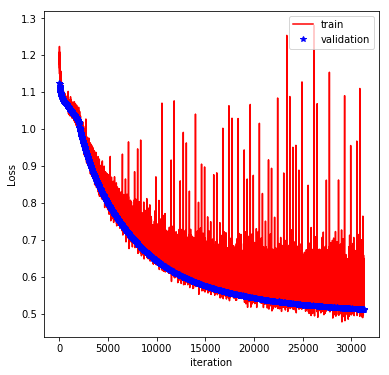

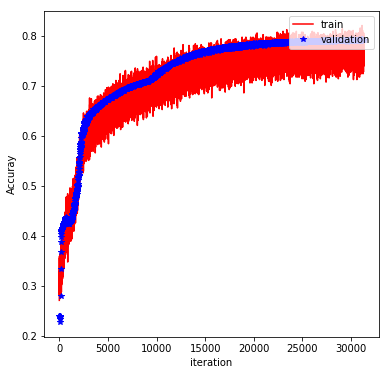

In [3]:
from tensorflow_setup import *
import tensorflow as tf 
import os 
import matplotlib.pyplot as plt
#%matplotlib inline

# filenames used 
traindtfile = 'hdf_500.h5'
testdtfile = 'hdf_500.h5'
losssavefig = 'cnn_train_500_loss.png'
accsavefig = 'cnn_train_500_accuracy.png'
resultsave = 'cnn_train_500.h5'
chkpointdir = 'cnn-500/'

X_tr, X_vld, y_tr, y_vld, list_ch_train = get_tf_train_data(traindtfile)


batch_size = 600       # Batch size
seq_len = 12          # Number of steps
learning_rate = 0.0001
epochs = 100

n_classes = 3 # buy sell and nothing
n_channels = 6 # moving averages

graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

with graph.as_default():
    # (batch, 12, 3) --> (batch, 6, 6)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=6, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_1, (-1, 6*6))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    soft = tf.argmax(logits,1)
    pred = tf.nn.softmax(logits,1)
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


if (os.path.exists('bschkpnt-cnn') == False):
    !mkdir bschkpnt-cnn

validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()


with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1


    saver.save(sess,chkpointdir + "bs.ckpt")


t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+losssavefig)

# change filename here


# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+accsavefig)

del(X_tr, X_vld, y_tr, y_vld, list_ch_train)

X_test, y_test, lab_ch_test = get_tf_test_data(testdtfile)

test_acc = []
probs = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(chkpointdir))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
        prob = sess.run(pred, feed_dict=feed)
        probs.append(prob)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))


# now reshape the probs array
probs = np.array(probs)
probs = probs.reshape((probs.shape[0]*probs.shape[1]), probs.shape[2])
y_test = y_test[:len(probs),:]
# model complete

# save the results

import h5py
hf = h5py.File('h5files/' + resultsave, 'w')
hf.create_dataset('predict_valid', data=probs)
hf.create_dataset('y_test', data = y_test)
hf.close()

del(X_test, y_test, lab_ch_test)


Epoch: 0/100 Iteration: 5 Train loss: 1.234691 Train acc: 0.245000
Epoch: 0/100 Iteration: 10 Train loss: 1.249488 Train acc: 0.221667
Epoch: 0/100 Iteration: 10 Validation loss: 1.215244 Validation acc: 0.238974
Epoch: 0/100 Iteration: 15 Train loss: 1.200639 Train acc: 0.270000
Epoch: 0/100 Iteration: 20 Train loss: 1.222813 Train acc: 0.253333
Epoch: 0/100 Iteration: 20 Validation loss: 1.204978 Validation acc: 0.238985
Epoch: 0/100 Iteration: 25 Train loss: 1.219087 Train acc: 0.241667
Epoch: 0/100 Iteration: 30 Train loss: 1.235466 Train acc: 0.246667
Epoch: 0/100 Iteration: 30 Validation loss: 1.195478 Validation acc: 0.238985
Epoch: 0/100 Iteration: 35 Train loss: 1.184566 Train acc: 0.270000
Epoch: 0/100 Iteration: 40 Train loss: 1.215221 Train acc: 0.210000
Epoch: 0/100 Iteration: 40 Validation loss: 1.186610 Validation acc: 0.238996
Epoch: 0/100 Iteration: 45 Train loss: 1.205378 Train acc: 0.230000
Epoch: 0/100 Iteration: 50 Train loss: 1.198362 Train acc: 0.245000
Epoch: 0/

Epoch: 0/100 Iteration: 390 Validation loss: 1.078655 Validation acc: 0.418996
Epoch: 0/100 Iteration: 395 Train loss: 1.081766 Train acc: 0.360000
Epoch: 0/100 Iteration: 400 Train loss: 1.093603 Train acc: 0.340000
Epoch: 0/100 Iteration: 400 Validation loss: 1.076913 Validation acc: 0.418942
Epoch: 0/100 Iteration: 405 Train loss: 1.074779 Train acc: 0.378333
Epoch: 0/100 Iteration: 410 Train loss: 1.096511 Train acc: 0.310000
Epoch: 0/100 Iteration: 410 Validation loss: 1.075279 Validation acc: 0.418900
Epoch: 0/100 Iteration: 415 Train loss: 1.080431 Train acc: 0.366667
Epoch: 0/100 Iteration: 420 Train loss: 1.082805 Train acc: 0.366667
Epoch: 0/100 Iteration: 420 Validation loss: 1.073817 Validation acc: 0.418921
Epoch: 0/100 Iteration: 425 Train loss: 1.076061 Train acc: 0.353333
Epoch: 0/100 Iteration: 430 Train loss: 1.088207 Train acc: 0.356667
Epoch: 0/100 Iteration: 430 Validation loss: 1.072410 Validation acc: 0.418857
Epoch: 0/100 Iteration: 435 Train loss: 1.083081 Trai

Epoch: 1/100 Iteration: 770 Validation loss: 1.051225 Validation acc: 0.418750
Epoch: 1/100 Iteration: 775 Train loss: 1.071724 Train acc: 0.411667
Epoch: 1/100 Iteration: 780 Train loss: 1.065517 Train acc: 0.388333
Epoch: 1/100 Iteration: 780 Validation loss: 1.050908 Validation acc: 0.418782
Epoch: 1/100 Iteration: 785 Train loss: 1.066842 Train acc: 0.406667
Epoch: 1/100 Iteration: 790 Train loss: 1.066787 Train acc: 0.398333
Epoch: 1/100 Iteration: 790 Validation loss: 1.050713 Validation acc: 0.418782
Epoch: 1/100 Iteration: 795 Train loss: 1.076351 Train acc: 0.383333
Epoch: 1/100 Iteration: 800 Train loss: 1.074753 Train acc: 0.386667
Epoch: 1/100 Iteration: 800 Validation loss: 1.050465 Validation acc: 0.418771
Epoch: 1/100 Iteration: 805 Train loss: 1.058622 Train acc: 0.406667
Epoch: 1/100 Iteration: 810 Train loss: 1.056057 Train acc: 0.426667
Epoch: 1/100 Iteration: 810 Validation loss: 1.050050 Validation acc: 0.418782
Epoch: 1/100 Iteration: 815 Train loss: 1.073078 Trai

Epoch: 2/100 Iteration: 1150 Validation loss: 1.039145 Validation acc: 0.420545
Epoch: 2/100 Iteration: 1155 Train loss: 1.040086 Train acc: 0.435000
Epoch: 2/100 Iteration: 1160 Train loss: 1.053904 Train acc: 0.416667
Epoch: 2/100 Iteration: 1160 Validation loss: 1.038914 Validation acc: 0.420780
Epoch: 2/100 Iteration: 1165 Train loss: 1.024402 Train acc: 0.443333
Epoch: 2/100 Iteration: 1170 Train loss: 1.041152 Train acc: 0.421667
Epoch: 2/100 Iteration: 1170 Validation loss: 1.038688 Validation acc: 0.421026
Epoch: 2/100 Iteration: 1175 Train loss: 1.045295 Train acc: 0.421667
Epoch: 2/100 Iteration: 1180 Train loss: 1.039783 Train acc: 0.435000
Epoch: 2/100 Iteration: 1180 Validation loss: 1.038656 Validation acc: 0.421378
Epoch: 2/100 Iteration: 1185 Train loss: 1.055280 Train acc: 0.396667
Epoch: 2/100 Iteration: 1190 Train loss: 1.027038 Train acc: 0.453333
Epoch: 2/100 Iteration: 1190 Validation loss: 1.038183 Validation acc: 0.421571
Epoch: 2/100 Iteration: 1195 Train loss:

Epoch: 3/100 Iteration: 1530 Validation loss: 1.028717 Validation acc: 0.440641
Epoch: 3/100 Iteration: 1535 Train loss: 1.040272 Train acc: 0.468333
Epoch: 3/100 Iteration: 1540 Train loss: 1.031682 Train acc: 0.465000
Epoch: 3/100 Iteration: 1540 Validation loss: 1.028554 Validation acc: 0.441549
Epoch: 3/100 Iteration: 1545 Train loss: 1.037633 Train acc: 0.488333
Epoch: 3/100 Iteration: 1550 Train loss: 1.025369 Train acc: 0.461667
Epoch: 3/100 Iteration: 1550 Validation loss: 1.028216 Validation acc: 0.442553
Epoch: 3/100 Iteration: 1555 Train loss: 1.028060 Train acc: 0.465000
Epoch: 3/100 Iteration: 1560 Train loss: 1.042669 Train acc: 0.463333
Epoch: 3/100 Iteration: 1560 Validation loss: 1.027708 Validation acc: 0.443248
Epoch: 3/100 Iteration: 1565 Train loss: 1.034659 Train acc: 0.470000
Epoch: 3/100 Iteration: 1570 Train loss: 1.035258 Train acc: 0.481667
Epoch: 3/100 Iteration: 1570 Validation loss: 1.027056 Validation acc: 0.443173
Epoch: 3/100 Iteration: 1575 Train loss:

Epoch: 4/100 Iteration: 1910 Validation loss: 1.017753 Validation acc: 0.489872
Epoch: 4/100 Iteration: 1915 Train loss: 1.055822 Train acc: 0.450000
Epoch: 4/100 Iteration: 1920 Train loss: 1.022223 Train acc: 0.511667
Epoch: 4/100 Iteration: 1920 Validation loss: 1.017382 Validation acc: 0.490940
Epoch: 4/100 Iteration: 1925 Train loss: 1.022247 Train acc: 0.476667
Epoch: 4/100 Iteration: 1930 Train loss: 1.007901 Train acc: 0.511667
Epoch: 4/100 Iteration: 1930 Validation loss: 1.016937 Validation acc: 0.491581
Epoch: 4/100 Iteration: 1935 Train loss: 1.034524 Train acc: 0.486667
Epoch: 4/100 Iteration: 1940 Train loss: 1.121589 Train acc: 0.451667
Epoch: 4/100 Iteration: 1940 Validation loss: 1.016566 Validation acc: 0.492318
Epoch: 4/100 Iteration: 1945 Train loss: 1.013542 Train acc: 0.493333
Epoch: 4/100 Iteration: 1950 Train loss: 1.026956 Train acc: 0.498333
Epoch: 4/100 Iteration: 1950 Validation loss: 1.016387 Validation acc: 0.494391
Epoch: 4/100 Iteration: 1955 Train loss:

Epoch: 4/100 Iteration: 2290 Validation loss: 1.007043 Validation acc: 0.544818
Epoch: 4/100 Iteration: 2295 Train loss: 1.005106 Train acc: 0.541667
Epoch: 4/100 Iteration: 2300 Train loss: 1.001959 Train acc: 0.538333
Epoch: 4/100 Iteration: 2300 Validation loss: 1.006568 Validation acc: 0.544145
Epoch: 4/100 Iteration: 2305 Train loss: 1.041289 Train acc: 0.511667
Epoch: 4/100 Iteration: 2310 Train loss: 1.014487 Train acc: 0.521667
Epoch: 4/100 Iteration: 2310 Validation loss: 1.006138 Validation acc: 0.543665
Epoch: 4/100 Iteration: 2315 Train loss: 1.004593 Train acc: 0.536667
Epoch: 4/100 Iteration: 2320 Train loss: 1.034667 Train acc: 0.493333
Epoch: 4/100 Iteration: 2320 Validation loss: 1.005561 Validation acc: 0.541784
Epoch: 4/100 Iteration: 2325 Train loss: 1.013321 Train acc: 0.548333
Epoch: 4/100 Iteration: 2330 Train loss: 0.997147 Train acc: 0.558333
Epoch: 4/100 Iteration: 2330 Validation loss: 1.005252 Validation acc: 0.542564
Epoch: 4/100 Iteration: 2335 Train loss:

Epoch: 5/100 Iteration: 2670 Validation loss: 0.995420 Validation acc: 0.563013
Epoch: 5/100 Iteration: 2675 Train loss: 1.018367 Train acc: 0.545000
Epoch: 5/100 Iteration: 2680 Train loss: 1.025526 Train acc: 0.496667
Epoch: 5/100 Iteration: 2680 Validation loss: 0.995144 Validation acc: 0.563771
Epoch: 5/100 Iteration: 2685 Train loss: 1.003993 Train acc: 0.550000
Epoch: 5/100 Iteration: 2690 Train loss: 1.003891 Train acc: 0.553333
Epoch: 5/100 Iteration: 2690 Validation loss: 0.994548 Validation acc: 0.561325
Epoch: 5/100 Iteration: 2695 Train loss: 1.023267 Train acc: 0.555000
Epoch: 5/100 Iteration: 2700 Train loss: 1.018479 Train acc: 0.526667
Epoch: 5/100 Iteration: 2700 Validation loss: 0.994101 Validation acc: 0.560320
Epoch: 5/100 Iteration: 2705 Train loss: 0.983949 Train acc: 0.578333
Epoch: 5/100 Iteration: 2710 Train loss: 1.004690 Train acc: 0.556667
Epoch: 5/100 Iteration: 2710 Validation loss: 0.993693 Validation acc: 0.559797
Epoch: 5/100 Iteration: 2715 Train loss:

Epoch: 6/100 Iteration: 3050 Validation loss: 0.983570 Validation acc: 0.573216
Epoch: 6/100 Iteration: 3055 Train loss: 0.986680 Train acc: 0.551667
Epoch: 6/100 Iteration: 3060 Train loss: 0.987511 Train acc: 0.573333
Epoch: 6/100 Iteration: 3060 Validation loss: 0.983491 Validation acc: 0.576068
Epoch: 6/100 Iteration: 3065 Train loss: 0.999190 Train acc: 0.573333
Epoch: 6/100 Iteration: 3070 Train loss: 0.985930 Train acc: 0.576667
Epoch: 6/100 Iteration: 3070 Validation loss: 0.983082 Validation acc: 0.575406
Epoch: 6/100 Iteration: 3075 Train loss: 1.014687 Train acc: 0.545000
Epoch: 6/100 Iteration: 3080 Train loss: 0.994579 Train acc: 0.561667
Epoch: 6/100 Iteration: 3080 Validation loss: 0.982802 Validation acc: 0.575972
Epoch: 6/100 Iteration: 3085 Train loss: 1.007245 Train acc: 0.551667
Epoch: 6/100 Iteration: 3090 Train loss: 0.985488 Train acc: 0.578333
Epoch: 6/100 Iteration: 3090 Validation loss: 0.982486 Validation acc: 0.576314
Epoch: 6/100 Iteration: 3095 Train loss:

Epoch: 7/100 Iteration: 3430 Validation loss: 0.972957 Validation acc: 0.591976
Epoch: 7/100 Iteration: 3435 Train loss: 0.985212 Train acc: 0.545000
Epoch: 7/100 Iteration: 3440 Train loss: 0.989016 Train acc: 0.571667
Epoch: 7/100 Iteration: 3440 Validation loss: 0.972345 Validation acc: 0.589776
Epoch: 7/100 Iteration: 3445 Train loss: 0.982219 Train acc: 0.585000
Epoch: 7/100 Iteration: 3450 Train loss: 0.961806 Train acc: 0.588333
Epoch: 7/100 Iteration: 3450 Validation loss: 0.971517 Validation acc: 0.584679
Epoch: 7/100 Iteration: 3455 Train loss: 0.973840 Train acc: 0.603333
Epoch: 7/100 Iteration: 3460 Train loss: 0.981118 Train acc: 0.578333
Epoch: 7/100 Iteration: 3460 Validation loss: 0.971304 Validation acc: 0.586090
Epoch: 7/100 Iteration: 3465 Train loss: 0.982343 Train acc: 0.568333
Epoch: 7/100 Iteration: 3470 Train loss: 0.984215 Train acc: 0.563333
Epoch: 7/100 Iteration: 3470 Validation loss: 0.971250 Validation acc: 0.588729
Epoch: 7/100 Iteration: 3475 Train loss:

Epoch: 8/100 Iteration: 3810 Validation loss: 0.960634 Validation acc: 0.597810
Epoch: 8/100 Iteration: 3815 Train loss: 0.986318 Train acc: 0.566667
Epoch: 8/100 Iteration: 3820 Train loss: 1.045493 Train acc: 0.545000
Epoch: 8/100 Iteration: 3820 Validation loss: 0.960190 Validation acc: 0.597297
Epoch: 8/100 Iteration: 3825 Train loss: 0.970289 Train acc: 0.591667
Epoch: 8/100 Iteration: 3830 Train loss: 0.970530 Train acc: 0.581667
Epoch: 8/100 Iteration: 3830 Validation loss: 0.960132 Validation acc: 0.599744
Epoch: 8/100 Iteration: 3835 Train loss: 0.967338 Train acc: 0.566667
Epoch: 8/100 Iteration: 3840 Train loss: 0.976084 Train acc: 0.605000
Epoch: 8/100 Iteration: 3840 Validation loss: 0.959747 Validation acc: 0.599637
Epoch: 8/100 Iteration: 3845 Train loss: 0.972237 Train acc: 0.583333
Epoch: 8/100 Iteration: 3850 Train loss: 0.956456 Train acc: 0.618333
Epoch: 8/100 Iteration: 3850 Validation loss: 0.959354 Validation acc: 0.599413
Epoch: 8/100 Iteration: 3855 Train loss:

Epoch: 8/100 Iteration: 4190 Validation loss: 0.946230 Validation acc: 0.613996
Epoch: 8/100 Iteration: 4195 Train loss: 0.940119 Train acc: 0.626667
Epoch: 8/100 Iteration: 4200 Train loss: 0.978436 Train acc: 0.573333
Epoch: 8/100 Iteration: 4200 Validation loss: 0.945445 Validation acc: 0.612393
Epoch: 8/100 Iteration: 4205 Train loss: 0.940816 Train acc: 0.616667
Epoch: 8/100 Iteration: 4210 Train loss: 0.917158 Train acc: 0.653333
Epoch: 8/100 Iteration: 4210 Validation loss: 0.944979 Validation acc: 0.612009
Epoch: 8/100 Iteration: 4215 Train loss: 0.938978 Train acc: 0.610000
Epoch: 8/100 Iteration: 4220 Train loss: 0.947119 Train acc: 0.616667
Epoch: 8/100 Iteration: 4220 Validation loss: 0.944656 Validation acc: 0.612756
Epoch: 8/100 Iteration: 4225 Train loss: 0.953935 Train acc: 0.600000
Epoch: 8/100 Iteration: 4230 Train loss: 0.960352 Train acc: 0.598333
Epoch: 8/100 Iteration: 4230 Validation loss: 0.944187 Validation acc: 0.612372
Epoch: 9/100 Iteration: 4235 Train loss:

Epoch: 9/100 Iteration: 4570 Validation loss: 0.934065 Validation acc: 0.620641
Epoch: 9/100 Iteration: 4575 Train loss: 0.961772 Train acc: 0.625000
Epoch: 9/100 Iteration: 4580 Train loss: 0.971246 Train acc: 0.586667
Epoch: 9/100 Iteration: 4580 Validation loss: 0.933613 Validation acc: 0.620011
Epoch: 9/100 Iteration: 4585 Train loss: 0.906734 Train acc: 0.638333
Epoch: 9/100 Iteration: 4590 Train loss: 0.951081 Train acc: 0.601667
Epoch: 9/100 Iteration: 4590 Validation loss: 0.933438 Validation acc: 0.620727
Epoch: 9/100 Iteration: 4595 Train loss: 0.940469 Train acc: 0.601667
Epoch: 9/100 Iteration: 4600 Train loss: 0.933802 Train acc: 0.606667
Epoch: 9/100 Iteration: 4600 Validation loss: 0.933102 Validation acc: 0.620620
Epoch: 9/100 Iteration: 4605 Train loss: 0.949407 Train acc: 0.590000
Epoch: 9/100 Iteration: 4610 Train loss: 0.957647 Train acc: 0.593333
Epoch: 9/100 Iteration: 4610 Validation loss: 0.932668 Validation acc: 0.620053
Epoch: 9/100 Iteration: 4615 Train loss:

Epoch: 10/100 Iteration: 4940 Validation loss: 0.923881 Validation acc: 0.627393
Epoch: 10/100 Iteration: 4945 Train loss: 0.951347 Train acc: 0.600000
Epoch: 10/100 Iteration: 4950 Train loss: 0.931189 Train acc: 0.630000
Epoch: 10/100 Iteration: 4950 Validation loss: 0.923377 Validation acc: 0.626207
Epoch: 10/100 Iteration: 4955 Train loss: 0.943309 Train acc: 0.591667
Epoch: 10/100 Iteration: 4960 Train loss: 0.933047 Train acc: 0.613333
Epoch: 10/100 Iteration: 4960 Validation loss: 0.923033 Validation acc: 0.626079
Epoch: 10/100 Iteration: 4965 Train loss: 0.957280 Train acc: 0.590000
Epoch: 10/100 Iteration: 4970 Train loss: 0.924524 Train acc: 0.615000
Epoch: 10/100 Iteration: 4970 Validation loss: 0.922932 Validation acc: 0.627115
Epoch: 10/100 Iteration: 4975 Train loss: 0.945768 Train acc: 0.591667
Epoch: 10/100 Iteration: 4980 Train loss: 0.927926 Train acc: 0.623333
Epoch: 10/100 Iteration: 4980 Validation loss: 0.922447 Validation acc: 0.625994
Epoch: 10/100 Iteration: 49

Epoch: 11/100 Iteration: 5310 Validation loss: 0.914381 Validation acc: 0.633643
Epoch: 11/100 Iteration: 5315 Train loss: 0.924642 Train acc: 0.598333
Epoch: 11/100 Iteration: 5320 Train loss: 0.943338 Train acc: 0.596667
Epoch: 11/100 Iteration: 5320 Validation loss: 0.914031 Validation acc: 0.633419
Epoch: 11/100 Iteration: 5325 Train loss: 0.923277 Train acc: 0.626667
Epoch: 11/100 Iteration: 5330 Train loss: 0.917700 Train acc: 0.628333
Epoch: 11/100 Iteration: 5330 Validation loss: 0.912979 Validation acc: 0.630118
Epoch: 11/100 Iteration: 5335 Train loss: 0.925214 Train acc: 0.625000
Epoch: 11/100 Iteration: 5340 Train loss: 0.927908 Train acc: 0.596667
Epoch: 11/100 Iteration: 5340 Validation loss: 0.912784 Validation acc: 0.630556
Epoch: 11/100 Iteration: 5345 Train loss: 0.920385 Train acc: 0.625000
Epoch: 11/100 Iteration: 5350 Train loss: 0.934638 Train acc: 0.603333
Epoch: 11/100 Iteration: 5350 Validation loss: 0.912959 Validation acc: 0.633066
Epoch: 11/100 Iteration: 53

Epoch: 12/100 Iteration: 5680 Validation loss: 0.904141 Validation acc: 0.636378
Epoch: 12/100 Iteration: 5685 Train loss: 0.923423 Train acc: 0.613333
Epoch: 12/100 Iteration: 5690 Train loss: 0.909145 Train acc: 0.608333
Epoch: 12/100 Iteration: 5690 Validation loss: 0.903511 Validation acc: 0.634498
Epoch: 12/100 Iteration: 5695 Train loss: 0.941878 Train acc: 0.601667
Epoch: 12/100 Iteration: 5700 Train loss: 1.104462 Train acc: 0.583333
Epoch: 12/100 Iteration: 5700 Validation loss: 0.903222 Validation acc: 0.634199
Epoch: 12/100 Iteration: 5705 Train loss: 0.919362 Train acc: 0.603333
Epoch: 12/100 Iteration: 5710 Train loss: 0.946995 Train acc: 0.600000
Epoch: 12/100 Iteration: 5710 Validation loss: 0.903465 Validation acc: 0.636923
Epoch: 12/100 Iteration: 5715 Train loss: 0.936589 Train acc: 0.596667
Epoch: 12/100 Iteration: 5720 Train loss: 0.928113 Train acc: 0.625000
Epoch: 12/100 Iteration: 5720 Validation loss: 0.903199 Validation acc: 0.636934
Epoch: 12/100 Iteration: 57

Epoch: 12/100 Iteration: 6050 Validation loss: 0.895571 Validation acc: 0.643344
Epoch: 12/100 Iteration: 6055 Train loss: 0.900444 Train acc: 0.655000
Epoch: 12/100 Iteration: 6060 Train loss: 0.909703 Train acc: 0.616667
Epoch: 12/100 Iteration: 6060 Validation loss: 0.895366 Validation acc: 0.643515
Epoch: 12/100 Iteration: 6065 Train loss: 0.926034 Train acc: 0.603333
Epoch: 12/100 Iteration: 6070 Train loss: 0.929043 Train acc: 0.600000
Epoch: 12/100 Iteration: 6070 Validation loss: 0.895199 Validation acc: 0.643697
Epoch: 12/100 Iteration: 6075 Train loss: 0.897030 Train acc: 0.633333
Epoch: 12/100 Iteration: 6080 Train loss: 0.934190 Train acc: 0.606667
Epoch: 12/100 Iteration: 6080 Validation loss: 0.894138 Validation acc: 0.641549
Epoch: 12/100 Iteration: 6085 Train loss: 1.045091 Train acc: 0.633333
Epoch: 12/100 Iteration: 6090 Train loss: 0.875080 Train acc: 0.675000
Epoch: 12/100 Iteration: 6090 Validation loss: 0.893690 Validation acc: 0.641058
Epoch: 12/100 Iteration: 60

Epoch: 13/100 Iteration: 6420 Validation loss: 0.885611 Validation acc: 0.645214
Epoch: 13/100 Iteration: 6425 Train loss: 0.920692 Train acc: 0.595000
Epoch: 13/100 Iteration: 6430 Train loss: 0.931144 Train acc: 0.591667
Epoch: 13/100 Iteration: 6430 Validation loss: 0.885710 Validation acc: 0.646026
Epoch: 13/100 Iteration: 6435 Train loss: 0.979867 Train acc: 0.566667
Epoch: 13/100 Iteration: 6440 Train loss: 0.942673 Train acc: 0.586667
Epoch: 13/100 Iteration: 6440 Validation loss: 0.885434 Validation acc: 0.646154
Epoch: 13/100 Iteration: 6445 Train loss: 0.902811 Train acc: 0.590000
Epoch: 13/100 Iteration: 6450 Train loss: 0.894903 Train acc: 0.615000
Epoch: 13/100 Iteration: 6450 Validation loss: 0.885071 Validation acc: 0.646154
Epoch: 13/100 Iteration: 6455 Train loss: 0.930618 Train acc: 0.616667
Epoch: 13/100 Iteration: 6460 Train loss: 0.917746 Train acc: 0.610000
Epoch: 13/100 Iteration: 6460 Validation loss: 0.884690 Validation acc: 0.645876
Epoch: 13/100 Iteration: 64

Epoch: 14/100 Iteration: 6790 Validation loss: 0.876372 Validation acc: 0.647521
Epoch: 14/100 Iteration: 6795 Train loss: 0.887397 Train acc: 0.640000
Epoch: 14/100 Iteration: 6800 Train loss: 0.878320 Train acc: 0.625000
Epoch: 14/100 Iteration: 6800 Validation loss: 0.875926 Validation acc: 0.646923
Epoch: 14/100 Iteration: 6805 Train loss: 0.864841 Train acc: 0.663333
Epoch: 14/100 Iteration: 6810 Train loss: 0.870225 Train acc: 0.628333
Epoch: 14/100 Iteration: 6810 Validation loss: 0.875922 Validation acc: 0.647917
Epoch: 14/100 Iteration: 6815 Train loss: 0.883962 Train acc: 0.633333
Epoch: 14/100 Iteration: 6820 Train loss: 0.891024 Train acc: 0.625000
Epoch: 14/100 Iteration: 6820 Validation loss: 0.875987 Validation acc: 0.649338
Epoch: 14/100 Iteration: 6825 Train loss: 0.902658 Train acc: 0.611667
Epoch: 14/100 Iteration: 6830 Train loss: 0.895675 Train acc: 0.645000
Epoch: 14/100 Iteration: 6830 Validation loss: 0.875276 Validation acc: 0.647500
Epoch: 14/100 Iteration: 68

Epoch: 15/100 Iteration: 7160 Validation loss: 0.868611 Validation acc: 0.654103
Epoch: 15/100 Iteration: 7165 Train loss: 0.924242 Train acc: 0.593333
Epoch: 15/100 Iteration: 7170 Train loss: 0.918524 Train acc: 0.586667
Epoch: 15/100 Iteration: 7170 Validation loss: 0.868129 Validation acc: 0.653643
Epoch: 15/100 Iteration: 7175 Train loss: 0.908929 Train acc: 0.588333
Epoch: 15/100 Iteration: 7180 Train loss: 0.885027 Train acc: 0.625000
Epoch: 15/100 Iteration: 7180 Validation loss: 0.867768 Validation acc: 0.653397
Epoch: 15/100 Iteration: 7185 Train loss: 0.885928 Train acc: 0.670000
Epoch: 15/100 Iteration: 7190 Train loss: 0.892335 Train acc: 0.633333
Epoch: 15/100 Iteration: 7190 Validation loss: 0.867489 Validation acc: 0.653269
Epoch: 15/100 Iteration: 7195 Train loss: 0.893759 Train acc: 0.598333
Epoch: 15/100 Iteration: 7200 Train loss: 0.883918 Train acc: 0.633333
Epoch: 15/100 Iteration: 7200 Validation loss: 0.866923 Validation acc: 0.652222
Epoch: 15/100 Iteration: 72

Epoch: 16/100 Iteration: 7530 Validation loss: 0.859372 Validation acc: 0.655534
Epoch: 16/100 Iteration: 7535 Train loss: 0.926763 Train acc: 0.611667
Epoch: 16/100 Iteration: 7540 Train loss: 0.880704 Train acc: 0.620000
Epoch: 16/100 Iteration: 7540 Validation loss: 0.858975 Validation acc: 0.655011
Epoch: 16/100 Iteration: 7545 Train loss: 0.873499 Train acc: 0.641667
Epoch: 16/100 Iteration: 7550 Train loss: 0.881253 Train acc: 0.631667
Epoch: 16/100 Iteration: 7550 Validation loss: 0.859299 Validation acc: 0.656699
Epoch: 16/100 Iteration: 7555 Train loss: 0.919517 Train acc: 0.576667
Epoch: 16/100 Iteration: 7560 Train loss: 0.859552 Train acc: 0.641667
Epoch: 16/100 Iteration: 7560 Validation loss: 0.858763 Validation acc: 0.655897
Epoch: 16/100 Iteration: 7565 Train loss: 0.877632 Train acc: 0.643333
Epoch: 16/100 Iteration: 7570 Train loss: 0.864166 Train acc: 0.646667
Epoch: 16/100 Iteration: 7570 Validation loss: 0.858159 Validation acc: 0.655053
Epoch: 16/100 Iteration: 75

Epoch: 16/100 Iteration: 7900 Validation loss: 0.850862 Validation acc: 0.658611
Epoch: 16/100 Iteration: 7905 Train loss: 0.904970 Train acc: 0.631667
Epoch: 16/100 Iteration: 7910 Train loss: 0.903512 Train acc: 0.620000
Epoch: 16/100 Iteration: 7910 Validation loss: 0.851102 Validation acc: 0.659872
Epoch: 16/100 Iteration: 7915 Train loss: 0.865977 Train acc: 0.633333
Epoch: 16/100 Iteration: 7920 Train loss: 0.904310 Train acc: 0.588333
Epoch: 16/100 Iteration: 7920 Validation loss: 0.851369 Validation acc: 0.660972
Epoch: 16/100 Iteration: 7925 Train loss: 0.883301 Train acc: 0.633333
Epoch: 16/100 Iteration: 7930 Train loss: 0.898662 Train acc: 0.605000
Epoch: 16/100 Iteration: 7930 Validation loss: 0.851460 Validation acc: 0.661378
Epoch: 16/100 Iteration: 7935 Train loss: 0.851944 Train acc: 0.650000
Epoch: 16/100 Iteration: 7940 Train loss: 0.852707 Train acc: 0.638333
Epoch: 16/100 Iteration: 7940 Validation loss: 0.850832 Validation acc: 0.661111
Epoch: 16/100 Iteration: 79

Epoch: 17/100 Iteration: 8270 Validation loss: 0.843286 Validation acc: 0.663141
Epoch: 17/100 Iteration: 8275 Train loss: 0.902583 Train acc: 0.606667
Epoch: 17/100 Iteration: 8280 Train loss: 0.843523 Train acc: 0.673333
Epoch: 17/100 Iteration: 8280 Validation loss: 0.842735 Validation acc: 0.662308
Epoch: 17/100 Iteration: 8285 Train loss: 0.886499 Train acc: 0.606667
Epoch: 17/100 Iteration: 8290 Train loss: 0.869592 Train acc: 0.630000
Epoch: 17/100 Iteration: 8290 Validation loss: 0.842347 Validation acc: 0.662062
Epoch: 17/100 Iteration: 8295 Train loss: 0.907346 Train acc: 0.626667
Epoch: 17/100 Iteration: 8300 Train loss: 0.842047 Train acc: 0.650000
Epoch: 17/100 Iteration: 8300 Validation loss: 0.842281 Validation acc: 0.662468
Epoch: 17/100 Iteration: 8305 Train loss: 0.874276 Train acc: 0.636667
Epoch: 17/100 Iteration: 8310 Train loss: 0.892961 Train acc: 0.623333
Epoch: 17/100 Iteration: 8310 Validation loss: 0.842378 Validation acc: 0.663472
Epoch: 17/100 Iteration: 83

Epoch: 18/100 Iteration: 8640 Validation loss: 0.835624 Validation acc: 0.667030
Epoch: 18/100 Iteration: 8645 Train loss: 0.862043 Train acc: 0.620000
Epoch: 18/100 Iteration: 8650 Train loss: 0.862205 Train acc: 0.616667
Epoch: 18/100 Iteration: 8650 Validation loss: 0.834871 Validation acc: 0.666165
Epoch: 18/100 Iteration: 8655 Train loss: 0.898093 Train acc: 0.636667
Epoch: 18/100 Iteration: 8660 Train loss: 0.852000 Train acc: 0.640000
Epoch: 18/100 Iteration: 8660 Validation loss: 0.833994 Validation acc: 0.664647
Epoch: 18/100 Iteration: 8665 Train loss: 0.827309 Train acc: 0.658333
Epoch: 18/100 Iteration: 8670 Train loss: 0.848197 Train acc: 0.655000
Epoch: 18/100 Iteration: 8670 Validation loss: 0.833864 Validation acc: 0.664904
Epoch: 18/100 Iteration: 8675 Train loss: 0.868508 Train acc: 0.636667
Epoch: 18/100 Iteration: 8680 Train loss: 0.873894 Train acc: 0.641667
Epoch: 18/100 Iteration: 8680 Validation loss: 0.833817 Validation acc: 0.665502
Epoch: 18/100 Iteration: 86

Epoch: 19/100 Iteration: 9010 Validation loss: 0.827227 Validation acc: 0.669188
Epoch: 19/100 Iteration: 9015 Train loss: 0.838186 Train acc: 0.630000
Epoch: 19/100 Iteration: 9020 Train loss: 0.830665 Train acc: 0.660000
Epoch: 19/100 Iteration: 9020 Validation loss: 0.826530 Validation acc: 0.668066
Epoch: 19/100 Iteration: 9025 Train loss: 0.858516 Train acc: 0.636667
Epoch: 19/100 Iteration: 9030 Train loss: 0.879724 Train acc: 0.641667
Epoch: 19/100 Iteration: 9030 Validation loss: 0.826041 Validation acc: 0.667479
Epoch: 19/100 Iteration: 9035 Train loss: 0.845362 Train acc: 0.625000
Epoch: 19/100 Iteration: 9040 Train loss: 0.866771 Train acc: 0.606667
Epoch: 19/100 Iteration: 9040 Validation loss: 0.826301 Validation acc: 0.668921
Epoch: 19/100 Iteration: 9045 Train loss: 0.860450 Train acc: 0.603333
Epoch: 19/100 Iteration: 9050 Train loss: 0.886646 Train acc: 0.613333
Epoch: 19/100 Iteration: 9050 Validation loss: 0.826142 Validation acc: 0.669177
Epoch: 19/100 Iteration: 90

Epoch: 19/100 Iteration: 9380 Validation loss: 0.819431 Validation acc: 0.672073
Epoch: 19/100 Iteration: 9385 Train loss: 0.830863 Train acc: 0.653333
Epoch: 19/100 Iteration: 9390 Train loss: 0.832622 Train acc: 0.668333
Epoch: 19/100 Iteration: 9390 Validation loss: 0.819847 Validation acc: 0.672991
Epoch: 19/100 Iteration: 9395 Train loss: 0.842263 Train acc: 0.646667
Epoch: 19/100 Iteration: 9400 Train loss: 0.855304 Train acc: 0.656667
Epoch: 19/100 Iteration: 9400 Validation loss: 0.819561 Validation acc: 0.673002
Epoch: 20/100 Iteration: 9405 Train loss: 0.861168 Train acc: 0.623333
Epoch: 20/100 Iteration: 9410 Train loss: 0.914066 Train acc: 0.631667
Epoch: 20/100 Iteration: 9410 Validation loss: 0.818877 Validation acc: 0.672543
Epoch: 20/100 Iteration: 9415 Train loss: 0.932017 Train acc: 0.613333
Epoch: 20/100 Iteration: 9420 Train loss: 0.913555 Train acc: 0.653333
Epoch: 20/100 Iteration: 9420 Validation loss: 0.818380 Validation acc: 0.671998
Epoch: 20/100 Iteration: 94

Epoch: 20/100 Iteration: 9750 Validation loss: 0.811799 Validation acc: 0.674808
Epoch: 20/100 Iteration: 9755 Train loss: 0.799722 Train acc: 0.668333
Epoch: 20/100 Iteration: 9760 Train loss: 0.855274 Train acc: 0.621667
Epoch: 20/100 Iteration: 9760 Validation loss: 0.811825 Validation acc: 0.675288
Epoch: 20/100 Iteration: 9765 Train loss: 0.821860 Train acc: 0.645000
Epoch: 20/100 Iteration: 9770 Train loss: 0.818535 Train acc: 0.656667
Epoch: 20/100 Iteration: 9770 Validation loss: 0.811364 Validation acc: 0.674893
Epoch: 20/100 Iteration: 9775 Train loss: 0.828049 Train acc: 0.648333
Epoch: 20/100 Iteration: 9780 Train loss: 0.858609 Train acc: 0.636667
Epoch: 20/100 Iteration: 9780 Validation loss: 0.810894 Validation acc: 0.673942
Epoch: 20/100 Iteration: 9785 Train loss: 0.869488 Train acc: 0.638333
Epoch: 20/100 Iteration: 9790 Train loss: 0.861691 Train acc: 0.638333
Epoch: 20/100 Iteration: 9790 Validation loss: 0.811241 Validation acc: 0.675449
Epoch: 20/100 Iteration: 97

Epoch: 21/100 Iteration: 10120 Validation loss: 0.804170 Validation acc: 0.676998
Epoch: 21/100 Iteration: 10125 Train loss: 0.833712 Train acc: 0.620000
Epoch: 21/100 Iteration: 10130 Train loss: 0.819954 Train acc: 0.663333
Epoch: 21/100 Iteration: 10130 Validation loss: 0.803922 Validation acc: 0.676955
Epoch: 21/100 Iteration: 10135 Train loss: 0.856340 Train acc: 0.623333
Epoch: 21/100 Iteration: 10140 Train loss: 0.838663 Train acc: 0.656667
Epoch: 21/100 Iteration: 10140 Validation loss: 0.803889 Validation acc: 0.677500
Epoch: 21/100 Iteration: 10145 Train loss: 0.846197 Train acc: 0.613333
Epoch: 21/100 Iteration: 10150 Train loss: 0.824175 Train acc: 0.646667
Epoch: 21/100 Iteration: 10150 Validation loss: 0.803623 Validation acc: 0.677404
Epoch: 21/100 Iteration: 10155 Train loss: 0.868548 Train acc: 0.626667
Epoch: 21/100 Iteration: 10160 Train loss: 0.800790 Train acc: 0.693333
Epoch: 21/100 Iteration: 10160 Validation loss: 0.803350 Validation acc: 0.677276
Epoch: 21/100 

Epoch: 22/100 Iteration: 10490 Validation loss: 0.797423 Validation acc: 0.680139
Epoch: 22/100 Iteration: 10495 Train loss: 0.827186 Train acc: 0.648333
Epoch: 22/100 Iteration: 10500 Train loss: 0.824409 Train acc: 0.668333
Epoch: 22/100 Iteration: 10500 Validation loss: 0.796651 Validation acc: 0.679103
Epoch: 22/100 Iteration: 10505 Train loss: 0.844356 Train acc: 0.676667
Epoch: 22/100 Iteration: 10510 Train loss: 0.834407 Train acc: 0.638333
Epoch: 22/100 Iteration: 10510 Validation loss: 0.797221 Validation acc: 0.680427
Epoch: 22/100 Iteration: 10515 Train loss: 0.818019 Train acc: 0.696667
Epoch: 22/100 Iteration: 10520 Train loss: 0.838543 Train acc: 0.648333
Epoch: 22/100 Iteration: 10520 Validation loss: 0.797843 Validation acc: 0.681015
Epoch: 22/100 Iteration: 10525 Train loss: 0.846931 Train acc: 0.653333
Epoch: 22/100 Iteration: 10530 Train loss: 0.857780 Train acc: 0.615000
Epoch: 22/100 Iteration: 10530 Validation loss: 0.796949 Validation acc: 0.680694
Epoch: 22/100 

Epoch: 23/100 Iteration: 10860 Validation loss: 0.789785 Validation acc: 0.681560
Epoch: 23/100 Iteration: 10865 Train loss: 0.822386 Train acc: 0.648333
Epoch: 23/100 Iteration: 10870 Train loss: 1.028219 Train acc: 0.626667
Epoch: 23/100 Iteration: 10870 Validation loss: 0.789361 Validation acc: 0.681068
Epoch: 23/100 Iteration: 10875 Train loss: 0.816429 Train acc: 0.663333
Epoch: 23/100 Iteration: 10880 Train loss: 0.834493 Train acc: 0.651667
Epoch: 23/100 Iteration: 10880 Validation loss: 0.789696 Validation acc: 0.682212
Epoch: 23/100 Iteration: 10885 Train loss: 0.801881 Train acc: 0.646667
Epoch: 23/100 Iteration: 10890 Train loss: 0.863876 Train acc: 0.676667
Epoch: 23/100 Iteration: 10890 Validation loss: 0.789823 Validation acc: 0.682553
Epoch: 23/100 Iteration: 10895 Train loss: 0.816111 Train acc: 0.640000
Epoch: 23/100 Iteration: 10900 Train loss: 0.794285 Train acc: 0.658333
Epoch: 23/100 Iteration: 10900 Validation loss: 0.789256 Validation acc: 0.682340
Epoch: 23/100 

Epoch: 23/100 Iteration: 11230 Validation loss: 0.783611 Validation acc: 0.685150
Epoch: 23/100 Iteration: 11235 Train loss: 0.832882 Train acc: 0.623333
Epoch: 23/100 Iteration: 11240 Train loss: 0.844235 Train acc: 0.615000
Epoch: 23/100 Iteration: 11240 Validation loss: 0.783450 Validation acc: 0.685406
Epoch: 23/100 Iteration: 11245 Train loss: 0.783726 Train acc: 0.678333
Epoch: 23/100 Iteration: 11250 Train loss: 0.847346 Train acc: 0.616667
Epoch: 23/100 Iteration: 11250 Validation loss: 0.782987 Validation acc: 0.685032
Epoch: 23/100 Iteration: 11255 Train loss: 1.121719 Train acc: 0.668333
Epoch: 23/100 Iteration: 11260 Train loss: 0.764463 Train acc: 0.701667
Epoch: 23/100 Iteration: 11260 Validation loss: 0.783405 Validation acc: 0.686026
Epoch: 23/100 Iteration: 11265 Train loss: 0.799313 Train acc: 0.666667
Epoch: 23/100 Iteration: 11270 Train loss: 0.805556 Train acc: 0.660000
Epoch: 23/100 Iteration: 11270 Validation loss: 0.783496 Validation acc: 0.686047
Epoch: 23/100 

Epoch: 24/100 Iteration: 11600 Validation loss: 0.777122 Validation acc: 0.687521
Epoch: 24/100 Iteration: 11605 Train loss: 0.818337 Train acc: 0.625000
Epoch: 24/100 Iteration: 11610 Train loss: 0.838632 Train acc: 0.630000
Epoch: 24/100 Iteration: 11610 Validation loss: 0.776893 Validation acc: 0.687532
Epoch: 24/100 Iteration: 11615 Train loss: 0.800666 Train acc: 0.650000
Epoch: 24/100 Iteration: 11620 Train loss: 0.787108 Train acc: 0.671667
Epoch: 24/100 Iteration: 11620 Validation loss: 0.776515 Validation acc: 0.687222
Epoch: 24/100 Iteration: 11625 Train loss: 0.802509 Train acc: 0.680000
Epoch: 24/100 Iteration: 11630 Train loss: 0.846303 Train acc: 0.625000
Epoch: 24/100 Iteration: 11630 Validation loss: 0.776269 Validation acc: 0.687115
Epoch: 24/100 Iteration: 11635 Train loss: 0.763217 Train acc: 0.680000
Epoch: 24/100 Iteration: 11640 Train loss: 0.808520 Train acc: 0.653333
Epoch: 24/100 Iteration: 11640 Validation loss: 0.776285 Validation acc: 0.687511
Epoch: 24/100 

Epoch: 25/100 Iteration: 11970 Validation loss: 0.770238 Validation acc: 0.688515
Epoch: 25/100 Iteration: 11975 Train loss: 0.760709 Train acc: 0.701667
Epoch: 25/100 Iteration: 11980 Train loss: 0.801714 Train acc: 0.650000
Epoch: 25/100 Iteration: 11980 Validation loss: 0.769968 Validation acc: 0.688462
Epoch: 25/100 Iteration: 11985 Train loss: 0.806321 Train acc: 0.638333
Epoch: 25/100 Iteration: 11990 Train loss: 0.809581 Train acc: 0.650000
Epoch: 25/100 Iteration: 11990 Validation loss: 0.770486 Validation acc: 0.689712
Epoch: 25/100 Iteration: 11995 Train loss: 0.793804 Train acc: 0.673333
Epoch: 25/100 Iteration: 12000 Train loss: 0.794549 Train acc: 0.681667
Epoch: 25/100 Iteration: 12000 Validation loss: 0.769842 Validation acc: 0.688942
Epoch: 25/100 Iteration: 12005 Train loss: 0.816726 Train acc: 0.636667
Epoch: 25/100 Iteration: 12010 Train loss: 0.790405 Train acc: 0.648333
Epoch: 25/100 Iteration: 12010 Validation loss: 0.769413 Validation acc: 0.688483
Epoch: 25/100 

Epoch: 26/100 Iteration: 12340 Validation loss: 0.764333 Validation acc: 0.691303
Epoch: 26/100 Iteration: 12345 Train loss: 0.805954 Train acc: 0.643333
Epoch: 26/100 Iteration: 12350 Train loss: 0.767551 Train acc: 0.665000
Epoch: 26/100 Iteration: 12350 Validation loss: 0.763879 Validation acc: 0.690641
Epoch: 26/100 Iteration: 12355 Train loss: 0.790082 Train acc: 0.683333
Epoch: 26/100 Iteration: 12360 Train loss: 0.784832 Train acc: 0.655000
Epoch: 26/100 Iteration: 12360 Validation loss: 0.763817 Validation acc: 0.690994
Epoch: 26/100 Iteration: 12365 Train loss: 0.791993 Train acc: 0.651667
Epoch: 26/100 Iteration: 12370 Train loss: 0.793653 Train acc: 0.655000
Epoch: 26/100 Iteration: 12370 Validation loss: 0.763579 Validation acc: 0.690855
Epoch: 26/100 Iteration: 12375 Train loss: 0.786638 Train acc: 0.668333
Epoch: 26/100 Iteration: 12380 Train loss: 0.769231 Train acc: 0.690000
Epoch: 26/100 Iteration: 12380 Validation loss: 0.762905 Validation acc: 0.689979
Epoch: 26/100 

Epoch: 27/100 Iteration: 12710 Validation loss: 0.757650 Validation acc: 0.692190
Epoch: 27/100 Iteration: 12715 Train loss: 0.784020 Train acc: 0.661667
Epoch: 27/100 Iteration: 12720 Train loss: 0.782232 Train acc: 0.673333
Epoch: 27/100 Iteration: 12720 Validation loss: 0.757955 Validation acc: 0.693130
Epoch: 27/100 Iteration: 12725 Train loss: 0.836779 Train acc: 0.618333
Epoch: 27/100 Iteration: 12730 Train loss: 0.780964 Train acc: 0.668333
Epoch: 27/100 Iteration: 12730 Validation loss: 0.757773 Validation acc: 0.693120
Epoch: 27/100 Iteration: 12735 Train loss: 0.789585 Train acc: 0.665000
Epoch: 27/100 Iteration: 12740 Train loss: 0.764713 Train acc: 0.658333
Epoch: 27/100 Iteration: 12740 Validation loss: 0.757189 Validation acc: 0.692147
Epoch: 27/100 Iteration: 12745 Train loss: 0.801237 Train acc: 0.668333
Epoch: 27/100 Iteration: 12750 Train loss: 0.933453 Train acc: 0.636667
Epoch: 27/100 Iteration: 12750 Validation loss: 0.756898 Validation acc: 0.691880
Epoch: 27/100 

Epoch: 27/100 Iteration: 13080 Validation loss: 0.752936 Validation acc: 0.695577
Epoch: 27/100 Iteration: 13085 Train loss: 0.789030 Train acc: 0.671667
Epoch: 27/100 Iteration: 13090 Train loss: 0.810538 Train acc: 0.625000
Epoch: 27/100 Iteration: 13090 Validation loss: 0.752460 Validation acc: 0.695310
Epoch: 27/100 Iteration: 13095 Train loss: 0.790470 Train acc: 0.665000
Epoch: 27/100 Iteration: 13100 Train loss: 0.808922 Train acc: 0.641667
Epoch: 27/100 Iteration: 13100 Validation loss: 0.751938 Validation acc: 0.694679
Epoch: 27/100 Iteration: 13105 Train loss: 0.749617 Train acc: 0.700000
Epoch: 27/100 Iteration: 13110 Train loss: 0.794110 Train acc: 0.678333
Epoch: 27/100 Iteration: 13110 Validation loss: 0.752037 Validation acc: 0.695342
Epoch: 27/100 Iteration: 13115 Train loss: 0.828451 Train acc: 0.633333
Epoch: 27/100 Iteration: 13120 Train loss: 0.829997 Train acc: 0.630000
Epoch: 27/100 Iteration: 13120 Validation loss: 0.752196 Validation acc: 0.695662
Epoch: 27/100 

Epoch: 28/100 Iteration: 13450 Validation loss: 0.746310 Validation acc: 0.695427
Epoch: 28/100 Iteration: 13455 Train loss: 0.788368 Train acc: 0.641667
Epoch: 28/100 Iteration: 13460 Train loss: 0.789532 Train acc: 0.651667
Epoch: 28/100 Iteration: 13460 Validation loss: 0.746209 Validation acc: 0.695694
Epoch: 28/100 Iteration: 13465 Train loss: 0.817901 Train acc: 0.673333
Epoch: 28/100 Iteration: 13470 Train loss: 0.766192 Train acc: 0.681667
Epoch: 28/100 Iteration: 13470 Validation loss: 0.746162 Validation acc: 0.695951
Epoch: 28/100 Iteration: 13475 Train loss: 0.798458 Train acc: 0.641667
Epoch: 28/100 Iteration: 13480 Train loss: 0.787540 Train acc: 0.646667
Epoch: 28/100 Iteration: 13480 Validation loss: 0.746797 Validation acc: 0.697222
Epoch: 28/100 Iteration: 13485 Train loss: 0.784969 Train acc: 0.628333
Epoch: 28/100 Iteration: 13490 Train loss: 0.807552 Train acc: 0.635000
Epoch: 28/100 Iteration: 13490 Validation loss: 0.746886 Validation acc: 0.697468
Epoch: 28/100 

Epoch: 29/100 Iteration: 13820 Validation loss: 0.741819 Validation acc: 0.698835
Epoch: 29/100 Iteration: 13825 Train loss: 0.821775 Train acc: 0.675000
Epoch: 29/100 Iteration: 13830 Train loss: 0.751494 Train acc: 0.670000
Epoch: 29/100 Iteration: 13830 Validation loss: 0.740894 Validation acc: 0.697660
Epoch: 29/100 Iteration: 13835 Train loss: 0.753657 Train acc: 0.693333
Epoch: 29/100 Iteration: 13840 Train loss: 0.767396 Train acc: 0.666667
Epoch: 29/100 Iteration: 13840 Validation loss: 0.740911 Validation acc: 0.698002
Epoch: 29/100 Iteration: 13845 Train loss: 0.803962 Train acc: 0.650000
Epoch: 29/100 Iteration: 13850 Train loss: 0.782245 Train acc: 0.651667
Epoch: 29/100 Iteration: 13850 Validation loss: 0.740976 Validation acc: 0.698462
Epoch: 29/100 Iteration: 13855 Train loss: 0.739802 Train acc: 0.690000
Epoch: 29/100 Iteration: 13860 Train loss: 0.775935 Train acc: 0.666667
Epoch: 29/100 Iteration: 13860 Validation loss: 0.740474 Validation acc: 0.697895
Epoch: 29/100 

Epoch: 30/100 Iteration: 14190 Validation loss: 0.735712 Validation acc: 0.699071
Epoch: 30/100 Iteration: 14195 Train loss: 0.766292 Train acc: 0.648333
Epoch: 30/100 Iteration: 14200 Train loss: 0.794398 Train acc: 0.638333
Epoch: 30/100 Iteration: 14200 Validation loss: 0.735645 Validation acc: 0.699274
Epoch: 30/100 Iteration: 14205 Train loss: 0.767264 Train acc: 0.656667
Epoch: 30/100 Iteration: 14210 Train loss: 0.786017 Train acc: 0.646667
Epoch: 30/100 Iteration: 14210 Validation loss: 0.736001 Validation acc: 0.699818
Epoch: 30/100 Iteration: 14215 Train loss: 0.802805 Train acc: 0.640000
Epoch: 30/100 Iteration: 14220 Train loss: 0.812746 Train acc: 0.651667
Epoch: 30/100 Iteration: 14220 Validation loss: 0.735738 Validation acc: 0.699701
Epoch: 30/100 Iteration: 14225 Train loss: 0.802767 Train acc: 0.635000
Epoch: 30/100 Iteration: 14230 Train loss: 0.744019 Train acc: 0.680000
Epoch: 30/100 Iteration: 14230 Validation loss: 0.735248 Validation acc: 0.699444
Epoch: 30/100 

Epoch: 30/100 Iteration: 14560 Validation loss: 0.732266 Validation acc: 0.701378
Epoch: 30/100 Iteration: 14565 Train loss: 0.770846 Train acc: 0.675000
Epoch: 30/100 Iteration: 14570 Train loss: 0.779921 Train acc: 0.670000
Epoch: 30/100 Iteration: 14570 Validation loss: 0.731336 Validation acc: 0.701453
Epoch: 31/100 Iteration: 14575 Train loss: 0.781436 Train acc: 0.643333
Epoch: 31/100 Iteration: 14580 Train loss: 0.870024 Train acc: 0.670000
Epoch: 31/100 Iteration: 14580 Validation loss: 0.730433 Validation acc: 0.700780
Epoch: 31/100 Iteration: 14585 Train loss: 0.821975 Train acc: 0.626667
Epoch: 31/100 Iteration: 14590 Train loss: 0.804657 Train acc: 0.661667
Epoch: 31/100 Iteration: 14590 Validation loss: 0.730011 Validation acc: 0.700107
Epoch: 31/100 Iteration: 14595 Train loss: 0.756804 Train acc: 0.683333
Epoch: 31/100 Iteration: 14600 Train loss: 0.771987 Train acc: 0.675000
Epoch: 31/100 Iteration: 14600 Validation loss: 0.730493 Validation acc: 0.701122
Epoch: 31/100 

Epoch: 31/100 Iteration: 14930 Validation loss: 0.726335 Validation acc: 0.702436
Epoch: 31/100 Iteration: 14935 Train loss: 0.771176 Train acc: 0.655000
Epoch: 31/100 Iteration: 14940 Train loss: 0.767649 Train acc: 0.680000
Epoch: 31/100 Iteration: 14940 Validation loss: 0.725811 Validation acc: 0.702094
Epoch: 31/100 Iteration: 14945 Train loss: 0.769178 Train acc: 0.658333
Epoch: 31/100 Iteration: 14950 Train loss: 0.764855 Train acc: 0.650000
Epoch: 31/100 Iteration: 14950 Validation loss: 0.725525 Validation acc: 0.701891
Epoch: 31/100 Iteration: 14955 Train loss: 0.783279 Train acc: 0.666667
Epoch: 31/100 Iteration: 14960 Train loss: 0.787785 Train acc: 0.661667
Epoch: 31/100 Iteration: 14960 Validation loss: 0.725617 Validation acc: 0.702244
Epoch: 31/100 Iteration: 14965 Train loss: 0.779190 Train acc: 0.676667
Epoch: 31/100 Iteration: 14970 Train loss: 0.780047 Train acc: 0.626667
Epoch: 31/100 Iteration: 14970 Validation loss: 0.725702 Validation acc: 0.702468
Epoch: 31/100 

Epoch: 32/100 Iteration: 15300 Validation loss: 0.721215 Validation acc: 0.703109
Epoch: 32/100 Iteration: 15305 Train loss: 0.777270 Train acc: 0.646667
Epoch: 32/100 Iteration: 15310 Train loss: 0.756283 Train acc: 0.680000
Epoch: 32/100 Iteration: 15310 Validation loss: 0.721848 Validation acc: 0.703942
Epoch: 32/100 Iteration: 15315 Train loss: 0.764265 Train acc: 0.658333
Epoch: 32/100 Iteration: 15320 Train loss: 0.750617 Train acc: 0.676667
Epoch: 32/100 Iteration: 15320 Validation loss: 0.721531 Validation acc: 0.703750
Epoch: 32/100 Iteration: 15325 Train loss: 0.808878 Train acc: 0.658333
Epoch: 32/100 Iteration: 15330 Train loss: 0.732012 Train acc: 0.701667
Epoch: 32/100 Iteration: 15330 Validation loss: 0.720556 Validation acc: 0.702350
Epoch: 32/100 Iteration: 15335 Train loss: 0.790482 Train acc: 0.655000
Epoch: 32/100 Iteration: 15340 Train loss: 0.779070 Train acc: 0.643333
Epoch: 32/100 Iteration: 15340 Validation loss: 0.720634 Validation acc: 0.702820
Epoch: 32/100 

Epoch: 33/100 Iteration: 15670 Validation loss: 0.716338 Validation acc: 0.703558
Epoch: 33/100 Iteration: 15675 Train loss: 0.764908 Train acc: 0.690000
Epoch: 33/100 Iteration: 15680 Train loss: 0.773903 Train acc: 0.653333
Epoch: 33/100 Iteration: 15680 Validation loss: 0.716795 Validation acc: 0.704583
Epoch: 33/100 Iteration: 15685 Train loss: 0.747607 Train acc: 0.691667
Epoch: 33/100 Iteration: 15690 Train loss: 0.767586 Train acc: 0.686667
Epoch: 33/100 Iteration: 15690 Validation loss: 0.717455 Validation acc: 0.705171
Epoch: 33/100 Iteration: 15695 Train loss: 0.793598 Train acc: 0.651667
Epoch: 33/100 Iteration: 15700 Train loss: 0.774719 Train acc: 0.661667
Epoch: 33/100 Iteration: 15700 Validation loss: 0.716696 Validation acc: 0.704786
Epoch: 33/100 Iteration: 15705 Train loss: 0.772472 Train acc: 0.666667
Epoch: 33/100 Iteration: 15710 Train loss: 0.737794 Train acc: 0.686667
Epoch: 33/100 Iteration: 15710 Validation loss: 0.715971 Validation acc: 0.703868
Epoch: 33/100 

Epoch: 34/100 Iteration: 16040 Validation loss: 0.711973 Validation acc: 0.704412
Epoch: 34/100 Iteration: 16045 Train loss: 0.751648 Train acc: 0.670000
Epoch: 34/100 Iteration: 16050 Train loss: 0.733127 Train acc: 0.681667
Epoch: 34/100 Iteration: 16050 Validation loss: 0.713049 Validation acc: 0.705865
Epoch: 34/100 Iteration: 16055 Train loss: 0.747038 Train acc: 0.680000
Epoch: 34/100 Iteration: 16060 Train loss: 0.758499 Train acc: 0.680000
Epoch: 34/100 Iteration: 16060 Validation loss: 0.712377 Validation acc: 0.705502
Epoch: 34/100 Iteration: 16065 Train loss: 0.767976 Train acc: 0.646667
Epoch: 34/100 Iteration: 16070 Train loss: 0.738087 Train acc: 0.700000
Epoch: 34/100 Iteration: 16070 Validation loss: 0.711704 Validation acc: 0.704872
Epoch: 34/100 Iteration: 16075 Train loss: 0.741123 Train acc: 0.678333
Epoch: 34/100 Iteration: 16080 Train loss: 0.784943 Train acc: 0.661667
Epoch: 34/100 Iteration: 16080 Validation loss: 0.712096 Validation acc: 0.705502
Epoch: 34/100 

Epoch: 34/100 Iteration: 16410 Validation loss: 0.708821 Validation acc: 0.706880
Epoch: 34/100 Iteration: 16415 Train loss: 0.705701 Train acc: 0.700000
Epoch: 34/100 Iteration: 16420 Train loss: 0.777616 Train acc: 0.645000
Epoch: 34/100 Iteration: 16420 Validation loss: 0.708246 Validation acc: 0.706699
Epoch: 34/100 Iteration: 16425 Train loss: 1.008839 Train acc: 0.691667
Epoch: 34/100 Iteration: 16430 Train loss: 0.709769 Train acc: 0.720000
Epoch: 34/100 Iteration: 16430 Validation loss: 0.709089 Validation acc: 0.706827
Epoch: 34/100 Iteration: 16435 Train loss: 0.736090 Train acc: 0.690000
Epoch: 34/100 Iteration: 16440 Train loss: 0.725459 Train acc: 0.700000
Epoch: 34/100 Iteration: 16440 Validation loss: 0.708842 Validation acc: 0.706880
Epoch: 34/100 Iteration: 16445 Train loss: 0.727946 Train acc: 0.691667
Epoch: 34/100 Iteration: 16450 Train loss: 0.779891 Train acc: 0.651667
Epoch: 34/100 Iteration: 16450 Validation loss: 0.707740 Validation acc: 0.706517
Epoch: 35/100 

Epoch: 35/100 Iteration: 16780 Validation loss: 0.705064 Validation acc: 0.707724
Epoch: 35/100 Iteration: 16785 Train loss: 0.750147 Train acc: 0.653333
Epoch: 35/100 Iteration: 16790 Train loss: 0.742155 Train acc: 0.671667
Epoch: 35/100 Iteration: 16790 Validation loss: 0.704433 Validation acc: 0.707532
Epoch: 35/100 Iteration: 16795 Train loss: 0.764029 Train acc: 0.693333
Epoch: 35/100 Iteration: 16800 Train loss: 0.796398 Train acc: 0.645000
Epoch: 35/100 Iteration: 16800 Validation loss: 0.704042 Validation acc: 0.707404
Epoch: 35/100 Iteration: 16805 Train loss: 0.708360 Train acc: 0.693333
Epoch: 35/100 Iteration: 16810 Train loss: 0.748071 Train acc: 0.678333
Epoch: 35/100 Iteration: 16810 Validation loss: 0.704427 Validation acc: 0.707692
Epoch: 35/100 Iteration: 16815 Train loss: 0.750660 Train acc: 0.685000
Epoch: 35/100 Iteration: 16820 Train loss: 0.725262 Train acc: 0.698333
Epoch: 35/100 Iteration: 16820 Validation loss: 0.703843 Validation acc: 0.707479
Epoch: 35/100 

Epoch: 36/100 Iteration: 17150 Validation loss: 0.700242 Validation acc: 0.708130
Epoch: 36/100 Iteration: 17155 Train loss: 0.731639 Train acc: 0.686667
Epoch: 36/100 Iteration: 17160 Train loss: 0.752581 Train acc: 0.675000
Epoch: 36/100 Iteration: 17160 Validation loss: 0.700712 Validation acc: 0.708547
Epoch: 36/100 Iteration: 17165 Train loss: 0.737874 Train acc: 0.681667
Epoch: 36/100 Iteration: 17170 Train loss: 0.743872 Train acc: 0.675000
Epoch: 36/100 Iteration: 17170 Validation loss: 0.699943 Validation acc: 0.708066
Epoch: 36/100 Iteration: 17175 Train loss: 0.759570 Train acc: 0.646667
Epoch: 36/100 Iteration: 17180 Train loss: 0.750221 Train acc: 0.660000
Epoch: 36/100 Iteration: 17180 Validation loss: 0.699961 Validation acc: 0.708227
Epoch: 36/100 Iteration: 17185 Train loss: 0.760799 Train acc: 0.656667
Epoch: 36/100 Iteration: 17190 Train loss: 0.717414 Train acc: 0.685000
Epoch: 36/100 Iteration: 17190 Validation loss: 0.700242 Validation acc: 0.708440
Epoch: 36/100 

Epoch: 37/100 Iteration: 17520 Validation loss: 0.696162 Validation acc: 0.707981
Epoch: 37/100 Iteration: 17525 Train loss: 0.735905 Train acc: 0.701667
Epoch: 37/100 Iteration: 17530 Train loss: 0.730664 Train acc: 0.673333
Epoch: 37/100 Iteration: 17530 Validation loss: 0.696284 Validation acc: 0.708600
Epoch: 37/100 Iteration: 17535 Train loss: 0.731849 Train acc: 0.653333
Epoch: 37/100 Iteration: 17540 Train loss: 0.728250 Train acc: 0.668333
Epoch: 37/100 Iteration: 17540 Validation loss: 0.696455 Validation acc: 0.708878
Epoch: 37/100 Iteration: 17545 Train loss: 0.726744 Train acc: 0.676667
Epoch: 37/100 Iteration: 17550 Train loss: 0.734717 Train acc: 0.715000
Epoch: 37/100 Iteration: 17550 Validation loss: 0.695972 Validation acc: 0.708376
Epoch: 37/100 Iteration: 17555 Train loss: 0.728041 Train acc: 0.683333
Epoch: 37/100 Iteration: 17560 Train loss: 0.733666 Train acc: 0.671667
Epoch: 37/100 Iteration: 17560 Validation loss: 0.697028 Validation acc: 0.709370
Epoch: 37/100 

Epoch: 38/100 Iteration: 17890 Validation loss: 0.692785 Validation acc: 0.709263
Epoch: 38/100 Iteration: 17895 Train loss: 0.765042 Train acc: 0.653333
Epoch: 38/100 Iteration: 17900 Train loss: 0.719493 Train acc: 0.693333
Epoch: 38/100 Iteration: 17900 Validation loss: 0.692564 Validation acc: 0.709241
Epoch: 38/100 Iteration: 17905 Train loss: 0.723421 Train acc: 0.676667
Epoch: 38/100 Iteration: 17910 Train loss: 0.718707 Train acc: 0.686667
Epoch: 38/100 Iteration: 17910 Validation loss: 0.692312 Validation acc: 0.708996
Epoch: 38/100 Iteration: 17915 Train loss: 0.739785 Train acc: 0.668333
Epoch: 38/100 Iteration: 17920 Train loss: 1.182561 Train acc: 0.630000
Epoch: 38/100 Iteration: 17920 Validation loss: 0.692437 Validation acc: 0.709209
Epoch: 38/100 Iteration: 17925 Train loss: 0.706903 Train acc: 0.690000
Epoch: 38/100 Iteration: 17930 Train loss: 0.765810 Train acc: 0.678333
Epoch: 38/100 Iteration: 17930 Validation loss: 0.693223 Validation acc: 0.709840
Epoch: 38/100 

Epoch: 38/100 Iteration: 18260 Validation loss: 0.690522 Validation acc: 0.710673
Epoch: 38/100 Iteration: 18265 Train loss: 0.704022 Train acc: 0.685000
Epoch: 38/100 Iteration: 18270 Train loss: 0.751299 Train acc: 0.663333
Epoch: 38/100 Iteration: 18270 Validation loss: 0.689233 Validation acc: 0.710171
Epoch: 38/100 Iteration: 18275 Train loss: 0.681022 Train acc: 0.730000
Epoch: 38/100 Iteration: 18280 Train loss: 0.721466 Train acc: 0.698333
Epoch: 38/100 Iteration: 18280 Validation loss: 0.688748 Validation acc: 0.709797
Epoch: 38/100 Iteration: 18285 Train loss: 0.770056 Train acc: 0.636667
Epoch: 38/100 Iteration: 18290 Train loss: 0.764367 Train acc: 0.646667
Epoch: 38/100 Iteration: 18290 Validation loss: 0.689122 Validation acc: 0.710385
Epoch: 38/100 Iteration: 18295 Train loss: 0.688970 Train acc: 0.706667
Epoch: 38/100 Iteration: 18300 Train loss: 0.748173 Train acc: 0.663333
Epoch: 38/100 Iteration: 18300 Validation loss: 0.688962 Validation acc: 0.710267
Epoch: 38/100 

Epoch: 39/100 Iteration: 18630 Validation loss: 0.685882 Validation acc: 0.710449
Epoch: 39/100 Iteration: 18635 Train loss: 0.756579 Train acc: 0.690000
Epoch: 39/100 Iteration: 18640 Train loss: 0.711781 Train acc: 0.691667
Epoch: 39/100 Iteration: 18640 Validation loss: 0.685954 Validation acc: 0.710481
Epoch: 39/100 Iteration: 18645 Train loss: 0.726251 Train acc: 0.673333
Epoch: 39/100 Iteration: 18650 Train loss: 0.741078 Train acc: 0.655000
Epoch: 39/100 Iteration: 18650 Validation loss: 0.686443 Validation acc: 0.710876
Epoch: 39/100 Iteration: 18655 Train loss: 0.821120 Train acc: 0.616667
Epoch: 39/100 Iteration: 18660 Train loss: 0.786623 Train acc: 0.641667
Epoch: 39/100 Iteration: 18660 Validation loss: 0.686432 Validation acc: 0.711004
Epoch: 39/100 Iteration: 18665 Train loss: 0.713112 Train acc: 0.673333
Epoch: 39/100 Iteration: 18670 Train loss: 0.722765 Train acc: 0.676667
Epoch: 39/100 Iteration: 18670 Validation loss: 0.686187 Validation acc: 0.710983
Epoch: 39/100 

Epoch: 40/100 Iteration: 19000 Validation loss: 0.682880 Validation acc: 0.711175
Epoch: 40/100 Iteration: 19005 Train loss: 0.702354 Train acc: 0.703333
Epoch: 40/100 Iteration: 19010 Train loss: 0.715906 Train acc: 0.678333
Epoch: 40/100 Iteration: 19010 Validation loss: 0.682863 Validation acc: 0.711165
Epoch: 40/100 Iteration: 19015 Train loss: 0.755434 Train acc: 0.685000
Epoch: 40/100 Iteration: 19020 Train loss: 0.740484 Train acc: 0.671667
Epoch: 40/100 Iteration: 19020 Validation loss: 0.682425 Validation acc: 0.710962
Epoch: 40/100 Iteration: 19025 Train loss: 0.675608 Train acc: 0.710000
Epoch: 40/100 Iteration: 19030 Train loss: 0.730015 Train acc: 0.680000
Epoch: 40/100 Iteration: 19030 Validation loss: 0.682518 Validation acc: 0.711229
Epoch: 40/100 Iteration: 19035 Train loss: 0.731118 Train acc: 0.683333
Epoch: 40/100 Iteration: 19040 Train loss: 0.745239 Train acc: 0.680000
Epoch: 40/100 Iteration: 19040 Validation loss: 0.683306 Validation acc: 0.711645
Epoch: 40/100 

Epoch: 41/100 Iteration: 19370 Validation loss: 0.679799 Validation acc: 0.711603
Epoch: 41/100 Iteration: 19375 Train loss: 0.733087 Train acc: 0.658333
Epoch: 41/100 Iteration: 19380 Train loss: 0.763151 Train acc: 0.631667
Epoch: 41/100 Iteration: 19380 Validation loss: 0.680874 Validation acc: 0.712179
Epoch: 41/100 Iteration: 19385 Train loss: 0.751210 Train acc: 0.660000
Epoch: 41/100 Iteration: 19390 Train loss: 0.781101 Train acc: 0.650000
Epoch: 41/100 Iteration: 19390 Validation loss: 0.679969 Validation acc: 0.711934
Epoch: 41/100 Iteration: 19395 Train loss: 0.762769 Train acc: 0.648333
Epoch: 41/100 Iteration: 19400 Train loss: 0.713088 Train acc: 0.666667
Epoch: 41/100 Iteration: 19400 Validation loss: 0.679617 Validation acc: 0.711699
Epoch: 41/100 Iteration: 19405 Train loss: 0.705319 Train acc: 0.723333
Epoch: 41/100 Iteration: 19410 Train loss: 0.747134 Train acc: 0.681667
Epoch: 41/100 Iteration: 19410 Validation loss: 0.679920 Validation acc: 0.711998
Epoch: 41/100 

Epoch: 41/100 Iteration: 19740 Validation loss: 0.677825 Validation acc: 0.712724
Epoch: 42/100 Iteration: 19745 Train loss: 0.741075 Train acc: 0.668333
Epoch: 42/100 Iteration: 19750 Train loss: 0.853127 Train acc: 0.683333
Epoch: 42/100 Iteration: 19750 Validation loss: 0.676700 Validation acc: 0.712190
Epoch: 42/100 Iteration: 19755 Train loss: 0.765795 Train acc: 0.648333
Epoch: 42/100 Iteration: 19760 Train loss: 0.754602 Train acc: 0.683333
Epoch: 42/100 Iteration: 19760 Validation loss: 0.676165 Validation acc: 0.711806
Epoch: 42/100 Iteration: 19765 Train loss: 0.719985 Train acc: 0.680000
Epoch: 42/100 Iteration: 19770 Train loss: 0.719497 Train acc: 0.685000
Epoch: 42/100 Iteration: 19770 Validation loss: 0.676390 Validation acc: 0.712094
Epoch: 42/100 Iteration: 19775 Train loss: 0.763628 Train acc: 0.641667
Epoch: 42/100 Iteration: 19780 Train loss: 0.687794 Train acc: 0.700000
Epoch: 42/100 Iteration: 19780 Validation loss: 0.676344 Validation acc: 0.712073
Epoch: 42/100 

Epoch: 42/100 Iteration: 20110 Validation loss: 0.673475 Validation acc: 0.712350
Epoch: 42/100 Iteration: 20115 Train loss: 0.704715 Train acc: 0.688333
Epoch: 42/100 Iteration: 20120 Train loss: 0.708891 Train acc: 0.683333
Epoch: 42/100 Iteration: 20120 Validation loss: 0.673181 Validation acc: 0.711955
Epoch: 42/100 Iteration: 20125 Train loss: 0.745607 Train acc: 0.686667
Epoch: 42/100 Iteration: 20130 Train loss: 0.745509 Train acc: 0.663333
Epoch: 42/100 Iteration: 20130 Validation loss: 0.674089 Validation acc: 0.713034
Epoch: 42/100 Iteration: 20135 Train loss: 0.758638 Train acc: 0.690000
Epoch: 42/100 Iteration: 20140 Train loss: 0.780752 Train acc: 0.611667
Epoch: 42/100 Iteration: 20140 Validation loss: 0.674652 Validation acc: 0.713066
Epoch: 42/100 Iteration: 20145 Train loss: 0.707952 Train acc: 0.695000
Epoch: 42/100 Iteration: 20150 Train loss: 0.726867 Train acc: 0.658333
Epoch: 42/100 Iteration: 20150 Validation loss: 0.673904 Validation acc: 0.713056
Epoch: 42/100 

Epoch: 43/100 Iteration: 20480 Validation loss: 0.671965 Validation acc: 0.713632
Epoch: 43/100 Iteration: 20485 Train loss: 0.753145 Train acc: 0.636667
Epoch: 43/100 Iteration: 20490 Train loss: 0.701521 Train acc: 0.686667
Epoch: 43/100 Iteration: 20490 Validation loss: 0.672006 Validation acc: 0.713622
Epoch: 43/100 Iteration: 20495 Train loss: 0.799583 Train acc: 0.656667
Epoch: 43/100 Iteration: 20500 Train loss: 0.674854 Train acc: 0.720000
Epoch: 43/100 Iteration: 20500 Validation loss: 0.670681 Validation acc: 0.712885
Epoch: 43/100 Iteration: 20505 Train loss: 0.740952 Train acc: 0.675000
Epoch: 43/100 Iteration: 20510 Train loss: 0.737584 Train acc: 0.665000
Epoch: 43/100 Iteration: 20510 Validation loss: 0.670392 Validation acc: 0.712586
Epoch: 43/100 Iteration: 20515 Train loss: 0.761597 Train acc: 0.673333
Epoch: 43/100 Iteration: 20520 Train loss: 0.687915 Train acc: 0.703333
Epoch: 43/100 Iteration: 20520 Validation loss: 0.670553 Validation acc: 0.713002
Epoch: 43/100 

Epoch: 44/100 Iteration: 20850 Validation loss: 0.669454 Validation acc: 0.714241
Epoch: 44/100 Iteration: 20855 Train loss: 0.745924 Train acc: 0.683333
Epoch: 44/100 Iteration: 20860 Train loss: 0.703850 Train acc: 0.705000
Epoch: 44/100 Iteration: 20860 Validation loss: 0.669099 Validation acc: 0.714573
Epoch: 44/100 Iteration: 20865 Train loss: 0.737528 Train acc: 0.666667
Epoch: 44/100 Iteration: 20870 Train loss: 0.735450 Train acc: 0.670000
Epoch: 44/100 Iteration: 20870 Validation loss: 0.667909 Validation acc: 0.713515
Epoch: 44/100 Iteration: 20875 Train loss: 0.737215 Train acc: 0.666667
Epoch: 44/100 Iteration: 20880 Train loss: 0.689128 Train acc: 0.688333
Epoch: 44/100 Iteration: 20880 Validation loss: 0.668158 Validation acc: 0.714028
Epoch: 44/100 Iteration: 20885 Train loss: 0.700486 Train acc: 0.695000
Epoch: 44/100 Iteration: 20890 Train loss: 0.702466 Train acc: 0.680000
Epoch: 44/100 Iteration: 20890 Validation loss: 0.668566 Validation acc: 0.714274
Epoch: 44/100 

Epoch: 45/100 Iteration: 21220 Validation loss: 0.666616 Validation acc: 0.715791
Epoch: 45/100 Iteration: 21225 Train loss: 0.712986 Train acc: 0.663333
Epoch: 45/100 Iteration: 21230 Train loss: 0.742982 Train acc: 0.683333
Epoch: 45/100 Iteration: 21230 Validation loss: 0.665882 Validation acc: 0.715395
Epoch: 45/100 Iteration: 21235 Train loss: 0.739416 Train acc: 0.655000
Epoch: 45/100 Iteration: 21240 Train loss: 0.699784 Train acc: 0.700000
Epoch: 45/100 Iteration: 21240 Validation loss: 0.665214 Validation acc: 0.714647
Epoch: 45/100 Iteration: 21245 Train loss: 0.709848 Train acc: 0.685000
Epoch: 45/100 Iteration: 21250 Train loss: 0.721150 Train acc: 0.678333
Epoch: 45/100 Iteration: 21250 Validation loss: 0.665348 Validation acc: 0.715256
Epoch: 45/100 Iteration: 21255 Train loss: 0.723817 Train acc: 0.671667
Epoch: 45/100 Iteration: 21260 Train loss: 0.722498 Train acc: 0.655000
Epoch: 45/100 Iteration: 21260 Validation loss: 0.665756 Validation acc: 0.715385
Epoch: 45/100 

Epoch: 45/100 Iteration: 21590 Validation loss: 0.663339 Validation acc: 0.717596
Epoch: 45/100 Iteration: 21595 Train loss: 1.106038 Train acc: 0.700000
Epoch: 45/100 Iteration: 21600 Train loss: 0.683777 Train acc: 0.733333
Epoch: 45/100 Iteration: 21600 Validation loss: 0.664034 Validation acc: 0.718173
Epoch: 45/100 Iteration: 21605 Train loss: 0.679748 Train acc: 0.721667
Epoch: 45/100 Iteration: 21610 Train loss: 0.699566 Train acc: 0.715000
Epoch: 45/100 Iteration: 21610 Validation loss: 0.664466 Validation acc: 0.718440
Epoch: 45/100 Iteration: 21615 Train loss: 0.699704 Train acc: 0.690000
Epoch: 45/100 Iteration: 21620 Train loss: 0.731640 Train acc: 0.678333
Epoch: 45/100 Iteration: 21620 Validation loss: 0.663715 Validation acc: 0.717831
Epoch: 46/100 Iteration: 21625 Train loss: 0.714554 Train acc: 0.676667
Epoch: 46/100 Iteration: 21630 Train loss: 0.755443 Train acc: 0.681667
Epoch: 46/100 Iteration: 21630 Validation loss: 0.662710 Validation acc: 0.717457
Epoch: 46/100 

Epoch: 46/100 Iteration: 21960 Validation loss: 0.660997 Validation acc: 0.720128
Epoch: 46/100 Iteration: 21965 Train loss: 0.726347 Train acc: 0.696667
Epoch: 46/100 Iteration: 21970 Train loss: 0.740732 Train acc: 0.660000
Epoch: 46/100 Iteration: 21970 Validation loss: 0.660869 Validation acc: 0.720182
Epoch: 46/100 Iteration: 21975 Train loss: 0.681711 Train acc: 0.713333
Epoch: 46/100 Iteration: 21980 Train loss: 0.718600 Train acc: 0.648333
Epoch: 46/100 Iteration: 21980 Validation loss: 0.660899 Validation acc: 0.720107
Epoch: 46/100 Iteration: 21985 Train loss: 0.709417 Train acc: 0.686667
Epoch: 46/100 Iteration: 21990 Train loss: 0.712809 Train acc: 0.690000
Epoch: 46/100 Iteration: 21990 Validation loss: 0.660071 Validation acc: 0.718996
Epoch: 46/100 Iteration: 21995 Train loss: 0.706264 Train acc: 0.683333
Epoch: 46/100 Iteration: 22000 Train loss: 0.684068 Train acc: 0.683333
Epoch: 46/100 Iteration: 22000 Validation loss: 0.660473 Validation acc: 0.720139
Epoch: 46/100 

Epoch: 47/100 Iteration: 22330 Validation loss: 0.659067 Validation acc: 0.722714
Epoch: 47/100 Iteration: 22335 Train loss: 0.710136 Train acc: 0.673333
Epoch: 47/100 Iteration: 22340 Train loss: 0.729757 Train acc: 0.711667
Epoch: 47/100 Iteration: 22340 Validation loss: 0.658131 Validation acc: 0.721432
Epoch: 47/100 Iteration: 22345 Train loss: 0.708319 Train acc: 0.673333
Epoch: 47/100 Iteration: 22350 Train loss: 0.701624 Train acc: 0.693333
Epoch: 47/100 Iteration: 22350 Validation loss: 0.657926 Validation acc: 0.721100
Epoch: 47/100 Iteration: 22355 Train loss: 0.712092 Train acc: 0.676667
Epoch: 47/100 Iteration: 22360 Train loss: 0.684483 Train acc: 0.691667
Epoch: 47/100 Iteration: 22360 Validation loss: 0.658375 Validation acc: 0.722265
Epoch: 47/100 Iteration: 22365 Train loss: 0.740496 Train acc: 0.670000
Epoch: 47/100 Iteration: 22370 Train loss: 0.697095 Train acc: 0.690000
Epoch: 47/100 Iteration: 22370 Validation loss: 0.658613 Validation acc: 0.722532
Epoch: 47/100 

Epoch: 48/100 Iteration: 22700 Validation loss: 0.656478 Validation acc: 0.724733
Epoch: 48/100 Iteration: 22705 Train loss: 0.688789 Train acc: 0.681667
Epoch: 48/100 Iteration: 22710 Train loss: 0.691564 Train acc: 0.685000
Epoch: 48/100 Iteration: 22710 Validation loss: 0.656058 Validation acc: 0.724081
Epoch: 48/100 Iteration: 22715 Train loss: 0.686096 Train acc: 0.693333
Epoch: 48/100 Iteration: 22720 Train loss: 0.702840 Train acc: 0.725000
Epoch: 48/100 Iteration: 22720 Validation loss: 0.655475 Validation acc: 0.722276
Epoch: 48/100 Iteration: 22725 Train loss: 0.706002 Train acc: 0.723333
Epoch: 48/100 Iteration: 22730 Train loss: 0.732200 Train acc: 0.668333
Epoch: 48/100 Iteration: 22730 Validation loss: 0.656182 Validation acc: 0.725043
Epoch: 48/100 Iteration: 22735 Train loss: 0.670423 Train acc: 0.711667
Epoch: 48/100 Iteration: 22740 Train loss: 0.751088 Train acc: 0.675000
Epoch: 48/100 Iteration: 22740 Validation loss: 0.656940 Validation acc: 0.725887
Epoch: 48/100 

Epoch: 49/100 Iteration: 23070 Validation loss: 0.653667 Validation acc: 0.723996
Epoch: 49/100 Iteration: 23075 Train loss: 0.689832 Train acc: 0.698333
Epoch: 49/100 Iteration: 23080 Train loss: 0.690323 Train acc: 0.703333
Epoch: 49/100 Iteration: 23080 Validation loss: 0.653488 Validation acc: 0.723269
Epoch: 49/100 Iteration: 23085 Train loss: 0.722499 Train acc: 0.690000
Epoch: 49/100 Iteration: 23090 Train loss: 1.306048 Train acc: 0.671667
Epoch: 49/100 Iteration: 23090 Validation loss: 0.654081 Validation acc: 0.725524
Epoch: 49/100 Iteration: 23095 Train loss: 0.699396 Train acc: 0.701667
Epoch: 49/100 Iteration: 23100 Train loss: 0.714061 Train acc: 0.693333
Epoch: 49/100 Iteration: 23100 Validation loss: 0.655473 Validation acc: 0.727447
Epoch: 49/100 Iteration: 23105 Train loss: 0.694008 Train acc: 0.675000
Epoch: 49/100 Iteration: 23110 Train loss: 0.696266 Train acc: 0.696667
Epoch: 49/100 Iteration: 23110 Validation loss: 0.654278 Validation acc: 0.726442
Epoch: 49/100 

Epoch: 49/100 Iteration: 23440 Validation loss: 0.652168 Validation acc: 0.728397
Epoch: 49/100 Iteration: 23445 Train loss: 0.682651 Train acc: 0.710000
Epoch: 49/100 Iteration: 23450 Train loss: 0.703657 Train acc: 0.696667
Epoch: 49/100 Iteration: 23450 Validation loss: 0.652168 Validation acc: 0.728355
Epoch: 49/100 Iteration: 23455 Train loss: 0.734909 Train acc: 0.663333
Epoch: 49/100 Iteration: 23460 Train loss: 0.738981 Train acc: 0.663333
Epoch: 49/100 Iteration: 23460 Validation loss: 0.652009 Validation acc: 0.728248
Epoch: 49/100 Iteration: 23465 Train loss: 0.677078 Train acc: 0.708333
Epoch: 49/100 Iteration: 23470 Train loss: 0.740513 Train acc: 0.670000
Epoch: 49/100 Iteration: 23470 Validation loss: 0.651248 Validation acc: 0.726453
Epoch: 49/100 Iteration: 23475 Train loss: 0.976959 Train acc: 0.698333
Epoch: 49/100 Iteration: 23480 Train loss: 0.661214 Train acc: 0.741667
Epoch: 49/100 Iteration: 23480 Validation loss: 0.652141 Validation acc: 0.728633
Epoch: 49/100 

Epoch: 50/100 Iteration: 23810 Validation loss: 0.649908 Validation acc: 0.729444
Epoch: 50/100 Iteration: 23815 Train loss: 0.718952 Train acc: 0.680000
Epoch: 50/100 Iteration: 23820 Train loss: 0.726629 Train acc: 0.653333
Epoch: 50/100 Iteration: 23820 Validation loss: 0.650439 Validation acc: 0.730844
Epoch: 50/100 Iteration: 23825 Train loss: 0.795648 Train acc: 0.661667
Epoch: 50/100 Iteration: 23830 Train loss: 0.725695 Train acc: 0.681667
Epoch: 50/100 Iteration: 23830 Validation loss: 0.650348 Validation acc: 0.730983
Epoch: 50/100 Iteration: 23835 Train loss: 0.699352 Train acc: 0.675000
Epoch: 50/100 Iteration: 23840 Train loss: 0.684783 Train acc: 0.701667
Epoch: 50/100 Iteration: 23840 Validation loss: 0.649933 Validation acc: 0.730321
Epoch: 50/100 Iteration: 23845 Train loss: 0.695284 Train acc: 0.730000
Epoch: 50/100 Iteration: 23850 Train loss: 0.726895 Train acc: 0.665000
Epoch: 50/100 Iteration: 23850 Validation loss: 0.650487 Validation acc: 0.731303
Epoch: 50/100 

Epoch: 51/100 Iteration: 24180 Validation loss: 0.647597 Validation acc: 0.730566
Epoch: 51/100 Iteration: 24185 Train loss: 0.722997 Train acc: 0.698333
Epoch: 51/100 Iteration: 24190 Train loss: 0.715508 Train acc: 0.673333
Epoch: 51/100 Iteration: 24190 Validation loss: 0.647780 Validation acc: 0.730865
Epoch: 51/100 Iteration: 24195 Train loss: 0.652014 Train acc: 0.733333
Epoch: 51/100 Iteration: 24200 Train loss: 0.699975 Train acc: 0.688333
Epoch: 51/100 Iteration: 24200 Validation loss: 0.647796 Validation acc: 0.731261
Epoch: 51/100 Iteration: 24205 Train loss: 0.705615 Train acc: 0.681667
Epoch: 51/100 Iteration: 24210 Train loss: 0.700050 Train acc: 0.690000
Epoch: 51/100 Iteration: 24210 Validation loss: 0.648157 Validation acc: 0.732382
Epoch: 51/100 Iteration: 24215 Train loss: 0.693564 Train acc: 0.688333
Epoch: 51/100 Iteration: 24220 Train loss: 0.680182 Train acc: 0.710000
Epoch: 51/100 Iteration: 24220 Validation loss: 0.647403 Validation acc: 0.730556
Epoch: 51/100 

Epoch: 52/100 Iteration: 24550 Validation loss: 0.646502 Validation acc: 0.733355
Epoch: 52/100 Iteration: 24555 Train loss: 0.740286 Train acc: 0.655000
Epoch: 52/100 Iteration: 24560 Train loss: 0.775812 Train acc: 0.655000
Epoch: 52/100 Iteration: 24560 Validation loss: 0.645639 Validation acc: 0.731506
Epoch: 52/100 Iteration: 24565 Train loss: 0.724883 Train acc: 0.661667
Epoch: 52/100 Iteration: 24570 Train loss: 0.672767 Train acc: 0.693333
Epoch: 52/100 Iteration: 24570 Validation loss: 0.645292 Validation acc: 0.730972
Epoch: 52/100 Iteration: 24575 Train loss: 0.710228 Train acc: 0.710000
Epoch: 52/100 Iteration: 24580 Train loss: 0.706842 Train acc: 0.700000
Epoch: 52/100 Iteration: 24580 Validation loss: 0.645738 Validation acc: 0.732564
Epoch: 52/100 Iteration: 24585 Train loss: 0.689992 Train acc: 0.676667
Epoch: 52/100 Iteration: 24590 Train loss: 0.707379 Train acc: 0.678333
Epoch: 52/100 Iteration: 24590 Validation loss: 0.645656 Validation acc: 0.732596
Epoch: 52/100 

Epoch: 53/100 Iteration: 24920 Validation loss: 0.644213 Validation acc: 0.734359
Epoch: 53/100 Iteration: 24925 Train loss: 0.765923 Train acc: 0.656667
Epoch: 53/100 Iteration: 24930 Train loss: 0.784063 Train acc: 0.676667
Epoch: 53/100 Iteration: 24930 Validation loss: 0.643499 Validation acc: 0.732543
Epoch: 53/100 Iteration: 24935 Train loss: 0.696010 Train acc: 0.696667
Epoch: 53/100 Iteration: 24940 Train loss: 0.664912 Train acc: 0.733333
Epoch: 53/100 Iteration: 24940 Validation loss: 0.644093 Validation acc: 0.734241
Epoch: 53/100 Iteration: 24945 Train loss: 0.754221 Train acc: 0.660000
Epoch: 53/100 Iteration: 24950 Train loss: 0.680762 Train acc: 0.690000
Epoch: 53/100 Iteration: 24950 Validation loss: 0.643778 Validation acc: 0.733312
Epoch: 53/100 Iteration: 24955 Train loss: 0.690697 Train acc: 0.700000
Epoch: 53/100 Iteration: 24960 Train loss: 0.643124 Train acc: 0.731667
Epoch: 53/100 Iteration: 24960 Validation loss: 0.643390 Validation acc: 0.732468
Epoch: 53/100 

Epoch: 53/100 Iteration: 25290 Validation loss: 0.641416 Validation acc: 0.734455
Epoch: 53/100 Iteration: 25295 Train loss: 0.723673 Train acc: 0.678333
Epoch: 53/100 Iteration: 25300 Train loss: 0.709173 Train acc: 0.683333
Epoch: 53/100 Iteration: 25300 Validation loss: 0.642242 Validation acc: 0.736474
Epoch: 53/100 Iteration: 25305 Train loss: 0.691185 Train acc: 0.706667
Epoch: 53/100 Iteration: 25310 Train loss: 0.738536 Train acc: 0.640000
Epoch: 53/100 Iteration: 25310 Validation loss: 0.642296 Validation acc: 0.736528
Epoch: 53/100 Iteration: 25315 Train loss: 0.653480 Train acc: 0.731667
Epoch: 53/100 Iteration: 25320 Train loss: 0.714197 Train acc: 0.688333
Epoch: 53/100 Iteration: 25320 Validation loss: 0.641925 Validation acc: 0.736421
Epoch: 53/100 Iteration: 25325 Train loss: 0.623334 Train acc: 0.738333
Epoch: 53/100 Iteration: 25330 Train loss: 0.673894 Train acc: 0.708333
Epoch: 53/100 Iteration: 25330 Validation loss: 0.641891 Validation acc: 0.736389
Epoch: 53/100 

Epoch: 54/100 Iteration: 25660 Validation loss: 0.640616 Validation acc: 0.737350
Epoch: 54/100 Iteration: 25665 Train loss: 0.748435 Train acc: 0.671667
Epoch: 54/100 Iteration: 25670 Train loss: 0.662176 Train acc: 0.716667
Epoch: 54/100 Iteration: 25670 Validation loss: 0.639877 Validation acc: 0.735694
Epoch: 54/100 Iteration: 25675 Train loss: 0.687614 Train acc: 0.703333
Epoch: 54/100 Iteration: 25680 Train loss: 0.668526 Train acc: 0.698333
Epoch: 54/100 Iteration: 25680 Validation loss: 0.639765 Validation acc: 0.735940
Epoch: 54/100 Iteration: 25685 Train loss: 0.740775 Train acc: 0.668333
Epoch: 54/100 Iteration: 25690 Train loss: 0.652890 Train acc: 0.730000
Epoch: 54/100 Iteration: 25690 Validation loss: 0.639994 Validation acc: 0.736464
Epoch: 54/100 Iteration: 25695 Train loss: 0.700820 Train acc: 0.690000
Epoch: 54/100 Iteration: 25700 Train loss: 0.712045 Train acc: 0.661667
Epoch: 54/100 Iteration: 25700 Validation loss: 0.640731 Validation acc: 0.738045
Epoch: 54/100 

Epoch: 55/100 Iteration: 26030 Validation loss: 0.639427 Validation acc: 0.739637
Epoch: 55/100 Iteration: 26035 Train loss: 0.743553 Train acc: 0.655000
Epoch: 55/100 Iteration: 26040 Train loss: 0.710341 Train acc: 0.703333
Epoch: 55/100 Iteration: 26040 Validation loss: 0.638476 Validation acc: 0.738590
Epoch: 55/100 Iteration: 26045 Train loss: 0.731697 Train acc: 0.690000
Epoch: 55/100 Iteration: 26050 Train loss: 0.673935 Train acc: 0.720000
Epoch: 55/100 Iteration: 26050 Validation loss: 0.638296 Validation acc: 0.738312
Epoch: 55/100 Iteration: 26055 Train loss: 0.686313 Train acc: 0.711667
Epoch: 55/100 Iteration: 26060 Train loss: 0.682668 Train acc: 0.690000
Epoch: 55/100 Iteration: 26060 Validation loss: 0.638492 Validation acc: 0.739071
Epoch: 55/100 Iteration: 26065 Train loss: 0.726915 Train acc: 0.673333
Epoch: 55/100 Iteration: 26070 Train loss: 0.699594 Train acc: 0.688333
Epoch: 55/100 Iteration: 26070 Validation loss: 0.637890 Validation acc: 0.737479
Epoch: 55/100 

Epoch: 56/100 Iteration: 26400 Validation loss: 0.637055 Validation acc: 0.740075
Epoch: 56/100 Iteration: 26405 Train loss: 0.711663 Train acc: 0.675000
Epoch: 56/100 Iteration: 26410 Train loss: 0.676078 Train acc: 0.730000
Epoch: 56/100 Iteration: 26410 Validation loss: 0.636008 Validation acc: 0.737618
Epoch: 56/100 Iteration: 26415 Train loss: 0.709955 Train acc: 0.701667
Epoch: 56/100 Iteration: 26420 Train loss: 0.687444 Train acc: 0.690000
Epoch: 56/100 Iteration: 26420 Validation loss: 0.636375 Validation acc: 0.738878
Epoch: 56/100 Iteration: 26425 Train loss: 0.678520 Train acc: 0.685000
Epoch: 56/100 Iteration: 26430 Train loss: 0.730506 Train acc: 0.668333
Epoch: 56/100 Iteration: 26430 Validation loss: 0.637221 Validation acc: 0.740214
Epoch: 56/100 Iteration: 26435 Train loss: 0.734391 Train acc: 0.663333
Epoch: 56/100 Iteration: 26440 Train loss: 0.758315 Train acc: 0.650000
Epoch: 56/100 Iteration: 26440 Validation loss: 0.636320 Validation acc: 0.739284
Epoch: 56/100 

Epoch: 56/100 Iteration: 26770 Validation loss: 0.635812 Validation acc: 0.741838
Epoch: 56/100 Iteration: 26775 Train loss: 0.684844 Train acc: 0.700000
Epoch: 56/100 Iteration: 26780 Train loss: 0.677615 Train acc: 0.710000
Epoch: 56/100 Iteration: 26780 Validation loss: 0.636371 Validation acc: 0.741784
Epoch: 56/100 Iteration: 26785 Train loss: 0.673112 Train acc: 0.710000
Epoch: 56/100 Iteration: 26790 Train loss: 0.721567 Train acc: 0.683333
Epoch: 56/100 Iteration: 26790 Validation loss: 0.635562 Validation acc: 0.741709
Epoch: 57/100 Iteration: 26795 Train loss: 0.685823 Train acc: 0.698333
Epoch: 57/100 Iteration: 26800 Train loss: 0.761137 Train acc: 0.716667
Epoch: 57/100 Iteration: 26800 Validation loss: 0.634899 Validation acc: 0.741004
Epoch: 57/100 Iteration: 26805 Train loss: 0.751008 Train acc: 0.663333
Epoch: 57/100 Iteration: 26810 Train loss: 0.797423 Train acc: 0.686667
Epoch: 57/100 Iteration: 26810 Validation loss: 0.634199 Validation acc: 0.739423
Epoch: 57/100 

Epoch: 57/100 Iteration: 27140 Validation loss: 0.633623 Validation acc: 0.742489
Epoch: 57/100 Iteration: 27145 Train loss: 0.652564 Train acc: 0.730000
Epoch: 57/100 Iteration: 27150 Train loss: 0.672517 Train acc: 0.706667
Epoch: 57/100 Iteration: 27150 Validation loss: 0.633259 Validation acc: 0.742126
Epoch: 57/100 Iteration: 27155 Train loss: 0.705919 Train acc: 0.685000
Epoch: 57/100 Iteration: 27160 Train loss: 0.675045 Train acc: 0.693333
Epoch: 57/100 Iteration: 27160 Validation loss: 0.632634 Validation acc: 0.740855
Epoch: 57/100 Iteration: 27165 Train loss: 0.687438 Train acc: 0.710000
Epoch: 57/100 Iteration: 27170 Train loss: 0.655040 Train acc: 0.705000
Epoch: 57/100 Iteration: 27170 Validation loss: 0.632749 Validation acc: 0.742073
Epoch: 57/100 Iteration: 27175 Train loss: 0.706539 Train acc: 0.700000
Epoch: 57/100 Iteration: 27180 Train loss: 0.722879 Train acc: 0.676667
Epoch: 57/100 Iteration: 27180 Validation loss: 0.634012 Validation acc: 0.743194
Epoch: 57/100 

Epoch: 58/100 Iteration: 27510 Validation loss: 0.631367 Validation acc: 0.742970
Epoch: 58/100 Iteration: 27515 Train loss: 0.685845 Train acc: 0.686667
Epoch: 58/100 Iteration: 27520 Train loss: 0.676115 Train acc: 0.706667
Epoch: 58/100 Iteration: 27520 Validation loss: 0.631229 Validation acc: 0.742895
Epoch: 58/100 Iteration: 27525 Train loss: 0.705594 Train acc: 0.690000
Epoch: 58/100 Iteration: 27530 Train loss: 0.678908 Train acc: 0.718333
Epoch: 58/100 Iteration: 27530 Validation loss: 0.631713 Validation acc: 0.743365
Epoch: 58/100 Iteration: 27535 Train loss: 0.696914 Train acc: 0.676667
Epoch: 58/100 Iteration: 27540 Train loss: 0.692236 Train acc: 0.691667
Epoch: 58/100 Iteration: 27540 Validation loss: 0.631920 Validation acc: 0.743472
Epoch: 58/100 Iteration: 27545 Train loss: 0.715223 Train acc: 0.681667
Epoch: 58/100 Iteration: 27550 Train loss: 0.636506 Train acc: 0.741667
Epoch: 58/100 Iteration: 27550 Validation loss: 0.631096 Validation acc: 0.742799
Epoch: 58/100 

Epoch: 59/100 Iteration: 27880 Validation loss: 0.630170 Validation acc: 0.744679
Epoch: 59/100 Iteration: 27885 Train loss: 0.696843 Train acc: 0.696667
Epoch: 59/100 Iteration: 27890 Train loss: 0.680434 Train acc: 0.731667
Epoch: 59/100 Iteration: 27890 Validation loss: 0.629634 Validation acc: 0.743921
Epoch: 59/100 Iteration: 27895 Train loss: 0.661800 Train acc: 0.735000
Epoch: 59/100 Iteration: 27900 Train loss: 0.708355 Train acc: 0.670000
Epoch: 59/100 Iteration: 27900 Validation loss: 0.630381 Validation acc: 0.745107
Epoch: 59/100 Iteration: 27905 Train loss: 0.669905 Train acc: 0.735000
Epoch: 59/100 Iteration: 27910 Train loss: 0.698896 Train acc: 0.716667
Epoch: 59/100 Iteration: 27910 Validation loss: 0.631301 Validation acc: 0.745481
Epoch: 59/100 Iteration: 27915 Train loss: 0.706278 Train acc: 0.693333
Epoch: 59/100 Iteration: 27920 Train loss: 0.720586 Train acc: 0.676667
Epoch: 59/100 Iteration: 27920 Validation loss: 0.630185 Validation acc: 0.744947
Epoch: 59/100 

Epoch: 60/100 Iteration: 28250 Validation loss: 0.628213 Validation acc: 0.744295
Epoch: 60/100 Iteration: 28255 Train loss: 0.683294 Train acc: 0.715000
Epoch: 60/100 Iteration: 28260 Train loss: 0.999946 Train acc: 0.668333
Epoch: 60/100 Iteration: 28260 Validation loss: 0.628338 Validation acc: 0.744712
Epoch: 60/100 Iteration: 28265 Train loss: 0.700499 Train acc: 0.683333
Epoch: 60/100 Iteration: 28270 Train loss: 0.718338 Train acc: 0.668333
Epoch: 60/100 Iteration: 28270 Validation loss: 0.629698 Validation acc: 0.746090
Epoch: 60/100 Iteration: 28275 Train loss: 0.685582 Train acc: 0.695000
Epoch: 60/100 Iteration: 28280 Train loss: 0.681313 Train acc: 0.721667
Epoch: 60/100 Iteration: 28280 Validation loss: 0.629121 Validation acc: 0.745940
Epoch: 60/100 Iteration: 28285 Train loss: 0.716761 Train acc: 0.676667
Epoch: 60/100 Iteration: 28290 Train loss: 0.642571 Train acc: 0.723333
Epoch: 60/100 Iteration: 28290 Validation loss: 0.628016 Validation acc: 0.743643
Epoch: 60/100 

Epoch: 60/100 Iteration: 28620 Validation loss: 0.627109 Validation acc: 0.746378
Epoch: 60/100 Iteration: 28625 Train loss: 0.705290 Train acc: 0.666667
Epoch: 60/100 Iteration: 28630 Train loss: 0.708444 Train acc: 0.686667
Epoch: 60/100 Iteration: 28630 Validation loss: 0.626987 Validation acc: 0.746325
Epoch: 60/100 Iteration: 28635 Train loss: 0.634639 Train acc: 0.721667
Epoch: 60/100 Iteration: 28640 Train loss: 0.721726 Train acc: 0.663333
Epoch: 60/100 Iteration: 28640 Validation loss: 0.626631 Validation acc: 0.745833
Epoch: 60/100 Iteration: 28645 Train loss: 1.999921 Train acc: 0.705000
Epoch: 60/100 Iteration: 28650 Train loss: 0.627723 Train acc: 0.746667
Epoch: 60/100 Iteration: 28650 Validation loss: 0.628094 Validation acc: 0.747094
Epoch: 60/100 Iteration: 28655 Train loss: 0.660353 Train acc: 0.713333
Epoch: 60/100 Iteration: 28660 Train loss: 0.684825 Train acc: 0.715000
Epoch: 60/100 Iteration: 28660 Validation loss: 0.628903 Validation acc: 0.747457
Epoch: 60/100 

Epoch: 61/100 Iteration: 28990 Validation loss: 0.626161 Validation acc: 0.748162
Epoch: 61/100 Iteration: 28995 Train loss: 0.893038 Train acc: 0.665000
Epoch: 61/100 Iteration: 29000 Train loss: 0.718178 Train acc: 0.678333
Epoch: 61/100 Iteration: 29000 Validation loss: 0.626556 Validation acc: 0.748205
Epoch: 61/100 Iteration: 29005 Train loss: 0.658369 Train acc: 0.681667
Epoch: 61/100 Iteration: 29010 Train loss: 0.690977 Train acc: 0.706667
Epoch: 61/100 Iteration: 29010 Validation loss: 0.625980 Validation acc: 0.748077
Epoch: 61/100 Iteration: 29015 Train loss: 0.697130 Train acc: 0.716667
Epoch: 61/100 Iteration: 29020 Train loss: 0.727058 Train acc: 0.683333
Epoch: 61/100 Iteration: 29020 Validation loss: 0.626000 Validation acc: 0.748120
Epoch: 61/100 Iteration: 29025 Train loss: 0.665423 Train acc: 0.731667
Epoch: 61/100 Iteration: 29030 Train loss: 0.699355 Train acc: 0.698333
Epoch: 61/100 Iteration: 29030 Validation loss: 0.625909 Validation acc: 0.748077
Epoch: 61/100 

Epoch: 62/100 Iteration: 29360 Validation loss: 0.624575 Validation acc: 0.748782
Epoch: 62/100 Iteration: 29365 Train loss: 0.646804 Train acc: 0.715000
Epoch: 62/100 Iteration: 29370 Train loss: 0.678877 Train acc: 0.711667
Epoch: 62/100 Iteration: 29370 Validation loss: 0.624193 Validation acc: 0.748547
Epoch: 62/100 Iteration: 29375 Train loss: 0.660583 Train acc: 0.696667
Epoch: 62/100 Iteration: 29380 Train loss: 0.694549 Train acc: 0.686667
Epoch: 62/100 Iteration: 29380 Validation loss: 0.624397 Validation acc: 0.748750
Epoch: 62/100 Iteration: 29385 Train loss: 0.679475 Train acc: 0.708333
Epoch: 62/100 Iteration: 29390 Train loss: 0.663835 Train acc: 0.715000
Epoch: 62/100 Iteration: 29390 Validation loss: 0.623921 Validation acc: 0.748365
Epoch: 62/100 Iteration: 29395 Train loss: 0.680962 Train acc: 0.675000
Epoch: 62/100 Iteration: 29400 Train loss: 0.679689 Train acc: 0.696667
Epoch: 62/100 Iteration: 29400 Validation loss: 0.623979 Validation acc: 0.748397
Epoch: 62/100 

Epoch: 63/100 Iteration: 29730 Validation loss: 0.623073 Validation acc: 0.749872
Epoch: 63/100 Iteration: 29735 Train loss: 0.708948 Train acc: 0.675000
Epoch: 63/100 Iteration: 29740 Train loss: 0.672135 Train acc: 0.685000
Epoch: 63/100 Iteration: 29740 Validation loss: 0.622204 Validation acc: 0.748739
Epoch: 63/100 Iteration: 29745 Train loss: 0.700042 Train acc: 0.720000
Epoch: 63/100 Iteration: 29750 Train loss: 0.687966 Train acc: 0.708333
Epoch: 63/100 Iteration: 29750 Validation loss: 0.622710 Validation acc: 0.749915
Epoch: 63/100 Iteration: 29755 Train loss: 0.647345 Train acc: 0.706667
Epoch: 63/100 Iteration: 29760 Train loss: 0.686963 Train acc: 0.673333
Epoch: 63/100 Iteration: 29760 Validation loss: 0.622238 Validation acc: 0.749968
Epoch: 63/100 Iteration: 29765 Train loss: 0.672617 Train acc: 0.700000
Epoch: 63/100 Iteration: 29770 Train loss: 0.670921 Train acc: 0.743333
Epoch: 63/100 Iteration: 29770 Validation loss: 0.621293 Validation acc: 0.748600
Epoch: 63/100 

Epoch: 64/100 Iteration: 30100 Validation loss: 0.618024 Validation acc: 0.748440
Epoch: 64/100 Iteration: 30105 Train loss: 0.698796 Train acc: 0.703333
Epoch: 64/100 Iteration: 30110 Train loss: 0.666058 Train acc: 0.726667
Epoch: 64/100 Iteration: 30110 Validation loss: 0.618344 Validation acc: 0.749519
Epoch: 64/100 Iteration: 30115 Train loss: 0.700858 Train acc: 0.690000
Epoch: 64/100 Iteration: 30120 Train loss: 0.647218 Train acc: 0.718333
Epoch: 64/100 Iteration: 30120 Validation loss: 0.618020 Validation acc: 0.749039
Epoch: 64/100 Iteration: 30125 Train loss: 0.684486 Train acc: 0.703333
Epoch: 64/100 Iteration: 30130 Train loss: 0.643152 Train acc: 0.716667
Epoch: 64/100 Iteration: 30130 Validation loss: 0.617838 Validation acc: 0.748504
Epoch: 64/100 Iteration: 30135 Train loss: 0.693965 Train acc: 0.686667
Epoch: 64/100 Iteration: 30140 Train loss: 1.619909 Train acc: 0.676667
Epoch: 64/100 Iteration: 30140 Validation loss: 0.618275 Validation acc: 0.749658
Epoch: 64/100 

Epoch: 64/100 Iteration: 30470 Validation loss: 0.617130 Validation acc: 0.752201
Epoch: 64/100 Iteration: 30475 Train loss: 0.760576 Train acc: 0.690000
Epoch: 64/100 Iteration: 30480 Train loss: 0.703799 Train acc: 0.665000
Epoch: 64/100 Iteration: 30480 Validation loss: 0.617957 Validation acc: 0.753045
Epoch: 64/100 Iteration: 30485 Train loss: 0.650354 Train acc: 0.706667
Epoch: 64/100 Iteration: 30490 Train loss: 0.658641 Train acc: 0.695000
Epoch: 64/100 Iteration: 30490 Validation loss: 0.616926 Validation acc: 0.752201
Epoch: 64/100 Iteration: 30495 Train loss: 0.639848 Train acc: 0.723333
Epoch: 64/100 Iteration: 30500 Train loss: 0.663097 Train acc: 0.710000
Epoch: 64/100 Iteration: 30500 Validation loss: 0.617230 Validation acc: 0.752532
Epoch: 64/100 Iteration: 30505 Train loss: 0.710363 Train acc: 0.668333
Epoch: 64/100 Iteration: 30510 Train loss: 0.701722 Train acc: 0.678333
Epoch: 64/100 Iteration: 30510 Validation loss: 0.617113 Validation acc: 0.752212
Epoch: 64/100 

Epoch: 65/100 Iteration: 30840 Validation loss: 0.615059 Validation acc: 0.751795
Epoch: 65/100 Iteration: 30845 Train loss: 0.688940 Train acc: 0.686667
Epoch: 65/100 Iteration: 30850 Train loss: 0.688767 Train acc: 0.691667
Epoch: 65/100 Iteration: 30850 Validation loss: 0.615096 Validation acc: 0.752083
Epoch: 65/100 Iteration: 30855 Train loss: 0.699744 Train acc: 0.716667
Epoch: 65/100 Iteration: 30860 Train loss: 0.610092 Train acc: 0.746667
Epoch: 65/100 Iteration: 30860 Validation loss: 0.615660 Validation acc: 0.753622
Epoch: 65/100 Iteration: 30865 Train loss: 0.692771 Train acc: 0.685000
Epoch: 65/100 Iteration: 30870 Train loss: 0.669362 Train acc: 0.691667
Epoch: 65/100 Iteration: 30870 Validation loss: 0.616027 Validation acc: 0.754028
Epoch: 65/100 Iteration: 30875 Train loss: 0.907940 Train acc: 0.650000
Epoch: 65/100 Iteration: 30880 Train loss: 0.714443 Train acc: 0.663333
Epoch: 65/100 Iteration: 30880 Validation loss: 0.615670 Validation acc: 0.753910
Epoch: 65/100 

Epoch: 66/100 Iteration: 31210 Validation loss: 0.614191 Validation acc: 0.754647
Epoch: 66/100 Iteration: 31215 Train loss: 0.729872 Train acc: 0.693333
Epoch: 66/100 Iteration: 31220 Train loss: 0.641140 Train acc: 0.718333
Epoch: 66/100 Iteration: 31220 Validation loss: 0.614137 Validation acc: 0.754594
Epoch: 66/100 Iteration: 31225 Train loss: 0.676029 Train acc: 0.710000
Epoch: 66/100 Iteration: 31230 Train loss: 0.665103 Train acc: 0.701667
Epoch: 66/100 Iteration: 31230 Validation loss: 0.614249 Validation acc: 0.754850
Epoch: 66/100 Iteration: 31235 Train loss: 0.719362 Train acc: 0.690000
Epoch: 66/100 Iteration: 31240 Train loss: 0.695281 Train acc: 0.698333
Epoch: 66/100 Iteration: 31240 Validation loss: 0.613923 Validation acc: 0.754188
Epoch: 66/100 Iteration: 31245 Train loss: 0.615146 Train acc: 0.755000
Epoch: 66/100 Iteration: 31250 Train loss: 0.671693 Train acc: 0.718333
Epoch: 66/100 Iteration: 31250 Validation loss: 0.613803 Validation acc: 0.754273
Epoch: 66/100 

Epoch: 67/100 Iteration: 31580 Validation loss: 0.612235 Validation acc: 0.754209
Epoch: 67/100 Iteration: 31585 Train loss: 0.662262 Train acc: 0.701667
Epoch: 67/100 Iteration: 31590 Train loss: 0.665647 Train acc: 0.706667
Epoch: 67/100 Iteration: 31590 Validation loss: 0.612739 Validation acc: 0.755374
Epoch: 67/100 Iteration: 31595 Train loss: 0.654174 Train acc: 0.708333
Epoch: 67/100 Iteration: 31600 Train loss: 0.690233 Train acc: 0.673333
Epoch: 67/100 Iteration: 31600 Validation loss: 0.613744 Validation acc: 0.756026
Epoch: 67/100 Iteration: 31605 Train loss: 0.725817 Train acc: 0.690000
Epoch: 67/100 Iteration: 31610 Train loss: 0.703673 Train acc: 0.686667
Epoch: 67/100 Iteration: 31610 Validation loss: 0.612363 Validation acc: 0.754850
Epoch: 67/100 Iteration: 31615 Train loss: 0.708777 Train acc: 0.671667
Epoch: 67/100 Iteration: 31620 Train loss: 0.660761 Train acc: 0.701667
Epoch: 67/100 Iteration: 31620 Validation loss: 0.612011 Validation acc: 0.753964
Epoch: 67/100 

Epoch: 67/100 Iteration: 31950 Validation loss: 0.612276 Validation acc: 0.756795
Epoch: 67/100 Iteration: 31955 Train loss: 0.651283 Train acc: 0.705000
Epoch: 67/100 Iteration: 31960 Train loss: 0.672048 Train acc: 0.696667
Epoch: 67/100 Iteration: 31960 Validation loss: 0.611476 Validation acc: 0.756378
Epoch: 68/100 Iteration: 31965 Train loss: 0.697482 Train acc: 0.710000
Epoch: 68/100 Iteration: 31970 Train loss: 0.838273 Train acc: 0.698333
Epoch: 68/100 Iteration: 31970 Validation loss: 0.611039 Validation acc: 0.755983
Epoch: 68/100 Iteration: 31975 Train loss: 0.699661 Train acc: 0.671667
Epoch: 68/100 Iteration: 31980 Train loss: 0.722568 Train acc: 0.695000
Epoch: 68/100 Iteration: 31980 Validation loss: 0.610846 Validation acc: 0.755385
Epoch: 68/100 Iteration: 31985 Train loss: 0.664158 Train acc: 0.718333
Epoch: 68/100 Iteration: 31990 Train loss: 0.644998 Train acc: 0.723333
Epoch: 68/100 Iteration: 31990 Validation loss: 0.611116 Validation acc: 0.756207
Epoch: 68/100 

Epoch: 68/100 Iteration: 32320 Validation loss: 0.609776 Validation acc: 0.757147
Epoch: 68/100 Iteration: 32325 Train loss: 0.675073 Train acc: 0.708333
Epoch: 68/100 Iteration: 32330 Train loss: 0.653299 Train acc: 0.728333
Epoch: 68/100 Iteration: 32330 Validation loss: 0.609207 Validation acc: 0.756293
Epoch: 68/100 Iteration: 32335 Train loss: 0.663275 Train acc: 0.700000
Epoch: 68/100 Iteration: 32340 Train loss: 0.656667 Train acc: 0.721667
Epoch: 68/100 Iteration: 32340 Validation loss: 0.609379 Validation acc: 0.756880
Epoch: 68/100 Iteration: 32345 Train loss: 0.674896 Train acc: 0.705000
Epoch: 68/100 Iteration: 32350 Train loss: 0.706500 Train acc: 0.685000
Epoch: 68/100 Iteration: 32350 Validation loss: 0.610640 Validation acc: 0.758056
Epoch: 68/100 Iteration: 32355 Train loss: 0.687938 Train acc: 0.721667
Epoch: 68/100 Iteration: 32360 Train loss: 0.702494 Train acc: 0.665000
Epoch: 68/100 Iteration: 32360 Validation loss: 0.610602 Validation acc: 0.758141
Epoch: 68/100 

Epoch: 69/100 Iteration: 32690 Validation loss: 0.607998 Validation acc: 0.757692
Epoch: 69/100 Iteration: 32695 Train loss: 0.681320 Train acc: 0.708333
Epoch: 69/100 Iteration: 32700 Train loss: 0.645746 Train acc: 0.725000
Epoch: 69/100 Iteration: 32700 Validation loss: 0.608428 Validation acc: 0.758002
Epoch: 69/100 Iteration: 32705 Train loss: 0.683223 Train acc: 0.686667
Epoch: 69/100 Iteration: 32710 Train loss: 0.670340 Train acc: 0.683333
Epoch: 69/100 Iteration: 32710 Validation loss: 0.608451 Validation acc: 0.758045
Epoch: 69/100 Iteration: 32715 Train loss: 0.714073 Train acc: 0.680000
Epoch: 69/100 Iteration: 32720 Train loss: 0.591525 Train acc: 0.758333
Epoch: 69/100 Iteration: 32720 Validation loss: 0.607712 Validation acc: 0.757383
Epoch: 69/100 Iteration: 32725 Train loss: 0.666972 Train acc: 0.696667
Epoch: 69/100 Iteration: 32730 Train loss: 0.678481 Train acc: 0.686667
Epoch: 69/100 Iteration: 32730 Validation loss: 0.607831 Validation acc: 0.757671
Epoch: 69/100 

Epoch: 70/100 Iteration: 33060 Validation loss: 0.606479 Validation acc: 0.758269
Epoch: 70/100 Iteration: 33065 Train loss: 0.645031 Train acc: 0.726667
Epoch: 70/100 Iteration: 33070 Train loss: 0.666564 Train acc: 0.691667
Epoch: 70/100 Iteration: 33070 Validation loss: 0.607236 Validation acc: 0.759284
Epoch: 70/100 Iteration: 33075 Train loss: 0.653707 Train acc: 0.735000
Epoch: 70/100 Iteration: 33080 Train loss: 0.667069 Train acc: 0.718333
Epoch: 70/100 Iteration: 33080 Validation loss: 0.608576 Validation acc: 0.760085
Epoch: 70/100 Iteration: 33085 Train loss: 0.662401 Train acc: 0.693333
Epoch: 70/100 Iteration: 33090 Train loss: 0.708924 Train acc: 0.676667
Epoch: 70/100 Iteration: 33090 Validation loss: 0.606808 Validation acc: 0.759103
Epoch: 70/100 Iteration: 33095 Train loss: 0.731614 Train acc: 0.698333
Epoch: 70/100 Iteration: 33100 Train loss: 0.634946 Train acc: 0.708333
Epoch: 70/100 Iteration: 33100 Validation loss: 0.606544 Validation acc: 0.759167
Epoch: 70/100 

Epoch: 71/100 Iteration: 33430 Validation loss: 0.605252 Validation acc: 0.759220
Epoch: 71/100 Iteration: 33435 Train loss: 0.671949 Train acc: 0.701667
Epoch: 71/100 Iteration: 33440 Train loss: 0.736843 Train acc: 0.711667
Epoch: 71/100 Iteration: 33440 Validation loss: 0.606673 Validation acc: 0.760513
Epoch: 71/100 Iteration: 33445 Train loss: 0.649238 Train acc: 0.718333
Epoch: 71/100 Iteration: 33450 Train loss: 0.683646 Train acc: 0.703333
Epoch: 71/100 Iteration: 33450 Validation loss: 0.605764 Validation acc: 0.759765
Epoch: 71/100 Iteration: 33455 Train loss: 0.679723 Train acc: 0.675000
Epoch: 71/100 Iteration: 33460 Train loss: 0.691964 Train acc: 0.725000
Epoch: 71/100 Iteration: 33460 Validation loss: 0.605013 Validation acc: 0.758483
Epoch: 71/100 Iteration: 33465 Train loss: 0.679508 Train acc: 0.723333
Epoch: 71/100 Iteration: 33470 Train loss: 0.677984 Train acc: 0.703333
Epoch: 71/100 Iteration: 33470 Validation loss: 0.605558 Validation acc: 0.759626
Epoch: 71/100 

Epoch: 71/100 Iteration: 33800 Validation loss: 0.604484 Validation acc: 0.760256
Epoch: 71/100 Iteration: 33805 Train loss: 0.642177 Train acc: 0.721667
Epoch: 71/100 Iteration: 33810 Train loss: 0.685149 Train acc: 0.681667
Epoch: 71/100 Iteration: 33810 Validation loss: 0.604420 Validation acc: 0.760256
Epoch: 71/100 Iteration: 33815 Train loss: 1.929543 Train acc: 0.715000
Epoch: 71/100 Iteration: 33820 Train loss: 0.620068 Train acc: 0.740000
Epoch: 71/100 Iteration: 33820 Validation loss: 0.605124 Validation acc: 0.761111
Epoch: 71/100 Iteration: 33825 Train loss: 0.658406 Train acc: 0.728333
Epoch: 71/100 Iteration: 33830 Train loss: 0.611784 Train acc: 0.746667
Epoch: 71/100 Iteration: 33830 Validation loss: 0.605918 Validation acc: 0.761474
Epoch: 71/100 Iteration: 33835 Train loss: 0.640939 Train acc: 0.730000
Epoch: 71/100 Iteration: 33840 Train loss: 0.691490 Train acc: 0.690000
Epoch: 71/100 Iteration: 33840 Validation loss: 0.604584 Validation acc: 0.760491
Epoch: 72/100 

Epoch: 72/100 Iteration: 34170 Validation loss: 0.603630 Validation acc: 0.761506
Epoch: 72/100 Iteration: 34175 Train loss: 0.647892 Train acc: 0.715000
Epoch: 72/100 Iteration: 34180 Train loss: 0.647488 Train acc: 0.711667
Epoch: 72/100 Iteration: 34180 Validation loss: 0.603251 Validation acc: 0.761079
Epoch: 72/100 Iteration: 34185 Train loss: 0.703289 Train acc: 0.706667
Epoch: 72/100 Iteration: 34190 Train loss: 0.684360 Train acc: 0.695000
Epoch: 72/100 Iteration: 34190 Validation loss: 0.603645 Validation acc: 0.761603
Epoch: 72/100 Iteration: 34195 Train loss: 0.631504 Train acc: 0.740000
Epoch: 72/100 Iteration: 34200 Train loss: 0.657892 Train acc: 0.721667
Epoch: 72/100 Iteration: 34200 Validation loss: 0.603481 Validation acc: 0.761357
Epoch: 72/100 Iteration: 34205 Train loss: 0.663764 Train acc: 0.700000
Epoch: 72/100 Iteration: 34210 Train loss: 0.650543 Train acc: 0.720000
Epoch: 72/100 Iteration: 34210 Validation loss: 0.602512 Validation acc: 0.760534
Epoch: 72/100 

Epoch: 73/100 Iteration: 34540 Validation loss: 0.601882 Validation acc: 0.761699
Epoch: 73/100 Iteration: 34545 Train loss: 0.640630 Train acc: 0.726667
Epoch: 73/100 Iteration: 34550 Train loss: 0.663239 Train acc: 0.706667
Epoch: 73/100 Iteration: 34550 Validation loss: 0.601974 Validation acc: 0.762094
Epoch: 73/100 Iteration: 34555 Train loss: 0.671252 Train acc: 0.700000
Epoch: 73/100 Iteration: 34560 Train loss: 0.653819 Train acc: 0.721667
Epoch: 73/100 Iteration: 34560 Validation loss: 0.601530 Validation acc: 0.761346
Epoch: 73/100 Iteration: 34565 Train loss: 0.662684 Train acc: 0.685000
Epoch: 73/100 Iteration: 34570 Train loss: 0.628193 Train acc: 0.715000
Epoch: 73/100 Iteration: 34570 Validation loss: 0.602261 Validation acc: 0.762350
Epoch: 73/100 Iteration: 34575 Train loss: 0.665916 Train acc: 0.701667
Epoch: 73/100 Iteration: 34580 Train loss: 0.652300 Train acc: 0.731667
Epoch: 73/100 Iteration: 34580 Validation loss: 0.602325 Validation acc: 0.762372
Epoch: 73/100 

Epoch: 74/100 Iteration: 34910 Validation loss: 0.600492 Validation acc: 0.761784
Epoch: 74/100 Iteration: 34915 Train loss: 0.644235 Train acc: 0.738333
Epoch: 74/100 Iteration: 34920 Train loss: 0.639626 Train acc: 0.726667
Epoch: 74/100 Iteration: 34920 Validation loss: 0.600818 Validation acc: 0.762361
Epoch: 74/100 Iteration: 34925 Train loss: 0.662830 Train acc: 0.685000
Epoch: 74/100 Iteration: 34930 Train loss: 0.657726 Train acc: 0.691667
Epoch: 74/100 Iteration: 34930 Validation loss: 0.600811 Validation acc: 0.762521
Epoch: 74/100 Iteration: 34935 Train loss: 0.680017 Train acc: 0.708333
Epoch: 74/100 Iteration: 34940 Train loss: 0.664929 Train acc: 0.733333
Epoch: 74/100 Iteration: 34940 Validation loss: 0.600574 Validation acc: 0.762308
Epoch: 74/100 Iteration: 34945 Train loss: 0.650284 Train acc: 0.720000
Epoch: 74/100 Iteration: 34950 Train loss: 0.696854 Train acc: 0.695000
Epoch: 74/100 Iteration: 34950 Validation loss: 0.601817 Validation acc: 0.763942
Epoch: 74/100 

Epoch: 75/100 Iteration: 35280 Validation loss: 0.599838 Validation acc: 0.763152
Epoch: 75/100 Iteration: 35285 Train loss: 0.699541 Train acc: 0.676667
Epoch: 75/100 Iteration: 35290 Train loss: 0.613213 Train acc: 0.746667
Epoch: 75/100 Iteration: 35290 Validation loss: 0.599804 Validation acc: 0.762959
Epoch: 75/100 Iteration: 35295 Train loss: 0.642172 Train acc: 0.730000
Epoch: 75/100 Iteration: 35300 Train loss: 0.609272 Train acc: 0.750000
Epoch: 75/100 Iteration: 35300 Validation loss: 0.599124 Validation acc: 0.761880
Epoch: 75/100 Iteration: 35305 Train loss: 0.651017 Train acc: 0.708333
Epoch: 75/100 Iteration: 35310 Train loss: 0.826239 Train acc: 0.685000
Epoch: 75/100 Iteration: 35310 Validation loss: 0.599284 Validation acc: 0.762383
Epoch: 75/100 Iteration: 35315 Train loss: 0.664210 Train acc: 0.713333
Epoch: 75/100 Iteration: 35320 Train loss: 0.703785 Train acc: 0.691667
Epoch: 75/100 Iteration: 35320 Validation loss: 0.600973 Validation acc: 0.764071
Epoch: 75/100 

Epoch: 75/100 Iteration: 35650 Validation loss: 0.599826 Validation acc: 0.764562
Epoch: 75/100 Iteration: 35655 Train loss: 0.649948 Train acc: 0.723333
Epoch: 75/100 Iteration: 35660 Train loss: 0.663556 Train acc: 0.698333
Epoch: 75/100 Iteration: 35660 Validation loss: 0.598443 Validation acc: 0.763889
Epoch: 75/100 Iteration: 35665 Train loss: 0.634711 Train acc: 0.743333
Epoch: 75/100 Iteration: 35670 Train loss: 0.642492 Train acc: 0.736667
Epoch: 75/100 Iteration: 35670 Validation loss: 0.598475 Validation acc: 0.763921
Epoch: 75/100 Iteration: 35675 Train loss: 0.699150 Train acc: 0.701667
Epoch: 75/100 Iteration: 35680 Train loss: 0.705893 Train acc: 0.683333
Epoch: 75/100 Iteration: 35680 Validation loss: 0.598746 Validation acc: 0.764423
Epoch: 75/100 Iteration: 35685 Train loss: 0.629438 Train acc: 0.748333
Epoch: 75/100 Iteration: 35690 Train loss: 0.694981 Train acc: 0.681667
Epoch: 75/100 Iteration: 35690 Validation loss: 0.598246 Validation acc: 0.763483
Epoch: 75/100 

Epoch: 76/100 Iteration: 36020 Validation loss: 0.597200 Validation acc: 0.764476
Epoch: 76/100 Iteration: 36025 Train loss: 0.647315 Train acc: 0.730000
Epoch: 76/100 Iteration: 36030 Train loss: 0.624084 Train acc: 0.736667
Epoch: 76/100 Iteration: 36030 Validation loss: 0.597004 Validation acc: 0.764220
Epoch: 76/100 Iteration: 36035 Train loss: 0.666782 Train acc: 0.703333
Epoch: 76/100 Iteration: 36040 Train loss: 0.664827 Train acc: 0.690000
Epoch: 76/100 Iteration: 36040 Validation loss: 0.597293 Validation acc: 0.764861
Epoch: 76/100 Iteration: 36045 Train loss: 0.804621 Train acc: 0.690000
Epoch: 76/100 Iteration: 36050 Train loss: 0.677006 Train acc: 0.698333
Epoch: 76/100 Iteration: 36050 Validation loss: 0.597488 Validation acc: 0.765171
Epoch: 76/100 Iteration: 36055 Train loss: 0.620301 Train acc: 0.731667
Epoch: 76/100 Iteration: 36060 Train loss: 0.658501 Train acc: 0.686667
Epoch: 76/100 Iteration: 36060 Validation loss: 0.597925 Validation acc: 0.765491
Epoch: 76/100 

Epoch: 77/100 Iteration: 36390 Validation loss: 0.595902 Validation acc: 0.764957
Epoch: 77/100 Iteration: 36395 Train loss: 0.651817 Train acc: 0.731667
Epoch: 77/100 Iteration: 36400 Train loss: 0.629754 Train acc: 0.726667
Epoch: 77/100 Iteration: 36400 Validation loss: 0.596001 Validation acc: 0.765780
Epoch: 77/100 Iteration: 36405 Train loss: 0.667818 Train acc: 0.683333
Epoch: 77/100 Iteration: 36410 Train loss: 0.711836 Train acc: 0.691667
Epoch: 77/100 Iteration: 36410 Validation loss: 0.595683 Validation acc: 0.765353
Epoch: 77/100 Iteration: 36415 Train loss: 0.613424 Train acc: 0.750000
Epoch: 77/100 Iteration: 36420 Train loss: 0.659525 Train acc: 0.715000
Epoch: 77/100 Iteration: 36420 Validation loss: 0.595475 Validation acc: 0.764701
Epoch: 77/100 Iteration: 36425 Train loss: 0.632412 Train acc: 0.691667
Epoch: 77/100 Iteration: 36430 Train loss: 0.660658 Train acc: 0.701667
Epoch: 77/100 Iteration: 36430 Validation loss: 0.596066 Validation acc: 0.765716
Epoch: 77/100 

Epoch: 78/100 Iteration: 36760 Validation loss: 0.594831 Validation acc: 0.765353
Epoch: 78/100 Iteration: 36765 Train loss: 0.665780 Train acc: 0.700000
Epoch: 78/100 Iteration: 36770 Train loss: 0.684040 Train acc: 0.690000
Epoch: 78/100 Iteration: 36770 Validation loss: 0.596170 Validation acc: 0.766998
Epoch: 78/100 Iteration: 36775 Train loss: 0.684681 Train acc: 0.680000
Epoch: 78/100 Iteration: 36780 Train loss: 0.711857 Train acc: 0.688333
Epoch: 78/100 Iteration: 36780 Validation loss: 0.595324 Validation acc: 0.766528
Epoch: 78/100 Iteration: 36785 Train loss: 0.697338 Train acc: 0.678333
Epoch: 78/100 Iteration: 36790 Train loss: 0.642035 Train acc: 0.706667
Epoch: 78/100 Iteration: 36790 Validation loss: 0.594961 Validation acc: 0.765053
Epoch: 78/100 Iteration: 36795 Train loss: 0.653655 Train acc: 0.761667
Epoch: 78/100 Iteration: 36800 Train loss: 0.659253 Train acc: 0.708333
Epoch: 78/100 Iteration: 36800 Validation loss: 0.595401 Validation acc: 0.766934
Epoch: 78/100 

Epoch: 78/100 Iteration: 37130 Validation loss: 0.594381 Validation acc: 0.767222
Epoch: 79/100 Iteration: 37135 Train loss: 0.686190 Train acc: 0.706667
Epoch: 79/100 Iteration: 37140 Train loss: 0.882114 Train acc: 0.728333
Epoch: 79/100 Iteration: 37140 Validation loss: 0.593887 Validation acc: 0.766261
Epoch: 79/100 Iteration: 37145 Train loss: 0.711214 Train acc: 0.671667
Epoch: 79/100 Iteration: 37150 Train loss: 0.689090 Train acc: 0.716667
Epoch: 79/100 Iteration: 37150 Validation loss: 0.593557 Validation acc: 0.765064
Epoch: 79/100 Iteration: 37155 Train loss: 0.653357 Train acc: 0.708333
Epoch: 79/100 Iteration: 37160 Train loss: 0.644459 Train acc: 0.725000
Epoch: 79/100 Iteration: 37160 Validation loss: 0.593966 Validation acc: 0.766838
Epoch: 79/100 Iteration: 37165 Train loss: 0.700947 Train acc: 0.681667
Epoch: 79/100 Iteration: 37170 Train loss: 0.628268 Train acc: 0.726667
Epoch: 79/100 Iteration: 37170 Validation loss: 0.593965 Validation acc: 0.766870
Epoch: 79/100 

Epoch: 79/100 Iteration: 37500 Validation loss: 0.592642 Validation acc: 0.766047
Epoch: 79/100 Iteration: 37505 Train loss: 0.648770 Train acc: 0.713333
Epoch: 79/100 Iteration: 37510 Train loss: 0.668330 Train acc: 0.705000
Epoch: 79/100 Iteration: 37510 Validation loss: 0.592732 Validation acc: 0.766656
Epoch: 79/100 Iteration: 37515 Train loss: 0.681801 Train acc: 0.698333
Epoch: 79/100 Iteration: 37520 Train loss: 0.668189 Train acc: 0.725000
Epoch: 79/100 Iteration: 37520 Validation loss: 0.593849 Validation acc: 0.768056
Epoch: 79/100 Iteration: 37525 Train loss: 0.728206 Train acc: 0.716667
Epoch: 79/100 Iteration: 37530 Train loss: 0.656221 Train acc: 0.716667
Epoch: 79/100 Iteration: 37530 Validation loss: 0.593684 Validation acc: 0.767917
Epoch: 79/100 Iteration: 37535 Train loss: 0.612266 Train acc: 0.748333
Epoch: 79/100 Iteration: 37540 Train loss: 0.630205 Train acc: 0.696667
Epoch: 79/100 Iteration: 37540 Validation loss: 0.592783 Validation acc: 0.767468
Epoch: 79/100 

Epoch: 80/100 Iteration: 37870 Validation loss: 0.591873 Validation acc: 0.768109
Epoch: 80/100 Iteration: 37875 Train loss: 0.666036 Train acc: 0.708333
Epoch: 80/100 Iteration: 37880 Train loss: 0.634845 Train acc: 0.705000
Epoch: 80/100 Iteration: 37880 Validation loss: 0.592196 Validation acc: 0.768130
Epoch: 80/100 Iteration: 37885 Train loss: 0.686664 Train acc: 0.695000
Epoch: 80/100 Iteration: 37890 Train loss: 0.641555 Train acc: 0.735000
Epoch: 80/100 Iteration: 37890 Validation loss: 0.591902 Validation acc: 0.767927
Epoch: 80/100 Iteration: 37895 Train loss: 0.653288 Train acc: 0.705000
Epoch: 80/100 Iteration: 37900 Train loss: 0.652697 Train acc: 0.723333
Epoch: 80/100 Iteration: 37900 Validation loss: 0.592089 Validation acc: 0.768269
Epoch: 80/100 Iteration: 37905 Train loss: 0.718641 Train acc: 0.705000
Epoch: 80/100 Iteration: 37910 Train loss: 0.642329 Train acc: 0.733333
Epoch: 80/100 Iteration: 37910 Validation loss: 0.592026 Validation acc: 0.768077
Epoch: 80/100 

Epoch: 81/100 Iteration: 38240 Validation loss: 0.591369 Validation acc: 0.768985
Epoch: 81/100 Iteration: 38245 Train loss: 0.645981 Train acc: 0.725000
Epoch: 81/100 Iteration: 38250 Train loss: 0.658218 Train acc: 0.731667
Epoch: 81/100 Iteration: 38250 Validation loss: 0.591801 Validation acc: 0.769071
Epoch: 81/100 Iteration: 38255 Train loss: 0.682392 Train acc: 0.701667
Epoch: 81/100 Iteration: 38260 Train loss: 0.662321 Train acc: 0.736667
Epoch: 81/100 Iteration: 38260 Validation loss: 0.590871 Validation acc: 0.768900
Epoch: 81/100 Iteration: 38265 Train loss: 0.677982 Train acc: 0.743333
Epoch: 81/100 Iteration: 38270 Train loss: 0.626047 Train acc: 0.718333
Epoch: 81/100 Iteration: 38270 Validation loss: 0.590845 Validation acc: 0.768932
Epoch: 81/100 Iteration: 38275 Train loss: 0.593888 Train acc: 0.745000
Epoch: 81/100 Iteration: 38280 Train loss: 0.642419 Train acc: 0.710000
Epoch: 81/100 Iteration: 38280 Validation loss: 0.590558 Validation acc: 0.768365
Epoch: 81/100 

Epoch: 82/100 Iteration: 38610 Validation loss: 0.590879 Validation acc: 0.769423
Epoch: 82/100 Iteration: 38615 Train loss: 0.622583 Train acc: 0.725000
Epoch: 82/100 Iteration: 38620 Train loss: 0.681530 Train acc: 0.705000
Epoch: 82/100 Iteration: 38620 Validation loss: 0.589881 Validation acc: 0.769124
Epoch: 82/100 Iteration: 38625 Train loss: 0.643856 Train acc: 0.716667
Epoch: 82/100 Iteration: 38630 Train loss: 0.638302 Train acc: 0.726667
Epoch: 82/100 Iteration: 38630 Validation loss: 0.589381 Validation acc: 0.767265
Epoch: 82/100 Iteration: 38635 Train loss: 0.606773 Train acc: 0.753333
Epoch: 82/100 Iteration: 38640 Train loss: 0.678209 Train acc: 0.696667
Epoch: 82/100 Iteration: 38640 Validation loss: 0.589739 Validation acc: 0.769006
Epoch: 82/100 Iteration: 38645 Train loss: 0.623162 Train acc: 0.723333
Epoch: 82/100 Iteration: 38650 Train loss: 0.664275 Train acc: 0.696667
Epoch: 82/100 Iteration: 38650 Validation loss: 0.590020 Validation acc: 0.769103
Epoch: 82/100 

Epoch: 82/100 Iteration: 38980 Validation loss: 0.589552 Validation acc: 0.769850
Epoch: 82/100 Iteration: 38985 Train loss: 2.322742 Train acc: 0.743333
Epoch: 82/100 Iteration: 38990 Train loss: 0.612261 Train acc: 0.760000
Epoch: 82/100 Iteration: 38990 Validation loss: 0.590135 Validation acc: 0.770107
Epoch: 82/100 Iteration: 38995 Train loss: 0.612039 Train acc: 0.740000
Epoch: 82/100 Iteration: 39000 Train loss: 0.657472 Train acc: 0.715000
Epoch: 82/100 Iteration: 39000 Validation loss: 0.590008 Validation acc: 0.769979
Epoch: 82/100 Iteration: 39005 Train loss: 0.637344 Train acc: 0.735000
Epoch: 82/100 Iteration: 39010 Train loss: 0.685254 Train acc: 0.705000
Epoch: 82/100 Iteration: 39010 Validation loss: 0.589594 Validation acc: 0.769829
Epoch: 83/100 Iteration: 39015 Train loss: 0.632005 Train acc: 0.751667
Epoch: 83/100 Iteration: 39020 Train loss: 0.633945 Train acc: 0.726667
Epoch: 83/100 Iteration: 39020 Validation loss: 0.589114 Validation acc: 0.769615
Epoch: 83/100 

Epoch: 83/100 Iteration: 39350 Validation loss: 0.588292 Validation acc: 0.770299
Epoch: 83/100 Iteration: 39355 Train loss: 0.685895 Train acc: 0.705000
Epoch: 83/100 Iteration: 39360 Train loss: 0.690998 Train acc: 0.660000
Epoch: 83/100 Iteration: 39360 Validation loss: 0.588611 Validation acc: 0.770427
Epoch: 83/100 Iteration: 39365 Train loss: 0.601804 Train acc: 0.746667
Epoch: 83/100 Iteration: 39370 Train loss: 0.657796 Train acc: 0.725000
Epoch: 83/100 Iteration: 39370 Validation loss: 0.588211 Validation acc: 0.770342
Epoch: 83/100 Iteration: 39375 Train loss: 0.654757 Train acc: 0.725000
Epoch: 83/100 Iteration: 39380 Train loss: 0.621994 Train acc: 0.736667
Epoch: 83/100 Iteration: 39380 Validation loss: 0.587626 Validation acc: 0.769209
Epoch: 83/100 Iteration: 39385 Train loss: 0.672707 Train acc: 0.690000
Epoch: 83/100 Iteration: 39390 Train loss: 0.607910 Train acc: 0.730000
Epoch: 83/100 Iteration: 39390 Validation loss: 0.587609 Validation acc: 0.769765
Epoch: 83/100 

Epoch: 84/100 Iteration: 39720 Validation loss: 0.586646 Validation acc: 0.770887
Epoch: 84/100 Iteration: 39725 Train loss: 0.669205 Train acc: 0.703333
Epoch: 84/100 Iteration: 39730 Train loss: 0.644609 Train acc: 0.713333
Epoch: 84/100 Iteration: 39730 Validation loss: 0.586212 Validation acc: 0.770288
Epoch: 84/100 Iteration: 39735 Train loss: 0.653059 Train acc: 0.720000
Epoch: 84/100 Iteration: 39740 Train loss: 0.614974 Train acc: 0.728333
Epoch: 84/100 Iteration: 39740 Validation loss: 0.586821 Validation acc: 0.770780
Epoch: 84/100 Iteration: 39745 Train loss: 0.611114 Train acc: 0.720000
Epoch: 84/100 Iteration: 39750 Train loss: 0.624902 Train acc: 0.726667
Epoch: 84/100 Iteration: 39750 Validation loss: 0.586567 Validation acc: 0.770759
Epoch: 84/100 Iteration: 39755 Train loss: 0.646791 Train acc: 0.713333
Epoch: 84/100 Iteration: 39760 Train loss: 0.627427 Train acc: 0.735000
Epoch: 84/100 Iteration: 39760 Validation loss: 0.586450 Validation acc: 0.770748
Epoch: 84/100 

Epoch: 85/100 Iteration: 40090 Validation loss: 0.581250 Validation acc: 0.772340
Epoch: 85/100 Iteration: 40095 Train loss: 0.629386 Train acc: 0.690000
Epoch: 85/100 Iteration: 40100 Train loss: 0.640050 Train acc: 0.726667
Epoch: 85/100 Iteration: 40100 Validation loss: 0.580967 Validation acc: 0.772265
Epoch: 85/100 Iteration: 40105 Train loss: 0.644336 Train acc: 0.705000
Epoch: 85/100 Iteration: 40110 Train loss: 0.610345 Train acc: 0.723333
Epoch: 85/100 Iteration: 40110 Validation loss: 0.580772 Validation acc: 0.770299
Epoch: 85/100 Iteration: 40115 Train loss: 0.658242 Train acc: 0.753333
Epoch: 85/100 Iteration: 40120 Train loss: 0.672923 Train acc: 0.696667
Epoch: 85/100 Iteration: 40120 Validation loss: 0.581292 Validation acc: 0.772607
Epoch: 85/100 Iteration: 40125 Train loss: 0.600160 Train acc: 0.768333
Epoch: 85/100 Iteration: 40130 Train loss: 0.694511 Train acc: 0.695000
Epoch: 85/100 Iteration: 40130 Validation loss: 0.581920 Validation acc: 0.772436
Epoch: 85/100 

Epoch: 86/100 Iteration: 40460 Validation loss: 0.580004 Validation acc: 0.772415
Epoch: 86/100 Iteration: 40465 Train loss: 0.649279 Train acc: 0.723333
Epoch: 86/100 Iteration: 40470 Train loss: 0.626251 Train acc: 0.721667
Epoch: 86/100 Iteration: 40470 Validation loss: 0.579420 Validation acc: 0.771549
Epoch: 86/100 Iteration: 40475 Train loss: 0.645000 Train acc: 0.731667
Epoch: 86/100 Iteration: 40480 Train loss: 1.240526 Train acc: 0.711667
Epoch: 86/100 Iteration: 40480 Validation loss: 0.579406 Validation acc: 0.772051
Epoch: 86/100 Iteration: 40485 Train loss: 0.671109 Train acc: 0.696667
Epoch: 86/100 Iteration: 40490 Train loss: 0.676007 Train acc: 0.711667
Epoch: 86/100 Iteration: 40490 Validation loss: 0.580144 Validation acc: 0.772735
Epoch: 86/100 Iteration: 40495 Train loss: 0.616659 Train acc: 0.740000
Epoch: 86/100 Iteration: 40500 Train loss: 0.652302 Train acc: 0.723333
Epoch: 86/100 Iteration: 40500 Validation loss: 0.579388 Validation acc: 0.772350
Epoch: 86/100 

Epoch: 86/100 Iteration: 40830 Validation loss: 0.578568 Validation acc: 0.772799
Epoch: 86/100 Iteration: 40835 Train loss: 0.612238 Train acc: 0.745000
Epoch: 86/100 Iteration: 40840 Train loss: 0.604973 Train acc: 0.753333
Epoch: 86/100 Iteration: 40840 Validation loss: 0.578136 Validation acc: 0.772788
Epoch: 86/100 Iteration: 40845 Train loss: 0.655757 Train acc: 0.716667
Epoch: 86/100 Iteration: 40850 Train loss: 0.681222 Train acc: 0.708333
Epoch: 86/100 Iteration: 40850 Validation loss: 0.577731 Validation acc: 0.772756
Epoch: 86/100 Iteration: 40855 Train loss: 0.593656 Train acc: 0.735000
Epoch: 86/100 Iteration: 40860 Train loss: 0.691689 Train acc: 0.686667
Epoch: 86/100 Iteration: 40860 Validation loss: 0.577584 Validation acc: 0.772586
Epoch: 86/100 Iteration: 40865 Train loss: 1.363987 Train acc: 0.741667
Epoch: 86/100 Iteration: 40870 Train loss: 0.593055 Train acc: 0.773333
Epoch: 86/100 Iteration: 40870 Validation loss: 0.577962 Validation acc: 0.773483
Epoch: 86/100 

Epoch: 87/100 Iteration: 41200 Validation loss: 0.577074 Validation acc: 0.773344
Epoch: 87/100 Iteration: 41205 Train loss: 0.642366 Train acc: 0.705000
Epoch: 87/100 Iteration: 41210 Train loss: 0.629879 Train acc: 0.716667
Epoch: 87/100 Iteration: 41210 Validation loss: 0.577285 Validation acc: 0.773782
Epoch: 87/100 Iteration: 41215 Train loss: 0.781323 Train acc: 0.706667
Epoch: 87/100 Iteration: 41220 Train loss: 0.669955 Train acc: 0.691667
Epoch: 87/100 Iteration: 41220 Validation loss: 0.576479 Validation acc: 0.774006
Epoch: 87/100 Iteration: 41225 Train loss: 0.598206 Train acc: 0.736667
Epoch: 87/100 Iteration: 41230 Train loss: 0.625305 Train acc: 0.733333
Epoch: 87/100 Iteration: 41230 Validation loss: 0.576648 Validation acc: 0.773857
Epoch: 87/100 Iteration: 41235 Train loss: 0.681305 Train acc: 0.716667
Epoch: 87/100 Iteration: 41240 Train loss: 0.679374 Train acc: 0.683333
Epoch: 87/100 Iteration: 41240 Validation loss: 0.577417 Validation acc: 0.773867
Epoch: 87/100 

Epoch: 88/100 Iteration: 41570 Validation loss: 0.575067 Validation acc: 0.774797
Epoch: 88/100 Iteration: 41575 Train loss: 0.640427 Train acc: 0.705000
Epoch: 88/100 Iteration: 41580 Train loss: 0.668162 Train acc: 0.696667
Epoch: 88/100 Iteration: 41580 Validation loss: 0.574853 Validation acc: 0.774765
Epoch: 88/100 Iteration: 41585 Train loss: 0.579174 Train acc: 0.738333
Epoch: 88/100 Iteration: 41590 Train loss: 0.637961 Train acc: 0.725000
Epoch: 88/100 Iteration: 41590 Validation loss: 0.575015 Validation acc: 0.774049
Epoch: 88/100 Iteration: 41595 Train loss: 0.615805 Train acc: 0.726667
Epoch: 88/100 Iteration: 41600 Train loss: 0.649815 Train acc: 0.723333
Epoch: 88/100 Iteration: 41600 Validation loss: 0.575471 Validation acc: 0.774402
Epoch: 88/100 Iteration: 41605 Train loss: 0.666809 Train acc: 0.713333
Epoch: 88/100 Iteration: 41610 Train loss: 0.635215 Train acc: 0.736667
Epoch: 88/100 Iteration: 41610 Validation loss: 0.575212 Validation acc: 0.773932
Epoch: 88/100 

Epoch: 89/100 Iteration: 41940 Validation loss: 0.575355 Validation acc: 0.774776
Epoch: 89/100 Iteration: 41945 Train loss: 0.717895 Train acc: 0.675000
Epoch: 89/100 Iteration: 41950 Train loss: 0.654325 Train acc: 0.705000
Epoch: 89/100 Iteration: 41950 Validation loss: 0.574830 Validation acc: 0.774744
Epoch: 89/100 Iteration: 41955 Train loss: 0.677879 Train acc: 0.690000
Epoch: 89/100 Iteration: 41960 Train loss: 0.623166 Train acc: 0.705000
Epoch: 89/100 Iteration: 41960 Validation loss: 0.574176 Validation acc: 0.773921
Epoch: 89/100 Iteration: 41965 Train loss: 0.621499 Train acc: 0.738333
Epoch: 89/100 Iteration: 41970 Train loss: 0.628597 Train acc: 0.728333
Epoch: 89/100 Iteration: 41970 Validation loss: 0.574123 Validation acc: 0.775043
Epoch: 89/100 Iteration: 41975 Train loss: 0.602381 Train acc: 0.730000
Epoch: 89/100 Iteration: 41980 Train loss: 0.642557 Train acc: 0.718333
Epoch: 89/100 Iteration: 41980 Validation loss: 0.573852 Validation acc: 0.775085
Epoch: 89/100 

Epoch: 90/100 Iteration: 42310 Validation loss: 0.572911 Validation acc: 0.774925
Epoch: 90/100 Iteration: 42315 Train loss: 0.673935 Train acc: 0.695000
Epoch: 90/100 Iteration: 42320 Train loss: 0.688092 Train acc: 0.701667
Epoch: 90/100 Iteration: 42320 Validation loss: 0.572963 Validation acc: 0.774605
Epoch: 90/100 Iteration: 42325 Train loss: 0.619845 Train acc: 0.741667
Epoch: 90/100 Iteration: 42330 Train loss: 0.629303 Train acc: 0.723333
Epoch: 90/100 Iteration: 42330 Validation loss: 0.573330 Validation acc: 0.774840
Epoch: 90/100 Iteration: 42335 Train loss: 0.689989 Train acc: 0.680000
Epoch: 90/100 Iteration: 42340 Train loss: 0.605094 Train acc: 0.716667
Epoch: 90/100 Iteration: 42340 Validation loss: 0.573139 Validation acc: 0.775150
Epoch: 90/100 Iteration: 42345 Train loss: 0.622099 Train acc: 0.735000
Epoch: 90/100 Iteration: 42350 Train loss: 0.601396 Train acc: 0.726667
Epoch: 90/100 Iteration: 42350 Validation loss: 0.572821 Validation acc: 0.774541
Epoch: 90/100 

Epoch: 90/100 Iteration: 42680 Validation loss: 0.570834 Validation acc: 0.775908
Epoch: 90/100 Iteration: 42685 Train loss: 0.644365 Train acc: 0.708333
Epoch: 90/100 Iteration: 42690 Train loss: 0.631107 Train acc: 0.741667
Epoch: 90/100 Iteration: 42690 Validation loss: 0.571913 Validation acc: 0.776100
Epoch: 90/100 Iteration: 42695 Train loss: 0.682403 Train acc: 0.730000
Epoch: 90/100 Iteration: 42700 Train loss: 0.657499 Train acc: 0.700000
Epoch: 90/100 Iteration: 42700 Validation loss: 0.572083 Validation acc: 0.775609
Epoch: 90/100 Iteration: 42705 Train loss: 0.589925 Train acc: 0.750000
Epoch: 90/100 Iteration: 42710 Train loss: 0.647016 Train acc: 0.700000
Epoch: 90/100 Iteration: 42710 Validation loss: 0.571590 Validation acc: 0.774979
Epoch: 90/100 Iteration: 42715 Train loss: 0.566030 Train acc: 0.760000
Epoch: 90/100 Iteration: 42720 Train loss: 0.626370 Train acc: 0.743333
Epoch: 90/100 Iteration: 42720 Validation loss: 0.571226 Validation acc: 0.775716
Epoch: 90/100 

Epoch: 91/100 Iteration: 43050 Validation loss: 0.570145 Validation acc: 0.776335
Epoch: 91/100 Iteration: 43055 Train loss: 0.659733 Train acc: 0.721667
Epoch: 91/100 Iteration: 43060 Train loss: 0.590927 Train acc: 0.730000
Epoch: 91/100 Iteration: 43060 Validation loss: 0.570185 Validation acc: 0.775940
Epoch: 91/100 Iteration: 43065 Train loss: 0.644924 Train acc: 0.720000
Epoch: 91/100 Iteration: 43070 Train loss: 0.623021 Train acc: 0.710000
Epoch: 91/100 Iteration: 43070 Validation loss: 0.570304 Validation acc: 0.776357
Epoch: 91/100 Iteration: 43075 Train loss: 0.633146 Train acc: 0.738333
Epoch: 91/100 Iteration: 43080 Train loss: 0.617453 Train acc: 0.755000
Epoch: 91/100 Iteration: 43080 Validation loss: 0.569984 Validation acc: 0.776389
Epoch: 91/100 Iteration: 43085 Train loss: 0.633502 Train acc: 0.718333
Epoch: 91/100 Iteration: 43090 Train loss: 0.643482 Train acc: 0.701667
Epoch: 91/100 Iteration: 43090 Validation loss: 0.570609 Validation acc: 0.776859
Epoch: 91/100 

Epoch: 92/100 Iteration: 43420 Validation loss: 0.569039 Validation acc: 0.777650
Epoch: 92/100 Iteration: 43425 Train loss: 0.663050 Train acc: 0.710000
Epoch: 92/100 Iteration: 43430 Train loss: 0.659912 Train acc: 0.723333
Epoch: 92/100 Iteration: 43430 Validation loss: 0.568602 Validation acc: 0.777073
Epoch: 92/100 Iteration: 43435 Train loss: 0.635646 Train acc: 0.748333
Epoch: 92/100 Iteration: 43440 Train loss: 0.598590 Train acc: 0.731667
Epoch: 92/100 Iteration: 43440 Validation loss: 0.568988 Validation acc: 0.776987
Epoch: 92/100 Iteration: 43445 Train loss: 0.650098 Train acc: 0.741667
Epoch: 92/100 Iteration: 43450 Train loss: 0.581725 Train acc: 0.740000
Epoch: 92/100 Iteration: 43450 Validation loss: 0.568480 Validation acc: 0.777222
Epoch: 92/100 Iteration: 43455 Train loss: 0.658422 Train acc: 0.725000
Epoch: 92/100 Iteration: 43460 Train loss: 0.643657 Train acc: 0.743333
Epoch: 92/100 Iteration: 43460 Validation loss: 0.568011 Validation acc: 0.777361
Epoch: 92/100 

Epoch: 93/100 Iteration: 43790 Validation loss: 0.567688 Validation acc: 0.777682
Epoch: 93/100 Iteration: 43795 Train loss: 0.629737 Train acc: 0.713333
Epoch: 93/100 Iteration: 43800 Train loss: 0.632898 Train acc: 0.746667
Epoch: 93/100 Iteration: 43800 Validation loss: 0.567683 Validation acc: 0.776421
Epoch: 93/100 Iteration: 43805 Train loss: 0.598890 Train acc: 0.740000
Epoch: 93/100 Iteration: 43810 Train loss: 0.663505 Train acc: 0.723333
Epoch: 93/100 Iteration: 43810 Validation loss: 0.567651 Validation acc: 0.777521
Epoch: 93/100 Iteration: 43815 Train loss: 0.600434 Train acc: 0.736667
Epoch: 93/100 Iteration: 43820 Train loss: 0.687560 Train acc: 0.688333
Epoch: 93/100 Iteration: 43820 Validation loss: 0.568147 Validation acc: 0.777981
Epoch: 93/100 Iteration: 43825 Train loss: 0.694273 Train acc: 0.708333
Epoch: 93/100 Iteration: 43830 Train loss: 0.710828 Train acc: 0.718333
Epoch: 93/100 Iteration: 43830 Validation loss: 0.567159 Validation acc: 0.777746
Epoch: 93/100 

Epoch: 93/100 Iteration: 44160 Validation loss: 0.567331 Validation acc: 0.778184
Epoch: 93/100 Iteration: 44165 Train loss: 0.611935 Train acc: 0.741667
Epoch: 93/100 Iteration: 44170 Train loss: 0.599852 Train acc: 0.736667
Epoch: 93/100 Iteration: 44170 Validation loss: 0.567264 Validation acc: 0.778365
Epoch: 93/100 Iteration: 44175 Train loss: 0.636935 Train acc: 0.755000
Epoch: 93/100 Iteration: 44180 Train loss: 0.650202 Train acc: 0.703333
Epoch: 93/100 Iteration: 44180 Validation loss: 0.566535 Validation acc: 0.778109
Epoch: 94/100 Iteration: 44185 Train loss: 0.640051 Train acc: 0.718333
Epoch: 94/100 Iteration: 44190 Train loss: 0.667432 Train acc: 0.730000
Epoch: 94/100 Iteration: 44190 Validation loss: 0.566125 Validation acc: 0.777682
Epoch: 94/100 Iteration: 44195 Train loss: 0.641110 Train acc: 0.690000
Epoch: 94/100 Iteration: 44200 Train loss: 0.645092 Train acc: 0.723333
Epoch: 94/100 Iteration: 44200 Validation loss: 0.565784 Validation acc: 0.776944
Epoch: 94/100 

Epoch: 94/100 Iteration: 44530 Validation loss: 0.566054 Validation acc: 0.778558
Epoch: 94/100 Iteration: 44535 Train loss: 0.581575 Train acc: 0.766667
Epoch: 94/100 Iteration: 44540 Train loss: 0.608089 Train acc: 0.743333
Epoch: 94/100 Iteration: 44540 Validation loss: 0.566097 Validation acc: 0.778504
Epoch: 94/100 Iteration: 44545 Train loss: 0.634201 Train acc: 0.731667
Epoch: 94/100 Iteration: 44550 Train loss: 0.619233 Train acc: 0.771667
Epoch: 94/100 Iteration: 44550 Validation loss: 0.565569 Validation acc: 0.777244
Epoch: 94/100 Iteration: 44555 Train loss: 0.629782 Train acc: 0.721667
Epoch: 94/100 Iteration: 44560 Train loss: 0.595594 Train acc: 0.738333
Epoch: 94/100 Iteration: 44560 Validation loss: 0.564959 Validation acc: 0.778077
Epoch: 94/100 Iteration: 44565 Train loss: 0.663083 Train acc: 0.708333
Epoch: 94/100 Iteration: 44570 Train loss: 0.632641 Train acc: 0.710000
Epoch: 94/100 Iteration: 44570 Validation loss: 0.565470 Validation acc: 0.778825
Epoch: 94/100 

Epoch: 95/100 Iteration: 44900 Validation loss: 0.563680 Validation acc: 0.779306
Epoch: 95/100 Iteration: 44905 Train loss: 0.624388 Train acc: 0.736667
Epoch: 95/100 Iteration: 44910 Train loss: 0.587699 Train acc: 0.755000
Epoch: 95/100 Iteration: 44910 Validation loss: 0.563596 Validation acc: 0.779423
Epoch: 95/100 Iteration: 44915 Train loss: 0.600076 Train acc: 0.741667
Epoch: 95/100 Iteration: 44920 Train loss: 0.633555 Train acc: 0.746667
Epoch: 95/100 Iteration: 44920 Validation loss: 0.563377 Validation acc: 0.779562
Epoch: 95/100 Iteration: 44925 Train loss: 0.612719 Train acc: 0.753333
Epoch: 95/100 Iteration: 44930 Train loss: 0.594337 Train acc: 0.743333
Epoch: 95/100 Iteration: 44930 Validation loss: 0.563418 Validation acc: 0.779487
Epoch: 95/100 Iteration: 44935 Train loss: 0.644391 Train acc: 0.718333
Epoch: 95/100 Iteration: 44940 Train loss: 0.558008 Train acc: 0.750000
Epoch: 95/100 Iteration: 44940 Validation loss: 0.563913 Validation acc: 0.777895
Epoch: 95/100 

Epoch: 96/100 Iteration: 45270 Validation loss: 0.562313 Validation acc: 0.780235
Epoch: 96/100 Iteration: 45275 Train loss: 0.619226 Train acc: 0.730000
Epoch: 96/100 Iteration: 45280 Train loss: 0.633477 Train acc: 0.733333
Epoch: 96/100 Iteration: 45280 Validation loss: 0.561809 Validation acc: 0.778397
Epoch: 96/100 Iteration: 45285 Train loss: 0.604520 Train acc: 0.748333
Epoch: 96/100 Iteration: 45290 Train loss: 0.637779 Train acc: 0.701667
Epoch: 96/100 Iteration: 45290 Validation loss: 0.561987 Validation acc: 0.780321
Epoch: 96/100 Iteration: 45295 Train loss: 0.642562 Train acc: 0.726667
Epoch: 96/100 Iteration: 45300 Train loss: 0.620532 Train acc: 0.720000
Epoch: 96/100 Iteration: 45300 Validation loss: 0.562214 Validation acc: 0.780171
Epoch: 96/100 Iteration: 45305 Train loss: 0.641417 Train acc: 0.728333
Epoch: 96/100 Iteration: 45310 Train loss: 0.607990 Train acc: 0.741667
Epoch: 96/100 Iteration: 45310 Validation loss: 0.562269 Validation acc: 0.779487
Epoch: 96/100 

Epoch: 97/100 Iteration: 45640 Validation loss: 0.560799 Validation acc: 0.778654
Epoch: 97/100 Iteration: 45645 Train loss: 0.635428 Train acc: 0.721667
Epoch: 97/100 Iteration: 45650 Train loss: 1.271417 Train acc: 0.715000
Epoch: 97/100 Iteration: 45650 Validation loss: 0.561091 Validation acc: 0.780075
Epoch: 97/100 Iteration: 45655 Train loss: 0.624251 Train acc: 0.725000
Epoch: 97/100 Iteration: 45660 Train loss: 0.677639 Train acc: 0.721667
Epoch: 97/100 Iteration: 45660 Validation loss: 0.561869 Validation acc: 0.780299
Epoch: 97/100 Iteration: 45665 Train loss: 0.590509 Train acc: 0.735000
Epoch: 97/100 Iteration: 45670 Train loss: 0.589701 Train acc: 0.756667
Epoch: 97/100 Iteration: 45670 Validation loss: 0.561162 Validation acc: 0.780214
Epoch: 97/100 Iteration: 45675 Train loss: 0.628498 Train acc: 0.710000
Epoch: 97/100 Iteration: 45680 Train loss: 0.631649 Train acc: 0.740000
Epoch: 97/100 Iteration: 45680 Validation loss: 0.561188 Validation acc: 0.778237
Epoch: 97/100 

Epoch: 97/100 Iteration: 46010 Validation loss: 0.559896 Validation acc: 0.781100
Epoch: 97/100 Iteration: 46015 Train loss: 0.642009 Train acc: 0.725000
Epoch: 97/100 Iteration: 46020 Train loss: 0.646535 Train acc: 0.706667
Epoch: 97/100 Iteration: 46020 Validation loss: 0.559435 Validation acc: 0.781282
Epoch: 97/100 Iteration: 46025 Train loss: 0.618721 Train acc: 0.721667
Epoch: 97/100 Iteration: 46030 Train loss: 0.673944 Train acc: 0.705000
Epoch: 97/100 Iteration: 46030 Validation loss: 0.559438 Validation acc: 0.780556
Epoch: 97/100 Iteration: 46035 Train loss: 0.903254 Train acc: 0.723333
Epoch: 97/100 Iteration: 46040 Train loss: 0.562818 Train acc: 0.763333
Epoch: 97/100 Iteration: 46040 Validation loss: 0.560304 Validation acc: 0.780556
Epoch: 97/100 Iteration: 46045 Train loss: 0.607568 Train acc: 0.748333
Epoch: 97/100 Iteration: 46050 Train loss: 0.601444 Train acc: 0.733333
Epoch: 97/100 Iteration: 46050 Validation loss: 0.560765 Validation acc: 0.780673
Epoch: 97/100 

Epoch: 98/100 Iteration: 46380 Validation loss: 0.558687 Validation acc: 0.781752
Epoch: 98/100 Iteration: 46385 Train loss: 0.653177 Train acc: 0.715000
Epoch: 98/100 Iteration: 46390 Train loss: 0.652293 Train acc: 0.718333
Epoch: 98/100 Iteration: 46390 Validation loss: 0.558242 Validation acc: 0.781891
Epoch: 98/100 Iteration: 46395 Train loss: 0.576872 Train acc: 0.753333
Epoch: 98/100 Iteration: 46400 Train loss: 0.629843 Train acc: 0.750000
Epoch: 98/100 Iteration: 46400 Validation loss: 0.558407 Validation acc: 0.782233
Epoch: 98/100 Iteration: 46405 Train loss: 0.604912 Train acc: 0.751667
Epoch: 98/100 Iteration: 46410 Train loss: 0.658631 Train acc: 0.705000
Epoch: 98/100 Iteration: 46410 Validation loss: 0.559103 Validation acc: 0.781432
Epoch: 98/100 Iteration: 46415 Train loss: 0.572352 Train acc: 0.766667
Epoch: 98/100 Iteration: 46420 Train loss: 0.604737 Train acc: 0.761667
Epoch: 98/100 Iteration: 46420 Validation loss: 0.558997 Validation acc: 0.781400
Epoch: 98/100 

Epoch: 99/100 Iteration: 46750 Validation loss: 0.557386 Validation acc: 0.781560
Epoch: 99/100 Iteration: 46755 Train loss: 0.575150 Train acc: 0.751667
Epoch: 99/100 Iteration: 46760 Train loss: 0.661334 Train acc: 0.745000
Epoch: 99/100 Iteration: 46760 Validation loss: 0.557741 Validation acc: 0.781613
Epoch: 99/100 Iteration: 46765 Train loss: 0.616707 Train acc: 0.741667
Epoch: 99/100 Iteration: 46770 Train loss: 0.635406 Train acc: 0.708333
Epoch: 99/100 Iteration: 46770 Validation loss: 0.557988 Validation acc: 0.782169
Epoch: 99/100 Iteration: 46775 Train loss: 0.632086 Train acc: 0.716667
Epoch: 99/100 Iteration: 46780 Train loss: 0.614385 Train acc: 0.738333
Epoch: 99/100 Iteration: 46780 Validation loss: 0.557510 Validation acc: 0.781506
Epoch: 99/100 Iteration: 46785 Train loss: 0.621260 Train acc: 0.723333
Epoch: 99/100 Iteration: 46790 Train loss: 0.590149 Train acc: 0.745000
Epoch: 99/100 Iteration: 46790 Validation loss: 0.557680 Validation acc: 0.781560
Epoch: 99/100 

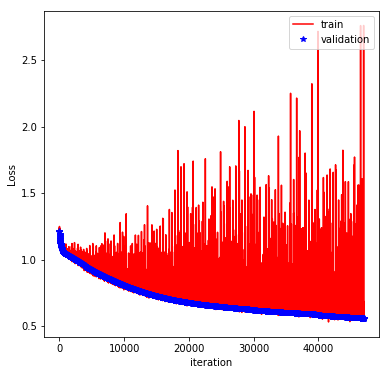

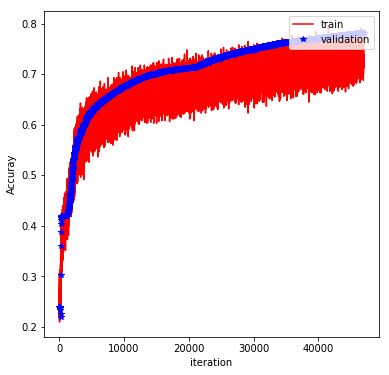

In [4]:
from tensorflow_setup import *
import tensorflow as tf 
import os 
import matplotlib.pyplot as plt
#%matplotlib inline

# filenames used 
traindtfile = 'hdf_750.h5'
testdtfile = 'hdf_750.h5'
losssavefig = 'cnn_train_750_loss.png'
accsavefig = 'cnn_train_750_accuracy.png'
resultsave = 'cnn_train_750.h5'
chkpointdir = 'cnn-750/'

X_tr, X_vld, y_tr, y_vld, list_ch_train = get_tf_train_data(traindtfile)


batch_size = 600       # Batch size
seq_len = 12          # Number of steps
learning_rate = 0.0001
epochs = 100

n_classes = 3 # buy sell and nothing
n_channels = 6 # moving averages

graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

with graph.as_default():
    # (batch, 12, 3) --> (batch, 6, 6)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=6, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_1, (-1, 6*6))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    soft = tf.argmax(logits,1)
    pred = tf.nn.softmax(logits,1)
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


if (os.path.exists('bschkpnt-cnn') == False):
    !mkdir bschkpnt-cnn

validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()


with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1


    saver.save(sess,chkpointdir + "bs.ckpt")


t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+losssavefig)

# change filename here


# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+accsavefig)

del(X_tr, X_vld, y_tr, y_vld, list_ch_train)

X_test, y_test, lab_ch_test = get_tf_test_data(testdtfile)

test_acc = []
probs = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(chkpointdir))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
        prob = sess.run(pred, feed_dict=feed)
        probs.append(prob)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))


# now reshape the probs array
probs = np.array(probs)
probs = probs.reshape((probs.shape[0]*probs.shape[1]), probs.shape[2])
y_test = y_test[:len(probs),:]
# model complete

# save the results

import h5py
hf = h5py.File('h5files/' + resultsave, 'w')
hf.create_dataset('predict_valid', data=probs)
hf.create_dataset('y_test', data = y_test)
hf.close()

del(X_test, y_test, lab_ch_test)


Epoch: 0/100 Iteration: 5 Train loss: 1.821449 Train acc: 0.363333
Epoch: 0/100 Iteration: 10 Train loss: 1.798020 Train acc: 0.363333
Epoch: 0/100 Iteration: 10 Validation loss: 1.210109 Validation acc: 0.649302
Epoch: 0/100 Iteration: 15 Train loss: 1.689306 Train acc: 0.408333
Epoch: 0/100 Iteration: 20 Train loss: 1.691121 Train acc: 0.380000
Epoch: 0/100 Iteration: 20 Validation loss: 1.199443 Validation acc: 0.647519
Epoch: 0/100 Iteration: 25 Train loss: 1.776297 Train acc: 0.376667
Epoch: 0/100 Iteration: 30 Train loss: 1.752056 Train acc: 0.373333
Epoch: 0/100 Iteration: 30 Validation loss: 1.189731 Validation acc: 0.641829
Epoch: 0/100 Iteration: 35 Train loss: 1.654605 Train acc: 0.395000
Epoch: 0/100 Iteration: 40 Train loss: 1.648502 Train acc: 0.398333
Epoch: 0/100 Iteration: 40 Validation loss: 1.180668 Validation acc: 0.643426
Epoch: 0/100 Iteration: 45 Train loss: 1.647803 Train acc: 0.368333
Epoch: 0/100 Iteration: 50 Train loss: 1.855086 Train acc: 0.366667
Epoch: 0/

Epoch: 0/100 Iteration: 390 Validation loss: 1.048636 Validation acc: 0.451054
Epoch: 0/100 Iteration: 395 Train loss: 1.358545 Train acc: 0.376667
Epoch: 0/100 Iteration: 400 Train loss: 1.318603 Train acc: 0.416667
Epoch: 0/100 Iteration: 400 Validation loss: 1.046938 Validation acc: 0.451643
Epoch: 0/100 Iteration: 405 Train loss: 1.411661 Train acc: 0.353333
Epoch: 0/100 Iteration: 410 Train loss: 1.347963 Train acc: 0.368333
Epoch: 0/100 Iteration: 410 Validation loss: 1.045254 Validation acc: 0.453767
Epoch: 0/100 Iteration: 415 Train loss: 1.329111 Train acc: 0.380000
Epoch: 0/100 Iteration: 420 Train loss: 1.336215 Train acc: 0.370000
Epoch: 0/100 Iteration: 420 Validation loss: 1.043724 Validation acc: 0.453907
Epoch: 0/100 Iteration: 425 Train loss: 1.282597 Train acc: 0.413333
Epoch: 0/100 Iteration: 430 Train loss: 1.316991 Train acc: 0.396667
Epoch: 0/100 Iteration: 430 Validation loss: 1.042247 Validation acc: 0.454388
Epoch: 0/100 Iteration: 435 Train loss: 1.279274 Trai

Epoch: 1/100 Iteration: 770 Validation loss: 1.013015 Validation acc: 0.491969
Epoch: 1/100 Iteration: 775 Train loss: 1.173881 Train acc: 0.370000
Epoch: 1/100 Iteration: 780 Train loss: 1.163028 Train acc: 0.381667
Epoch: 1/100 Iteration: 780 Validation loss: 1.012316 Validation acc: 0.496116
Epoch: 1/100 Iteration: 785 Train loss: 1.137408 Train acc: 0.456667
Epoch: 1/100 Iteration: 790 Train loss: 1.129875 Train acc: 0.420000
Epoch: 1/100 Iteration: 790 Validation loss: 1.011630 Validation acc: 0.498109
Epoch: 1/100 Iteration: 795 Train loss: 1.154154 Train acc: 0.406667
Epoch: 1/100 Iteration: 800 Train loss: 1.132667 Train acc: 0.425000
Epoch: 1/100 Iteration: 800 Validation loss: 1.011012 Validation acc: 0.504240
Epoch: 1/100 Iteration: 805 Train loss: 1.168848 Train acc: 0.393333
Epoch: 1/100 Iteration: 810 Train loss: 1.166933 Train acc: 0.405000
Epoch: 1/100 Iteration: 810 Validation loss: 1.010375 Validation acc: 0.504767
Epoch: 1/100 Iteration: 815 Train loss: 1.195938 Trai

Epoch: 1/100 Iteration: 1150 Validation loss: 0.989741 Validation acc: 0.550271
Epoch: 1/100 Iteration: 1155 Train loss: 1.056423 Train acc: 0.450000
Epoch: 1/100 Iteration: 1160 Train loss: 1.064826 Train acc: 0.453333
Epoch: 1/100 Iteration: 1160 Validation loss: 0.989079 Validation acc: 0.548256
Epoch: 1/100 Iteration: 1165 Train loss: 1.059872 Train acc: 0.443333
Epoch: 1/100 Iteration: 1170 Train loss: 1.045762 Train acc: 0.460000
Epoch: 1/100 Iteration: 1170 Validation loss: 0.988486 Validation acc: 0.547488
Epoch: 1/100 Iteration: 1175 Train loss: 1.047181 Train acc: 0.475000
Epoch: 1/100 Iteration: 1180 Train loss: 1.044753 Train acc: 0.461667
Epoch: 1/100 Iteration: 1180 Validation loss: 0.987928 Validation acc: 0.553760
Epoch: 1/100 Iteration: 1185 Train loss: 1.058206 Train acc: 0.455000
Epoch: 1/100 Iteration: 1190 Train loss: 1.061198 Train acc: 0.453333
Epoch: 1/100 Iteration: 1190 Validation loss: 0.987359 Validation acc: 0.550295
Epoch: 1/100 Iteration: 1195 Train loss:

Epoch: 2/100 Iteration: 1530 Validation loss: 0.964744 Validation acc: 0.590581
Epoch: 2/100 Iteration: 1535 Train loss: 0.991826 Train acc: 0.543333
Epoch: 2/100 Iteration: 1540 Train loss: 1.016564 Train acc: 0.483333
Epoch: 2/100 Iteration: 1540 Validation loss: 0.964100 Validation acc: 0.589519
Epoch: 2/100 Iteration: 1545 Train loss: 1.034458 Train acc: 0.488333
Epoch: 2/100 Iteration: 1550 Train loss: 0.988075 Train acc: 0.518333
Epoch: 2/100 Iteration: 1550 Validation loss: 0.963520 Validation acc: 0.590729
Epoch: 2/100 Iteration: 1555 Train loss: 0.993612 Train acc: 0.531667
Epoch: 2/100 Iteration: 1560 Train loss: 1.013074 Train acc: 0.496667
Epoch: 2/100 Iteration: 1560 Validation loss: 0.962856 Validation acc: 0.591124
Epoch: 2/100 Iteration: 1565 Train loss: 0.992931 Train acc: 0.546667
Epoch: 2/100 Iteration: 1570 Train loss: 1.000913 Train acc: 0.535000
Epoch: 2/100 Iteration: 1570 Validation loss: 0.962134 Validation acc: 0.591411
Epoch: 2/100 Iteration: 1575 Train loss:

Epoch: 2/100 Iteration: 1910 Validation loss: 0.940903 Validation acc: 0.604240
Epoch: 2/100 Iteration: 1915 Train loss: 0.977148 Train acc: 0.573333
Epoch: 2/100 Iteration: 1920 Train loss: 0.939401 Train acc: 0.586667
Epoch: 2/100 Iteration: 1920 Validation loss: 0.940204 Validation acc: 0.609930
Epoch: 2/100 Iteration: 1925 Train loss: 0.942618 Train acc: 0.590000
Epoch: 2/100 Iteration: 1930 Train loss: 0.977499 Train acc: 0.541667
Epoch: 2/100 Iteration: 1930 Validation loss: 0.939633 Validation acc: 0.603147
Epoch: 2/100 Iteration: 1935 Train loss: 0.941246 Train acc: 0.611667
Epoch: 3/100 Iteration: 1940 Train loss: 0.963125 Train acc: 0.590000
Epoch: 3/100 Iteration: 1940 Validation loss: 0.938999 Validation acc: 0.602248
Epoch: 3/100 Iteration: 1945 Train loss: 0.946284 Train acc: 0.591667
Epoch: 3/100 Iteration: 1950 Train loss: 0.935346 Train acc: 0.596667
Epoch: 3/100 Iteration: 1950 Validation loss: 0.938316 Validation acc: 0.607186
Epoch: 3/100 Iteration: 1955 Train loss:

Epoch: 3/100 Iteration: 2290 Validation loss: 0.908203 Validation acc: 0.642380
Epoch: 3/100 Iteration: 2295 Train loss: 0.902364 Train acc: 0.631667
Epoch: 3/100 Iteration: 2300 Train loss: 0.932517 Train acc: 0.620000
Epoch: 3/100 Iteration: 2300 Validation loss: 0.907240 Validation acc: 0.645372
Epoch: 3/100 Iteration: 2305 Train loss: 0.924732 Train acc: 0.611667
Epoch: 3/100 Iteration: 2310 Train loss: 0.910591 Train acc: 0.631667
Epoch: 3/100 Iteration: 2310 Validation loss: 0.906690 Validation acc: 0.651256
Epoch: 3/100 Iteration: 2315 Train loss: 0.921084 Train acc: 0.615000
Epoch: 3/100 Iteration: 2320 Train loss: 0.897826 Train acc: 0.648333
Epoch: 3/100 Iteration: 2320 Validation loss: 0.905781 Validation acc: 0.648031
Epoch: 3/100 Iteration: 2325 Train loss: 0.917991 Train acc: 0.635000
Epoch: 3/100 Iteration: 2330 Train loss: 0.930524 Train acc: 0.616667
Epoch: 3/100 Iteration: 2330 Validation loss: 0.905074 Validation acc: 0.645713
Epoch: 3/100 Iteration: 2335 Train loss:

Epoch: 4/100 Iteration: 2670 Validation loss: 0.874789 Validation acc: 0.656124
Epoch: 4/100 Iteration: 2675 Train loss: 0.889601 Train acc: 0.615000
Epoch: 4/100 Iteration: 2680 Train loss: 0.891462 Train acc: 0.613333
Epoch: 4/100 Iteration: 2680 Validation loss: 0.874147 Validation acc: 0.656287
Epoch: 4/100 Iteration: 2685 Train loss: 0.894596 Train acc: 0.628333
Epoch: 4/100 Iteration: 2690 Train loss: 0.896170 Train acc: 0.636667
Epoch: 4/100 Iteration: 2690 Validation loss: 0.873756 Validation acc: 0.654054
Epoch: 4/100 Iteration: 2695 Train loss: 0.879732 Train acc: 0.666667
Epoch: 4/100 Iteration: 2700 Train loss: 0.892897 Train acc: 0.618333
Epoch: 4/100 Iteration: 2700 Validation loss: 0.873000 Validation acc: 0.657775
Epoch: 4/100 Iteration: 2705 Train loss: 0.879307 Train acc: 0.640000
Epoch: 4/100 Iteration: 2710 Train loss: 0.923187 Train acc: 0.596667
Epoch: 4/100 Iteration: 2710 Validation loss: 0.872081 Validation acc: 0.659132
Epoch: 4/100 Iteration: 2715 Train loss:

Epoch: 4/100 Iteration: 3050 Validation loss: 0.846097 Validation acc: 0.669085
Epoch: 4/100 Iteration: 3055 Train loss: 0.857700 Train acc: 0.663333
Epoch: 4/100 Iteration: 3060 Train loss: 0.849359 Train acc: 0.648333
Epoch: 4/100 Iteration: 3060 Validation loss: 0.845121 Validation acc: 0.667961
Epoch: 4/100 Iteration: 3065 Train loss: 0.887421 Train acc: 0.621667
Epoch: 4/100 Iteration: 3070 Train loss: 0.896912 Train acc: 0.615000
Epoch: 4/100 Iteration: 3070 Validation loss: 0.844236 Validation acc: 0.666690
Epoch: 4/100 Iteration: 3075 Train loss: 0.861694 Train acc: 0.656667
Epoch: 4/100 Iteration: 3080 Train loss: 0.870481 Train acc: 0.628333
Epoch: 4/100 Iteration: 3080 Validation loss: 0.843755 Validation acc: 0.666558
Epoch: 4/100 Iteration: 3085 Train loss: 0.834116 Train acc: 0.668333
Epoch: 4/100 Iteration: 3090 Train loss: 0.874812 Train acc: 0.613333
Epoch: 4/100 Iteration: 3090 Validation loss: 0.842850 Validation acc: 0.668248
Epoch: 4/100 Iteration: 3095 Train loss:

Epoch: 5/100 Iteration: 3430 Validation loss: 0.819656 Validation acc: 0.674411
Epoch: 5/100 Iteration: 3435 Train loss: 0.832883 Train acc: 0.661667
Epoch: 5/100 Iteration: 3440 Train loss: 0.840711 Train acc: 0.630000
Epoch: 5/100 Iteration: 3440 Validation loss: 0.818982 Validation acc: 0.675481
Epoch: 5/100 Iteration: 3445 Train loss: 0.850234 Train acc: 0.626667
Epoch: 5/100 Iteration: 3450 Train loss: 0.834092 Train acc: 0.660000
Epoch: 5/100 Iteration: 3450 Validation loss: 0.818378 Validation acc: 0.671829
Epoch: 5/100 Iteration: 3455 Train loss: 0.809470 Train acc: 0.678333
Epoch: 5/100 Iteration: 3460 Train loss: 0.824686 Train acc: 0.665000
Epoch: 5/100 Iteration: 3460 Validation loss: 0.817478 Validation acc: 0.673667
Epoch: 5/100 Iteration: 3465 Train loss: 0.799339 Train acc: 0.680000
Epoch: 5/100 Iteration: 3470 Train loss: 0.833485 Train acc: 0.670000
Epoch: 5/100 Iteration: 3470 Validation loss: 0.817118 Validation acc: 0.676132
Epoch: 5/100 Iteration: 3475 Train loss:

Epoch: 5/100 Iteration: 3810 Validation loss: 0.797635 Validation acc: 0.679178
Epoch: 5/100 Iteration: 3815 Train loss: 0.832185 Train acc: 0.648333
Epoch: 5/100 Iteration: 3820 Train loss: 0.779998 Train acc: 0.670000
Epoch: 5/100 Iteration: 3820 Validation loss: 0.797089 Validation acc: 0.679457
Epoch: 5/100 Iteration: 3825 Train loss: 0.813341 Train acc: 0.655000
Epoch: 5/100 Iteration: 3830 Train loss: 0.822879 Train acc: 0.638333
Epoch: 5/100 Iteration: 3830 Validation loss: 0.796085 Validation acc: 0.680372
Epoch: 5/100 Iteration: 3835 Train loss: 0.830849 Train acc: 0.631667
Epoch: 5/100 Iteration: 3840 Train loss: 0.808776 Train acc: 0.651667
Epoch: 5/100 Iteration: 3840 Validation loss: 0.795078 Validation acc: 0.680116
Epoch: 5/100 Iteration: 3845 Train loss: 0.815048 Train acc: 0.663333
Epoch: 5/100 Iteration: 3850 Train loss: 0.794887 Train acc: 0.650000
Epoch: 5/100 Iteration: 3850 Validation loss: 0.794285 Validation acc: 0.679496
Epoch: 5/100 Iteration: 3855 Train loss:

Epoch: 6/100 Iteration: 4190 Validation loss: 0.775816 Validation acc: 0.683814
Epoch: 6/100 Iteration: 4195 Train loss: 0.818702 Train acc: 0.636667
Epoch: 6/100 Iteration: 4200 Train loss: 0.809863 Train acc: 0.651667
Epoch: 6/100 Iteration: 4200 Validation loss: 0.775339 Validation acc: 0.683636
Epoch: 6/100 Iteration: 4205 Train loss: 0.759559 Train acc: 0.686667
Epoch: 6/100 Iteration: 4210 Train loss: 0.826787 Train acc: 0.651667
Epoch: 6/100 Iteration: 4210 Validation loss: 0.774824 Validation acc: 0.684512
Epoch: 6/100 Iteration: 4215 Train loss: 0.789445 Train acc: 0.691667
Epoch: 6/100 Iteration: 4220 Train loss: 0.786503 Train acc: 0.706667
Epoch: 6/100 Iteration: 4220 Validation loss: 0.774257 Validation acc: 0.683985
Epoch: 6/100 Iteration: 4225 Train loss: 0.814823 Train acc: 0.665000
Epoch: 6/100 Iteration: 4230 Train loss: 0.779032 Train acc: 0.650000
Epoch: 6/100 Iteration: 4230 Validation loss: 0.773605 Validation acc: 0.684046
Epoch: 6/100 Iteration: 4235 Train loss:

Epoch: 7/100 Iteration: 4570 Validation loss: 0.756073 Validation acc: 0.688791
Epoch: 7/100 Iteration: 4575 Train loss: 0.766729 Train acc: 0.698333
Epoch: 7/100 Iteration: 4580 Train loss: 0.808204 Train acc: 0.656667
Epoch: 7/100 Iteration: 4580 Validation loss: 0.755432 Validation acc: 0.689070
Epoch: 7/100 Iteration: 4585 Train loss: 0.803277 Train acc: 0.643333
Epoch: 7/100 Iteration: 4590 Train loss: 0.912757 Train acc: 0.696667
Epoch: 7/100 Iteration: 4590 Validation loss: 0.755195 Validation acc: 0.688481
Epoch: 7/100 Iteration: 4595 Train loss: 0.776811 Train acc: 0.676667
Epoch: 7/100 Iteration: 4600 Train loss: 0.765223 Train acc: 0.680000
Epoch: 7/100 Iteration: 4600 Validation loss: 0.754734 Validation acc: 0.688380
Epoch: 7/100 Iteration: 4605 Train loss: 0.757148 Train acc: 0.701667
Epoch: 7/100 Iteration: 4610 Train loss: 0.778597 Train acc: 0.671667
Epoch: 7/100 Iteration: 4610 Validation loss: 0.754560 Validation acc: 0.687620
Epoch: 7/100 Iteration: 4615 Train loss:

Epoch: 7/100 Iteration: 4950 Validation loss: 0.739287 Validation acc: 0.693139
Epoch: 7/100 Iteration: 4955 Train loss: 0.774839 Train acc: 0.643333
Epoch: 7/100 Iteration: 4960 Train loss: 0.752342 Train acc: 0.693333
Epoch: 7/100 Iteration: 4960 Validation loss: 0.739109 Validation acc: 0.694705
Epoch: 7/100 Iteration: 4965 Train loss: 0.790468 Train acc: 0.643333
Epoch: 7/100 Iteration: 4970 Train loss: 0.783344 Train acc: 0.666667
Epoch: 7/100 Iteration: 4970 Validation loss: 0.738216 Validation acc: 0.693574
Epoch: 7/100 Iteration: 4975 Train loss: 0.830563 Train acc: 0.636667
Epoch: 7/100 Iteration: 4980 Train loss: 0.767950 Train acc: 0.661667
Epoch: 7/100 Iteration: 4980 Validation loss: 0.738003 Validation acc: 0.693620
Epoch: 7/100 Iteration: 4985 Train loss: 0.753314 Train acc: 0.678333
Epoch: 7/100 Iteration: 4990 Train loss: 0.747241 Train acc: 0.680000
Epoch: 7/100 Iteration: 4990 Validation loss: 0.738074 Validation acc: 0.694884
Epoch: 7/100 Iteration: 4995 Train loss:

Epoch: 8/100 Iteration: 5330 Validation loss: 0.722677 Validation acc: 0.697946
Epoch: 8/100 Iteration: 5335 Train loss: 0.750567 Train acc: 0.680000
Epoch: 8/100 Iteration: 5340 Train loss: 0.769612 Train acc: 0.643333
Epoch: 8/100 Iteration: 5340 Validation loss: 0.722328 Validation acc: 0.698295
Epoch: 8/100 Iteration: 5345 Train loss: 0.756086 Train acc: 0.681667
Epoch: 8/100 Iteration: 5350 Train loss: 0.780682 Train acc: 0.648333
Epoch: 8/100 Iteration: 5350 Validation loss: 0.722396 Validation acc: 0.697969
Epoch: 8/100 Iteration: 5355 Train loss: 0.792016 Train acc: 0.640000
Epoch: 8/100 Iteration: 5360 Train loss: 0.753166 Train acc: 0.660000
Epoch: 8/100 Iteration: 5360 Validation loss: 0.722026 Validation acc: 0.698667
Epoch: 8/100 Iteration: 5365 Train loss: 0.766949 Train acc: 0.663333
Epoch: 8/100 Iteration: 5370 Train loss: 0.726644 Train acc: 0.666667
Epoch: 8/100 Iteration: 5370 Validation loss: 0.721371 Validation acc: 0.698938
Epoch: 8/100 Iteration: 5375 Train loss:

Epoch: 8/100 Iteration: 5710 Validation loss: 0.707999 Validation acc: 0.699907
Epoch: 8/100 Iteration: 5715 Train loss: 0.694089 Train acc: 0.700000
Epoch: 8/100 Iteration: 5720 Train loss: 0.752903 Train acc: 0.656667
Epoch: 8/100 Iteration: 5720 Validation loss: 0.706799 Validation acc: 0.701566
Epoch: 8/100 Iteration: 5725 Train loss: 0.752192 Train acc: 0.648333
Epoch: 8/100 Iteration: 5730 Train loss: 0.764503 Train acc: 0.641667
Epoch: 8/100 Iteration: 5730 Validation loss: 0.706541 Validation acc: 0.702806
Epoch: 8/100 Iteration: 5735 Train loss: 0.738310 Train acc: 0.676667
Epoch: 8/100 Iteration: 5740 Train loss: 0.702534 Train acc: 0.696667
Epoch: 8/100 Iteration: 5740 Validation loss: 0.706401 Validation acc: 0.702628
Epoch: 8/100 Iteration: 5745 Train loss: 0.741515 Train acc: 0.666667
Epoch: 8/100 Iteration: 5750 Train loss: 0.704965 Train acc: 0.713333
Epoch: 8/100 Iteration: 5750 Validation loss: 0.706227 Validation acc: 0.702054
Epoch: 8/100 Iteration: 5755 Train loss:

Epoch: 9/100 Iteration: 6090 Validation loss: 0.692680 Validation acc: 0.706264
Epoch: 9/100 Iteration: 6095 Train loss: 0.705474 Train acc: 0.690000
Epoch: 9/100 Iteration: 6100 Train loss: 0.681501 Train acc: 0.723333
Epoch: 9/100 Iteration: 6100 Validation loss: 0.692726 Validation acc: 0.704380
Epoch: 9/100 Iteration: 6105 Train loss: 0.722342 Train acc: 0.681667
Epoch: 9/100 Iteration: 6110 Train loss: 0.722265 Train acc: 0.686667
Epoch: 9/100 Iteration: 6110 Validation loss: 0.692296 Validation acc: 0.704488
Epoch: 9/100 Iteration: 6115 Train loss: 0.725659 Train acc: 0.681667
Epoch: 9/100 Iteration: 6120 Train loss: 0.710105 Train acc: 0.715000
Epoch: 9/100 Iteration: 6120 Validation loss: 0.691818 Validation acc: 0.705984
Epoch: 9/100 Iteration: 6125 Train loss: 0.725618 Train acc: 0.693333
Epoch: 9/100 Iteration: 6130 Train loss: 0.716267 Train acc: 0.700000
Epoch: 9/100 Iteration: 6130 Validation loss: 0.692017 Validation acc: 0.705178
Epoch: 9/100 Iteration: 6135 Train loss:

Epoch: 10/100 Iteration: 6470 Validation loss: 0.679710 Validation acc: 0.709395
Epoch: 10/100 Iteration: 6475 Train loss: 0.724484 Train acc: 0.686667
Epoch: 10/100 Iteration: 6480 Train loss: 0.646645 Train acc: 0.738333
Epoch: 10/100 Iteration: 6480 Validation loss: 0.679409 Validation acc: 0.708543
Epoch: 10/100 Iteration: 6485 Train loss: 0.695675 Train acc: 0.706667
Epoch: 10/100 Iteration: 6490 Train loss: 0.692858 Train acc: 0.703333
Epoch: 10/100 Iteration: 6490 Validation loss: 0.679364 Validation acc: 0.707636
Epoch: 10/100 Iteration: 6495 Train loss: 0.730987 Train acc: 0.678333
Epoch: 10/100 Iteration: 6500 Train loss: 0.711126 Train acc: 0.691667
Epoch: 10/100 Iteration: 6500 Validation loss: 0.678897 Validation acc: 0.708845
Epoch: 10/100 Iteration: 6505 Train loss: 0.689555 Train acc: 0.706667
Epoch: 10/100 Iteration: 6510 Train loss: 0.705216 Train acc: 0.695000
Epoch: 10/100 Iteration: 6510 Validation loss: 0.678557 Validation acc: 0.708876
Epoch: 10/100 Iteration: 65

Epoch: 10/100 Iteration: 6840 Validation loss: 0.668154 Validation acc: 0.710721
Epoch: 10/100 Iteration: 6845 Train loss: 0.725533 Train acc: 0.700000
Epoch: 10/100 Iteration: 6850 Train loss: 0.704117 Train acc: 0.693333
Epoch: 10/100 Iteration: 6850 Validation loss: 0.667619 Validation acc: 0.711380
Epoch: 10/100 Iteration: 6855 Train loss: 0.708375 Train acc: 0.675000
Epoch: 10/100 Iteration: 6860 Train loss: 0.671967 Train acc: 0.698333
Epoch: 10/100 Iteration: 6860 Validation loss: 0.667396 Validation acc: 0.711729
Epoch: 10/100 Iteration: 6865 Train loss: 0.717112 Train acc: 0.678333
Epoch: 10/100 Iteration: 6870 Train loss: 0.665692 Train acc: 0.705000
Epoch: 10/100 Iteration: 6870 Validation loss: 0.667186 Validation acc: 0.711930
Epoch: 10/100 Iteration: 6875 Train loss: 0.756199 Train acc: 0.661667
Epoch: 10/100 Iteration: 6880 Train loss: 0.683185 Train acc: 0.685000
Epoch: 10/100 Iteration: 6880 Validation loss: 0.667109 Validation acc: 0.710287
Epoch: 10/100 Iteration: 68

Epoch: 11/100 Iteration: 7210 Validation loss: 0.657116 Validation acc: 0.712434
Epoch: 11/100 Iteration: 7215 Train loss: 0.713705 Train acc: 0.675000
Epoch: 11/100 Iteration: 7220 Train loss: 0.700588 Train acc: 0.683333
Epoch: 11/100 Iteration: 7220 Validation loss: 0.656213 Validation acc: 0.714426
Epoch: 11/100 Iteration: 7225 Train loss: 0.698264 Train acc: 0.666667
Epoch: 11/100 Iteration: 7230 Train loss: 0.655480 Train acc: 0.723333
Epoch: 11/100 Iteration: 7230 Validation loss: 0.655883 Validation acc: 0.714217
Epoch: 11/100 Iteration: 7235 Train loss: 0.682853 Train acc: 0.720000
Epoch: 11/100 Iteration: 7240 Train loss: 0.655427 Train acc: 0.720000
Epoch: 11/100 Iteration: 7240 Validation loss: 0.655570 Validation acc: 0.714155
Epoch: 11/100 Iteration: 7245 Train loss: 0.645583 Train acc: 0.738333
Epoch: 11/100 Iteration: 7250 Train loss: 0.682541 Train acc: 0.711667
Epoch: 11/100 Iteration: 7250 Validation loss: 0.655403 Validation acc: 0.714155
Epoch: 11/100 Iteration: 72

Epoch: 11/100 Iteration: 7580 Validation loss: 0.646685 Validation acc: 0.720380
Epoch: 11/100 Iteration: 7585 Train loss: 0.690721 Train acc: 0.698333
Epoch: 11/100 Iteration: 7590 Train loss: 0.680836 Train acc: 0.708333
Epoch: 11/100 Iteration: 7590 Validation loss: 0.646281 Validation acc: 0.719659
Epoch: 11/100 Iteration: 7595 Train loss: 0.660576 Train acc: 0.711667
Epoch: 11/100 Iteration: 7600 Train loss: 0.687279 Train acc: 0.706667
Epoch: 11/100 Iteration: 7600 Validation loss: 0.646075 Validation acc: 0.720147
Epoch: 11/100 Iteration: 7605 Train loss: 0.650012 Train acc: 0.728333
Epoch: 11/100 Iteration: 7610 Train loss: 0.654531 Train acc: 0.725000
Epoch: 11/100 Iteration: 7610 Validation loss: 0.645578 Validation acc: 0.719705
Epoch: 11/100 Iteration: 7615 Train loss: 0.647346 Train acc: 0.733333
Epoch: 11/100 Iteration: 7620 Train loss: 0.694429 Train acc: 0.705000
Epoch: 11/100 Iteration: 7620 Validation loss: 0.644976 Validation acc: 0.719481
Epoch: 11/100 Iteration: 76

Epoch: 12/100 Iteration: 7950 Validation loss: 0.636331 Validation acc: 0.727333
Epoch: 12/100 Iteration: 7955 Train loss: 0.697757 Train acc: 0.671667
Epoch: 12/100 Iteration: 7960 Train loss: 0.658781 Train acc: 0.710000
Epoch: 12/100 Iteration: 7960 Validation loss: 0.636150 Validation acc: 0.727434
Epoch: 12/100 Iteration: 7965 Train loss: 0.660510 Train acc: 0.711667
Epoch: 12/100 Iteration: 7970 Train loss: 0.639629 Train acc: 0.710000
Epoch: 12/100 Iteration: 7970 Validation loss: 0.636573 Validation acc: 0.724325
Epoch: 12/100 Iteration: 7975 Train loss: 0.668832 Train acc: 0.698333
Epoch: 12/100 Iteration: 7980 Train loss: 0.686659 Train acc: 0.708333
Epoch: 12/100 Iteration: 7980 Validation loss: 0.636166 Validation acc: 0.725264
Epoch: 12/100 Iteration: 7985 Train loss: 0.707554 Train acc: 0.671667
Epoch: 12/100 Iteration: 7990 Train loss: 0.707175 Train acc: 0.685000
Epoch: 12/100 Iteration: 7990 Validation loss: 0.636245 Validation acc: 0.729233
Epoch: 12/100 Iteration: 79

Epoch: 12/100 Iteration: 8320 Validation loss: 0.627848 Validation acc: 0.736628
Epoch: 12/100 Iteration: 8325 Train loss: 0.626475 Train acc: 0.736667
Epoch: 12/100 Iteration: 8330 Train loss: 0.715970 Train acc: 0.651667
Epoch: 12/100 Iteration: 8330 Validation loss: 0.627932 Validation acc: 0.733527
Epoch: 12/100 Iteration: 8335 Train loss: 0.618428 Train acc: 0.735000
Epoch: 12/100 Iteration: 8340 Train loss: 0.717218 Train acc: 0.711667
Epoch: 12/100 Iteration: 8340 Validation loss: 0.627707 Validation acc: 0.735721
Epoch: 12/100 Iteration: 8345 Train loss: 0.668084 Train acc: 0.701667
Epoch: 12/100 Iteration: 8350 Train loss: 0.660218 Train acc: 0.708333
Epoch: 12/100 Iteration: 8350 Validation loss: 0.627568 Validation acc: 0.733535
Epoch: 12/100 Iteration: 8355 Train loss: 0.633398 Train acc: 0.728333
Epoch: 12/100 Iteration: 8360 Train loss: 0.632632 Train acc: 0.745000
Epoch: 12/100 Iteration: 8360 Validation loss: 0.627116 Validation acc: 0.734876
Epoch: 12/100 Iteration: 83

Epoch: 13/100 Iteration: 8690 Validation loss: 0.619098 Validation acc: 0.735845
Epoch: 13/100 Iteration: 8695 Train loss: 0.653816 Train acc: 0.721667
Epoch: 13/100 Iteration: 8700 Train loss: 0.691267 Train acc: 0.705000
Epoch: 13/100 Iteration: 8700 Validation loss: 0.618113 Validation acc: 0.739419
Epoch: 13/100 Iteration: 8705 Train loss: 0.709483 Train acc: 0.715000
Epoch: 13/100 Iteration: 8710 Train loss: 0.664608 Train acc: 0.705000
Epoch: 13/100 Iteration: 8710 Validation loss: 0.617802 Validation acc: 0.741000
Epoch: 13/100 Iteration: 8715 Train loss: 0.662332 Train acc: 0.693333
Epoch: 13/100 Iteration: 8720 Train loss: 0.686447 Train acc: 0.666667
Epoch: 13/100 Iteration: 8720 Validation loss: 0.618022 Validation acc: 0.739581
Epoch: 13/100 Iteration: 8725 Train loss: 0.643256 Train acc: 0.740000
Epoch: 13/100 Iteration: 8730 Train loss: 0.662214 Train acc: 0.706667
Epoch: 13/100 Iteration: 8730 Validation loss: 0.618075 Validation acc: 0.742295
Epoch: 13/100 Iteration: 87

Epoch: 14/100 Iteration: 9060 Validation loss: 0.610620 Validation acc: 0.747178
Epoch: 14/100 Iteration: 9065 Train loss: 0.652379 Train acc: 0.701667
Epoch: 14/100 Iteration: 9070 Train loss: 0.620858 Train acc: 0.715000
Epoch: 14/100 Iteration: 9070 Validation loss: 0.611472 Validation acc: 0.742651
Epoch: 14/100 Iteration: 9075 Train loss: 0.637782 Train acc: 0.741667
Epoch: 14/100 Iteration: 9080 Train loss: 0.626319 Train acc: 0.705000
Epoch: 14/100 Iteration: 9080 Validation loss: 0.610231 Validation acc: 0.748008
Epoch: 14/100 Iteration: 9085 Train loss: 0.643598 Train acc: 0.715000
Epoch: 14/100 Iteration: 9090 Train loss: 0.636905 Train acc: 0.741667
Epoch: 14/100 Iteration: 9090 Validation loss: 0.610037 Validation acc: 0.748186
Epoch: 14/100 Iteration: 9095 Train loss: 0.637062 Train acc: 0.718333
Epoch: 14/100 Iteration: 9100 Train loss: 0.616360 Train acc: 0.736667
Epoch: 14/100 Iteration: 9100 Validation loss: 0.610370 Validation acc: 0.746085
Epoch: 14/100 Iteration: 91

Epoch: 14/100 Iteration: 9430 Validation loss: 0.603838 Validation acc: 0.750403
Epoch: 14/100 Iteration: 9435 Train loss: 0.656289 Train acc: 0.716667
Epoch: 14/100 Iteration: 9440 Train loss: 0.646728 Train acc: 0.703333
Epoch: 14/100 Iteration: 9440 Validation loss: 0.603752 Validation acc: 0.753124
Epoch: 14/100 Iteration: 9445 Train loss: 0.637262 Train acc: 0.705000
Epoch: 14/100 Iteration: 9450 Train loss: 0.649198 Train acc: 0.703333
Epoch: 14/100 Iteration: 9450 Validation loss: 0.603898 Validation acc: 0.753969
Epoch: 14/100 Iteration: 9455 Train loss: 0.587436 Train acc: 0.773333
Epoch: 14/100 Iteration: 9460 Train loss: 0.618503 Train acc: 0.738333
Epoch: 14/100 Iteration: 9460 Validation loss: 0.603820 Validation acc: 0.749791
Epoch: 14/100 Iteration: 9465 Train loss: 0.617469 Train acc: 0.711667
Epoch: 14/100 Iteration: 9470 Train loss: 0.651271 Train acc: 0.703333
Epoch: 14/100 Iteration: 9470 Validation loss: 0.603191 Validation acc: 0.751512
Epoch: 14/100 Iteration: 94

Epoch: 15/100 Iteration: 9800 Validation loss: 0.596640 Validation acc: 0.755543
Epoch: 15/100 Iteration: 9805 Train loss: 0.649407 Train acc: 0.711667
Epoch: 15/100 Iteration: 9810 Train loss: 0.594755 Train acc: 0.756667
Epoch: 15/100 Iteration: 9810 Validation loss: 0.596851 Validation acc: 0.757550
Epoch: 15/100 Iteration: 9815 Train loss: 0.605583 Train acc: 0.728333
Epoch: 15/100 Iteration: 9820 Train loss: 0.663276 Train acc: 0.686667
Epoch: 15/100 Iteration: 9820 Validation loss: 0.596956 Validation acc: 0.756287
Epoch: 15/100 Iteration: 9825 Train loss: 0.646134 Train acc: 0.743333
Epoch: 15/100 Iteration: 9830 Train loss: 0.629071 Train acc: 0.745000
Epoch: 15/100 Iteration: 9830 Validation loss: 0.596753 Validation acc: 0.756194
Epoch: 15/100 Iteration: 9835 Train loss: 0.642526 Train acc: 0.710000
Epoch: 15/100 Iteration: 9840 Train loss: 0.589839 Train acc: 0.753333
Epoch: 15/100 Iteration: 9840 Validation loss: 0.596699 Validation acc: 0.757078
Epoch: 15/100 Iteration: 98

Epoch: 15/100 Iteration: 10170 Validation loss: 0.591674 Validation acc: 0.757062
Epoch: 15/100 Iteration: 10175 Train loss: 0.633737 Train acc: 0.741667
Epoch: 15/100 Iteration: 10180 Train loss: 0.619284 Train acc: 0.735000
Epoch: 15/100 Iteration: 10180 Validation loss: 0.590904 Validation acc: 0.761240
Epoch: 15/100 Iteration: 10185 Train loss: 0.594200 Train acc: 0.743333
Epoch: 15/100 Iteration: 10190 Train loss: 0.594806 Train acc: 0.740000
Epoch: 15/100 Iteration: 10190 Validation loss: 0.590605 Validation acc: 0.760318
Epoch: 15/100 Iteration: 10195 Train loss: 0.612663 Train acc: 0.743333
Epoch: 15/100 Iteration: 10200 Train loss: 0.627704 Train acc: 0.755000
Epoch: 15/100 Iteration: 10200 Validation loss: 0.589976 Validation acc: 0.760008
Epoch: 15/100 Iteration: 10205 Train loss: 0.694789 Train acc: 0.706667
Epoch: 15/100 Iteration: 10210 Train loss: 0.618107 Train acc: 0.768333
Epoch: 15/100 Iteration: 10210 Validation loss: 0.589898 Validation acc: 0.761380
Epoch: 15/100 

Epoch: 16/100 Iteration: 10540 Validation loss: 0.585247 Validation acc: 0.763496
Epoch: 16/100 Iteration: 10545 Train loss: 0.633288 Train acc: 0.716667
Epoch: 16/100 Iteration: 10550 Train loss: 0.584775 Train acc: 0.766667
Epoch: 16/100 Iteration: 10550 Validation loss: 0.585143 Validation acc: 0.763767
Epoch: 16/100 Iteration: 10555 Train loss: 0.639242 Train acc: 0.730000
Epoch: 16/100 Iteration: 10560 Train loss: 0.589556 Train acc: 0.761667
Epoch: 16/100 Iteration: 10560 Validation loss: 0.584956 Validation acc: 0.762372
Epoch: 16/100 Iteration: 10565 Train loss: 0.581025 Train acc: 0.785000
Epoch: 16/100 Iteration: 10570 Train loss: 0.621545 Train acc: 0.748333
Epoch: 16/100 Iteration: 10570 Validation loss: 0.584536 Validation acc: 0.765116
Epoch: 16/100 Iteration: 10575 Train loss: 0.581371 Train acc: 0.773333
Epoch: 16/100 Iteration: 10580 Train loss: 0.574515 Train acc: 0.761667
Epoch: 16/100 Iteration: 10580 Validation loss: 0.584271 Validation acc: 0.764930
Epoch: 16/100 

Epoch: 16/100 Iteration: 10910 Validation loss: 0.579970 Validation acc: 0.766481
Epoch: 16/100 Iteration: 10915 Train loss: 0.610228 Train acc: 0.730000
Epoch: 16/100 Iteration: 10920 Train loss: 0.625617 Train acc: 0.738333
Epoch: 16/100 Iteration: 10920 Validation loss: 0.579887 Validation acc: 0.767519
Epoch: 16/100 Iteration: 10925 Train loss: 0.594247 Train acc: 0.728333
Epoch: 16/100 Iteration: 10930 Train loss: 0.590906 Train acc: 0.755000
Epoch: 16/100 Iteration: 10930 Validation loss: 0.579540 Validation acc: 0.767295
Epoch: 16/100 Iteration: 10935 Train loss: 0.589806 Train acc: 0.755000
Epoch: 16/100 Iteration: 10940 Train loss: 0.599411 Train acc: 0.743333
Epoch: 16/100 Iteration: 10940 Validation loss: 0.579263 Validation acc: 0.767357
Epoch: 16/100 Iteration: 10945 Train loss: 0.592501 Train acc: 0.745000
Epoch: 16/100 Iteration: 10950 Train loss: 0.574438 Train acc: 0.760000
Epoch: 16/100 Iteration: 10950 Validation loss: 0.579199 Validation acc: 0.765046
Epoch: 16/100 

Epoch: 17/100 Iteration: 11280 Validation loss: 0.574659 Validation acc: 0.766519
Epoch: 17/100 Iteration: 11285 Train loss: 0.639757 Train acc: 0.701667
Epoch: 17/100 Iteration: 11290 Train loss: 0.648851 Train acc: 0.765000
Epoch: 17/100 Iteration: 11290 Validation loss: 0.574267 Validation acc: 0.769814
Epoch: 17/100 Iteration: 11295 Train loss: 0.600503 Train acc: 0.738333
Epoch: 17/100 Iteration: 11300 Train loss: 0.617157 Train acc: 0.758333
Epoch: 17/100 Iteration: 11300 Validation loss: 0.574811 Validation acc: 0.765783
Epoch: 17/100 Iteration: 11305 Train loss: 0.615880 Train acc: 0.728333
Epoch: 17/100 Iteration: 11310 Train loss: 0.589400 Train acc: 0.746667
Epoch: 17/100 Iteration: 11310 Validation loss: 0.574080 Validation acc: 0.769333
Epoch: 17/100 Iteration: 11315 Train loss: 0.590781 Train acc: 0.761667
Epoch: 17/100 Iteration: 11320 Train loss: 0.612910 Train acc: 0.740000
Epoch: 17/100 Iteration: 11320 Validation loss: 0.573950 Validation acc: 0.769496
Epoch: 17/100 

Epoch: 18/100 Iteration: 11650 Validation loss: 0.569978 Validation acc: 0.769597
Epoch: 18/100 Iteration: 11655 Train loss: 0.613779 Train acc: 0.758333
Epoch: 18/100 Iteration: 11660 Train loss: 0.633569 Train acc: 0.725000
Epoch: 18/100 Iteration: 11660 Validation loss: 0.569426 Validation acc: 0.771822
Epoch: 18/100 Iteration: 11665 Train loss: 0.580761 Train acc: 0.770000
Epoch: 18/100 Iteration: 11670 Train loss: 0.555571 Train acc: 0.766667
Epoch: 18/100 Iteration: 11670 Validation loss: 0.569217 Validation acc: 0.772116
Epoch: 18/100 Iteration: 11675 Train loss: 0.595305 Train acc: 0.743333
Epoch: 18/100 Iteration: 11680 Train loss: 0.589631 Train acc: 0.730000
Epoch: 18/100 Iteration: 11680 Validation loss: 0.569404 Validation acc: 0.771093
Epoch: 18/100 Iteration: 11685 Train loss: 0.582783 Train acc: 0.750000
Epoch: 18/100 Iteration: 11690 Train loss: 0.575153 Train acc: 0.740000
Epoch: 18/100 Iteration: 11690 Validation loss: 0.569857 Validation acc: 0.770543
Epoch: 18/100 

Epoch: 18/100 Iteration: 12020 Validation loss: 0.565489 Validation acc: 0.774953
Epoch: 18/100 Iteration: 12025 Train loss: 0.624869 Train acc: 0.725000
Epoch: 18/100 Iteration: 12030 Train loss: 0.589512 Train acc: 0.748333
Epoch: 18/100 Iteration: 12030 Validation loss: 0.565702 Validation acc: 0.774729
Epoch: 18/100 Iteration: 12035 Train loss: 0.579512 Train acc: 0.741667
Epoch: 18/100 Iteration: 12040 Train loss: 0.615326 Train acc: 0.735000
Epoch: 18/100 Iteration: 12040 Validation loss: 0.565329 Validation acc: 0.774488
Epoch: 18/100 Iteration: 12045 Train loss: 0.585521 Train acc: 0.735000
Epoch: 18/100 Iteration: 12050 Train loss: 0.600971 Train acc: 0.726667
Epoch: 18/100 Iteration: 12050 Validation loss: 0.565275 Validation acc: 0.773605
Epoch: 18/100 Iteration: 12055 Train loss: 0.645850 Train acc: 0.715000
Epoch: 18/100 Iteration: 12060 Train loss: 0.654511 Train acc: 0.728333
Epoch: 18/100 Iteration: 12060 Validation loss: 0.565304 Validation acc: 0.775225
Epoch: 18/100 

Epoch: 19/100 Iteration: 12390 Validation loss: 0.562366 Validation acc: 0.777016
Epoch: 19/100 Iteration: 12395 Train loss: 0.575329 Train acc: 0.768333
Epoch: 19/100 Iteration: 12400 Train loss: 0.661170 Train acc: 0.718333
Epoch: 19/100 Iteration: 12400 Validation loss: 0.561998 Validation acc: 0.775512
Epoch: 19/100 Iteration: 12405 Train loss: 0.559449 Train acc: 0.775000
Epoch: 19/100 Iteration: 12410 Train loss: 0.633901 Train acc: 0.723333
Epoch: 19/100 Iteration: 12410 Validation loss: 0.561933 Validation acc: 0.775682
Epoch: 19/100 Iteration: 12415 Train loss: 0.592189 Train acc: 0.731667
Epoch: 19/100 Iteration: 12420 Train loss: 0.643164 Train acc: 0.715000
Epoch: 19/100 Iteration: 12420 Validation loss: 0.562059 Validation acc: 0.773612
Epoch: 19/100 Iteration: 12425 Train loss: 0.665899 Train acc: 0.740000
Epoch: 19/100 Iteration: 12430 Train loss: 0.605075 Train acc: 0.743333
Epoch: 19/100 Iteration: 12430 Validation loss: 0.561763 Validation acc: 0.776543
Epoch: 19/100 

Epoch: 19/100 Iteration: 12760 Validation loss: 0.557662 Validation acc: 0.776558
Epoch: 19/100 Iteration: 12765 Train loss: 0.571123 Train acc: 0.753333
Epoch: 19/100 Iteration: 12770 Train loss: 0.566026 Train acc: 0.750000
Epoch: 19/100 Iteration: 12770 Validation loss: 0.557292 Validation acc: 0.776488
Epoch: 19/100 Iteration: 12775 Train loss: 0.538214 Train acc: 0.788333
Epoch: 19/100 Iteration: 12780 Train loss: 0.589026 Train acc: 0.740000
Epoch: 19/100 Iteration: 12780 Validation loss: 0.557032 Validation acc: 0.777147
Epoch: 19/100 Iteration: 12785 Train loss: 0.561421 Train acc: 0.771667
Epoch: 19/100 Iteration: 12790 Train loss: 0.603613 Train acc: 0.741667
Epoch: 19/100 Iteration: 12790 Validation loss: 0.556872 Validation acc: 0.778465
Epoch: 19/100 Iteration: 12795 Train loss: 0.561589 Train acc: 0.763333
Epoch: 19/100 Iteration: 12800 Train loss: 0.589986 Train acc: 0.760000
Epoch: 19/100 Iteration: 12800 Validation loss: 0.557345 Validation acc: 0.778853
Epoch: 19/100 

Epoch: 20/100 Iteration: 13130 Validation loss: 0.554214 Validation acc: 0.778946
Epoch: 20/100 Iteration: 13135 Train loss: 0.599225 Train acc: 0.741667
Epoch: 20/100 Iteration: 13140 Train loss: 0.543778 Train acc: 0.771667
Epoch: 20/100 Iteration: 13140 Validation loss: 0.554711 Validation acc: 0.775891
Epoch: 20/100 Iteration: 13145 Train loss: 0.567977 Train acc: 0.748333
Epoch: 20/100 Iteration: 13150 Train loss: 0.544633 Train acc: 0.786667
Epoch: 20/100 Iteration: 13150 Validation loss: 0.554001 Validation acc: 0.779574
Epoch: 20/100 Iteration: 13155 Train loss: 0.556651 Train acc: 0.745000
Epoch: 20/100 Iteration: 13160 Train loss: 0.610370 Train acc: 0.758333
Epoch: 20/100 Iteration: 13160 Validation loss: 0.554217 Validation acc: 0.779845
Epoch: 20/100 Iteration: 13165 Train loss: 0.591257 Train acc: 0.731667
Epoch: 20/100 Iteration: 13170 Train loss: 0.560894 Train acc: 0.763333
Epoch: 20/100 Iteration: 13170 Validation loss: 0.553873 Validation acc: 0.777139
Epoch: 20/100 

Epoch: 20/100 Iteration: 13500 Validation loss: 0.551625 Validation acc: 0.779264
Epoch: 20/100 Iteration: 13505 Train loss: 0.590318 Train acc: 0.738333
Epoch: 20/100 Iteration: 13510 Train loss: 0.553043 Train acc: 0.773333
Epoch: 20/100 Iteration: 13510 Validation loss: 0.551849 Validation acc: 0.781372
Epoch: 20/100 Iteration: 13515 Train loss: 0.571117 Train acc: 0.750000
Epoch: 20/100 Iteration: 13520 Train loss: 0.596919 Train acc: 0.721667
Epoch: 20/100 Iteration: 13520 Validation loss: 0.551387 Validation acc: 0.779953
Epoch: 20/100 Iteration: 13525 Train loss: 0.590652 Train acc: 0.756667
Epoch: 20/100 Iteration: 13530 Train loss: 0.563924 Train acc: 0.748333
Epoch: 20/100 Iteration: 13530 Validation loss: 0.551062 Validation acc: 0.779233
Epoch: 20/100 Iteration: 13535 Train loss: 0.576488 Train acc: 0.771667
Epoch: 20/100 Iteration: 13540 Train loss: 0.563066 Train acc: 0.766667
Epoch: 20/100 Iteration: 13540 Validation loss: 0.550380 Validation acc: 0.780550
Epoch: 20/100 

Epoch: 21/100 Iteration: 13870 Validation loss: 0.547061 Validation acc: 0.780860
Epoch: 21/100 Iteration: 13875 Train loss: 0.543438 Train acc: 0.768333
Epoch: 21/100 Iteration: 13880 Train loss: 0.576532 Train acc: 0.758333
Epoch: 21/100 Iteration: 13880 Validation loss: 0.546891 Validation acc: 0.781558
Epoch: 21/100 Iteration: 13885 Train loss: 0.561201 Train acc: 0.758333
Epoch: 21/100 Iteration: 13890 Train loss: 0.613275 Train acc: 0.736667
Epoch: 21/100 Iteration: 13890 Validation loss: 0.547249 Validation acc: 0.780388
Epoch: 21/100 Iteration: 13895 Train loss: 0.549951 Train acc: 0.783333
Epoch: 21/100 Iteration: 13900 Train loss: 0.622460 Train acc: 0.738333
Epoch: 21/100 Iteration: 13900 Validation loss: 0.546825 Validation acc: 0.782085
Epoch: 21/100 Iteration: 13905 Train loss: 0.610921 Train acc: 0.753333
Epoch: 21/100 Iteration: 13910 Train loss: 0.658227 Train acc: 0.800000
Epoch: 21/100 Iteration: 13910 Validation loss: 0.547327 Validation acc: 0.779767
Epoch: 21/100 

Epoch: 22/100 Iteration: 14240 Validation loss: 0.544976 Validation acc: 0.781178
Epoch: 22/100 Iteration: 14245 Train loss: 0.520736 Train acc: 0.798333
Epoch: 22/100 Iteration: 14250 Train loss: 0.597572 Train acc: 0.758333
Epoch: 22/100 Iteration: 14250 Validation loss: 0.544380 Validation acc: 0.782822
Epoch: 22/100 Iteration: 14255 Train loss: 0.595052 Train acc: 0.761667
Epoch: 22/100 Iteration: 14260 Train loss: 0.603269 Train acc: 0.741667
Epoch: 22/100 Iteration: 14260 Validation loss: 0.544575 Validation acc: 0.781442
Epoch: 22/100 Iteration: 14265 Train loss: 0.570072 Train acc: 0.756667
Epoch: 22/100 Iteration: 14270 Train loss: 0.605660 Train acc: 0.738333
Epoch: 22/100 Iteration: 14270 Validation loss: 0.544439 Validation acc: 0.782465
Epoch: 22/100 Iteration: 14275 Train loss: 0.600316 Train acc: 0.735000
Epoch: 22/100 Iteration: 14280 Train loss: 0.953767 Train acc: 0.810000
Epoch: 22/100 Iteration: 14280 Validation loss: 0.544885 Validation acc: 0.781186
Epoch: 22/100 

Epoch: 22/100 Iteration: 14610 Validation loss: 0.542303 Validation acc: 0.784333
Epoch: 22/100 Iteration: 14615 Train loss: 0.571764 Train acc: 0.765000
Epoch: 22/100 Iteration: 14620 Train loss: 0.576428 Train acc: 0.746667
Epoch: 22/100 Iteration: 14620 Validation loss: 0.542271 Validation acc: 0.784426
Epoch: 22/100 Iteration: 14625 Train loss: 0.564188 Train acc: 0.758333
Epoch: 22/100 Iteration: 14630 Train loss: 0.536425 Train acc: 0.771667
Epoch: 22/100 Iteration: 14630 Validation loss: 0.542364 Validation acc: 0.782333
Epoch: 22/100 Iteration: 14635 Train loss: 0.579030 Train acc: 0.751667
Epoch: 22/100 Iteration: 14640 Train loss: 0.647995 Train acc: 0.713333
Epoch: 22/100 Iteration: 14640 Validation loss: 0.542150 Validation acc: 0.783938
Epoch: 22/100 Iteration: 14645 Train loss: 0.623657 Train acc: 0.733333
Epoch: 22/100 Iteration: 14650 Train loss: 0.549950 Train acc: 0.768333
Epoch: 22/100 Iteration: 14650 Validation loss: 0.542511 Validation acc: 0.784155
Epoch: 22/100 

Epoch: 23/100 Iteration: 14980 Validation loss: 0.540171 Validation acc: 0.784884
Epoch: 23/100 Iteration: 14985 Train loss: 0.616122 Train acc: 0.778333
Epoch: 23/100 Iteration: 14990 Train loss: 0.556393 Train acc: 0.753333
Epoch: 23/100 Iteration: 14990 Validation loss: 0.539653 Validation acc: 0.784946
Epoch: 23/100 Iteration: 14995 Train loss: 0.564163 Train acc: 0.766667
Epoch: 23/100 Iteration: 15000 Train loss: 0.574342 Train acc: 0.740000
Epoch: 23/100 Iteration: 15000 Validation loss: 0.539258 Validation acc: 0.784225
Epoch: 23/100 Iteration: 15005 Train loss: 0.561132 Train acc: 0.766667
Epoch: 23/100 Iteration: 15010 Train loss: 0.546724 Train acc: 0.761667
Epoch: 23/100 Iteration: 15010 Validation loss: 0.539513 Validation acc: 0.785558
Epoch: 23/100 Iteration: 15015 Train loss: 0.573817 Train acc: 0.735000
Epoch: 23/100 Iteration: 15020 Train loss: 0.574257 Train acc: 0.753333
Epoch: 23/100 Iteration: 15020 Validation loss: 0.539652 Validation acc: 0.783116
Epoch: 23/100 

Epoch: 23/100 Iteration: 15350 Validation loss: 0.536755 Validation acc: 0.786426
Epoch: 23/100 Iteration: 15355 Train loss: 0.604100 Train acc: 0.751667
Epoch: 23/100 Iteration: 15360 Train loss: 0.641232 Train acc: 0.758333
Epoch: 23/100 Iteration: 15360 Validation loss: 0.536511 Validation acc: 0.784543
Epoch: 23/100 Iteration: 15365 Train loss: 0.540260 Train acc: 0.785000
Epoch: 23/100 Iteration: 15370 Train loss: 0.578142 Train acc: 0.738333
Epoch: 23/100 Iteration: 15370 Validation loss: 0.535945 Validation acc: 0.786605
Epoch: 23/100 Iteration: 15375 Train loss: 0.582850 Train acc: 0.753333
Epoch: 23/100 Iteration: 15380 Train loss: 0.594723 Train acc: 0.750000
Epoch: 23/100 Iteration: 15380 Validation loss: 0.536472 Validation acc: 0.786535
Epoch: 23/100 Iteration: 15385 Train loss: 0.520021 Train acc: 0.791667
Epoch: 23/100 Iteration: 15390 Train loss: 0.549775 Train acc: 0.771667
Epoch: 23/100 Iteration: 15390 Validation loss: 0.536901 Validation acc: 0.786147
Epoch: 23/100 

Epoch: 24/100 Iteration: 15720 Validation loss: 0.535672 Validation acc: 0.784829
Epoch: 24/100 Iteration: 15725 Train loss: 0.601995 Train acc: 0.738333
Epoch: 24/100 Iteration: 15730 Train loss: 0.569410 Train acc: 0.763333
Epoch: 24/100 Iteration: 15730 Validation loss: 0.535199 Validation acc: 0.785853
Epoch: 24/100 Iteration: 15735 Train loss: 0.656245 Train acc: 0.780000
Epoch: 24/100 Iteration: 15740 Train loss: 0.569227 Train acc: 0.766667
Epoch: 24/100 Iteration: 15740 Validation loss: 0.534846 Validation acc: 0.786628
Epoch: 24/100 Iteration: 15745 Train loss: 0.509509 Train acc: 0.795000
Epoch: 24/100 Iteration: 15750 Train loss: 0.547911 Train acc: 0.771667
Epoch: 24/100 Iteration: 15750 Validation loss: 0.534386 Validation acc: 0.786481
Epoch: 24/100 Iteration: 15755 Train loss: 0.589884 Train acc: 0.746667
Epoch: 24/100 Iteration: 15760 Train loss: 0.506300 Train acc: 0.781667
Epoch: 24/100 Iteration: 15760 Validation loss: 0.533996 Validation acc: 0.785977
Epoch: 24/100 

Epoch: 24/100 Iteration: 16090 Validation loss: 0.533674 Validation acc: 0.787612
Epoch: 24/100 Iteration: 16095 Train loss: 0.592336 Train acc: 0.736667
Epoch: 24/100 Iteration: 16100 Train loss: 0.543018 Train acc: 0.791667
Epoch: 24/100 Iteration: 16100 Validation loss: 0.533186 Validation acc: 0.786636
Epoch: 24/100 Iteration: 16105 Train loss: 0.536499 Train acc: 0.750000
Epoch: 24/100 Iteration: 16110 Train loss: 0.556658 Train acc: 0.761667
Epoch: 24/100 Iteration: 16110 Validation loss: 0.533098 Validation acc: 0.786984
Epoch: 24/100 Iteration: 16115 Train loss: 0.579293 Train acc: 0.753333
Epoch: 24/100 Iteration: 16120 Train loss: 0.553152 Train acc: 0.760000
Epoch: 24/100 Iteration: 16120 Validation loss: 0.532434 Validation acc: 0.786760
Epoch: 24/100 Iteration: 16125 Train loss: 0.573664 Train acc: 0.771667
Epoch: 24/100 Iteration: 16130 Train loss: 0.554452 Train acc: 0.786667
Epoch: 24/100 Iteration: 16130 Validation loss: 0.532273 Validation acc: 0.787868
Epoch: 24/100 

Epoch: 25/100 Iteration: 16460 Validation loss: 0.530301 Validation acc: 0.788496
Epoch: 25/100 Iteration: 16465 Train loss: 0.510342 Train acc: 0.791667
Epoch: 25/100 Iteration: 16470 Train loss: 0.570579 Train acc: 0.741667
Epoch: 25/100 Iteration: 16470 Validation loss: 0.531739 Validation acc: 0.784837
Epoch: 25/100 Iteration: 16475 Train loss: 0.575465 Train acc: 0.776667
Epoch: 25/100 Iteration: 16480 Train loss: 0.621356 Train acc: 0.758333
Epoch: 25/100 Iteration: 16480 Validation loss: 0.530841 Validation acc: 0.788294
Epoch: 25/100 Iteration: 16485 Train loss: 0.566351 Train acc: 0.781667
Epoch: 25/100 Iteration: 16490 Train loss: 0.545740 Train acc: 0.765000
Epoch: 25/100 Iteration: 16490 Validation loss: 0.530898 Validation acc: 0.787008
Epoch: 25/100 Iteration: 16495 Train loss: 0.523642 Train acc: 0.778333
Epoch: 25/100 Iteration: 16500 Train loss: 0.576287 Train acc: 0.751667
Epoch: 25/100 Iteration: 16500 Validation loss: 0.530451 Validation acc: 0.786992
Epoch: 25/100 

Epoch: 26/100 Iteration: 16830 Validation loss: 0.527433 Validation acc: 0.789109
Epoch: 26/100 Iteration: 16835 Train loss: 0.548180 Train acc: 0.763333
Epoch: 26/100 Iteration: 16840 Train loss: 0.556513 Train acc: 0.750000
Epoch: 26/100 Iteration: 16840 Validation loss: 0.527603 Validation acc: 0.788814
Epoch: 26/100 Iteration: 16845 Train loss: 0.546221 Train acc: 0.760000
Epoch: 26/100 Iteration: 16850 Train loss: 0.530539 Train acc: 0.800000
Epoch: 26/100 Iteration: 16850 Validation loss: 0.527916 Validation acc: 0.788581
Epoch: 26/100 Iteration: 16855 Train loss: 0.555844 Train acc: 0.760000
Epoch: 26/100 Iteration: 16860 Train loss: 0.497578 Train acc: 0.806667
Epoch: 26/100 Iteration: 16860 Validation loss: 0.528285 Validation acc: 0.788279
Epoch: 26/100 Iteration: 16865 Train loss: 0.558782 Train acc: 0.773333
Epoch: 26/100 Iteration: 16870 Train loss: 0.537216 Train acc: 0.753333
Epoch: 26/100 Iteration: 16870 Validation loss: 0.528499 Validation acc: 0.788364
Epoch: 26/100 

Epoch: 26/100 Iteration: 17200 Validation loss: 0.526461 Validation acc: 0.789783
Epoch: 26/100 Iteration: 17205 Train loss: 0.533240 Train acc: 0.768333
Epoch: 26/100 Iteration: 17210 Train loss: 0.624219 Train acc: 0.751667
Epoch: 26/100 Iteration: 17210 Validation loss: 0.526633 Validation acc: 0.788620
Epoch: 26/100 Iteration: 17215 Train loss: 0.595257 Train acc: 0.761667
Epoch: 26/100 Iteration: 17220 Train loss: 0.555938 Train acc: 0.786667
Epoch: 26/100 Iteration: 17220 Validation loss: 0.526826 Validation acc: 0.788341
Epoch: 26/100 Iteration: 17225 Train loss: 0.592286 Train acc: 0.740000
Epoch: 26/100 Iteration: 17230 Train loss: 0.781587 Train acc: 0.750000
Epoch: 26/100 Iteration: 17230 Validation loss: 0.526935 Validation acc: 0.789643
Epoch: 26/100 Iteration: 17235 Train loss: 0.544710 Train acc: 0.746667
Epoch: 26/100 Iteration: 17240 Train loss: 0.580873 Train acc: 0.743333
Epoch: 26/100 Iteration: 17240 Validation loss: 0.527087 Validation acc: 0.788860
Epoch: 26/100 

Epoch: 27/100 Iteration: 17570 Validation loss: 0.525272 Validation acc: 0.789798
Epoch: 27/100 Iteration: 17575 Train loss: 0.542960 Train acc: 0.785000
Epoch: 27/100 Iteration: 17580 Train loss: 0.545802 Train acc: 0.750000
Epoch: 27/100 Iteration: 17580 Validation loss: 0.525137 Validation acc: 0.789202
Epoch: 27/100 Iteration: 17585 Train loss: 0.609665 Train acc: 0.756667
Epoch: 27/100 Iteration: 17590 Train loss: 0.525700 Train acc: 0.791667
Epoch: 27/100 Iteration: 17590 Validation loss: 0.524921 Validation acc: 0.789822
Epoch: 27/100 Iteration: 17595 Train loss: 0.502886 Train acc: 0.803333
Epoch: 27/100 Iteration: 17600 Train loss: 0.537032 Train acc: 0.761667
Epoch: 27/100 Iteration: 17600 Validation loss: 0.525063 Validation acc: 0.790287
Epoch: 27/100 Iteration: 17605 Train loss: 0.560326 Train acc: 0.773333
Epoch: 27/100 Iteration: 17610 Train loss: 0.558023 Train acc: 0.753333
Epoch: 27/100 Iteration: 17610 Validation loss: 0.525092 Validation acc: 0.789132
Epoch: 27/100 

Epoch: 27/100 Iteration: 17940 Validation loss: 0.523860 Validation acc: 0.788318
Epoch: 27/100 Iteration: 17945 Train loss: 0.566240 Train acc: 0.753333
Epoch: 27/100 Iteration: 17950 Train loss: 0.525189 Train acc: 0.770000
Epoch: 27/100 Iteration: 17950 Validation loss: 0.522779 Validation acc: 0.790713
Epoch: 27/100 Iteration: 17955 Train loss: 0.579807 Train acc: 0.728333
Epoch: 27/100 Iteration: 17960 Train loss: 0.565401 Train acc: 0.760000
Epoch: 27/100 Iteration: 17960 Validation loss: 0.522452 Validation acc: 0.790969
Epoch: 27/100 Iteration: 17965 Train loss: 0.534714 Train acc: 0.798333
Epoch: 27/100 Iteration: 17970 Train loss: 0.554249 Train acc: 0.753333
Epoch: 27/100 Iteration: 17970 Validation loss: 0.523100 Validation acc: 0.790853
Epoch: 27/100 Iteration: 17975 Train loss: 0.554731 Train acc: 0.748333
Epoch: 27/100 Iteration: 17980 Train loss: 0.543839 Train acc: 0.795000
Epoch: 27/100 Iteration: 17980 Validation loss: 0.523186 Validation acc: 0.788574
Epoch: 27/100 

Epoch: 28/100 Iteration: 18310 Validation loss: 0.522008 Validation acc: 0.789868
Epoch: 28/100 Iteration: 18315 Train loss: 0.592326 Train acc: 0.751667
Epoch: 28/100 Iteration: 18320 Train loss: 0.531574 Train acc: 0.788333
Epoch: 28/100 Iteration: 18320 Validation loss: 0.521627 Validation acc: 0.790946
Epoch: 28/100 Iteration: 18325 Train loss: 0.571919 Train acc: 0.780000
Epoch: 28/100 Iteration: 18330 Train loss: 0.551115 Train acc: 0.781667
Epoch: 28/100 Iteration: 18330 Validation loss: 0.521460 Validation acc: 0.791070
Epoch: 28/100 Iteration: 18335 Train loss: 0.691948 Train acc: 0.803333
Epoch: 28/100 Iteration: 18340 Train loss: 0.518297 Train acc: 0.776667
Epoch: 28/100 Iteration: 18340 Validation loss: 0.521250 Validation acc: 0.790031
Epoch: 28/100 Iteration: 18345 Train loss: 0.545791 Train acc: 0.766667
Epoch: 28/100 Iteration: 18350 Train loss: 0.562374 Train acc: 0.760000
Epoch: 28/100 Iteration: 18350 Validation loss: 0.521031 Validation acc: 0.790899
Epoch: 28/100 

Epoch: 28/100 Iteration: 18680 Validation loss: 0.520762 Validation acc: 0.791465
Epoch: 28/100 Iteration: 18685 Train loss: 0.578310 Train acc: 0.746667
Epoch: 28/100 Iteration: 18690 Train loss: 0.532258 Train acc: 0.765000
Epoch: 28/100 Iteration: 18690 Validation loss: 0.520346 Validation acc: 0.790256
Epoch: 28/100 Iteration: 18695 Train loss: 0.509933 Train acc: 0.806667
Epoch: 28/100 Iteration: 18700 Train loss: 0.563863 Train acc: 0.758333
Epoch: 28/100 Iteration: 18700 Validation loss: 0.520027 Validation acc: 0.790341
Epoch: 28/100 Iteration: 18705 Train loss: 0.606723 Train acc: 0.725000
Epoch: 28/100 Iteration: 18710 Train loss: 0.622097 Train acc: 0.768333
Epoch: 28/100 Iteration: 18710 Validation loss: 0.520113 Validation acc: 0.791767
Epoch: 28/100 Iteration: 18715 Train loss: 0.528240 Train acc: 0.760000
Epoch: 28/100 Iteration: 18720 Train loss: 0.570284 Train acc: 0.758333
Epoch: 28/100 Iteration: 18720 Validation loss: 0.520021 Validation acc: 0.789636
Epoch: 28/100 

Epoch: 29/100 Iteration: 19050 Validation loss: 0.518334 Validation acc: 0.791357
Epoch: 29/100 Iteration: 19055 Train loss: 0.560081 Train acc: 0.770000
Epoch: 29/100 Iteration: 19060 Train loss: 0.531088 Train acc: 0.765000
Epoch: 29/100 Iteration: 19060 Validation loss: 0.518235 Validation acc: 0.791473
Epoch: 29/100 Iteration: 19065 Train loss: 0.532789 Train acc: 0.766667
Epoch: 29/100 Iteration: 19070 Train loss: 0.548120 Train acc: 0.773333
Epoch: 29/100 Iteration: 19070 Validation loss: 0.518233 Validation acc: 0.791884
Epoch: 29/100 Iteration: 19075 Train loss: 0.559607 Train acc: 0.773333
Epoch: 29/100 Iteration: 19080 Train loss: 0.497936 Train acc: 0.790000
Epoch: 29/100 Iteration: 19080 Validation loss: 0.518615 Validation acc: 0.790047
Epoch: 29/100 Iteration: 19085 Train loss: 0.569036 Train acc: 0.753333
Epoch: 29/100 Iteration: 19090 Train loss: 0.544963 Train acc: 0.780000
Epoch: 29/100 Iteration: 19090 Validation loss: 0.517837 Validation acc: 0.792388
Epoch: 29/100 

Epoch: 30/100 Iteration: 19420 Validation loss: 0.516572 Validation acc: 0.792481
Epoch: 30/100 Iteration: 19425 Train loss: 0.534723 Train acc: 0.775000
Epoch: 30/100 Iteration: 19430 Train loss: 0.549333 Train acc: 0.765000
Epoch: 30/100 Iteration: 19430 Validation loss: 0.517104 Validation acc: 0.791450
Epoch: 30/100 Iteration: 19435 Train loss: 0.517520 Train acc: 0.798333
Epoch: 30/100 Iteration: 19440 Train loss: 0.568365 Train acc: 0.746667
Epoch: 30/100 Iteration: 19440 Validation loss: 0.517048 Validation acc: 0.791682
Epoch: 30/100 Iteration: 19445 Train loss: 0.552897 Train acc: 0.765000
Epoch: 30/100 Iteration: 19450 Train loss: 0.603851 Train acc: 0.781667
Epoch: 30/100 Iteration: 19450 Validation loss: 0.517350 Validation acc: 0.791202
Epoch: 30/100 Iteration: 19455 Train loss: 0.580751 Train acc: 0.771667
Epoch: 30/100 Iteration: 19460 Train loss: 0.537457 Train acc: 0.795000
Epoch: 30/100 Iteration: 19460 Validation loss: 0.517345 Validation acc: 0.791512
Epoch: 30/100 

Epoch: 30/100 Iteration: 19790 Validation loss: 0.515077 Validation acc: 0.793178
Epoch: 30/100 Iteration: 19795 Train loss: 0.603756 Train acc: 0.756667
Epoch: 30/100 Iteration: 19800 Train loss: 0.544545 Train acc: 0.763333
Epoch: 30/100 Iteration: 19800 Validation loss: 0.515333 Validation acc: 0.792178
Epoch: 30/100 Iteration: 19805 Train loss: 0.561646 Train acc: 0.770000
Epoch: 30/100 Iteration: 19810 Train loss: 0.528316 Train acc: 0.795000
Epoch: 30/100 Iteration: 19810 Validation loss: 0.515364 Validation acc: 0.792791
Epoch: 30/100 Iteration: 19815 Train loss: 0.603201 Train acc: 0.773333
Epoch: 30/100 Iteration: 19820 Train loss: 0.559532 Train acc: 0.746667
Epoch: 30/100 Iteration: 19820 Validation loss: 0.516173 Validation acc: 0.792721
Epoch: 30/100 Iteration: 19825 Train loss: 0.521302 Train acc: 0.786667
Epoch: 30/100 Iteration: 19830 Train loss: 0.923937 Train acc: 0.783333
Epoch: 30/100 Iteration: 19830 Validation loss: 0.516395 Validation acc: 0.792364
Epoch: 30/100 

Epoch: 31/100 Iteration: 20160 Validation loss: 0.514758 Validation acc: 0.793155
Epoch: 31/100 Iteration: 20165 Train loss: 0.535302 Train acc: 0.788333
Epoch: 31/100 Iteration: 20170 Train loss: 0.578210 Train acc: 0.786667
Epoch: 31/100 Iteration: 20170 Validation loss: 0.514615 Validation acc: 0.792558
Epoch: 31/100 Iteration: 20175 Train loss: 0.559839 Train acc: 0.750000
Epoch: 31/100 Iteration: 20180 Train loss: 0.564822 Train acc: 0.765000
Epoch: 31/100 Iteration: 20180 Validation loss: 0.515136 Validation acc: 0.792954
Epoch: 31/100 Iteration: 20185 Train loss: 0.538218 Train acc: 0.766667
Epoch: 31/100 Iteration: 20190 Train loss: 0.583162 Train acc: 0.746667
Epoch: 31/100 Iteration: 20190 Validation loss: 0.515261 Validation acc: 0.791233
Epoch: 31/100 Iteration: 20195 Train loss: 0.546235 Train acc: 0.781667
Epoch: 31/100 Iteration: 20200 Train loss: 0.522064 Train acc: 0.790000
Epoch: 31/100 Iteration: 20200 Validation loss: 0.514761 Validation acc: 0.792845
Epoch: 31/100 

Epoch: 31/100 Iteration: 20530 Validation loss: 0.513139 Validation acc: 0.793426
Epoch: 31/100 Iteration: 20535 Train loss: 0.502656 Train acc: 0.791667
Epoch: 31/100 Iteration: 20540 Train loss: 0.552544 Train acc: 0.765000
Epoch: 31/100 Iteration: 20540 Validation loss: 0.513056 Validation acc: 0.792698
Epoch: 31/100 Iteration: 20545 Train loss: 0.555899 Train acc: 0.776667
Epoch: 31/100 Iteration: 20550 Train loss: 0.520616 Train acc: 0.823333
Epoch: 31/100 Iteration: 20550 Validation loss: 0.513331 Validation acc: 0.793597
Epoch: 31/100 Iteration: 20555 Train loss: 0.620203 Train acc: 0.770000
Epoch: 31/100 Iteration: 20560 Train loss: 0.543640 Train acc: 0.766667
Epoch: 31/100 Iteration: 20560 Validation loss: 0.513210 Validation acc: 0.793504
Epoch: 31/100 Iteration: 20565 Train loss: 0.533890 Train acc: 0.776667
Epoch: 31/100 Iteration: 20570 Train loss: 0.569384 Train acc: 0.793333
Epoch: 31/100 Iteration: 20570 Validation loss: 0.514775 Validation acc: 0.789690
Epoch: 31/100 

Epoch: 32/100 Iteration: 20900 Validation loss: 0.512573 Validation acc: 0.793597
Epoch: 32/100 Iteration: 20905 Train loss: 0.557992 Train acc: 0.755000
Epoch: 32/100 Iteration: 20910 Train loss: 0.556721 Train acc: 0.770000
Epoch: 32/100 Iteration: 20910 Validation loss: 0.512719 Validation acc: 0.793589
Epoch: 32/100 Iteration: 20915 Train loss: 0.525982 Train acc: 0.766667
Epoch: 32/100 Iteration: 20920 Train loss: 0.514939 Train acc: 0.775000
Epoch: 32/100 Iteration: 20920 Validation loss: 0.512526 Validation acc: 0.792915
Epoch: 32/100 Iteration: 20925 Train loss: 0.558506 Train acc: 0.778333
Epoch: 32/100 Iteration: 20930 Train loss: 0.523153 Train acc: 0.795000
Epoch: 32/100 Iteration: 20930 Validation loss: 0.512108 Validation acc: 0.793566
Epoch: 32/100 Iteration: 20935 Train loss: 0.560185 Train acc: 0.763333
Epoch: 32/100 Iteration: 20940 Train loss: 0.571444 Train acc: 0.745000
Epoch: 32/100 Iteration: 20940 Validation loss: 0.512093 Validation acc: 0.794047
Epoch: 32/100 

Epoch: 32/100 Iteration: 21270 Validation loss: 0.511293 Validation acc: 0.793705
Epoch: 32/100 Iteration: 21275 Train loss: 0.533102 Train acc: 0.751667
Epoch: 32/100 Iteration: 21280 Train loss: 0.518743 Train acc: 0.801667
Epoch: 32/100 Iteration: 21280 Validation loss: 0.510675 Validation acc: 0.793977
Epoch: 32/100 Iteration: 21285 Train loss: 0.523157 Train acc: 0.781667
Epoch: 32/100 Iteration: 21290 Train loss: 0.511542 Train acc: 0.793333
Epoch: 32/100 Iteration: 21290 Validation loss: 0.510195 Validation acc: 0.794093
Epoch: 32/100 Iteration: 21295 Train loss: 0.531128 Train acc: 0.780000
Epoch: 32/100 Iteration: 21300 Train loss: 0.536794 Train acc: 0.778333
Epoch: 32/100 Iteration: 21300 Validation loss: 0.510257 Validation acc: 0.793922
Epoch: 32/100 Iteration: 21305 Train loss: 0.500206 Train acc: 0.790000
Epoch: 32/100 Iteration: 21310 Train loss: 0.668602 Train acc: 0.753333
Epoch: 32/100 Iteration: 21310 Validation loss: 0.512255 Validation acc: 0.790318
Epoch: 32/100 

Epoch: 33/100 Iteration: 21640 Validation loss: 0.509542 Validation acc: 0.793636
Epoch: 33/100 Iteration: 21645 Train loss: 0.561638 Train acc: 0.788333
Epoch: 33/100 Iteration: 21650 Train loss: 0.551142 Train acc: 0.760000
Epoch: 33/100 Iteration: 21650 Validation loss: 0.509296 Validation acc: 0.794574
Epoch: 33/100 Iteration: 21655 Train loss: 0.515363 Train acc: 0.770000
Epoch: 33/100 Iteration: 21660 Train loss: 0.559999 Train acc: 0.788333
Epoch: 33/100 Iteration: 21660 Validation loss: 0.510012 Validation acc: 0.793450
Epoch: 33/100 Iteration: 21665 Train loss: 0.526177 Train acc: 0.768333
Epoch: 33/100 Iteration: 21670 Train loss: 0.505662 Train acc: 0.783333
Epoch: 33/100 Iteration: 21670 Validation loss: 0.509536 Validation acc: 0.794349
Epoch: 33/100 Iteration: 21675 Train loss: 0.490553 Train acc: 0.783333
Epoch: 33/100 Iteration: 21680 Train loss: 0.514141 Train acc: 0.785000
Epoch: 33/100 Iteration: 21680 Validation loss: 0.509326 Validation acc: 0.795147
Epoch: 33/100 

Epoch: 34/100 Iteration: 22010 Validation loss: 0.508115 Validation acc: 0.794163
Epoch: 34/100 Iteration: 22015 Train loss: 0.521198 Train acc: 0.796667
Epoch: 34/100 Iteration: 22020 Train loss: 0.492903 Train acc: 0.803333
Epoch: 34/100 Iteration: 22020 Validation loss: 0.507761 Validation acc: 0.795085
Epoch: 34/100 Iteration: 22025 Train loss: 0.544163 Train acc: 0.775000
Epoch: 34/100 Iteration: 22030 Train loss: 0.520023 Train acc: 0.800000
Epoch: 34/100 Iteration: 22030 Validation loss: 0.508131 Validation acc: 0.793922
Epoch: 34/100 Iteration: 22035 Train loss: 0.552218 Train acc: 0.755000
Epoch: 34/100 Iteration: 22040 Train loss: 0.532732 Train acc: 0.770000
Epoch: 34/100 Iteration: 22040 Validation loss: 0.508264 Validation acc: 0.794326
Epoch: 34/100 Iteration: 22045 Train loss: 0.566578 Train acc: 0.751667
Epoch: 34/100 Iteration: 22050 Train loss: 0.552937 Train acc: 0.775000
Epoch: 34/100 Iteration: 22050 Validation loss: 0.508763 Validation acc: 0.794070
Epoch: 34/100 

Epoch: 34/100 Iteration: 22380 Validation loss: 0.508448 Validation acc: 0.793891
Epoch: 34/100 Iteration: 22385 Train loss: 0.536733 Train acc: 0.736667
Epoch: 34/100 Iteration: 22390 Train loss: 0.545241 Train acc: 0.760000
Epoch: 34/100 Iteration: 22390 Validation loss: 0.508407 Validation acc: 0.794558
Epoch: 34/100 Iteration: 22395 Train loss: 0.491414 Train acc: 0.796667
Epoch: 34/100 Iteration: 22400 Train loss: 0.557128 Train acc: 0.748333
Epoch: 34/100 Iteration: 22400 Validation loss: 0.508934 Validation acc: 0.795085
Epoch: 34/100 Iteration: 22405 Train loss: 0.537258 Train acc: 0.800000
Epoch: 34/100 Iteration: 22410 Train loss: 0.533319 Train acc: 0.781667
Epoch: 34/100 Iteration: 22410 Validation loss: 0.509141 Validation acc: 0.794225
Epoch: 34/100 Iteration: 22415 Train loss: 0.538129 Train acc: 0.781667
Epoch: 34/100 Iteration: 22420 Train loss: 0.516635 Train acc: 0.785000
Epoch: 34/100 Iteration: 22420 Validation loss: 0.508520 Validation acc: 0.794946
Epoch: 34/100 

Epoch: 35/100 Iteration: 22750 Validation loss: 0.507355 Validation acc: 0.794659
Epoch: 35/100 Iteration: 22755 Train loss: 0.546286 Train acc: 0.765000
Epoch: 35/100 Iteration: 22760 Train loss: 0.512547 Train acc: 0.781667
Epoch: 35/100 Iteration: 22760 Validation loss: 0.507759 Validation acc: 0.795202
Epoch: 35/100 Iteration: 22765 Train loss: 0.553248 Train acc: 0.756667
Epoch: 35/100 Iteration: 22770 Train loss: 0.539819 Train acc: 0.783333
Epoch: 35/100 Iteration: 22770 Validation loss: 0.507915 Validation acc: 0.794287
Epoch: 35/100 Iteration: 22775 Train loss: 0.530479 Train acc: 0.770000
Epoch: 35/100 Iteration: 22780 Train loss: 0.495162 Train acc: 0.801667
Epoch: 35/100 Iteration: 22780 Validation loss: 0.507662 Validation acc: 0.794496
Epoch: 35/100 Iteration: 22785 Train loss: 0.546170 Train acc: 0.778333
Epoch: 35/100 Iteration: 22790 Train loss: 0.567770 Train acc: 0.776667
Epoch: 35/100 Iteration: 22790 Validation loss: 0.507132 Validation acc: 0.794767
Epoch: 35/100 

Epoch: 35/100 Iteration: 23120 Validation loss: 0.505876 Validation acc: 0.795419
Epoch: 35/100 Iteration: 23125 Train loss: 0.628618 Train acc: 0.776667
Epoch: 35/100 Iteration: 23130 Train loss: 0.525796 Train acc: 0.793333
Epoch: 35/100 Iteration: 23130 Validation loss: 0.506056 Validation acc: 0.795488
Epoch: 35/100 Iteration: 23135 Train loss: 0.498720 Train acc: 0.808333
Epoch: 35/100 Iteration: 23140 Train loss: 0.504417 Train acc: 0.788333
Epoch: 35/100 Iteration: 23140 Validation loss: 0.506728 Validation acc: 0.795884
Epoch: 35/100 Iteration: 23145 Train loss: 0.552302 Train acc: 0.755000
Epoch: 35/100 Iteration: 23150 Train loss: 0.502825 Train acc: 0.803333
Epoch: 35/100 Iteration: 23150 Validation loss: 0.508244 Validation acc: 0.791969
Epoch: 35/100 Iteration: 23155 Train loss: 0.528185 Train acc: 0.780000
Epoch: 35/100 Iteration: 23160 Train loss: 0.607723 Train acc: 0.766667
Epoch: 35/100 Iteration: 23160 Validation loss: 0.506231 Validation acc: 0.795310
Epoch: 35/100 

Epoch: 36/100 Iteration: 23490 Validation loss: 0.505982 Validation acc: 0.795729
Epoch: 36/100 Iteration: 23495 Train loss: 0.521148 Train acc: 0.810000
Epoch: 36/100 Iteration: 23500 Train loss: 0.477896 Train acc: 0.798333
Epoch: 36/100 Iteration: 23500 Validation loss: 0.505716 Validation acc: 0.795341
Epoch: 36/100 Iteration: 23505 Train loss: 0.534799 Train acc: 0.793333
Epoch: 36/100 Iteration: 23510 Train loss: 0.516650 Train acc: 0.783333
Epoch: 36/100 Iteration: 23510 Validation loss: 0.505352 Validation acc: 0.795124
Epoch: 36/100 Iteration: 23515 Train loss: 0.570298 Train acc: 0.781667
Epoch: 36/100 Iteration: 23520 Train loss: 0.505522 Train acc: 0.793333
Epoch: 36/100 Iteration: 23520 Validation loss: 0.504671 Validation acc: 0.795760
Epoch: 36/100 Iteration: 23525 Train loss: 0.548598 Train acc: 0.801667
Epoch: 36/100 Iteration: 23530 Train loss: 0.547390 Train acc: 0.773333
Epoch: 36/100 Iteration: 23530 Validation loss: 0.504554 Validation acc: 0.795496
Epoch: 36/100 

Epoch: 36/100 Iteration: 23860 Validation loss: 0.504632 Validation acc: 0.795946
Epoch: 36/100 Iteration: 23865 Train loss: 0.526992 Train acc: 0.783333
Epoch: 36/100 Iteration: 23870 Train loss: 0.498370 Train acc: 0.791667
Epoch: 36/100 Iteration: 23870 Validation loss: 0.505052 Validation acc: 0.794426
Epoch: 36/100 Iteration: 23875 Train loss: 0.536664 Train acc: 0.785000
Epoch: 36/100 Iteration: 23880 Train loss: 0.510623 Train acc: 0.793333
Epoch: 36/100 Iteration: 23880 Validation loss: 0.504601 Validation acc: 0.796341
Epoch: 36/100 Iteration: 23885 Train loss: 0.533977 Train acc: 0.783333
Epoch: 36/100 Iteration: 23890 Train loss: 0.515732 Train acc: 0.766667
Epoch: 36/100 Iteration: 23890 Validation loss: 0.504332 Validation acc: 0.794907
Epoch: 36/100 Iteration: 23895 Train loss: 0.526370 Train acc: 0.780000
Epoch: 36/100 Iteration: 23900 Train loss: 0.576845 Train acc: 0.755000
Epoch: 36/100 Iteration: 23900 Validation loss: 0.504333 Validation acc: 0.794845
Epoch: 37/100 

Epoch: 37/100 Iteration: 24230 Validation loss: 0.503022 Validation acc: 0.796488
Epoch: 37/100 Iteration: 24235 Train loss: 0.511788 Train acc: 0.798333
Epoch: 37/100 Iteration: 24240 Train loss: 0.551827 Train acc: 0.796667
Epoch: 37/100 Iteration: 24240 Validation loss: 0.503032 Validation acc: 0.796116
Epoch: 37/100 Iteration: 24245 Train loss: 0.499412 Train acc: 0.780000
Epoch: 37/100 Iteration: 24250 Train loss: 0.500859 Train acc: 0.785000
Epoch: 37/100 Iteration: 24250 Validation loss: 0.503801 Validation acc: 0.794775
Epoch: 37/100 Iteration: 24255 Train loss: 0.498148 Train acc: 0.795000
Epoch: 37/100 Iteration: 24260 Train loss: 0.551623 Train acc: 0.735000
Epoch: 37/100 Iteration: 24260 Validation loss: 0.503139 Validation acc: 0.796628
Epoch: 37/100 Iteration: 24265 Train loss: 0.552663 Train acc: 0.766667
Epoch: 37/100 Iteration: 24270 Train loss: 0.525470 Train acc: 0.790000
Epoch: 37/100 Iteration: 24270 Validation loss: 0.502654 Validation acc: 0.796597
Epoch: 37/100 

Epoch: 38/100 Iteration: 24600 Validation loss: 0.503523 Validation acc: 0.795597
Epoch: 38/100 Iteration: 24605 Train loss: 0.500991 Train acc: 0.800000
Epoch: 38/100 Iteration: 24610 Train loss: 0.536593 Train acc: 0.786667
Epoch: 38/100 Iteration: 24610 Validation loss: 0.503063 Validation acc: 0.796333
Epoch: 38/100 Iteration: 24615 Train loss: 0.531616 Train acc: 0.801667
Epoch: 38/100 Iteration: 24620 Train loss: 0.513617 Train acc: 0.800000
Epoch: 38/100 Iteration: 24620 Validation loss: 0.503734 Validation acc: 0.794488
Epoch: 38/100 Iteration: 24625 Train loss: 0.486711 Train acc: 0.798333
Epoch: 38/100 Iteration: 24630 Train loss: 0.561246 Train acc: 0.760000
Epoch: 38/100 Iteration: 24630 Validation loss: 0.503090 Validation acc: 0.795574
Epoch: 38/100 Iteration: 24635 Train loss: 0.518876 Train acc: 0.783333
Epoch: 38/100 Iteration: 24640 Train loss: 0.505183 Train acc: 0.808333
Epoch: 38/100 Iteration: 24640 Validation loss: 0.502796 Validation acc: 0.796341
Epoch: 38/100 

Epoch: 38/100 Iteration: 24970 Validation loss: 0.502309 Validation acc: 0.795395
Epoch: 38/100 Iteration: 24975 Train loss: 0.596092 Train acc: 0.746667
Epoch: 38/100 Iteration: 24980 Train loss: 0.604058 Train acc: 0.763333
Epoch: 38/100 Iteration: 24980 Validation loss: 0.502003 Validation acc: 0.796690
Epoch: 38/100 Iteration: 24985 Train loss: 0.536336 Train acc: 0.796667
Epoch: 38/100 Iteration: 24990 Train loss: 0.538388 Train acc: 0.776667
Epoch: 38/100 Iteration: 24990 Validation loss: 0.503032 Validation acc: 0.796465
Epoch: 38/100 Iteration: 24995 Train loss: 0.477247 Train acc: 0.801667
Epoch: 38/100 Iteration: 25000 Train loss: 0.528733 Train acc: 0.790000
Epoch: 38/100 Iteration: 25000 Validation loss: 0.503255 Validation acc: 0.796093
Epoch: 38/100 Iteration: 25005 Train loss: 0.540308 Train acc: 0.758333
Epoch: 38/100 Iteration: 25010 Train loss: 0.606502 Train acc: 0.770000
Epoch: 38/100 Iteration: 25010 Validation loss: 0.503255 Validation acc: 0.796209
Epoch: 38/100 

Epoch: 39/100 Iteration: 25340 Validation loss: 0.501742 Validation acc: 0.796674
Epoch: 39/100 Iteration: 25345 Train loss: 0.697587 Train acc: 0.786667
Epoch: 39/100 Iteration: 25350 Train loss: 0.553019 Train acc: 0.766667
Epoch: 39/100 Iteration: 25350 Validation loss: 0.502307 Validation acc: 0.796930
Epoch: 39/100 Iteration: 25355 Train loss: 0.564598 Train acc: 0.753333
Epoch: 39/100 Iteration: 25360 Train loss: 0.518003 Train acc: 0.790000
Epoch: 39/100 Iteration: 25360 Validation loss: 0.502358 Validation acc: 0.795721
Epoch: 39/100 Iteration: 25365 Train loss: 0.513616 Train acc: 0.773333
Epoch: 39/100 Iteration: 25370 Train loss: 0.546674 Train acc: 0.778333
Epoch: 39/100 Iteration: 25370 Validation loss: 0.502103 Validation acc: 0.796116
Epoch: 39/100 Iteration: 25375 Train loss: 0.530253 Train acc: 0.806667
Epoch: 39/100 Iteration: 25380 Train loss: 0.535138 Train acc: 0.790000
Epoch: 39/100 Iteration: 25380 Validation loss: 0.501850 Validation acc: 0.796233
Epoch: 39/100 

Epoch: 39/100 Iteration: 25710 Validation loss: 0.500119 Validation acc: 0.796923
Epoch: 39/100 Iteration: 25715 Train loss: 0.506694 Train acc: 0.795000
Epoch: 39/100 Iteration: 25720 Train loss: 0.503847 Train acc: 0.795000
Epoch: 39/100 Iteration: 25720 Validation loss: 0.500763 Validation acc: 0.797295
Epoch: 39/100 Iteration: 25725 Train loss: 0.491763 Train acc: 0.776667
Epoch: 39/100 Iteration: 25730 Train loss: 0.540932 Train acc: 0.773333
Epoch: 39/100 Iteration: 25730 Validation loss: 0.500897 Validation acc: 0.795876
Epoch: 39/100 Iteration: 25735 Train loss: 0.583804 Train acc: 0.778333
Epoch: 39/100 Iteration: 25740 Train loss: 0.485317 Train acc: 0.778333
Epoch: 39/100 Iteration: 25740 Validation loss: 0.500677 Validation acc: 0.795938
Epoch: 39/100 Iteration: 25745 Train loss: 0.534713 Train acc: 0.775000
Epoch: 39/100 Iteration: 25750 Train loss: 0.519543 Train acc: 0.775000
Epoch: 39/100 Iteration: 25750 Validation loss: 0.501096 Validation acc: 0.797341
Epoch: 39/100 

Epoch: 40/100 Iteration: 26080 Validation loss: 0.500767 Validation acc: 0.796992
Epoch: 40/100 Iteration: 26085 Train loss: 0.548526 Train acc: 0.770000
Epoch: 40/100 Iteration: 26090 Train loss: 0.505774 Train acc: 0.773333
Epoch: 40/100 Iteration: 26090 Validation loss: 0.500370 Validation acc: 0.796713
Epoch: 40/100 Iteration: 26095 Train loss: 0.509460 Train acc: 0.790000
Epoch: 40/100 Iteration: 26100 Train loss: 0.506435 Train acc: 0.785000
Epoch: 40/100 Iteration: 26100 Validation loss: 0.499952 Validation acc: 0.796907
Epoch: 40/100 Iteration: 26105 Train loss: 0.467079 Train acc: 0.818333
Epoch: 40/100 Iteration: 26110 Train loss: 0.499254 Train acc: 0.818333
Epoch: 40/100 Iteration: 26110 Validation loss: 0.499699 Validation acc: 0.797760
Epoch: 40/100 Iteration: 26115 Train loss: 0.563295 Train acc: 0.791667
Epoch: 40/100 Iteration: 26120 Train loss: 0.524185 Train acc: 0.745000
Epoch: 40/100 Iteration: 26120 Validation loss: 0.499714 Validation acc: 0.796357
Epoch: 40/100 

Epoch: 40/100 Iteration: 26450 Validation loss: 0.500038 Validation acc: 0.796984
Epoch: 40/100 Iteration: 26455 Train loss: 0.518734 Train acc: 0.791667
Epoch: 40/100 Iteration: 26460 Train loss: 0.514031 Train acc: 0.796667
Epoch: 40/100 Iteration: 26460 Validation loss: 0.499801 Validation acc: 0.797450
Epoch: 40/100 Iteration: 26465 Train loss: 0.510993 Train acc: 0.748333
Epoch: 40/100 Iteration: 26470 Train loss: 0.534928 Train acc: 0.781667
Epoch: 40/100 Iteration: 26470 Validation loss: 0.499550 Validation acc: 0.796938
Epoch: 40/100 Iteration: 26475 Train loss: 0.481365 Train acc: 0.796667
Epoch: 40/100 Iteration: 26480 Train loss: 0.560719 Train acc: 0.761667
Epoch: 40/100 Iteration: 26480 Validation loss: 0.500735 Validation acc: 0.794558
Epoch: 40/100 Iteration: 26485 Train loss: 0.498928 Train acc: 0.786667
Epoch: 41/100 Iteration: 26490 Train loss: 0.552301 Train acc: 0.816667
Epoch: 41/100 Iteration: 26490 Validation loss: 0.499875 Validation acc: 0.797636
Epoch: 41/100 

Epoch: 41/100 Iteration: 26820 Validation loss: 0.498868 Validation acc: 0.797426
Epoch: 41/100 Iteration: 26825 Train loss: 0.579136 Train acc: 0.771667
Epoch: 41/100 Iteration: 26830 Train loss: 0.668256 Train acc: 0.795000
Epoch: 41/100 Iteration: 26830 Validation loss: 0.499990 Validation acc: 0.795411
Epoch: 41/100 Iteration: 26835 Train loss: 0.579252 Train acc: 0.770000
Epoch: 41/100 Iteration: 26840 Train loss: 0.487341 Train acc: 0.781667
Epoch: 41/100 Iteration: 26840 Validation loss: 0.498697 Validation acc: 0.797574
Epoch: 41/100 Iteration: 26845 Train loss: 0.532049 Train acc: 0.803333
Epoch: 41/100 Iteration: 26850 Train loss: 0.520724 Train acc: 0.790000
Epoch: 41/100 Iteration: 26850 Validation loss: 0.498752 Validation acc: 0.798000
Epoch: 41/100 Iteration: 26855 Train loss: 0.526436 Train acc: 0.761667
Epoch: 41/100 Iteration: 26860 Train loss: 0.513212 Train acc: 0.780000
Epoch: 41/100 Iteration: 26860 Validation loss: 0.498748 Validation acc: 0.797411
Epoch: 41/100 

Epoch: 42/100 Iteration: 27190 Validation loss: 0.498150 Validation acc: 0.797682
Epoch: 42/100 Iteration: 27195 Train loss: 0.533056 Train acc: 0.785000
Epoch: 42/100 Iteration: 27200 Train loss: 1.035670 Train acc: 0.808333
Epoch: 42/100 Iteration: 27200 Validation loss: 0.498927 Validation acc: 0.796194
Epoch: 42/100 Iteration: 27205 Train loss: 0.484835 Train acc: 0.798333
Epoch: 42/100 Iteration: 27210 Train loss: 0.523490 Train acc: 0.791667
Epoch: 42/100 Iteration: 27210 Validation loss: 0.498755 Validation acc: 0.797535
Epoch: 42/100 Iteration: 27215 Train loss: 0.595809 Train acc: 0.788333
Epoch: 42/100 Iteration: 27220 Train loss: 0.528519 Train acc: 0.781667
Epoch: 42/100 Iteration: 27220 Validation loss: 0.498630 Validation acc: 0.797465
Epoch: 42/100 Iteration: 27225 Train loss: 0.537624 Train acc: 0.771667
Epoch: 42/100 Iteration: 27230 Train loss: 0.509416 Train acc: 0.800000
Epoch: 42/100 Iteration: 27230 Validation loss: 0.498223 Validation acc: 0.797620
Epoch: 42/100 

Epoch: 42/100 Iteration: 27560 Validation loss: 0.498047 Validation acc: 0.797721
Epoch: 42/100 Iteration: 27565 Train loss: 0.547702 Train acc: 0.785000
Epoch: 42/100 Iteration: 27570 Train loss: 0.504994 Train acc: 0.793333
Epoch: 42/100 Iteration: 27570 Validation loss: 0.498425 Validation acc: 0.797760
Epoch: 42/100 Iteration: 27575 Train loss: 0.558542 Train acc: 0.761667
Epoch: 42/100 Iteration: 27580 Train loss: 0.546640 Train acc: 0.778333
Epoch: 42/100 Iteration: 27580 Validation loss: 0.498761 Validation acc: 0.797628
Epoch: 42/100 Iteration: 27585 Train loss: 0.604586 Train acc: 0.755000
Epoch: 42/100 Iteration: 27590 Train loss: 0.533627 Train acc: 0.766667
Epoch: 42/100 Iteration: 27590 Validation loss: 0.498333 Validation acc: 0.797791
Epoch: 42/100 Iteration: 27595 Train loss: 0.506946 Train acc: 0.783333
Epoch: 42/100 Iteration: 27600 Train loss: 0.533964 Train acc: 0.768333
Epoch: 42/100 Iteration: 27600 Validation loss: 0.498123 Validation acc: 0.797806
Epoch: 42/100 

Epoch: 43/100 Iteration: 27930 Validation loss: 0.498247 Validation acc: 0.797690
Epoch: 43/100 Iteration: 27935 Train loss: 0.550490 Train acc: 0.778333
Epoch: 43/100 Iteration: 27940 Train loss: 0.530239 Train acc: 0.786667
Epoch: 43/100 Iteration: 27940 Validation loss: 0.498218 Validation acc: 0.796682
Epoch: 43/100 Iteration: 27945 Train loss: 0.533396 Train acc: 0.788333
Epoch: 43/100 Iteration: 27950 Train loss: 0.542252 Train acc: 0.746667
Epoch: 43/100 Iteration: 27950 Validation loss: 0.497430 Validation acc: 0.797853
Epoch: 43/100 Iteration: 27955 Train loss: 0.505006 Train acc: 0.786667
Epoch: 43/100 Iteration: 27960 Train loss: 0.545924 Train acc: 0.763333
Epoch: 43/100 Iteration: 27960 Validation loss: 0.497721 Validation acc: 0.797271
Epoch: 43/100 Iteration: 27965 Train loss: 0.567855 Train acc: 0.745000
Epoch: 43/100 Iteration: 27970 Train loss: 0.554384 Train acc: 0.783333
Epoch: 43/100 Iteration: 27970 Validation loss: 0.497697 Validation acc: 0.797938
Epoch: 43/100 

Epoch: 43/100 Iteration: 28300 Validation loss: 0.496440 Validation acc: 0.798605
Epoch: 43/100 Iteration: 28305 Train loss: 0.470531 Train acc: 0.780000
Epoch: 43/100 Iteration: 28310 Train loss: 0.500099 Train acc: 0.808333
Epoch: 43/100 Iteration: 28310 Validation loss: 0.496386 Validation acc: 0.798628
Epoch: 43/100 Iteration: 28315 Train loss: 0.526989 Train acc: 0.751667
Epoch: 43/100 Iteration: 28320 Train loss: 0.495944 Train acc: 0.788333
Epoch: 43/100 Iteration: 28320 Validation loss: 0.497933 Validation acc: 0.795380
Epoch: 43/100 Iteration: 28325 Train loss: 0.502725 Train acc: 0.785000
Epoch: 43/100 Iteration: 28330 Train loss: 0.524532 Train acc: 0.780000
Epoch: 43/100 Iteration: 28330 Validation loss: 0.497376 Validation acc: 0.798194
Epoch: 43/100 Iteration: 28335 Train loss: 0.558592 Train acc: 0.768333
Epoch: 43/100 Iteration: 28340 Train loss: 0.532380 Train acc: 0.773333
Epoch: 43/100 Iteration: 28340 Validation loss: 0.496744 Validation acc: 0.798132
Epoch: 43/100 

Epoch: 44/100 Iteration: 28670 Validation loss: 0.496338 Validation acc: 0.798279
Epoch: 44/100 Iteration: 28675 Train loss: 0.545749 Train acc: 0.775000
Epoch: 44/100 Iteration: 28680 Train loss: 0.451898 Train acc: 0.816667
Epoch: 44/100 Iteration: 28680 Validation loss: 0.495934 Validation acc: 0.798295
Epoch: 44/100 Iteration: 28685 Train loss: 0.490603 Train acc: 0.776667
Epoch: 44/100 Iteration: 28690 Train loss: 0.580223 Train acc: 0.775000
Epoch: 44/100 Iteration: 28690 Validation loss: 0.495801 Validation acc: 0.798845
Epoch: 44/100 Iteration: 28695 Train loss: 0.503796 Train acc: 0.790000
Epoch: 44/100 Iteration: 28700 Train loss: 0.584466 Train acc: 0.756667
Epoch: 44/100 Iteration: 28700 Validation loss: 0.495969 Validation acc: 0.798178
Epoch: 44/100 Iteration: 28705 Train loss: 0.520602 Train acc: 0.778333
Epoch: 44/100 Iteration: 28710 Train loss: 0.452193 Train acc: 0.813333
Epoch: 44/100 Iteration: 28710 Validation loss: 0.496028 Validation acc: 0.798046
Epoch: 44/100 

Epoch: 44/100 Iteration: 29040 Validation loss: 0.495479 Validation acc: 0.798240
Epoch: 44/100 Iteration: 29045 Train loss: 0.556629 Train acc: 0.763333
Epoch: 44/100 Iteration: 29050 Train loss: 0.534943 Train acc: 0.790000
Epoch: 44/100 Iteration: 29050 Validation loss: 0.495326 Validation acc: 0.798860
Epoch: 44/100 Iteration: 29055 Train loss: 0.520633 Train acc: 0.766667
Epoch: 44/100 Iteration: 29060 Train loss: 0.508056 Train acc: 0.768333
Epoch: 44/100 Iteration: 29060 Validation loss: 0.496873 Validation acc: 0.796155
Epoch: 44/100 Iteration: 29065 Train loss: 0.515319 Train acc: 0.791667
Epoch: 44/100 Iteration: 29070 Train loss: 0.488803 Train acc: 0.806667
Epoch: 44/100 Iteration: 29070 Validation loss: 0.495695 Validation acc: 0.798969
Epoch: 45/100 Iteration: 29075 Train loss: 0.531745 Train acc: 0.788333
Epoch: 45/100 Iteration: 29080 Train loss: 0.516872 Train acc: 0.781667
Epoch: 45/100 Iteration: 29080 Validation loss: 0.495233 Validation acc: 0.798798
Epoch: 45/100 

Epoch: 45/100 Iteration: 29410 Validation loss: 0.494892 Validation acc: 0.798023
Epoch: 45/100 Iteration: 29415 Train loss: 0.481197 Train acc: 0.818333
Epoch: 45/100 Iteration: 29420 Train loss: 0.542432 Train acc: 0.780000
Epoch: 45/100 Iteration: 29420 Validation loss: 0.494741 Validation acc: 0.798054
Epoch: 45/100 Iteration: 29425 Train loss: 0.512369 Train acc: 0.761667
Epoch: 45/100 Iteration: 29430 Train loss: 0.534007 Train acc: 0.771667
Epoch: 45/100 Iteration: 29430 Validation loss: 0.494556 Validation acc: 0.799574
Epoch: 45/100 Iteration: 29435 Train loss: 0.575794 Train acc: 0.790000
Epoch: 45/100 Iteration: 29440 Train loss: 0.553107 Train acc: 0.776667
Epoch: 45/100 Iteration: 29440 Validation loss: 0.494498 Validation acc: 0.798752
Epoch: 45/100 Iteration: 29445 Train loss: 0.486217 Train acc: 0.811667
Epoch: 45/100 Iteration: 29450 Train loss: 0.502751 Train acc: 0.768333
Epoch: 45/100 Iteration: 29450 Validation loss: 0.494820 Validation acc: 0.797923
Epoch: 45/100 

Epoch: 46/100 Iteration: 29780 Validation loss: 0.494862 Validation acc: 0.798589
Epoch: 46/100 Iteration: 29785 Train loss: 0.510264 Train acc: 0.785000
Epoch: 46/100 Iteration: 29790 Train loss: 0.502755 Train acc: 0.798333
Epoch: 46/100 Iteration: 29790 Validation loss: 0.495075 Validation acc: 0.798488
Epoch: 46/100 Iteration: 29795 Train loss: 0.531704 Train acc: 0.768333
Epoch: 46/100 Iteration: 29800 Train loss: 0.488793 Train acc: 0.800000
Epoch: 46/100 Iteration: 29800 Validation loss: 0.495127 Validation acc: 0.798550
Epoch: 46/100 Iteration: 29805 Train loss: 0.516163 Train acc: 0.771667
Epoch: 46/100 Iteration: 29810 Train loss: 0.500341 Train acc: 0.785000
Epoch: 46/100 Iteration: 29810 Validation loss: 0.494744 Validation acc: 0.798853
Epoch: 46/100 Iteration: 29815 Train loss: 0.525373 Train acc: 0.783333
Epoch: 46/100 Iteration: 29820 Train loss: 0.512917 Train acc: 0.781667
Epoch: 46/100 Iteration: 29820 Validation loss: 0.495729 Validation acc: 0.796690
Epoch: 46/100 

Epoch: 46/100 Iteration: 30150 Validation loss: 0.494274 Validation acc: 0.798946
Epoch: 46/100 Iteration: 30155 Train loss: 0.525961 Train acc: 0.760000
Epoch: 46/100 Iteration: 30160 Train loss: 0.546385 Train acc: 0.758333
Epoch: 46/100 Iteration: 30160 Validation loss: 0.494957 Validation acc: 0.798845
Epoch: 46/100 Iteration: 30165 Train loss: 0.505479 Train acc: 0.798333
Epoch: 46/100 Iteration: 30170 Train loss: 0.602493 Train acc: 0.756667
Epoch: 46/100 Iteration: 30170 Validation loss: 0.495371 Validation acc: 0.798605
Epoch: 46/100 Iteration: 30175 Train loss: 0.488928 Train acc: 0.800000
Epoch: 46/100 Iteration: 30180 Train loss: 0.509685 Train acc: 0.786667
Epoch: 46/100 Iteration: 30180 Validation loss: 0.495234 Validation acc: 0.798574
Epoch: 46/100 Iteration: 30185 Train loss: 0.530895 Train acc: 0.761667
Epoch: 46/100 Iteration: 30190 Train loss: 0.499912 Train acc: 0.768333
Epoch: 46/100 Iteration: 30190 Validation loss: 0.495104 Validation acc: 0.798674
Epoch: 46/100 

Epoch: 47/100 Iteration: 30520 Validation loss: 0.494272 Validation acc: 0.799372
Epoch: 47/100 Iteration: 30525 Train loss: 0.514399 Train acc: 0.790000
Epoch: 47/100 Iteration: 30530 Train loss: 0.518678 Train acc: 0.798333
Epoch: 47/100 Iteration: 30530 Validation loss: 0.494723 Validation acc: 0.798225
Epoch: 47/100 Iteration: 30535 Train loss: 0.547985 Train acc: 0.778333
Epoch: 47/100 Iteration: 30540 Train loss: 0.576928 Train acc: 0.756667
Epoch: 47/100 Iteration: 30540 Validation loss: 0.494046 Validation acc: 0.798837
Epoch: 47/100 Iteration: 30545 Train loss: 0.458576 Train acc: 0.813333
Epoch: 47/100 Iteration: 30550 Train loss: 0.504910 Train acc: 0.775000
Epoch: 47/100 Iteration: 30550 Validation loss: 0.493942 Validation acc: 0.799163
Epoch: 47/100 Iteration: 30555 Train loss: 0.578933 Train acc: 0.790000
Epoch: 47/100 Iteration: 30560 Train loss: 0.533479 Train acc: 0.776667
Epoch: 47/100 Iteration: 30560 Validation loss: 0.494378 Validation acc: 0.798698
Epoch: 47/100 

Epoch: 47/100 Iteration: 30890 Validation loss: 0.493556 Validation acc: 0.799868
Epoch: 47/100 Iteration: 30895 Train loss: 0.549412 Train acc: 0.768333
Epoch: 47/100 Iteration: 30900 Train loss: 0.535163 Train acc: 0.800000
Epoch: 47/100 Iteration: 30900 Validation loss: 0.494347 Validation acc: 0.797395
Epoch: 47/100 Iteration: 30905 Train loss: 0.495192 Train acc: 0.798333
Epoch: 47/100 Iteration: 30910 Train loss: 1.785275 Train acc: 0.770000
Epoch: 47/100 Iteration: 30910 Validation loss: 0.492780 Validation acc: 0.799194
Epoch: 47/100 Iteration: 30915 Train loss: 0.558807 Train acc: 0.746667
Epoch: 47/100 Iteration: 30920 Train loss: 0.548974 Train acc: 0.761667
Epoch: 47/100 Iteration: 30920 Validation loss: 0.493034 Validation acc: 0.799760
Epoch: 47/100 Iteration: 30925 Train loss: 0.510110 Train acc: 0.803333
Epoch: 47/100 Iteration: 30930 Train loss: 0.559064 Train acc: 0.788333
Epoch: 47/100 Iteration: 30930 Validation loss: 0.493628 Validation acc: 0.799233
Epoch: 47/100 

Epoch: 48/100 Iteration: 31260 Validation loss: 0.493616 Validation acc: 0.798659
Epoch: 48/100 Iteration: 31265 Train loss: 0.504153 Train acc: 0.780000
Epoch: 48/100 Iteration: 31270 Train loss: 0.552795 Train acc: 0.765000
Epoch: 48/100 Iteration: 31270 Validation loss: 0.492722 Validation acc: 0.799496
Epoch: 48/100 Iteration: 31275 Train loss: 0.496074 Train acc: 0.795000
Epoch: 48/100 Iteration: 31280 Train loss: 0.486712 Train acc: 0.798333
Epoch: 48/100 Iteration: 31280 Validation loss: 0.492537 Validation acc: 0.799907
Epoch: 48/100 Iteration: 31285 Train loss: 0.478550 Train acc: 0.798333
Epoch: 48/100 Iteration: 31290 Train loss: 0.487658 Train acc: 0.795000
Epoch: 48/100 Iteration: 31290 Validation loss: 0.492259 Validation acc: 0.799085
Epoch: 48/100 Iteration: 31295 Train loss: 0.486925 Train acc: 0.801667
Epoch: 48/100 Iteration: 31300 Train loss: 0.567472 Train acc: 0.760000
Epoch: 48/100 Iteration: 31300 Validation loss: 0.491997 Validation acc: 0.799116
Epoch: 48/100 

Epoch: 48/100 Iteration: 31630 Validation loss: 0.493117 Validation acc: 0.799721
Epoch: 48/100 Iteration: 31635 Train loss: 0.474433 Train acc: 0.783333
Epoch: 48/100 Iteration: 31640 Train loss: 0.528476 Train acc: 0.786667
Epoch: 48/100 Iteration: 31640 Validation loss: 0.493216 Validation acc: 0.798264
Epoch: 48/100 Iteration: 31645 Train loss: 0.576849 Train acc: 0.796667
Epoch: 48/100 Iteration: 31650 Train loss: 0.525240 Train acc: 0.770000
Epoch: 48/100 Iteration: 31650 Validation loss: 0.493453 Validation acc: 0.797535
Epoch: 49/100 Iteration: 31655 Train loss: 0.497826 Train acc: 0.791667
Epoch: 49/100 Iteration: 31660 Train loss: 0.535349 Train acc: 0.776667
Epoch: 49/100 Iteration: 31660 Validation loss: 0.493882 Validation acc: 0.799271
Epoch: 49/100 Iteration: 31665 Train loss: 0.543882 Train acc: 0.783333
Epoch: 49/100 Iteration: 31670 Train loss: 0.494907 Train acc: 0.786667
Epoch: 49/100 Iteration: 31670 Validation loss: 0.492842 Validation acc: 0.799326
Epoch: 49/100 

Epoch: 49/100 Iteration: 32000 Validation loss: 0.492722 Validation acc: 0.798566
Epoch: 49/100 Iteration: 32005 Train loss: 0.541273 Train acc: 0.758333
Epoch: 49/100 Iteration: 32010 Train loss: 0.528077 Train acc: 0.785000
Epoch: 49/100 Iteration: 32010 Validation loss: 0.491750 Validation acc: 0.800163
Epoch: 49/100 Iteration: 32015 Train loss: 0.486004 Train acc: 0.790000
Epoch: 49/100 Iteration: 32020 Train loss: 0.541466 Train acc: 0.770000
Epoch: 49/100 Iteration: 32020 Validation loss: 0.491503 Validation acc: 0.800233
Epoch: 49/100 Iteration: 32025 Train loss: 0.551133 Train acc: 0.781667
Epoch: 49/100 Iteration: 32030 Train loss: 0.553879 Train acc: 0.771667
Epoch: 49/100 Iteration: 32030 Validation loss: 0.491641 Validation acc: 0.799341
Epoch: 49/100 Iteration: 32035 Train loss: 0.515569 Train acc: 0.768333
Epoch: 49/100 Iteration: 32040 Train loss: 0.524697 Train acc: 0.800000
Epoch: 49/100 Iteration: 32040 Validation loss: 0.491555 Validation acc: 0.799775
Epoch: 49/100 

Epoch: 50/100 Iteration: 32370 Validation loss: 0.492629 Validation acc: 0.798039
Epoch: 50/100 Iteration: 32375 Train loss: 0.562169 Train acc: 0.763333
Epoch: 50/100 Iteration: 32380 Train loss: 0.499528 Train acc: 0.788333
Epoch: 50/100 Iteration: 32380 Validation loss: 0.491840 Validation acc: 0.799667
Epoch: 50/100 Iteration: 32385 Train loss: 0.488887 Train acc: 0.798333
Epoch: 50/100 Iteration: 32390 Train loss: 0.500542 Train acc: 0.793333
Epoch: 50/100 Iteration: 32390 Validation loss: 0.491853 Validation acc: 0.799643
Epoch: 50/100 Iteration: 32395 Train loss: 0.490253 Train acc: 0.781667
Epoch: 50/100 Iteration: 32400 Train loss: 0.518716 Train acc: 0.806667
Epoch: 50/100 Iteration: 32400 Validation loss: 0.492745 Validation acc: 0.797977
Epoch: 50/100 Iteration: 32405 Train loss: 0.530044 Train acc: 0.773333
Epoch: 50/100 Iteration: 32410 Train loss: 0.556686 Train acc: 0.781667
Epoch: 50/100 Iteration: 32410 Validation loss: 0.491996 Validation acc: 0.799450
Epoch: 50/100 

Epoch: 50/100 Iteration: 32740 Validation loss: 0.492517 Validation acc: 0.799729
Epoch: 50/100 Iteration: 32745 Train loss: 0.488073 Train acc: 0.800000
Epoch: 50/100 Iteration: 32750 Train loss: 0.537086 Train acc: 0.820000
Epoch: 50/100 Iteration: 32750 Validation loss: 0.492656 Validation acc: 0.799543
Epoch: 50/100 Iteration: 32755 Train loss: 0.500840 Train acc: 0.795000
Epoch: 50/100 Iteration: 32760 Train loss: 0.653833 Train acc: 0.808333
Epoch: 50/100 Iteration: 32760 Validation loss: 0.492270 Validation acc: 0.799798
Epoch: 50/100 Iteration: 32765 Train loss: 0.517663 Train acc: 0.758333
Epoch: 50/100 Iteration: 32770 Train loss: 0.493129 Train acc: 0.785000
Epoch: 50/100 Iteration: 32770 Validation loss: 0.492419 Validation acc: 0.799597
Epoch: 50/100 Iteration: 32775 Train loss: 0.533049 Train acc: 0.783333
Epoch: 50/100 Iteration: 32780 Train loss: 0.559136 Train acc: 0.763333
Epoch: 50/100 Iteration: 32780 Validation loss: 0.492498 Validation acc: 0.799488
Epoch: 50/100 

Epoch: 51/100 Iteration: 33110 Validation loss: 0.493046 Validation acc: 0.798698
Epoch: 51/100 Iteration: 33115 Train loss: 0.514944 Train acc: 0.793333
Epoch: 51/100 Iteration: 33120 Train loss: 0.493837 Train acc: 0.776667
Epoch: 51/100 Iteration: 33120 Validation loss: 0.492369 Validation acc: 0.799636
Epoch: 51/100 Iteration: 33125 Train loss: 0.524634 Train acc: 0.783333
Epoch: 51/100 Iteration: 33130 Train loss: 0.505702 Train acc: 0.791667
Epoch: 51/100 Iteration: 33130 Validation loss: 0.492059 Validation acc: 0.799682
Epoch: 51/100 Iteration: 33135 Train loss: 0.520483 Train acc: 0.768333
Epoch: 51/100 Iteration: 33140 Train loss: 0.508160 Train acc: 0.800000
Epoch: 51/100 Iteration: 33140 Validation loss: 0.491815 Validation acc: 0.799930
Epoch: 51/100 Iteration: 33145 Train loss: 0.551860 Train acc: 0.793333
Epoch: 51/100 Iteration: 33150 Train loss: 0.517748 Train acc: 0.773333
Epoch: 51/100 Iteration: 33150 Validation loss: 0.491952 Validation acc: 0.799620
Epoch: 51/100 

Epoch: 51/100 Iteration: 33480 Validation loss: 0.490667 Validation acc: 0.800047
Epoch: 51/100 Iteration: 33485 Train loss: 0.515739 Train acc: 0.778333
Epoch: 51/100 Iteration: 33490 Train loss: 0.555933 Train acc: 0.795000
Epoch: 51/100 Iteration: 33490 Validation loss: 0.491614 Validation acc: 0.798101
Epoch: 51/100 Iteration: 33495 Train loss: 0.480613 Train acc: 0.803333
Epoch: 51/100 Iteration: 33500 Train loss: 0.564798 Train acc: 0.776667
Epoch: 51/100 Iteration: 33500 Validation loss: 0.491273 Validation acc: 0.800271
Epoch: 51/100 Iteration: 33505 Train loss: 0.519303 Train acc: 0.785000
Epoch: 51/100 Iteration: 33510 Train loss: 0.525149 Train acc: 0.783333
Epoch: 51/100 Iteration: 33510 Validation loss: 0.490749 Validation acc: 0.800077
Epoch: 51/100 Iteration: 33515 Train loss: 0.508952 Train acc: 0.788333
Epoch: 51/100 Iteration: 33520 Train loss: 0.534054 Train acc: 0.798333
Epoch: 51/100 Iteration: 33520 Validation loss: 0.490887 Validation acc: 0.800101
Epoch: 51/100 

Epoch: 52/100 Iteration: 33850 Validation loss: 0.490963 Validation acc: 0.799915
Epoch: 52/100 Iteration: 33855 Train loss: 0.531015 Train acc: 0.785000
Epoch: 52/100 Iteration: 33860 Train loss: 0.565560 Train acc: 0.760000
Epoch: 52/100 Iteration: 33860 Validation loss: 0.491284 Validation acc: 0.800209
Epoch: 52/100 Iteration: 33865 Train loss: 0.547001 Train acc: 0.768333
Epoch: 52/100 Iteration: 33870 Train loss: 0.490278 Train acc: 0.765000
Epoch: 52/100 Iteration: 33870 Validation loss: 0.491017 Validation acc: 0.798674
Epoch: 52/100 Iteration: 33875 Train loss: 0.519757 Train acc: 0.770000
Epoch: 52/100 Iteration: 33880 Train loss: 0.502120 Train acc: 0.785000
Epoch: 52/100 Iteration: 33880 Validation loss: 0.490478 Validation acc: 0.799380
Epoch: 52/100 Iteration: 33885 Train loss: 0.561600 Train acc: 0.743333
Epoch: 52/100 Iteration: 33890 Train loss: 0.526548 Train acc: 0.785000
Epoch: 52/100 Iteration: 33890 Validation loss: 0.489844 Validation acc: 0.800279
Epoch: 52/100 

Epoch: 52/100 Iteration: 34220 Validation loss: 0.490422 Validation acc: 0.800419
Epoch: 52/100 Iteration: 34225 Train loss: 0.478149 Train acc: 0.795000
Epoch: 52/100 Iteration: 34230 Train loss: 0.630135 Train acc: 0.756667
Epoch: 52/100 Iteration: 34230 Validation loss: 0.492132 Validation acc: 0.797395
Epoch: 52/100 Iteration: 34235 Train loss: 0.448298 Train acc: 0.830000
Epoch: 53/100 Iteration: 34240 Train loss: 0.525407 Train acc: 0.788333
Epoch: 53/100 Iteration: 34240 Validation loss: 0.490357 Validation acc: 0.800713
Epoch: 53/100 Iteration: 34245 Train loss: 0.487731 Train acc: 0.791667
Epoch: 53/100 Iteration: 34250 Train loss: 0.488490 Train acc: 0.793333
Epoch: 53/100 Iteration: 34250 Validation loss: 0.490057 Validation acc: 0.800457
Epoch: 53/100 Iteration: 34255 Train loss: 0.581339 Train acc: 0.785000
Epoch: 53/100 Iteration: 34260 Train loss: 0.499665 Train acc: 0.776667
Epoch: 53/100 Iteration: 34260 Validation loss: 0.489611 Validation acc: 0.800488
Epoch: 53/100 

Epoch: 53/100 Iteration: 34590 Validation loss: 0.489633 Validation acc: 0.800496
Epoch: 53/100 Iteration: 34595 Train loss: 0.476047 Train acc: 0.790000
Epoch: 53/100 Iteration: 34600 Train loss: 0.499244 Train acc: 0.780000
Epoch: 53/100 Iteration: 34600 Validation loss: 0.489550 Validation acc: 0.801047
Epoch: 53/100 Iteration: 34605 Train loss: 0.513498 Train acc: 0.793333
Epoch: 53/100 Iteration: 34610 Train loss: 0.470493 Train acc: 0.810000
Epoch: 53/100 Iteration: 34610 Validation loss: 0.489340 Validation acc: 0.800705
Epoch: 53/100 Iteration: 34615 Train loss: 0.492187 Train acc: 0.806667
Epoch: 53/100 Iteration: 34620 Train loss: 0.502402 Train acc: 0.820000
Epoch: 53/100 Iteration: 34620 Validation loss: 0.490029 Validation acc: 0.799535
Epoch: 53/100 Iteration: 34625 Train loss: 0.507041 Train acc: 0.768333
Epoch: 53/100 Iteration: 34630 Train loss: 0.467856 Train acc: 0.795000
Epoch: 53/100 Iteration: 34630 Validation loss: 0.490120 Validation acc: 0.800915
Epoch: 53/100 

Epoch: 54/100 Iteration: 34960 Validation loss: 0.489808 Validation acc: 0.800202
Epoch: 54/100 Iteration: 34965 Train loss: 0.515528 Train acc: 0.768333
Epoch: 54/100 Iteration: 34970 Train loss: 0.561390 Train acc: 0.786667
Epoch: 54/100 Iteration: 34970 Validation loss: 0.489733 Validation acc: 0.800287
Epoch: 54/100 Iteration: 34975 Train loss: 0.520670 Train acc: 0.778333
Epoch: 54/100 Iteration: 34980 Train loss: 0.524063 Train acc: 0.778333
Epoch: 54/100 Iteration: 34980 Validation loss: 0.489615 Validation acc: 0.800457
Epoch: 54/100 Iteration: 34985 Train loss: 0.496264 Train acc: 0.770000
Epoch: 54/100 Iteration: 34990 Train loss: 0.502071 Train acc: 0.786667
Epoch: 54/100 Iteration: 34990 Validation loss: 0.491693 Validation acc: 0.797248
Epoch: 54/100 Iteration: 34995 Train loss: 0.503020 Train acc: 0.780000
Epoch: 54/100 Iteration: 35000 Train loss: 0.644756 Train acc: 0.775000
Epoch: 54/100 Iteration: 35000 Validation loss: 0.490613 Validation acc: 0.800473
Epoch: 54/100 

Epoch: 54/100 Iteration: 35330 Validation loss: 0.490627 Validation acc: 0.800240
Epoch: 54/100 Iteration: 35335 Train loss: 0.534473 Train acc: 0.803333
Epoch: 54/100 Iteration: 35340 Train loss: 0.505133 Train acc: 0.791667
Epoch: 54/100 Iteration: 35340 Validation loss: 0.490124 Validation acc: 0.800613
Epoch: 54/100 Iteration: 35345 Train loss: 0.549016 Train acc: 0.763333
Epoch: 54/100 Iteration: 35350 Train loss: 0.556707 Train acc: 0.785000
Epoch: 54/100 Iteration: 35350 Validation loss: 0.489790 Validation acc: 0.800682
Epoch: 54/100 Iteration: 35355 Train loss: 0.539258 Train acc: 0.776667
Epoch: 54/100 Iteration: 35360 Train loss: 0.517839 Train acc: 0.798333
Epoch: 54/100 Iteration: 35360 Validation loss: 0.490010 Validation acc: 0.800140
Epoch: 54/100 Iteration: 35365 Train loss: 0.581606 Train acc: 0.766667
Epoch: 54/100 Iteration: 35370 Train loss: 0.584074 Train acc: 0.768333
Epoch: 54/100 Iteration: 35370 Validation loss: 0.489553 Validation acc: 0.800248
Epoch: 54/100 

Epoch: 55/100 Iteration: 35700 Validation loss: 0.489533 Validation acc: 0.800225
Epoch: 55/100 Iteration: 35705 Train loss: 0.534024 Train acc: 0.765000
Epoch: 55/100 Iteration: 35710 Train loss: 0.543354 Train acc: 0.776667
Epoch: 55/100 Iteration: 35710 Validation loss: 0.489373 Validation acc: 0.800372
Epoch: 55/100 Iteration: 35715 Train loss: 0.513952 Train acc: 0.771667
Epoch: 55/100 Iteration: 35720 Train loss: 0.504504 Train acc: 0.796667
Epoch: 55/100 Iteration: 35720 Validation loss: 0.489745 Validation acc: 0.800295
Epoch: 55/100 Iteration: 35725 Train loss: 0.506509 Train acc: 0.778333
Epoch: 55/100 Iteration: 35730 Train loss: 0.498656 Train acc: 0.818333
Epoch: 55/100 Iteration: 35730 Validation loss: 0.490062 Validation acc: 0.800202
Epoch: 55/100 Iteration: 35735 Train loss: 0.515596 Train acc: 0.788333
Epoch: 55/100 Iteration: 35740 Train loss: 0.537263 Train acc: 0.763333
Epoch: 55/100 Iteration: 35740 Validation loss: 0.490123 Validation acc: 0.800116
Epoch: 55/100 

Epoch: 55/100 Iteration: 36070 Validation loss: 0.491452 Validation acc: 0.796752
Epoch: 55/100 Iteration: 36075 Train loss: 0.525583 Train acc: 0.796667
Epoch: 55/100 Iteration: 36080 Train loss: 0.582104 Train acc: 0.790000
Epoch: 55/100 Iteration: 36080 Validation loss: 0.488505 Validation acc: 0.801318
Epoch: 55/100 Iteration: 36085 Train loss: 0.563672 Train acc: 0.823333
Epoch: 55/100 Iteration: 36090 Train loss: 0.514507 Train acc: 0.806667
Epoch: 55/100 Iteration: 36090 Validation loss: 0.488578 Validation acc: 0.801039
Epoch: 55/100 Iteration: 36095 Train loss: 0.554675 Train acc: 0.751667
Epoch: 55/100 Iteration: 36100 Train loss: 0.545877 Train acc: 0.771667
Epoch: 55/100 Iteration: 36100 Validation loss: 0.488858 Validation acc: 0.800535
Epoch: 55/100 Iteration: 36105 Train loss: 0.494476 Train acc: 0.786667
Epoch: 55/100 Iteration: 36110 Train loss: 0.525253 Train acc: 0.793333
Epoch: 55/100 Iteration: 36110 Validation loss: 0.488772 Validation acc: 0.800705
Epoch: 55/100 

Epoch: 56/100 Iteration: 36440 Validation loss: 0.488567 Validation acc: 0.801132
Epoch: 56/100 Iteration: 36445 Train loss: 0.522636 Train acc: 0.798333
Epoch: 56/100 Iteration: 36450 Train loss: 0.509745 Train acc: 0.775000
Epoch: 56/100 Iteration: 36450 Validation loss: 0.488229 Validation acc: 0.800837
Epoch: 56/100 Iteration: 36455 Train loss: 0.471333 Train acc: 0.796667
Epoch: 56/100 Iteration: 36460 Train loss: 0.516128 Train acc: 0.771667
Epoch: 56/100 Iteration: 36460 Validation loss: 0.487834 Validation acc: 0.800969
Epoch: 56/100 Iteration: 36465 Train loss: 0.475912 Train acc: 0.798333
Epoch: 56/100 Iteration: 36470 Train loss: 0.459792 Train acc: 0.818333
Epoch: 56/100 Iteration: 36470 Validation loss: 0.488238 Validation acc: 0.799969
Epoch: 56/100 Iteration: 36475 Train loss: 0.556125 Train acc: 0.763333
Epoch: 56/100 Iteration: 36480 Train loss: 0.474800 Train acc: 0.818333
Epoch: 56/100 Iteration: 36480 Validation loss: 0.487808 Validation acc: 0.801093
Epoch: 56/100 

Epoch: 56/100 Iteration: 36810 Validation loss: 0.488966 Validation acc: 0.799209
Epoch: 56/100 Iteration: 36815 Train loss: 0.517416 Train acc: 0.790000
Epoch: 56/100 Iteration: 36820 Train loss: 0.570152 Train acc: 0.741667
Epoch: 56/100 Iteration: 36820 Validation loss: 0.488049 Validation acc: 0.800473
Epoch: 57/100 Iteration: 36825 Train loss: 0.485651 Train acc: 0.816667
Epoch: 57/100 Iteration: 36830 Train loss: 0.538245 Train acc: 0.790000
Epoch: 57/100 Iteration: 36830 Validation loss: 0.488514 Validation acc: 0.801240
Epoch: 57/100 Iteration: 36835 Train loss: 0.518780 Train acc: 0.798333
Epoch: 57/100 Iteration: 36840 Train loss: 0.517260 Train acc: 0.780000
Epoch: 57/100 Iteration: 36840 Validation loss: 0.488366 Validation acc: 0.800674
Epoch: 57/100 Iteration: 36845 Train loss: 0.524017 Train acc: 0.770000
Epoch: 57/100 Iteration: 36850 Train loss: 0.514207 Train acc: 0.796667
Epoch: 57/100 Iteration: 36850 Validation loss: 0.488379 Validation acc: 0.800985
Epoch: 57/100 

Epoch: 57/100 Iteration: 37180 Validation loss: 0.487208 Validation acc: 0.801628
Epoch: 57/100 Iteration: 37185 Train loss: 0.500711 Train acc: 0.768333
Epoch: 57/100 Iteration: 37190 Train loss: 0.503671 Train acc: 0.781667
Epoch: 57/100 Iteration: 37190 Validation loss: 0.486909 Validation acc: 0.801364
Epoch: 57/100 Iteration: 37195 Train loss: 0.619142 Train acc: 0.791667
Epoch: 57/100 Iteration: 37200 Train loss: 0.523228 Train acc: 0.788333
Epoch: 57/100 Iteration: 37200 Validation loss: 0.488001 Validation acc: 0.800380
Epoch: 57/100 Iteration: 37205 Train loss: 0.519676 Train acc: 0.800000
Epoch: 57/100 Iteration: 37210 Train loss: 0.547693 Train acc: 0.791667
Epoch: 57/100 Iteration: 37210 Validation loss: 0.487740 Validation acc: 0.801721
Epoch: 57/100 Iteration: 37215 Train loss: 0.541604 Train acc: 0.763333
Epoch: 57/100 Iteration: 37220 Train loss: 0.584179 Train acc: 0.815000
Epoch: 57/100 Iteration: 37220 Validation loss: 0.487709 Validation acc: 0.801450
Epoch: 57/100 

Epoch: 58/100 Iteration: 37550 Validation loss: 0.487866 Validation acc: 0.800868
Epoch: 58/100 Iteration: 37555 Train loss: 0.516996 Train acc: 0.800000
Epoch: 58/100 Iteration: 37560 Train loss: 0.483485 Train acc: 0.813333
Epoch: 58/100 Iteration: 37560 Validation loss: 0.487851 Validation acc: 0.801062
Epoch: 58/100 Iteration: 37565 Train loss: 0.580553 Train acc: 0.788333
Epoch: 58/100 Iteration: 37570 Train loss: 0.544288 Train acc: 0.781667
Epoch: 58/100 Iteration: 37570 Validation loss: 0.488447 Validation acc: 0.799930
Epoch: 58/100 Iteration: 37575 Train loss: 0.516741 Train acc: 0.766667
Epoch: 58/100 Iteration: 37580 Train loss: 0.578711 Train acc: 0.806667
Epoch: 58/100 Iteration: 37580 Validation loss: 0.487810 Validation acc: 0.801256
Epoch: 58/100 Iteration: 37585 Train loss: 0.514250 Train acc: 0.766667
Epoch: 58/100 Iteration: 37590 Train loss: 0.598062 Train acc: 0.770000
Epoch: 58/100 Iteration: 37590 Validation loss: 0.488584 Validation acc: 0.801209
Epoch: 58/100 

Epoch: 58/100 Iteration: 37920 Validation loss: 0.488900 Validation acc: 0.800473
Epoch: 58/100 Iteration: 37925 Train loss: 0.536954 Train acc: 0.755000
Epoch: 58/100 Iteration: 37930 Train loss: 0.575979 Train acc: 0.791667
Epoch: 58/100 Iteration: 37930 Validation loss: 0.487809 Validation acc: 0.801535
Epoch: 58/100 Iteration: 37935 Train loss: 0.523700 Train acc: 0.790000
Epoch: 58/100 Iteration: 37940 Train loss: 0.497374 Train acc: 0.783333
Epoch: 58/100 Iteration: 37940 Validation loss: 0.487613 Validation acc: 0.800930
Epoch: 58/100 Iteration: 37945 Train loss: 0.470583 Train acc: 0.813333
Epoch: 58/100 Iteration: 37950 Train loss: 0.496719 Train acc: 0.795000
Epoch: 58/100 Iteration: 37950 Validation loss: 0.487790 Validation acc: 0.800791
Epoch: 58/100 Iteration: 37955 Train loss: 0.518157 Train acc: 0.766667
Epoch: 58/100 Iteration: 37960 Train loss: 0.515259 Train acc: 0.780000
Epoch: 58/100 Iteration: 37960 Validation loss: 0.487895 Validation acc: 0.800953
Epoch: 58/100 

Epoch: 59/100 Iteration: 38290 Validation loss: 0.488607 Validation acc: 0.800744
Epoch: 59/100 Iteration: 38295 Train loss: 0.509492 Train acc: 0.800000
Epoch: 59/100 Iteration: 38300 Train loss: 0.533878 Train acc: 0.780000
Epoch: 59/100 Iteration: 38300 Validation loss: 0.488489 Validation acc: 0.800954
Epoch: 59/100 Iteration: 38305 Train loss: 0.501422 Train acc: 0.798333
Epoch: 59/100 Iteration: 38310 Train loss: 0.514977 Train acc: 0.791667
Epoch: 59/100 Iteration: 38310 Validation loss: 0.488397 Validation acc: 0.800907
Epoch: 59/100 Iteration: 38315 Train loss: 0.482646 Train acc: 0.801667
Epoch: 59/100 Iteration: 38320 Train loss: 0.491348 Train acc: 0.806667
Epoch: 59/100 Iteration: 38320 Validation loss: 0.488192 Validation acc: 0.800667
Epoch: 59/100 Iteration: 38325 Train loss: 0.531273 Train acc: 0.775000
Epoch: 59/100 Iteration: 38330 Train loss: 0.494673 Train acc: 0.806667
Epoch: 59/100 Iteration: 38330 Validation loss: 0.488061 Validation acc: 0.800876
Epoch: 59/100 

Epoch: 59/100 Iteration: 38660 Validation loss: 0.487296 Validation acc: 0.800659
Epoch: 59/100 Iteration: 38665 Train loss: 0.523350 Train acc: 0.776667
Epoch: 59/100 Iteration: 38670 Train loss: 0.523399 Train acc: 0.788333
Epoch: 59/100 Iteration: 38670 Validation loss: 0.486951 Validation acc: 0.801992
Epoch: 59/100 Iteration: 38675 Train loss: 0.561733 Train acc: 0.758333
Epoch: 59/100 Iteration: 38680 Train loss: 0.565921 Train acc: 0.793333
Epoch: 59/100 Iteration: 38680 Validation loss: 0.486998 Validation acc: 0.801481
Epoch: 59/100 Iteration: 38685 Train loss: 0.585711 Train acc: 0.751667
Epoch: 59/100 Iteration: 38690 Train loss: 0.521319 Train acc: 0.776667
Epoch: 59/100 Iteration: 38690 Validation loss: 0.487109 Validation acc: 0.801310
Epoch: 59/100 Iteration: 38695 Train loss: 0.580106 Train acc: 0.768333
Epoch: 59/100 Iteration: 38700 Train loss: 0.513111 Train acc: 0.776667
Epoch: 59/100 Iteration: 38700 Validation loss: 0.487361 Validation acc: 0.802147
Epoch: 59/100 

Epoch: 60/100 Iteration: 39030 Validation loss: 0.486174 Validation acc: 0.802008
Epoch: 60/100 Iteration: 39035 Train loss: 0.588589 Train acc: 0.815000
Epoch: 60/100 Iteration: 39040 Train loss: 0.505357 Train acc: 0.781667
Epoch: 60/100 Iteration: 39040 Validation loss: 0.486256 Validation acc: 0.801372
Epoch: 60/100 Iteration: 39045 Train loss: 0.515116 Train acc: 0.795000
Epoch: 60/100 Iteration: 39050 Train loss: 0.538513 Train acc: 0.790000
Epoch: 60/100 Iteration: 39050 Validation loss: 0.486155 Validation acc: 0.801333
Epoch: 60/100 Iteration: 39055 Train loss: 0.492975 Train acc: 0.796667
Epoch: 60/100 Iteration: 39060 Train loss: 0.498666 Train acc: 0.821667
Epoch: 60/100 Iteration: 39060 Validation loss: 0.486109 Validation acc: 0.801434
Epoch: 60/100 Iteration: 39065 Train loss: 0.508815 Train acc: 0.771667
Epoch: 60/100 Iteration: 39070 Train loss: 0.543269 Train acc: 0.766667
Epoch: 60/100 Iteration: 39070 Validation loss: 0.486774 Validation acc: 0.801868
Epoch: 60/100 

Epoch: 60/100 Iteration: 39400 Validation loss: 0.487145 Validation acc: 0.800380
Epoch: 60/100 Iteration: 39405 Train loss: 0.488062 Train acc: 0.781667
Epoch: 61/100 Iteration: 39410 Train loss: 0.544226 Train acc: 0.803333
Epoch: 61/100 Iteration: 39410 Validation loss: 0.486636 Validation acc: 0.802287
Epoch: 61/100 Iteration: 39415 Train loss: 0.506008 Train acc: 0.778333
Epoch: 61/100 Iteration: 39420 Train loss: 0.523788 Train acc: 0.795000
Epoch: 61/100 Iteration: 39420 Validation loss: 0.486659 Validation acc: 0.801380
Epoch: 61/100 Iteration: 39425 Train loss: 0.530429 Train acc: 0.783333
Epoch: 61/100 Iteration: 39430 Train loss: 0.635843 Train acc: 0.798333
Epoch: 61/100 Iteration: 39430 Validation loss: 0.486111 Validation acc: 0.801535
Epoch: 61/100 Iteration: 39435 Train loss: 0.514977 Train acc: 0.781667
Epoch: 61/100 Iteration: 39440 Train loss: 0.571525 Train acc: 0.791667
Epoch: 61/100 Iteration: 39440 Validation loss: 0.486200 Validation acc: 0.801899
Epoch: 61/100 

Epoch: 61/100 Iteration: 39770 Validation loss: 0.485632 Validation acc: 0.802147
Epoch: 61/100 Iteration: 39775 Train loss: 0.519147 Train acc: 0.768333
Epoch: 61/100 Iteration: 39780 Train loss: 0.493066 Train acc: 0.793333
Epoch: 61/100 Iteration: 39780 Validation loss: 0.486118 Validation acc: 0.801566
Epoch: 61/100 Iteration: 39785 Train loss: 0.511171 Train acc: 0.781667
Epoch: 61/100 Iteration: 39790 Train loss: 0.501180 Train acc: 0.785000
Epoch: 61/100 Iteration: 39790 Validation loss: 0.486256 Validation acc: 0.801822
Epoch: 61/100 Iteration: 39795 Train loss: 0.532816 Train acc: 0.755000
Epoch: 61/100 Iteration: 39800 Train loss: 0.534274 Train acc: 0.796667
Epoch: 61/100 Iteration: 39800 Validation loss: 0.486885 Validation acc: 0.802186
Epoch: 61/100 Iteration: 39805 Train loss: 0.496177 Train acc: 0.786667
Epoch: 61/100 Iteration: 39810 Train loss: 0.507374 Train acc: 0.791667
Epoch: 61/100 Iteration: 39810 Validation loss: 0.486837 Validation acc: 0.801907
Epoch: 61/100 

Epoch: 62/100 Iteration: 40140 Validation loss: 0.486056 Validation acc: 0.801457
Epoch: 62/100 Iteration: 40145 Train loss: 0.529900 Train acc: 0.756667
Epoch: 62/100 Iteration: 40150 Train loss: 0.505699 Train acc: 0.773333
Epoch: 62/100 Iteration: 40150 Validation loss: 0.486198 Validation acc: 0.801465
Epoch: 62/100 Iteration: 40155 Train loss: 0.540819 Train acc: 0.781667
Epoch: 62/100 Iteration: 40160 Train loss: 0.492405 Train acc: 0.796667
Epoch: 62/100 Iteration: 40160 Validation loss: 0.486232 Validation acc: 0.801326
Epoch: 62/100 Iteration: 40165 Train loss: 0.563575 Train acc: 0.755000
Epoch: 62/100 Iteration: 40170 Train loss: 0.487855 Train acc: 0.783333
Epoch: 62/100 Iteration: 40170 Validation loss: 0.486475 Validation acc: 0.802085
Epoch: 62/100 Iteration: 40175 Train loss: 0.551088 Train acc: 0.748333
Epoch: 62/100 Iteration: 40180 Train loss: 0.503236 Train acc: 0.786667
Epoch: 62/100 Iteration: 40180 Validation loss: 0.486531 Validation acc: 0.801721
Epoch: 62/100 

Epoch: 62/100 Iteration: 40510 Validation loss: 0.486501 Validation acc: 0.801853
Epoch: 62/100 Iteration: 40515 Train loss: 0.495191 Train acc: 0.805000
Epoch: 62/100 Iteration: 40520 Train loss: 0.513247 Train acc: 0.798333
Epoch: 62/100 Iteration: 40520 Validation loss: 0.486193 Validation acc: 0.801512
Epoch: 62/100 Iteration: 40525 Train loss: 0.481627 Train acc: 0.801667
Epoch: 62/100 Iteration: 40530 Train loss: 0.453606 Train acc: 0.806667
Epoch: 62/100 Iteration: 40530 Validation loss: 0.486344 Validation acc: 0.801310
Epoch: 62/100 Iteration: 40535 Train loss: 0.545673 Train acc: 0.795000
Epoch: 62/100 Iteration: 40540 Train loss: 0.517623 Train acc: 0.776667
Epoch: 62/100 Iteration: 40540 Validation loss: 0.485554 Validation acc: 0.801822
Epoch: 62/100 Iteration: 40545 Train loss: 0.538343 Train acc: 0.791667
Epoch: 62/100 Iteration: 40550 Train loss: 0.488717 Train acc: 0.796667
Epoch: 62/100 Iteration: 40550 Validation loss: 0.485874 Validation acc: 0.801450
Epoch: 62/100 

Epoch: 63/100 Iteration: 40880 Validation loss: 0.485465 Validation acc: 0.801659
Epoch: 63/100 Iteration: 40885 Train loss: 0.561328 Train acc: 0.738333
Epoch: 63/100 Iteration: 40890 Train loss: 0.539569 Train acc: 0.786667
Epoch: 63/100 Iteration: 40890 Validation loss: 0.485403 Validation acc: 0.801860
Epoch: 63/100 Iteration: 40895 Train loss: 0.514668 Train acc: 0.763333
Epoch: 63/100 Iteration: 40900 Train loss: 0.511934 Train acc: 0.768333
Epoch: 63/100 Iteration: 40900 Validation loss: 0.485862 Validation acc: 0.801403
Epoch: 63/100 Iteration: 40905 Train loss: 0.515327 Train acc: 0.785000
Epoch: 63/100 Iteration: 40910 Train loss: 0.666181 Train acc: 0.746667
Epoch: 63/100 Iteration: 40910 Validation loss: 0.485621 Validation acc: 0.801930
Epoch: 63/100 Iteration: 40915 Train loss: 0.501039 Train acc: 0.795000
Epoch: 63/100 Iteration: 40920 Train loss: 0.515014 Train acc: 0.788333
Epoch: 63/100 Iteration: 40920 Validation loss: 0.486092 Validation acc: 0.801411
Epoch: 63/100 

Epoch: 63/100 Iteration: 41250 Validation loss: 0.485504 Validation acc: 0.802287
Epoch: 63/100 Iteration: 41255 Train loss: 0.540124 Train acc: 0.780000
Epoch: 63/100 Iteration: 41260 Train loss: 0.523992 Train acc: 0.780000
Epoch: 63/100 Iteration: 41260 Validation loss: 0.485603 Validation acc: 0.801938
Epoch: 63/100 Iteration: 41265 Train loss: 0.541703 Train acc: 0.761667
Epoch: 63/100 Iteration: 41270 Train loss: 0.502555 Train acc: 0.785000
Epoch: 63/100 Iteration: 41270 Validation loss: 0.485801 Validation acc: 0.801783
Epoch: 63/100 Iteration: 41275 Train loss: 0.517757 Train acc: 0.763333
Epoch: 63/100 Iteration: 41280 Train loss: 0.462713 Train acc: 0.795000
Epoch: 63/100 Iteration: 41280 Validation loss: 0.485511 Validation acc: 0.802023
Epoch: 63/100 Iteration: 41285 Train loss: 0.480897 Train acc: 0.800000
Epoch: 63/100 Iteration: 41290 Train loss: 0.525950 Train acc: 0.763333
Epoch: 63/100 Iteration: 41290 Validation loss: 0.485425 Validation acc: 0.802054
Epoch: 63/100 

Epoch: 64/100 Iteration: 41620 Validation loss: 0.485491 Validation acc: 0.801442
Epoch: 64/100 Iteration: 41625 Train loss: 0.518055 Train acc: 0.768333
Epoch: 64/100 Iteration: 41630 Train loss: 0.457294 Train acc: 0.811667
Epoch: 64/100 Iteration: 41630 Validation loss: 0.484855 Validation acc: 0.801892
Epoch: 64/100 Iteration: 41635 Train loss: 0.504637 Train acc: 0.803333
Epoch: 64/100 Iteration: 41640 Train loss: 0.513754 Train acc: 0.775000
Epoch: 64/100 Iteration: 41640 Validation loss: 0.484984 Validation acc: 0.801884
Epoch: 64/100 Iteration: 41645 Train loss: 0.525225 Train acc: 0.780000
Epoch: 64/100 Iteration: 41650 Train loss: 0.501576 Train acc: 0.796667
Epoch: 64/100 Iteration: 41650 Validation loss: 0.484781 Validation acc: 0.802039
Epoch: 64/100 Iteration: 41655 Train loss: 0.538396 Train acc: 0.795000
Epoch: 64/100 Iteration: 41660 Train loss: 0.548569 Train acc: 0.780000
Epoch: 64/100 Iteration: 41660 Validation loss: 0.485059 Validation acc: 0.802000
Epoch: 64/100 

Epoch: 64/100 Iteration: 41990 Validation loss: 0.484802 Validation acc: 0.802140
Epoch: 65/100 Iteration: 41995 Train loss: 0.517470 Train acc: 0.790000
Epoch: 65/100 Iteration: 42000 Train loss: 0.493454 Train acc: 0.791667
Epoch: 65/100 Iteration: 42000 Validation loss: 0.484782 Validation acc: 0.802450
Epoch: 65/100 Iteration: 42005 Train loss: 0.514190 Train acc: 0.778333
Epoch: 65/100 Iteration: 42010 Train loss: 0.413085 Train acc: 0.828333
Epoch: 65/100 Iteration: 42010 Validation loss: 0.484762 Validation acc: 0.802279
Epoch: 65/100 Iteration: 42015 Train loss: 0.508714 Train acc: 0.778333
Epoch: 65/100 Iteration: 42020 Train loss: 0.479229 Train acc: 0.795000
Epoch: 65/100 Iteration: 42020 Validation loss: 0.484766 Validation acc: 0.802147
Epoch: 65/100 Iteration: 42025 Train loss: 0.552890 Train acc: 0.783333
Epoch: 65/100 Iteration: 42030 Train loss: 0.536318 Train acc: 0.780000
Epoch: 65/100 Iteration: 42030 Validation loss: 0.484873 Validation acc: 0.802155
Epoch: 65/100 

Epoch: 65/100 Iteration: 42360 Validation loss: 0.483837 Validation acc: 0.802171
Epoch: 65/100 Iteration: 42365 Train loss: 0.484165 Train acc: 0.793333
Epoch: 65/100 Iteration: 42370 Train loss: 0.499408 Train acc: 0.791667
Epoch: 65/100 Iteration: 42370 Validation loss: 0.484763 Validation acc: 0.802240
Epoch: 65/100 Iteration: 42375 Train loss: 0.539240 Train acc: 0.766667
Epoch: 65/100 Iteration: 42380 Train loss: 0.565349 Train acc: 0.773333
Epoch: 65/100 Iteration: 42380 Validation loss: 0.484678 Validation acc: 0.802504
Epoch: 65/100 Iteration: 42385 Train loss: 0.515119 Train acc: 0.771667
Epoch: 65/100 Iteration: 42390 Train loss: 0.570947 Train acc: 0.783333
Epoch: 65/100 Iteration: 42390 Validation loss: 0.484554 Validation acc: 0.802434
Epoch: 65/100 Iteration: 42395 Train loss: 0.572985 Train acc: 0.761667
Epoch: 65/100 Iteration: 42400 Train loss: 0.507859 Train acc: 0.768333
Epoch: 65/100 Iteration: 42400 Validation loss: 0.484347 Validation acc: 0.802326
Epoch: 65/100 

Epoch: 66/100 Iteration: 42730 Validation loss: 0.484115 Validation acc: 0.802481
Epoch: 66/100 Iteration: 42735 Train loss: 0.483479 Train acc: 0.801667
Epoch: 66/100 Iteration: 42740 Train loss: 0.517113 Train acc: 0.801667
Epoch: 66/100 Iteration: 42740 Validation loss: 0.485938 Validation acc: 0.799760
Epoch: 66/100 Iteration: 42745 Train loss: 1.443946 Train acc: 0.791667
Epoch: 66/100 Iteration: 42750 Train loss: 0.537927 Train acc: 0.765000
Epoch: 66/100 Iteration: 42750 Validation loss: 0.484650 Validation acc: 0.802760
Epoch: 66/100 Iteration: 42755 Train loss: 0.519751 Train acc: 0.776667
Epoch: 66/100 Iteration: 42760 Train loss: 0.489948 Train acc: 0.798333
Epoch: 66/100 Iteration: 42760 Validation loss: 0.484843 Validation acc: 0.802225
Epoch: 66/100 Iteration: 42765 Train loss: 0.502303 Train acc: 0.773333
Epoch: 66/100 Iteration: 42770 Train loss: 0.495605 Train acc: 0.800000
Epoch: 66/100 Iteration: 42770 Validation loss: 0.484993 Validation acc: 0.802341
Epoch: 66/100 

Epoch: 66/100 Iteration: 43100 Validation loss: 0.484173 Validation acc: 0.802364
Epoch: 66/100 Iteration: 43105 Train loss: 0.519504 Train acc: 0.770000
Epoch: 66/100 Iteration: 43110 Train loss: 0.473193 Train acc: 0.773333
Epoch: 66/100 Iteration: 43110 Validation loss: 0.484168 Validation acc: 0.802271
Epoch: 66/100 Iteration: 43115 Train loss: 0.516819 Train acc: 0.776667
Epoch: 66/100 Iteration: 43120 Train loss: 0.511845 Train acc: 0.781667
Epoch: 66/100 Iteration: 43120 Validation loss: 0.483824 Validation acc: 0.802457
Epoch: 66/100 Iteration: 43125 Train loss: 0.498104 Train acc: 0.775000
Epoch: 66/100 Iteration: 43130 Train loss: 0.504616 Train acc: 0.775000
Epoch: 66/100 Iteration: 43130 Validation loss: 0.484226 Validation acc: 0.802333
Epoch: 66/100 Iteration: 43135 Train loss: 0.480293 Train acc: 0.811667
Epoch: 66/100 Iteration: 43140 Train loss: 0.491508 Train acc: 0.781667
Epoch: 66/100 Iteration: 43140 Validation loss: 0.483910 Validation acc: 0.802488
Epoch: 66/100 

Epoch: 67/100 Iteration: 43470 Validation loss: 0.484067 Validation acc: 0.802426
Epoch: 67/100 Iteration: 43475 Train loss: 0.635905 Train acc: 0.803333
Epoch: 67/100 Iteration: 43480 Train loss: 0.513550 Train acc: 0.801667
Epoch: 67/100 Iteration: 43480 Validation loss: 0.484492 Validation acc: 0.802217
Epoch: 67/100 Iteration: 43485 Train loss: 0.634054 Train acc: 0.763333
Epoch: 67/100 Iteration: 43490 Train loss: 0.507239 Train acc: 0.788333
Epoch: 67/100 Iteration: 43490 Validation loss: 0.484505 Validation acc: 0.802411
Epoch: 67/100 Iteration: 43495 Train loss: 0.523207 Train acc: 0.793333
Epoch: 67/100 Iteration: 43500 Train loss: 0.516703 Train acc: 0.776667
Epoch: 67/100 Iteration: 43500 Validation loss: 0.486496 Validation acc: 0.799558
Epoch: 67/100 Iteration: 43505 Train loss: 0.510978 Train acc: 0.776667
Epoch: 67/100 Iteration: 43510 Train loss: 0.548182 Train acc: 0.790000
Epoch: 67/100 Iteration: 43510 Validation loss: 0.484920 Validation acc: 0.802279
Epoch: 67/100 

Epoch: 67/100 Iteration: 43840 Validation loss: 0.484340 Validation acc: 0.802729
Epoch: 67/100 Iteration: 43845 Train loss: 0.520517 Train acc: 0.790000
Epoch: 67/100 Iteration: 43850 Train loss: 0.550866 Train acc: 0.786667
Epoch: 67/100 Iteration: 43850 Validation loss: 0.484577 Validation acc: 0.802411
Epoch: 67/100 Iteration: 43855 Train loss: 0.478473 Train acc: 0.805000
Epoch: 67/100 Iteration: 43860 Train loss: 0.594925 Train acc: 0.758333
Epoch: 67/100 Iteration: 43860 Validation loss: 0.484526 Validation acc: 0.802713
Epoch: 67/100 Iteration: 43865 Train loss: 0.474719 Train acc: 0.786667
Epoch: 67/100 Iteration: 43870 Train loss: 0.617436 Train acc: 0.798333
Epoch: 67/100 Iteration: 43870 Validation loss: 0.484768 Validation acc: 0.802225
Epoch: 67/100 Iteration: 43875 Train loss: 0.504954 Train acc: 0.788333
Epoch: 67/100 Iteration: 43880 Train loss: 0.514661 Train acc: 0.790000
Epoch: 67/100 Iteration: 43880 Validation loss: 0.484766 Validation acc: 0.802481
Epoch: 67/100 

Epoch: 68/100 Iteration: 44210 Validation loss: 0.482732 Validation acc: 0.802690
Epoch: 68/100 Iteration: 44215 Train loss: 0.487498 Train acc: 0.803333
Epoch: 68/100 Iteration: 44220 Train loss: 0.517788 Train acc: 0.780000
Epoch: 68/100 Iteration: 44220 Validation loss: 0.482377 Validation acc: 0.803000
Epoch: 68/100 Iteration: 44225 Train loss: 0.537119 Train acc: 0.798333
Epoch: 68/100 Iteration: 44230 Train loss: 0.573516 Train acc: 0.770000
Epoch: 68/100 Iteration: 44230 Validation loss: 0.482377 Validation acc: 0.802690
Epoch: 68/100 Iteration: 44235 Train loss: 0.608982 Train acc: 0.781667
Epoch: 68/100 Iteration: 44240 Train loss: 0.567029 Train acc: 0.770000
Epoch: 68/100 Iteration: 44240 Validation loss: 0.483093 Validation acc: 0.802667
Epoch: 68/100 Iteration: 44245 Train loss: 0.498843 Train acc: 0.776667
Epoch: 68/100 Iteration: 44250 Train loss: 0.518337 Train acc: 0.788333
Epoch: 68/100 Iteration: 44250 Validation loss: 0.484180 Validation acc: 0.801984
Epoch: 68/100 

Epoch: 69/100 Iteration: 44580 Validation loss: 0.483891 Validation acc: 0.802814
Epoch: 69/100 Iteration: 44585 Train loss: 0.529443 Train acc: 0.770000
Epoch: 69/100 Iteration: 44590 Train loss: 0.485109 Train acc: 0.795000
Epoch: 69/100 Iteration: 44590 Validation loss: 0.483546 Validation acc: 0.802798
Epoch: 69/100 Iteration: 44595 Train loss: 0.534897 Train acc: 0.765000
Epoch: 69/100 Iteration: 44600 Train loss: 0.475482 Train acc: 0.796667
Epoch: 69/100 Iteration: 44600 Validation loss: 0.483120 Validation acc: 0.802977
Epoch: 69/100 Iteration: 44605 Train loss: 0.533820 Train acc: 0.790000
Epoch: 69/100 Iteration: 44610 Train loss: 0.476983 Train acc: 0.783333
Epoch: 69/100 Iteration: 44610 Validation loss: 0.483040 Validation acc: 0.803008
Epoch: 69/100 Iteration: 44615 Train loss: 0.520544 Train acc: 0.793333
Epoch: 69/100 Iteration: 44620 Train loss: 0.530562 Train acc: 0.800000
Epoch: 69/100 Iteration: 44620 Validation loss: 0.482999 Validation acc: 0.803000
Epoch: 69/100 

Epoch: 69/100 Iteration: 44950 Validation loss: 0.483087 Validation acc: 0.803000
Epoch: 69/100 Iteration: 44955 Train loss: 0.518592 Train acc: 0.783333
Epoch: 69/100 Iteration: 44960 Train loss: 0.521485 Train acc: 0.788333
Epoch: 69/100 Iteration: 44960 Validation loss: 0.482977 Validation acc: 0.803031
Epoch: 69/100 Iteration: 44965 Train loss: 0.501045 Train acc: 0.778333
Epoch: 69/100 Iteration: 44970 Train loss: 0.512580 Train acc: 0.790000
Epoch: 69/100 Iteration: 44970 Validation loss: 0.482931 Validation acc: 0.803023
Epoch: 69/100 Iteration: 44975 Train loss: 0.507248 Train acc: 0.776667
Epoch: 69/100 Iteration: 44980 Train loss: 0.515702 Train acc: 0.766667
Epoch: 69/100 Iteration: 44980 Validation loss: 0.483029 Validation acc: 0.802953
Epoch: 69/100 Iteration: 44985 Train loss: 0.469929 Train acc: 0.828333
Epoch: 69/100 Iteration: 44990 Train loss: 0.500146 Train acc: 0.810000
Epoch: 69/100 Iteration: 44990 Validation loss: 0.483395 Validation acc: 0.802953
Epoch: 69/100 

Epoch: 70/100 Iteration: 45320 Validation loss: 0.483246 Validation acc: 0.802698
Epoch: 70/100 Iteration: 45325 Train loss: 0.506200 Train acc: 0.796667
Epoch: 70/100 Iteration: 45330 Train loss: 0.553715 Train acc: 0.796667
Epoch: 70/100 Iteration: 45330 Validation loss: 0.483036 Validation acc: 0.802830
Epoch: 70/100 Iteration: 45335 Train loss: 0.548210 Train acc: 0.791667
Epoch: 70/100 Iteration: 45340 Train loss: 0.480759 Train acc: 0.796667
Epoch: 70/100 Iteration: 45340 Validation loss: 0.483235 Validation acc: 0.802737
Epoch: 70/100 Iteration: 45345 Train loss: 0.461542 Train acc: 0.796667
Epoch: 70/100 Iteration: 45350 Train loss: 0.553068 Train acc: 0.770000
Epoch: 70/100 Iteration: 45350 Validation loss: 0.483536 Validation acc: 0.802830
Epoch: 70/100 Iteration: 45355 Train loss: 0.540676 Train acc: 0.785000
Epoch: 70/100 Iteration: 45360 Train loss: 0.504331 Train acc: 0.796667
Epoch: 70/100 Iteration: 45360 Validation loss: 0.483220 Validation acc: 0.802954
Epoch: 70/100 

Epoch: 70/100 Iteration: 45690 Validation loss: 0.483396 Validation acc: 0.802791
Epoch: 70/100 Iteration: 45695 Train loss: 0.531201 Train acc: 0.775000
Epoch: 70/100 Iteration: 45700 Train loss: 0.542815 Train acc: 0.783333
Epoch: 70/100 Iteration: 45700 Validation loss: 0.483646 Validation acc: 0.802891
Epoch: 70/100 Iteration: 45705 Train loss: 0.554661 Train acc: 0.771667
Epoch: 70/100 Iteration: 45710 Train loss: 0.517976 Train acc: 0.786667
Epoch: 70/100 Iteration: 45710 Validation loss: 0.482974 Validation acc: 0.803116
Epoch: 70/100 Iteration: 45715 Train loss: 0.467015 Train acc: 0.821667
Epoch: 70/100 Iteration: 45720 Train loss: 0.475557 Train acc: 0.798333
Epoch: 70/100 Iteration: 45720 Validation loss: 0.482770 Validation acc: 0.803031
Epoch: 70/100 Iteration: 45725 Train loss: 0.502259 Train acc: 0.793333
Epoch: 70/100 Iteration: 45730 Train loss: 0.503492 Train acc: 0.793333
Epoch: 70/100 Iteration: 45730 Validation loss: 0.482874 Validation acc: 0.803116
Epoch: 70/100 

Epoch: 71/100 Iteration: 46060 Validation loss: 0.483746 Validation acc: 0.802969
Epoch: 71/100 Iteration: 46065 Train loss: 0.549564 Train acc: 0.786667
Epoch: 71/100 Iteration: 46070 Train loss: 0.512814 Train acc: 0.758333
Epoch: 71/100 Iteration: 46070 Validation loss: 0.484371 Validation acc: 0.802357
Epoch: 71/100 Iteration: 46075 Train loss: 0.539841 Train acc: 0.785000
Epoch: 71/100 Iteration: 46080 Train loss: 0.481216 Train acc: 0.828333
Epoch: 71/100 Iteration: 46080 Validation loss: 0.484245 Validation acc: 0.802581
Epoch: 71/100 Iteration: 46085 Train loss: 0.568203 Train acc: 0.776667
Epoch: 71/100 Iteration: 46090 Train loss: 0.505178 Train acc: 0.798333
Epoch: 71/100 Iteration: 46090 Validation loss: 0.484000 Validation acc: 0.802760
Epoch: 71/100 Iteration: 46095 Train loss: 0.479876 Train acc: 0.826667
Epoch: 71/100 Iteration: 46100 Train loss: 0.530380 Train acc: 0.796667
Epoch: 71/100 Iteration: 46100 Validation loss: 0.483554 Validation acc: 0.802682
Epoch: 71/100 

Epoch: 71/100 Iteration: 46430 Validation loss: 0.482077 Validation acc: 0.803442
Epoch: 71/100 Iteration: 46435 Train loss: 0.478438 Train acc: 0.800000
Epoch: 71/100 Iteration: 46440 Train loss: 0.504256 Train acc: 0.811667
Epoch: 71/100 Iteration: 46440 Validation loss: 0.482221 Validation acc: 0.803310
Epoch: 71/100 Iteration: 46445 Train loss: 0.507202 Train acc: 0.780000
Epoch: 71/100 Iteration: 46450 Train loss: 0.561807 Train acc: 0.773333
Epoch: 71/100 Iteration: 46450 Validation loss: 0.482506 Validation acc: 0.803194
Epoch: 71/100 Iteration: 46455 Train loss: 0.512002 Train acc: 0.788333
Epoch: 71/100 Iteration: 46460 Train loss: 0.499239 Train acc: 0.795000
Epoch: 71/100 Iteration: 46460 Validation loss: 0.482838 Validation acc: 0.802930
Epoch: 71/100 Iteration: 46465 Train loss: 0.487970 Train acc: 0.790000
Epoch: 71/100 Iteration: 46470 Train loss: 0.519232 Train acc: 0.780000
Epoch: 71/100 Iteration: 46470 Validation loss: 0.482795 Validation acc: 0.803264
Epoch: 71/100 

Epoch: 72/100 Iteration: 46800 Validation loss: 0.481486 Validation acc: 0.803512
Epoch: 72/100 Iteration: 46805 Train loss: 0.560786 Train acc: 0.760000
Epoch: 72/100 Iteration: 46810 Train loss: 0.504164 Train acc: 0.790000
Epoch: 72/100 Iteration: 46810 Validation loss: 0.481436 Validation acc: 0.803589
Epoch: 72/100 Iteration: 46815 Train loss: 0.587270 Train acc: 0.750000
Epoch: 72/100 Iteration: 46820 Train loss: 0.570821 Train acc: 0.795000
Epoch: 72/100 Iteration: 46820 Validation loss: 0.481608 Validation acc: 0.803488
Epoch: 72/100 Iteration: 46825 Train loss: 0.507136 Train acc: 0.775000
Epoch: 72/100 Iteration: 46830 Train loss: 0.497526 Train acc: 0.785000
Epoch: 72/100 Iteration: 46830 Validation loss: 0.482333 Validation acc: 0.802705
Epoch: 72/100 Iteration: 46835 Train loss: 0.526759 Train acc: 0.756667
Epoch: 72/100 Iteration: 46840 Train loss: 0.478265 Train acc: 0.805000
Epoch: 72/100 Iteration: 46840 Validation loss: 0.481599 Validation acc: 0.803372
Epoch: 72/100 

Epoch: 73/100 Iteration: 47170 Validation loss: 0.482447 Validation acc: 0.803240
Epoch: 73/100 Iteration: 47175 Train loss: 0.577796 Train acc: 0.766667
Epoch: 73/100 Iteration: 47180 Train loss: 0.489824 Train acc: 0.793333
Epoch: 73/100 Iteration: 47180 Validation loss: 0.481953 Validation acc: 0.803465
Epoch: 73/100 Iteration: 47185 Train loss: 0.552734 Train acc: 0.776667
Epoch: 73/100 Iteration: 47190 Train loss: 0.554017 Train acc: 0.785000
Epoch: 73/100 Iteration: 47190 Validation loss: 0.482264 Validation acc: 0.803155
Epoch: 73/100 Iteration: 47195 Train loss: 0.535641 Train acc: 0.795000
Epoch: 73/100 Iteration: 47200 Train loss: 0.451760 Train acc: 0.815000
Epoch: 73/100 Iteration: 47200 Validation loss: 0.482249 Validation acc: 0.803279
Epoch: 73/100 Iteration: 47205 Train loss: 0.495963 Train acc: 0.778333
Epoch: 73/100 Iteration: 47210 Train loss: 0.491602 Train acc: 0.780000
Epoch: 73/100 Iteration: 47210 Validation loss: 0.482512 Validation acc: 0.802977
Epoch: 73/100 

Epoch: 73/100 Iteration: 47540 Validation loss: 0.482078 Validation acc: 0.803481
Epoch: 73/100 Iteration: 47545 Train loss: 0.484207 Train acc: 0.776667
Epoch: 73/100 Iteration: 47550 Train loss: 0.459394 Train acc: 0.806667
Epoch: 73/100 Iteration: 47550 Validation loss: 0.482207 Validation acc: 0.803310
Epoch: 73/100 Iteration: 47555 Train loss: 0.550894 Train acc: 0.778333
Epoch: 73/100 Iteration: 47560 Train loss: 0.499978 Train acc: 0.805000
Epoch: 73/100 Iteration: 47560 Validation loss: 0.481752 Validation acc: 0.803605
Epoch: 73/100 Iteration: 47565 Train loss: 0.495602 Train acc: 0.783333
Epoch: 73/100 Iteration: 47570 Train loss: 0.546627 Train acc: 0.756667
Epoch: 73/100 Iteration: 47570 Validation loss: 0.481668 Validation acc: 0.803605
Epoch: 73/100 Iteration: 47575 Train loss: 0.483976 Train acc: 0.790000
Epoch: 73/100 Iteration: 47580 Train loss: 0.511517 Train acc: 0.781667
Epoch: 73/100 Iteration: 47580 Validation loss: 0.482761 Validation acc: 0.802070
Epoch: 73/100 

Epoch: 74/100 Iteration: 47910 Validation loss: 0.483062 Validation acc: 0.801527
Epoch: 74/100 Iteration: 47915 Train loss: 0.491874 Train acc: 0.801667
Epoch: 74/100 Iteration: 47920 Train loss: 0.669290 Train acc: 0.783333
Epoch: 74/100 Iteration: 47920 Validation loss: 0.482592 Validation acc: 0.803341
Epoch: 74/100 Iteration: 47925 Train loss: 0.500936 Train acc: 0.811667
Epoch: 74/100 Iteration: 47930 Train loss: 0.596430 Train acc: 0.785000
Epoch: 74/100 Iteration: 47930 Validation loss: 0.482338 Validation acc: 0.803000
Epoch: 74/100 Iteration: 47935 Train loss: 0.505890 Train acc: 0.788333
Epoch: 74/100 Iteration: 47940 Train loss: 0.534223 Train acc: 0.775000
Epoch: 74/100 Iteration: 47940 Validation loss: 0.482357 Validation acc: 0.803388
Epoch: 74/100 Iteration: 47945 Train loss: 0.499422 Train acc: 0.795000
Epoch: 74/100 Iteration: 47950 Train loss: 0.586244 Train acc: 0.758333
Epoch: 74/100 Iteration: 47950 Validation loss: 0.482426 Validation acc: 0.803326
Epoch: 74/100 

Epoch: 74/100 Iteration: 48280 Validation loss: 0.482512 Validation acc: 0.803116
Epoch: 74/100 Iteration: 48285 Train loss: 0.557181 Train acc: 0.756667
Epoch: 74/100 Iteration: 48290 Train loss: 0.593939 Train acc: 0.771667
Epoch: 74/100 Iteration: 48290 Validation loss: 0.481863 Validation acc: 0.803419
Epoch: 74/100 Iteration: 48295 Train loss: 0.491990 Train acc: 0.796667
Epoch: 74/100 Iteration: 48300 Train loss: 0.468172 Train acc: 0.818333
Epoch: 74/100 Iteration: 48300 Validation loss: 0.482172 Validation acc: 0.802713
Epoch: 74/100 Iteration: 48305 Train loss: 0.432051 Train acc: 0.820000
Epoch: 74/100 Iteration: 48310 Train loss: 0.520990 Train acc: 0.765000
Epoch: 74/100 Iteration: 48310 Validation loss: 0.481135 Validation acc: 0.803605
Epoch: 74/100 Iteration: 48315 Train loss: 0.463105 Train acc: 0.806667
Epoch: 74/100 Iteration: 48320 Train loss: 0.537906 Train acc: 0.780000
Epoch: 74/100 Iteration: 48320 Validation loss: 0.481246 Validation acc: 0.803729
Epoch: 74/100 

Epoch: 75/100 Iteration: 48650 Validation loss: 0.482394 Validation acc: 0.803318
Epoch: 75/100 Iteration: 48655 Train loss: 0.513990 Train acc: 0.793333
Epoch: 75/100 Iteration: 48660 Train loss: 0.509683 Train acc: 0.766667
Epoch: 75/100 Iteration: 48660 Validation loss: 0.482176 Validation acc: 0.803504
Epoch: 75/100 Iteration: 48665 Train loss: 0.545161 Train acc: 0.776667
Epoch: 75/100 Iteration: 48670 Train loss: 0.449115 Train acc: 0.818333
Epoch: 75/100 Iteration: 48670 Validation loss: 0.482711 Validation acc: 0.802527
Epoch: 75/100 Iteration: 48675 Train loss: 0.498205 Train acc: 0.796667
Epoch: 75/100 Iteration: 48680 Train loss: 0.483255 Train acc: 0.793333
Epoch: 75/100 Iteration: 48680 Validation loss: 0.481928 Validation acc: 0.803543
Epoch: 75/100 Iteration: 48685 Train loss: 0.461212 Train acc: 0.800000
Epoch: 75/100 Iteration: 48690 Train loss: 0.526500 Train acc: 0.786667
Epoch: 75/100 Iteration: 48690 Validation loss: 0.481909 Validation acc: 0.803302
Epoch: 75/100 

Epoch: 75/100 Iteration: 49020 Validation loss: 0.482134 Validation acc: 0.803543
Epoch: 75/100 Iteration: 49025 Train loss: 0.495832 Train acc: 0.775000
Epoch: 75/100 Iteration: 49030 Train loss: 0.507661 Train acc: 0.788333
Epoch: 75/100 Iteration: 49030 Validation loss: 0.482172 Validation acc: 0.803682
Epoch: 75/100 Iteration: 49035 Train loss: 0.504815 Train acc: 0.783333
Epoch: 75/100 Iteration: 49040 Train loss: 0.476834 Train acc: 0.795000
Epoch: 75/100 Iteration: 49040 Validation loss: 0.482081 Validation acc: 0.803612
Epoch: 75/100 Iteration: 49045 Train loss: 0.518172 Train acc: 0.776667
Epoch: 75/100 Iteration: 49050 Train loss: 0.530494 Train acc: 0.775000
Epoch: 75/100 Iteration: 49050 Validation loss: 0.481425 Validation acc: 0.803891
Epoch: 75/100 Iteration: 49055 Train loss: 0.522570 Train acc: 0.793333
Epoch: 75/100 Iteration: 49060 Train loss: 0.477350 Train acc: 0.788333
Epoch: 75/100 Iteration: 49060 Validation loss: 0.481066 Validation acc: 0.803558
Epoch: 75/100 

Epoch: 76/100 Iteration: 49390 Validation loss: 0.480409 Validation acc: 0.803713
Epoch: 76/100 Iteration: 49395 Train loss: 0.551535 Train acc: 0.770000
Epoch: 76/100 Iteration: 49400 Train loss: 0.469891 Train acc: 0.801667
Epoch: 76/100 Iteration: 49400 Validation loss: 0.480453 Validation acc: 0.803853
Epoch: 76/100 Iteration: 49405 Train loss: 0.468317 Train acc: 0.825000
Epoch: 76/100 Iteration: 49410 Train loss: 0.520031 Train acc: 0.786667
Epoch: 76/100 Iteration: 49410 Validation loss: 0.481017 Validation acc: 0.803954
Epoch: 76/100 Iteration: 49415 Train loss: 0.466615 Train acc: 0.803333
Epoch: 76/100 Iteration: 49420 Train loss: 0.576229 Train acc: 0.770000
Epoch: 76/100 Iteration: 49420 Validation loss: 0.481183 Validation acc: 0.803814
Epoch: 76/100 Iteration: 49425 Train loss: 0.477676 Train acc: 0.785000
Epoch: 76/100 Iteration: 49430 Train loss: 0.558513 Train acc: 0.780000
Epoch: 76/100 Iteration: 49430 Validation loss: 0.481207 Validation acc: 0.803915
Epoch: 76/100 

Epoch: 77/100 Iteration: 49760 Validation loss: 0.480792 Validation acc: 0.803574
Epoch: 77/100 Iteration: 49765 Train loss: 0.506630 Train acc: 0.770000
Epoch: 77/100 Iteration: 49770 Train loss: 0.531217 Train acc: 0.788333
Epoch: 77/100 Iteration: 49770 Validation loss: 0.480808 Validation acc: 0.803907
Epoch: 77/100 Iteration: 49775 Train loss: 0.465221 Train acc: 0.816667
Epoch: 77/100 Iteration: 49780 Train loss: 0.540311 Train acc: 0.786667
Epoch: 77/100 Iteration: 49780 Validation loss: 0.481202 Validation acc: 0.803775
Epoch: 77/100 Iteration: 49785 Train loss: 0.520064 Train acc: 0.793333
Epoch: 77/100 Iteration: 49790 Train loss: 0.516458 Train acc: 0.780000
Epoch: 77/100 Iteration: 49790 Validation loss: 0.481311 Validation acc: 0.803496
Epoch: 77/100 Iteration: 49795 Train loss: 0.477769 Train acc: 0.796667
Epoch: 77/100 Iteration: 49800 Train loss: 0.546705 Train acc: 0.765000
Epoch: 77/100 Iteration: 49800 Validation loss: 0.480979 Validation acc: 0.803868
Epoch: 77/100 

Epoch: 77/100 Iteration: 50130 Validation loss: 0.480541 Validation acc: 0.804039
Epoch: 77/100 Iteration: 50135 Train loss: 0.520852 Train acc: 0.771667
Epoch: 77/100 Iteration: 50140 Train loss: 0.561064 Train acc: 0.805000
Epoch: 77/100 Iteration: 50140 Validation loss: 0.480332 Validation acc: 0.804109
Epoch: 77/100 Iteration: 50145 Train loss: 0.516511 Train acc: 0.808333
Epoch: 77/100 Iteration: 50150 Train loss: 0.539022 Train acc: 0.750000
Epoch: 77/100 Iteration: 50150 Validation loss: 0.480283 Validation acc: 0.804178
Epoch: 77/100 Iteration: 50155 Train loss: 0.527612 Train acc: 0.783333
Epoch: 77/100 Iteration: 50160 Train loss: 0.487591 Train acc: 0.776667
Epoch: 77/100 Iteration: 50160 Validation loss: 0.481438 Validation acc: 0.802737
Epoch: 77/100 Iteration: 50165 Train loss: 0.509470 Train acc: 0.780000
Epoch: 77/100 Iteration: 50170 Train loss: 0.577298 Train acc: 0.765000
Epoch: 77/100 Iteration: 50170 Validation loss: 0.481089 Validation acc: 0.803814
Epoch: 77/100 

Epoch: 78/100 Iteration: 50500 Validation loss: 0.480805 Validation acc: 0.803985
Epoch: 78/100 Iteration: 50505 Train loss: 0.506530 Train acc: 0.761667
Epoch: 78/100 Iteration: 50510 Train loss: 0.641776 Train acc: 0.795000
Epoch: 78/100 Iteration: 50510 Validation loss: 0.481219 Validation acc: 0.804015
Epoch: 78/100 Iteration: 50515 Train loss: 0.527418 Train acc: 0.800000
Epoch: 78/100 Iteration: 50520 Train loss: 0.489954 Train acc: 0.768333
Epoch: 78/100 Iteration: 50520 Validation loss: 0.481403 Validation acc: 0.803721
Epoch: 78/100 Iteration: 50525 Train loss: 0.491974 Train acc: 0.798333
Epoch: 78/100 Iteration: 50530 Train loss: 0.543381 Train acc: 0.763333
Epoch: 78/100 Iteration: 50530 Validation loss: 0.480919 Validation acc: 0.803899
Epoch: 78/100 Iteration: 50535 Train loss: 0.481465 Train acc: 0.810000
Epoch: 78/100 Iteration: 50540 Train loss: 0.495283 Train acc: 0.790000
Epoch: 78/100 Iteration: 50540 Validation loss: 0.481532 Validation acc: 0.803984
Epoch: 78/100 

Epoch: 78/100 Iteration: 50870 Validation loss: 0.480652 Validation acc: 0.803752
Epoch: 78/100 Iteration: 50875 Train loss: 0.517848 Train acc: 0.771667
Epoch: 78/100 Iteration: 50880 Train loss: 0.533113 Train acc: 0.788333
Epoch: 78/100 Iteration: 50880 Validation loss: 0.480779 Validation acc: 0.803868
Epoch: 78/100 Iteration: 50885 Train loss: 0.544019 Train acc: 0.783333
Epoch: 78/100 Iteration: 50890 Train loss: 0.615969 Train acc: 0.791667
Epoch: 78/100 Iteration: 50890 Validation loss: 0.480533 Validation acc: 0.804047
Epoch: 78/100 Iteration: 50895 Train loss: 0.486896 Train acc: 0.786667
Epoch: 78/100 Iteration: 50900 Train loss: 0.549552 Train acc: 0.775000
Epoch: 78/100 Iteration: 50900 Validation loss: 0.480377 Validation acc: 0.803884
Epoch: 78/100 Iteration: 50905 Train loss: 0.541307 Train acc: 0.790000
Epoch: 78/100 Iteration: 50910 Train loss: 0.521438 Train acc: 0.778333
Epoch: 78/100 Iteration: 50910 Validation loss: 0.480865 Validation acc: 0.803930
Epoch: 78/100 

Epoch: 79/100 Iteration: 51240 Validation loss: 0.481481 Validation acc: 0.803682
Epoch: 79/100 Iteration: 51245 Train loss: 0.516531 Train acc: 0.775000
Epoch: 79/100 Iteration: 51250 Train loss: 0.483549 Train acc: 0.815000
Epoch: 79/100 Iteration: 51250 Validation loss: 0.482130 Validation acc: 0.802783
Epoch: 79/100 Iteration: 51255 Train loss: 0.565765 Train acc: 0.756667
Epoch: 79/100 Iteration: 51260 Train loss: 0.509700 Train acc: 0.801667
Epoch: 79/100 Iteration: 51260 Validation loss: 0.481468 Validation acc: 0.803644
Epoch: 79/100 Iteration: 51265 Train loss: 0.629782 Train acc: 0.815000
Epoch: 79/100 Iteration: 51270 Train loss: 0.501940 Train acc: 0.798333
Epoch: 79/100 Iteration: 51270 Validation loss: 0.481087 Validation acc: 0.804039
Epoch: 79/100 Iteration: 51275 Train loss: 0.473699 Train acc: 0.818333
Epoch: 79/100 Iteration: 51280 Train loss: 0.475069 Train acc: 0.805000
Epoch: 79/100 Iteration: 51280 Validation loss: 0.480786 Validation acc: 0.804209
Epoch: 79/100 

Epoch: 79/100 Iteration: 51610 Validation loss: 0.480329 Validation acc: 0.804232
Epoch: 79/100 Iteration: 51615 Train loss: 0.571008 Train acc: 0.783333
Epoch: 79/100 Iteration: 51620 Train loss: 0.490326 Train acc: 0.796667
Epoch: 79/100 Iteration: 51620 Validation loss: 0.480632 Validation acc: 0.803985
Epoch: 79/100 Iteration: 51625 Train loss: 0.539066 Train acc: 0.758333
Epoch: 79/100 Iteration: 51630 Train loss: 0.478068 Train acc: 0.800000
Epoch: 79/100 Iteration: 51630 Validation loss: 0.480381 Validation acc: 0.803845
Epoch: 79/100 Iteration: 51635 Train loss: 0.471789 Train acc: 0.805000
Epoch: 79/100 Iteration: 51640 Train loss: 0.507194 Train acc: 0.785000
Epoch: 79/100 Iteration: 51640 Validation loss: 0.479926 Validation acc: 0.804155
Epoch: 79/100 Iteration: 51645 Train loss: 0.526351 Train acc: 0.778333
Epoch: 79/100 Iteration: 51650 Train loss: 0.502831 Train acc: 0.783333
Epoch: 79/100 Iteration: 51650 Validation loss: 0.479977 Validation acc: 0.803659
Epoch: 79/100 

Epoch: 80/100 Iteration: 51980 Validation loss: 0.478864 Validation acc: 0.804054
Epoch: 80/100 Iteration: 51985 Train loss: 0.509503 Train acc: 0.790000
Epoch: 80/100 Iteration: 51990 Train loss: 0.530584 Train acc: 0.776667
Epoch: 80/100 Iteration: 51990 Validation loss: 0.479394 Validation acc: 0.804357
Epoch: 80/100 Iteration: 51995 Train loss: 0.461256 Train acc: 0.796667
Epoch: 80/100 Iteration: 52000 Train loss: 0.516030 Train acc: 0.775000
Epoch: 80/100 Iteration: 52000 Validation loss: 0.480119 Validation acc: 0.803853
Epoch: 80/100 Iteration: 52005 Train loss: 0.511165 Train acc: 0.795000
Epoch: 80/100 Iteration: 52010 Train loss: 0.620119 Train acc: 0.796667
Epoch: 80/100 Iteration: 52010 Validation loss: 0.479573 Validation acc: 0.804644
Epoch: 80/100 Iteration: 52015 Train loss: 0.503538 Train acc: 0.788333
Epoch: 80/100 Iteration: 52020 Train loss: 0.501433 Train acc: 0.801667
Epoch: 80/100 Iteration: 52020 Validation loss: 0.479634 Validation acc: 0.804124
Epoch: 80/100 

Epoch: 81/100 Iteration: 52350 Validation loss: 0.480220 Validation acc: 0.804085
Epoch: 81/100 Iteration: 52355 Train loss: 0.502674 Train acc: 0.790000
Epoch: 81/100 Iteration: 52360 Train loss: 0.551109 Train acc: 0.786667
Epoch: 81/100 Iteration: 52360 Validation loss: 0.480859 Validation acc: 0.803721
Epoch: 81/100 Iteration: 52365 Train loss: 0.521498 Train acc: 0.795000
Epoch: 81/100 Iteration: 52370 Train loss: 0.509241 Train acc: 0.795000
Epoch: 81/100 Iteration: 52370 Validation loss: 0.480425 Validation acc: 0.803798
Epoch: 81/100 Iteration: 52375 Train loss: 0.491934 Train acc: 0.781667
Epoch: 81/100 Iteration: 52380 Train loss: 0.469840 Train acc: 0.811667
Epoch: 81/100 Iteration: 52380 Validation loss: 0.480029 Validation acc: 0.803969
Epoch: 81/100 Iteration: 52385 Train loss: 0.511985 Train acc: 0.788333
Epoch: 81/100 Iteration: 52390 Train loss: 0.443601 Train acc: 0.825000
Epoch: 81/100 Iteration: 52390 Validation loss: 0.479865 Validation acc: 0.804124
Epoch: 81/100 

Epoch: 81/100 Iteration: 52720 Validation loss: 0.479814 Validation acc: 0.804349
Epoch: 81/100 Iteration: 52725 Train loss: 0.468980 Train acc: 0.803333
Epoch: 81/100 Iteration: 52730 Train loss: 0.474141 Train acc: 0.815000
Epoch: 81/100 Iteration: 52730 Validation loss: 0.479357 Validation acc: 0.804450
Epoch: 81/100 Iteration: 52735 Train loss: 0.496178 Train acc: 0.801667
Epoch: 81/100 Iteration: 52740 Train loss: 0.572528 Train acc: 0.771667
Epoch: 81/100 Iteration: 52740 Validation loss: 0.479631 Validation acc: 0.804209
Epoch: 81/100 Iteration: 52745 Train loss: 0.555190 Train acc: 0.791667
Epoch: 81/100 Iteration: 52750 Train loss: 0.492562 Train acc: 0.786667
Epoch: 81/100 Iteration: 52750 Validation loss: 0.480965 Validation acc: 0.802946
Epoch: 81/100 Iteration: 52755 Train loss: 0.556546 Train acc: 0.771667
Epoch: 81/100 Iteration: 52760 Train loss: 1.313191 Train acc: 0.785000
Epoch: 81/100 Iteration: 52760 Validation loss: 0.480331 Validation acc: 0.804271
Epoch: 81/100 

Epoch: 82/100 Iteration: 53090 Validation loss: 0.480115 Validation acc: 0.804186
Epoch: 82/100 Iteration: 53095 Train loss: 0.549602 Train acc: 0.738333
Epoch: 82/100 Iteration: 53100 Train loss: 0.478510 Train acc: 0.795000
Epoch: 82/100 Iteration: 53100 Validation loss: 0.480466 Validation acc: 0.804085
Epoch: 82/100 Iteration: 53105 Train loss: 0.512375 Train acc: 0.790000
Epoch: 82/100 Iteration: 53110 Train loss: 0.502518 Train acc: 0.783333
Epoch: 82/100 Iteration: 53110 Validation loss: 0.481072 Validation acc: 0.803512
Epoch: 82/100 Iteration: 53115 Train loss: 0.581569 Train acc: 0.753333
Epoch: 82/100 Iteration: 53120 Train loss: 0.465613 Train acc: 0.816667
Epoch: 82/100 Iteration: 53120 Validation loss: 0.480665 Validation acc: 0.803923
Epoch: 82/100 Iteration: 53125 Train loss: 0.446566 Train acc: 0.833333
Epoch: 82/100 Iteration: 53130 Train loss: 0.493003 Train acc: 0.793333
Epoch: 82/100 Iteration: 53130 Validation loss: 0.480591 Validation acc: 0.803915
Epoch: 82/100 

Epoch: 82/100 Iteration: 53460 Validation loss: 0.478821 Validation acc: 0.804636
Epoch: 82/100 Iteration: 53465 Train loss: 0.557004 Train acc: 0.790000
Epoch: 82/100 Iteration: 53470 Train loss: 0.487981 Train acc: 0.791667
Epoch: 82/100 Iteration: 53470 Validation loss: 0.479333 Validation acc: 0.803930
Epoch: 82/100 Iteration: 53475 Train loss: 0.514403 Train acc: 0.780000
Epoch: 82/100 Iteration: 53480 Train loss: 0.457427 Train acc: 0.815000
Epoch: 82/100 Iteration: 53480 Validation loss: 0.478590 Validation acc: 0.804830
Epoch: 82/100 Iteration: 53485 Train loss: 0.550807 Train acc: 0.736667
Epoch: 82/100 Iteration: 53490 Train loss: 0.520716 Train acc: 0.778333
Epoch: 82/100 Iteration: 53490 Validation loss: 0.478979 Validation acc: 0.804496
Epoch: 82/100 Iteration: 53495 Train loss: 0.477016 Train acc: 0.811667
Epoch: 82/100 Iteration: 53500 Train loss: 0.516055 Train acc: 0.778333
Epoch: 82/100 Iteration: 53500 Validation loss: 0.480046 Validation acc: 0.804426
Epoch: 82/100 

Epoch: 83/100 Iteration: 53830 Validation loss: 0.480296 Validation acc: 0.804124
Epoch: 83/100 Iteration: 53835 Train loss: 0.490936 Train acc: 0.801667
Epoch: 83/100 Iteration: 53840 Train loss: 0.498587 Train acc: 0.791667
Epoch: 83/100 Iteration: 53840 Validation loss: 0.480803 Validation acc: 0.803349
Epoch: 83/100 Iteration: 53845 Train loss: 0.538359 Train acc: 0.801667
Epoch: 83/100 Iteration: 53850 Train loss: 0.495868 Train acc: 0.798333
Epoch: 83/100 Iteration: 53850 Validation loss: 0.480105 Validation acc: 0.804062
Epoch: 83/100 Iteration: 53855 Train loss: 0.558343 Train acc: 0.796667
Epoch: 83/100 Iteration: 53860 Train loss: 0.497656 Train acc: 0.798333
Epoch: 83/100 Iteration: 53860 Validation loss: 0.479653 Validation acc: 0.804372
Epoch: 83/100 Iteration: 53865 Train loss: 0.671178 Train acc: 0.801667
Epoch: 83/100 Iteration: 53870 Train loss: 0.490839 Train acc: 0.803333
Epoch: 83/100 Iteration: 53870 Validation loss: 0.479673 Validation acc: 0.804039
Epoch: 83/100 

Epoch: 83/100 Iteration: 54200 Validation loss: 0.479539 Validation acc: 0.804225
Epoch: 83/100 Iteration: 54205 Train loss: 0.482137 Train acc: 0.798333
Epoch: 83/100 Iteration: 54210 Train loss: 0.544418 Train acc: 0.765000
Epoch: 83/100 Iteration: 54210 Validation loss: 0.479996 Validation acc: 0.804101
Epoch: 83/100 Iteration: 54215 Train loss: 0.530062 Train acc: 0.771667
Epoch: 83/100 Iteration: 54220 Train loss: 0.493938 Train acc: 0.775000
Epoch: 83/100 Iteration: 54220 Validation loss: 0.479555 Validation acc: 0.804326
Epoch: 83/100 Iteration: 54225 Train loss: 0.471193 Train acc: 0.816667
Epoch: 83/100 Iteration: 54230 Train loss: 0.516324 Train acc: 0.783333
Epoch: 83/100 Iteration: 54230 Validation loss: 0.479080 Validation acc: 0.804217
Epoch: 83/100 Iteration: 54235 Train loss: 0.573622 Train acc: 0.765000
Epoch: 83/100 Iteration: 54240 Train loss: 0.578330 Train acc: 0.788333
Epoch: 83/100 Iteration: 54240 Validation loss: 0.478859 Validation acc: 0.804760
Epoch: 83/100 

Epoch: 84/100 Iteration: 54570 Validation loss: 0.478602 Validation acc: 0.804829
Epoch: 84/100 Iteration: 54575 Train loss: 0.518562 Train acc: 0.790000
Epoch: 84/100 Iteration: 54580 Train loss: 0.540823 Train acc: 0.776667
Epoch: 84/100 Iteration: 54580 Validation loss: 0.479239 Validation acc: 0.804101
Epoch: 84/100 Iteration: 54585 Train loss: 0.535579 Train acc: 0.790000
Epoch: 84/100 Iteration: 54590 Train loss: 0.481874 Train acc: 0.780000
Epoch: 84/100 Iteration: 54590 Validation loss: 0.478961 Validation acc: 0.804434
Epoch: 84/100 Iteration: 54595 Train loss: 0.497106 Train acc: 0.806667
Epoch: 84/100 Iteration: 54600 Train loss: 0.486993 Train acc: 0.798333
Epoch: 84/100 Iteration: 54600 Validation loss: 0.478777 Validation acc: 0.804705
Epoch: 84/100 Iteration: 54605 Train loss: 0.530501 Train acc: 0.788333
Epoch: 84/100 Iteration: 54610 Train loss: 0.483148 Train acc: 0.791667
Epoch: 84/100 Iteration: 54610 Validation loss: 0.480165 Validation acc: 0.802744
Epoch: 84/100 

Epoch: 85/100 Iteration: 54940 Validation loss: 0.478835 Validation acc: 0.804713
Epoch: 85/100 Iteration: 54945 Train loss: 0.519102 Train acc: 0.780000
Epoch: 85/100 Iteration: 54950 Train loss: 0.519562 Train acc: 0.795000
Epoch: 85/100 Iteration: 54950 Validation loss: 0.478635 Validation acc: 0.804682
Epoch: 85/100 Iteration: 54955 Train loss: 0.480893 Train acc: 0.778333
Epoch: 85/100 Iteration: 54960 Train loss: 0.480778 Train acc: 0.811667
Epoch: 85/100 Iteration: 54960 Validation loss: 0.478895 Validation acc: 0.804364
Epoch: 85/100 Iteration: 54965 Train loss: 0.470698 Train acc: 0.788333
Epoch: 85/100 Iteration: 54970 Train loss: 0.531386 Train acc: 0.758333
Epoch: 85/100 Iteration: 54970 Validation loss: 0.478635 Validation acc: 0.804426
Epoch: 85/100 Iteration: 54975 Train loss: 0.511049 Train acc: 0.768333
Epoch: 85/100 Iteration: 54980 Train loss: 0.565601 Train acc: 0.780000
Epoch: 85/100 Iteration: 54980 Validation loss: 0.478953 Validation acc: 0.804341
Epoch: 85/100 

Epoch: 85/100 Iteration: 55310 Validation loss: 0.478902 Validation acc: 0.804837
Epoch: 85/100 Iteration: 55315 Train loss: 0.566100 Train acc: 0.778333
Epoch: 85/100 Iteration: 55320 Train loss: 0.467055 Train acc: 0.798333
Epoch: 85/100 Iteration: 55320 Validation loss: 0.478581 Validation acc: 0.804907
Epoch: 85/100 Iteration: 55325 Train loss: 0.578484 Train acc: 0.763333
Epoch: 85/100 Iteration: 55330 Train loss: 0.520293 Train acc: 0.781667
Epoch: 85/100 Iteration: 55330 Validation loss: 0.478877 Validation acc: 0.804209
Epoch: 85/100 Iteration: 55335 Train loss: 0.500345 Train acc: 0.786667
Epoch: 85/100 Iteration: 55340 Train loss: 0.451442 Train acc: 0.810000
Epoch: 85/100 Iteration: 55340 Validation loss: 0.478542 Validation acc: 0.804860
Epoch: 85/100 Iteration: 55345 Train loss: 0.550124 Train acc: 0.791667
Epoch: 85/100 Iteration: 55350 Train loss: 0.523122 Train acc: 0.800000
Epoch: 85/100 Iteration: 55350 Validation loss: 0.479275 Validation acc: 0.804705
Epoch: 85/100 

Epoch: 86/100 Iteration: 55680 Validation loss: 0.478779 Validation acc: 0.804426
Epoch: 86/100 Iteration: 55685 Train loss: 0.504653 Train acc: 0.805000
Epoch: 86/100 Iteration: 55690 Train loss: 0.512187 Train acc: 0.805000
Epoch: 86/100 Iteration: 55690 Validation loss: 0.479181 Validation acc: 0.804372
Epoch: 86/100 Iteration: 55695 Train loss: 0.473049 Train acc: 0.815000
Epoch: 86/100 Iteration: 55700 Train loss: 0.575184 Train acc: 0.790000
Epoch: 86/100 Iteration: 55700 Validation loss: 0.479623 Validation acc: 0.804264
Epoch: 86/100 Iteration: 55705 Train loss: 0.547810 Train acc: 0.771667
Epoch: 86/100 Iteration: 55710 Train loss: 0.535971 Train acc: 0.770000
Epoch: 86/100 Iteration: 55710 Validation loss: 0.480581 Validation acc: 0.804411
Epoch: 86/100 Iteration: 55715 Train loss: 0.518527 Train acc: 0.766667
Epoch: 86/100 Iteration: 55720 Train loss: 0.534493 Train acc: 0.768333
Epoch: 86/100 Iteration: 55720 Validation loss: 0.480213 Validation acc: 0.803853
Epoch: 86/100 

Epoch: 86/100 Iteration: 56050 Validation loss: 0.479078 Validation acc: 0.803822
Epoch: 86/100 Iteration: 56055 Train loss: 0.481098 Train acc: 0.785000
Epoch: 86/100 Iteration: 56060 Train loss: 0.484794 Train acc: 0.786667
Epoch: 86/100 Iteration: 56060 Validation loss: 0.477964 Validation acc: 0.804861
Epoch: 86/100 Iteration: 56065 Train loss: 0.478432 Train acc: 0.796667
Epoch: 86/100 Iteration: 56070 Train loss: 0.528356 Train acc: 0.771667
Epoch: 86/100 Iteration: 56070 Validation loss: 0.477908 Validation acc: 0.804744
Epoch: 86/100 Iteration: 56075 Train loss: 0.540741 Train acc: 0.791667
Epoch: 86/100 Iteration: 56080 Train loss: 0.461157 Train acc: 0.818333
Epoch: 86/100 Iteration: 56080 Validation loss: 0.478494 Validation acc: 0.804954
Epoch: 86/100 Iteration: 56085 Train loss: 0.547114 Train acc: 0.781667
Epoch: 86/100 Iteration: 56090 Train loss: 0.492243 Train acc: 0.791667
Epoch: 86/100 Iteration: 56090 Validation loss: 0.478675 Validation acc: 0.804473
Epoch: 86/100 

Epoch: 87/100 Iteration: 56420 Validation loss: 0.479994 Validation acc: 0.803814
Epoch: 87/100 Iteration: 56425 Train loss: 0.507037 Train acc: 0.771667
Epoch: 87/100 Iteration: 56430 Train loss: 0.546567 Train acc: 0.788333
Epoch: 87/100 Iteration: 56430 Validation loss: 0.479004 Validation acc: 0.804605
Epoch: 87/100 Iteration: 56435 Train loss: 0.523442 Train acc: 0.776667
Epoch: 87/100 Iteration: 56440 Train loss: 0.505035 Train acc: 0.781667
Epoch: 87/100 Iteration: 56440 Validation loss: 0.478438 Validation acc: 0.804783
Epoch: 87/100 Iteration: 56445 Train loss: 0.498289 Train acc: 0.795000
Epoch: 87/100 Iteration: 56450 Train loss: 0.470554 Train acc: 0.801667
Epoch: 87/100 Iteration: 56450 Validation loss: 0.478081 Validation acc: 0.804791
Epoch: 87/100 Iteration: 56455 Train loss: 0.516254 Train acc: 0.776667
Epoch: 87/100 Iteration: 56460 Train loss: 0.494118 Train acc: 0.810000
Epoch: 87/100 Iteration: 56460 Validation loss: 0.477755 Validation acc: 0.805046
Epoch: 87/100 

Epoch: 87/100 Iteration: 56790 Validation loss: 0.479050 Validation acc: 0.804798
Epoch: 87/100 Iteration: 56795 Train loss: 0.492506 Train acc: 0.805000
Epoch: 87/100 Iteration: 56800 Train loss: 0.501197 Train acc: 0.786667
Epoch: 87/100 Iteration: 56800 Validation loss: 0.479027 Validation acc: 0.804659
Epoch: 87/100 Iteration: 56805 Train loss: 0.489087 Train acc: 0.795000
Epoch: 87/100 Iteration: 56810 Train loss: 0.484210 Train acc: 0.816667
Epoch: 87/100 Iteration: 56810 Validation loss: 0.478621 Validation acc: 0.804690
Epoch: 87/100 Iteration: 56815 Train loss: 0.471330 Train acc: 0.823333
Epoch: 87/100 Iteration: 56820 Train loss: 0.503145 Train acc: 0.788333
Epoch: 87/100 Iteration: 56820 Validation loss: 0.478447 Validation acc: 0.804628
Epoch: 87/100 Iteration: 56825 Train loss: 0.483699 Train acc: 0.806667
Epoch: 87/100 Iteration: 56830 Train loss: 0.488612 Train acc: 0.815000
Epoch: 87/100 Iteration: 56830 Validation loss: 0.478392 Validation acc: 0.804837
Epoch: 87/100 

Epoch: 88/100 Iteration: 57160 Validation loss: 0.478195 Validation acc: 0.805000
Epoch: 88/100 Iteration: 57165 Train loss: 0.494749 Train acc: 0.781667
Epoch: 88/100 Iteration: 57170 Train loss: 0.515632 Train acc: 0.778333
Epoch: 88/100 Iteration: 57170 Validation loss: 0.477917 Validation acc: 0.804736
Epoch: 88/100 Iteration: 57175 Train loss: 0.518358 Train acc: 0.785000
Epoch: 88/100 Iteration: 57180 Train loss: 0.509816 Train acc: 0.778333
Epoch: 88/100 Iteration: 57180 Validation loss: 0.477669 Validation acc: 0.805217
Epoch: 88/100 Iteration: 57185 Train loss: 0.485616 Train acc: 0.786667
Epoch: 88/100 Iteration: 57190 Train loss: 0.525205 Train acc: 0.793333
Epoch: 88/100 Iteration: 57190 Validation loss: 0.478374 Validation acc: 0.804690
Epoch: 88/100 Iteration: 57195 Train loss: 0.484517 Train acc: 0.776667
Epoch: 88/100 Iteration: 57200 Train loss: 0.471362 Train acc: 0.801667
Epoch: 88/100 Iteration: 57200 Validation loss: 0.477876 Validation acc: 0.804760
Epoch: 88/100 

Epoch: 89/100 Iteration: 57530 Validation loss: 0.478588 Validation acc: 0.805101
Epoch: 89/100 Iteration: 57535 Train loss: 0.529753 Train acc: 0.778333
Epoch: 89/100 Iteration: 57540 Train loss: 0.490753 Train acc: 0.796667
Epoch: 89/100 Iteration: 57540 Validation loss: 0.478708 Validation acc: 0.804543
Epoch: 89/100 Iteration: 57545 Train loss: 0.471203 Train acc: 0.801667
Epoch: 89/100 Iteration: 57550 Train loss: 0.520332 Train acc: 0.793333
Epoch: 89/100 Iteration: 57550 Validation loss: 0.477847 Validation acc: 0.804992
Epoch: 89/100 Iteration: 57555 Train loss: 0.526409 Train acc: 0.790000
Epoch: 89/100 Iteration: 57560 Train loss: 0.485774 Train acc: 0.803333
Epoch: 89/100 Iteration: 57560 Validation loss: 0.477952 Validation acc: 0.804512
Epoch: 89/100 Iteration: 57565 Train loss: 0.520822 Train acc: 0.775000
Epoch: 89/100 Iteration: 57570 Train loss: 0.497516 Train acc: 0.775000
Epoch: 89/100 Iteration: 57570 Validation loss: 0.477701 Validation acc: 0.804690
Epoch: 89/100 

Epoch: 89/100 Iteration: 57900 Validation loss: 0.477284 Validation acc: 0.804961
Epoch: 89/100 Iteration: 57905 Train loss: 0.469166 Train acc: 0.828333
Epoch: 89/100 Iteration: 57910 Train loss: 0.498371 Train acc: 0.791667
Epoch: 89/100 Iteration: 57910 Validation loss: 0.477848 Validation acc: 0.804814
Epoch: 89/100 Iteration: 57915 Train loss: 0.541971 Train acc: 0.761667
Epoch: 89/100 Iteration: 57920 Train loss: 0.544390 Train acc: 0.760000
Epoch: 89/100 Iteration: 57920 Validation loss: 0.478719 Validation acc: 0.804488
Epoch: 89/100 Iteration: 57925 Train loss: 0.456328 Train acc: 0.820000
Epoch: 89/100 Iteration: 57930 Train loss: 0.530131 Train acc: 0.785000
Epoch: 89/100 Iteration: 57930 Validation loss: 0.479453 Validation acc: 0.804837
Epoch: 89/100 Iteration: 57935 Train loss: 0.546912 Train acc: 0.803333
Epoch: 89/100 Iteration: 57940 Train loss: 0.490711 Train acc: 0.800000
Epoch: 89/100 Iteration: 57940 Validation loss: 0.479609 Validation acc: 0.804450
Epoch: 89/100 

Epoch: 90/100 Iteration: 58270 Validation loss: 0.478639 Validation acc: 0.804806
Epoch: 90/100 Iteration: 58275 Train loss: 0.526195 Train acc: 0.783333
Epoch: 90/100 Iteration: 58280 Train loss: 0.504961 Train acc: 0.785000
Epoch: 90/100 Iteration: 58280 Validation loss: 0.478962 Validation acc: 0.804558
Epoch: 90/100 Iteration: 58285 Train loss: 0.524425 Train acc: 0.766667
Epoch: 90/100 Iteration: 58290 Train loss: 0.472698 Train acc: 0.805000
Epoch: 90/100 Iteration: 58290 Validation loss: 0.478619 Validation acc: 0.804946
Epoch: 90/100 Iteration: 58295 Train loss: 0.519961 Train acc: 0.778333
Epoch: 90/100 Iteration: 58300 Train loss: 0.518738 Train acc: 0.801667
Epoch: 90/100 Iteration: 58300 Validation loss: 0.478718 Validation acc: 0.804845
Epoch: 90/100 Iteration: 58305 Train loss: 0.497840 Train acc: 0.791667
Epoch: 90/100 Iteration: 58310 Train loss: 0.467336 Train acc: 0.793333
Epoch: 90/100 Iteration: 58310 Validation loss: 0.478723 Validation acc: 0.804822
Epoch: 90/100 

Epoch: 90/100 Iteration: 58640 Validation loss: 0.477732 Validation acc: 0.804868
Epoch: 90/100 Iteration: 58645 Train loss: 0.500378 Train acc: 0.790000
Epoch: 90/100 Iteration: 58650 Train loss: 0.505610 Train acc: 0.800000
Epoch: 90/100 Iteration: 58650 Validation loss: 0.477427 Validation acc: 0.805295
Epoch: 90/100 Iteration: 58655 Train loss: 0.635615 Train acc: 0.790000
Epoch: 90/100 Iteration: 58660 Train loss: 0.494101 Train acc: 0.806667
Epoch: 90/100 Iteration: 58660 Validation loss: 0.477763 Validation acc: 0.805140
Epoch: 90/100 Iteration: 58665 Train loss: 0.433269 Train acc: 0.815000
Epoch: 90/100 Iteration: 58670 Train loss: 0.465156 Train acc: 0.800000
Epoch: 90/100 Iteration: 58670 Validation loss: 0.477945 Validation acc: 0.805465
Epoch: 90/100 Iteration: 58675 Train loss: 0.514458 Train acc: 0.780000
Epoch: 90/100 Iteration: 58680 Train loss: 0.444089 Train acc: 0.791667
Epoch: 90/100 Iteration: 58680 Validation loss: 0.479336 Validation acc: 0.802822
Epoch: 90/100 

Epoch: 91/100 Iteration: 59010 Validation loss: 0.477645 Validation acc: 0.804922
Epoch: 91/100 Iteration: 59015 Train loss: 0.502955 Train acc: 0.813333
Epoch: 91/100 Iteration: 59020 Train loss: 0.528051 Train acc: 0.778333
Epoch: 91/100 Iteration: 59020 Validation loss: 0.477478 Validation acc: 0.805256
Epoch: 91/100 Iteration: 59025 Train loss: 0.490130 Train acc: 0.818333
Epoch: 91/100 Iteration: 59030 Train loss: 0.462737 Train acc: 0.823333
Epoch: 91/100 Iteration: 59030 Validation loss: 0.477881 Validation acc: 0.805085
Epoch: 91/100 Iteration: 59035 Train loss: 0.502420 Train acc: 0.798333
Epoch: 91/100 Iteration: 59040 Train loss: 0.496396 Train acc: 0.785000
Epoch: 91/100 Iteration: 59040 Validation loss: 0.477655 Validation acc: 0.804946
Epoch: 91/100 Iteration: 59045 Train loss: 0.552745 Train acc: 0.775000
Epoch: 91/100 Iteration: 59050 Train loss: 0.462520 Train acc: 0.828333
Epoch: 91/100 Iteration: 59050 Validation loss: 0.477835 Validation acc: 0.805597
Epoch: 91/100 

Epoch: 91/100 Iteration: 59380 Validation loss: 0.478063 Validation acc: 0.804946
Epoch: 91/100 Iteration: 59385 Train loss: 0.490731 Train acc: 0.790000
Epoch: 91/100 Iteration: 59390 Train loss: 0.525373 Train acc: 0.790000
Epoch: 91/100 Iteration: 59390 Validation loss: 0.478164 Validation acc: 0.805054
Epoch: 91/100 Iteration: 59395 Train loss: 0.490663 Train acc: 0.810000
Epoch: 91/100 Iteration: 59400 Train loss: 0.476693 Train acc: 0.795000
Epoch: 91/100 Iteration: 59400 Validation loss: 0.478807 Validation acc: 0.803853
Epoch: 91/100 Iteration: 59405 Train loss: 0.515300 Train acc: 0.786667
Epoch: 91/100 Iteration: 59410 Train loss: 0.478504 Train acc: 0.798333
Epoch: 91/100 Iteration: 59410 Validation loss: 0.478313 Validation acc: 0.805457
Epoch: 91/100 Iteration: 59415 Train loss: 0.515377 Train acc: 0.786667
Epoch: 91/100 Iteration: 59420 Train loss: 0.489974 Train acc: 0.801667
Epoch: 91/100 Iteration: 59420 Validation loss: 0.479559 Validation acc: 0.802388
Epoch: 91/100 

Epoch: 92/100 Iteration: 59750 Validation loss: 0.477765 Validation acc: 0.804713
Epoch: 92/100 Iteration: 59755 Train loss: 0.524029 Train acc: 0.760000
Epoch: 92/100 Iteration: 59760 Train loss: 0.470471 Train acc: 0.815000
Epoch: 92/100 Iteration: 59760 Validation loss: 0.476943 Validation acc: 0.805395
Epoch: 92/100 Iteration: 59765 Train loss: 0.456188 Train acc: 0.820000
Epoch: 92/100 Iteration: 59770 Train loss: 0.561499 Train acc: 0.795000
Epoch: 92/100 Iteration: 59770 Validation loss: 0.477055 Validation acc: 0.805302
Epoch: 92/100 Iteration: 59775 Train loss: 0.461843 Train acc: 0.813333
Epoch: 92/100 Iteration: 59780 Train loss: 0.477023 Train acc: 0.796667
Epoch: 92/100 Iteration: 59780 Validation loss: 0.477622 Validation acc: 0.804667
Epoch: 92/100 Iteration: 59785 Train loss: 0.472193 Train acc: 0.813333
Epoch: 92/100 Iteration: 59790 Train loss: 0.541690 Train acc: 0.763333
Epoch: 92/100 Iteration: 59790 Validation loss: 0.477041 Validation acc: 0.805853
Epoch: 92/100 

Epoch: 93/100 Iteration: 60120 Validation loss: 0.477249 Validation acc: 0.804884
Epoch: 93/100 Iteration: 60125 Train loss: 0.497182 Train acc: 0.801667
Epoch: 93/100 Iteration: 60130 Train loss: 0.488162 Train acc: 0.796667
Epoch: 93/100 Iteration: 60130 Validation loss: 0.477443 Validation acc: 0.804954
Epoch: 93/100 Iteration: 60135 Train loss: 0.484921 Train acc: 0.806667
Epoch: 93/100 Iteration: 60140 Train loss: 0.472436 Train acc: 0.785000
Epoch: 93/100 Iteration: 60140 Validation loss: 0.477148 Validation acc: 0.805085
Epoch: 93/100 Iteration: 60145 Train loss: 0.501337 Train acc: 0.801667
Epoch: 93/100 Iteration: 60150 Train loss: 0.500223 Train acc: 0.788333
Epoch: 93/100 Iteration: 60150 Validation loss: 0.477672 Validation acc: 0.804566
Epoch: 93/100 Iteration: 60155 Train loss: 0.479627 Train acc: 0.793333
Epoch: 93/100 Iteration: 60160 Train loss: 0.526425 Train acc: 0.751667
Epoch: 93/100 Iteration: 60160 Validation loss: 0.477106 Validation acc: 0.805194
Epoch: 93/100 

Epoch: 93/100 Iteration: 60490 Validation loss: 0.477041 Validation acc: 0.805318
Epoch: 93/100 Iteration: 60495 Train loss: 0.502328 Train acc: 0.785000
Epoch: 93/100 Iteration: 60500 Train loss: 0.507647 Train acc: 0.801667
Epoch: 93/100 Iteration: 60500 Validation loss: 0.478548 Validation acc: 0.803698
Epoch: 93/100 Iteration: 60505 Train loss: 0.585200 Train acc: 0.761667
Epoch: 93/100 Iteration: 60510 Train loss: 0.555821 Train acc: 0.775000
Epoch: 93/100 Iteration: 60510 Validation loss: 0.477651 Validation acc: 0.805442
Epoch: 93/100 Iteration: 60515 Train loss: 0.512891 Train acc: 0.775000
Epoch: 93/100 Iteration: 60520 Train loss: 0.537104 Train acc: 0.768333
Epoch: 93/100 Iteration: 60520 Validation loss: 0.478486 Validation acc: 0.805333
Epoch: 93/100 Iteration: 60525 Train loss: 0.458279 Train acc: 0.810000
Epoch: 93/100 Iteration: 60530 Train loss: 0.493431 Train acc: 0.796667
Epoch: 93/100 Iteration: 60530 Validation loss: 0.478772 Validation acc: 0.804868
Epoch: 93/100 

Epoch: 94/100 Iteration: 60860 Validation loss: 0.477484 Validation acc: 0.805279
Epoch: 94/100 Iteration: 60865 Train loss: 0.489371 Train acc: 0.775000
Epoch: 94/100 Iteration: 60870 Train loss: 0.595889 Train acc: 0.761667
Epoch: 94/100 Iteration: 60870 Validation loss: 0.477448 Validation acc: 0.804946
Epoch: 94/100 Iteration: 60875 Train loss: 0.618796 Train acc: 0.816667
Epoch: 94/100 Iteration: 60880 Train loss: 0.528412 Train acc: 0.770000
Epoch: 94/100 Iteration: 60880 Validation loss: 0.477478 Validation acc: 0.805744
Epoch: 94/100 Iteration: 60885 Train loss: 0.523329 Train acc: 0.776667
Epoch: 94/100 Iteration: 60890 Train loss: 0.483631 Train acc: 0.808333
Epoch: 94/100 Iteration: 60890 Validation loss: 0.477392 Validation acc: 0.805093
Epoch: 94/100 Iteration: 60895 Train loss: 0.470536 Train acc: 0.796667
Epoch: 94/100 Iteration: 60900 Train loss: 0.527733 Train acc: 0.781667
Epoch: 94/100 Iteration: 60900 Validation loss: 0.477166 Validation acc: 0.805403
Epoch: 94/100 

Epoch: 94/100 Iteration: 61230 Validation loss: 0.476352 Validation acc: 0.805713
Epoch: 94/100 Iteration: 61235 Train loss: 0.462858 Train acc: 0.808333
Epoch: 94/100 Iteration: 61240 Train loss: 0.538246 Train acc: 0.765000
Epoch: 94/100 Iteration: 61240 Validation loss: 0.476266 Validation acc: 0.805465
Epoch: 94/100 Iteration: 61245 Train loss: 0.490559 Train acc: 0.790000
Epoch: 94/100 Iteration: 61250 Train loss: 0.505856 Train acc: 0.803333
Epoch: 94/100 Iteration: 61250 Validation loss: 0.476903 Validation acc: 0.805930
Epoch: 94/100 Iteration: 61255 Train loss: 0.468683 Train acc: 0.808333
Epoch: 94/100 Iteration: 61260 Train loss: 0.508371 Train acc: 0.803333
Epoch: 94/100 Iteration: 61260 Validation loss: 0.476911 Validation acc: 0.804984
Epoch: 94/100 Iteration: 61265 Train loss: 0.566652 Train acc: 0.778333
Epoch: 94/100 Iteration: 61270 Train loss: 0.457751 Train acc: 0.805000
Epoch: 94/100 Iteration: 61270 Validation loss: 0.477499 Validation acc: 0.804659
Epoch: 94/100 

Epoch: 95/100 Iteration: 61600 Validation loss: 0.477391 Validation acc: 0.805488
Epoch: 95/100 Iteration: 61605 Train loss: 0.475312 Train acc: 0.788333
Epoch: 95/100 Iteration: 61610 Train loss: 0.517861 Train acc: 0.783333
Epoch: 95/100 Iteration: 61610 Validation loss: 0.476950 Validation acc: 0.805550
Epoch: 95/100 Iteration: 61615 Train loss: 0.482686 Train acc: 0.803333
Epoch: 95/100 Iteration: 61620 Train loss: 0.509503 Train acc: 0.776667
Epoch: 95/100 Iteration: 61620 Validation loss: 0.476507 Validation acc: 0.805543
Epoch: 95/100 Iteration: 61625 Train loss: 0.488040 Train acc: 0.791667
Epoch: 95/100 Iteration: 61630 Train loss: 0.516919 Train acc: 0.791667
Epoch: 95/100 Iteration: 61630 Validation loss: 0.476380 Validation acc: 0.805395
Epoch: 95/100 Iteration: 61635 Train loss: 0.456394 Train acc: 0.816667
Epoch: 95/100 Iteration: 61640 Train loss: 0.475629 Train acc: 0.811667
Epoch: 95/100 Iteration: 61640 Validation loss: 0.476195 Validation acc: 0.805868
Epoch: 95/100 

Epoch: 95/100 Iteration: 61970 Validation loss: 0.477787 Validation acc: 0.805047
Epoch: 95/100 Iteration: 61975 Train loss: 0.508503 Train acc: 0.793333
Epoch: 95/100 Iteration: 61980 Train loss: 0.485227 Train acc: 0.778333
Epoch: 95/100 Iteration: 61980 Validation loss: 0.477061 Validation acc: 0.805202
Epoch: 95/100 Iteration: 61985 Train loss: 0.496104 Train acc: 0.786667
Epoch: 95/100 Iteration: 61990 Train loss: 0.530794 Train acc: 0.785000
Epoch: 95/100 Iteration: 61990 Validation loss: 0.476765 Validation acc: 0.805605
Epoch: 95/100 Iteration: 61995 Train loss: 0.468132 Train acc: 0.796667
Epoch: 95/100 Iteration: 62000 Train loss: 0.521728 Train acc: 0.791667
Epoch: 95/100 Iteration: 62000 Validation loss: 0.476678 Validation acc: 0.805209
Epoch: 95/100 Iteration: 62005 Train loss: 0.453937 Train acc: 0.821667
Epoch: 95/100 Iteration: 62010 Train loss: 0.540911 Train acc: 0.781667
Epoch: 95/100 Iteration: 62010 Validation loss: 0.477333 Validation acc: 0.804698
Epoch: 95/100 

Epoch: 96/100 Iteration: 62340 Validation loss: 0.476702 Validation acc: 0.805496
Epoch: 96/100 Iteration: 62345 Train loss: 0.466715 Train acc: 0.793333
Epoch: 96/100 Iteration: 62350 Train loss: 0.562492 Train acc: 0.780000
Epoch: 96/100 Iteration: 62350 Validation loss: 0.476870 Validation acc: 0.805434
Epoch: 96/100 Iteration: 62355 Train loss: 0.565854 Train acc: 0.780000
Epoch: 96/100 Iteration: 62360 Train loss: 0.663582 Train acc: 0.820000
Epoch: 96/100 Iteration: 62360 Validation loss: 0.477977 Validation acc: 0.804682
Epoch: 96/100 Iteration: 62365 Train loss: 0.554634 Train acc: 0.788333
Epoch: 96/100 Iteration: 62370 Train loss: 0.454243 Train acc: 0.810000
Epoch: 96/100 Iteration: 62370 Validation loss: 0.476942 Validation acc: 0.805605
Epoch: 96/100 Iteration: 62375 Train loss: 0.539502 Train acc: 0.790000
Epoch: 96/100 Iteration: 62380 Train loss: 0.509111 Train acc: 0.795000
Epoch: 96/100 Iteration: 62380 Validation loss: 0.476042 Validation acc: 0.805791
Epoch: 96/100 

Epoch: 97/100 Iteration: 62710 Validation loss: 0.476823 Validation acc: 0.805178
Epoch: 97/100 Iteration: 62715 Train loss: 0.477701 Train acc: 0.803333
Epoch: 97/100 Iteration: 62720 Train loss: 0.532719 Train acc: 0.755000
Epoch: 97/100 Iteration: 62720 Validation loss: 0.476244 Validation acc: 0.805922
Epoch: 97/100 Iteration: 62725 Train loss: 0.509950 Train acc: 0.778333
Epoch: 97/100 Iteration: 62730 Train loss: 1.037497 Train acc: 0.826667
Epoch: 97/100 Iteration: 62730 Validation loss: 0.476844 Validation acc: 0.804837
Epoch: 97/100 Iteration: 62735 Train loss: 0.489691 Train acc: 0.795000
Epoch: 97/100 Iteration: 62740 Train loss: 0.483252 Train acc: 0.785000
Epoch: 97/100 Iteration: 62740 Validation loss: 0.476294 Validation acc: 0.805519
Epoch: 97/100 Iteration: 62745 Train loss: 0.584932 Train acc: 0.798333
Epoch: 97/100 Iteration: 62750 Train loss: 0.516729 Train acc: 0.790000
Epoch: 97/100 Iteration: 62750 Validation loss: 0.476332 Validation acc: 0.805550
Epoch: 97/100 

Epoch: 97/100 Iteration: 63080 Validation loss: 0.476404 Validation acc: 0.805612
Epoch: 97/100 Iteration: 63085 Train loss: 0.496243 Train acc: 0.788333
Epoch: 97/100 Iteration: 63090 Train loss: 0.575274 Train acc: 0.741667
Epoch: 97/100 Iteration: 63090 Validation loss: 0.476902 Validation acc: 0.805062
Epoch: 97/100 Iteration: 63095 Train loss: 0.529704 Train acc: 0.761667
Epoch: 97/100 Iteration: 63100 Train loss: 0.471846 Train acc: 0.795000
Epoch: 97/100 Iteration: 63100 Validation loss: 0.476897 Validation acc: 0.805651
Epoch: 97/100 Iteration: 63105 Train loss: 0.540146 Train acc: 0.776667
Epoch: 97/100 Iteration: 63110 Train loss: 0.534117 Train acc: 0.776667
Epoch: 97/100 Iteration: 63110 Validation loss: 0.477411 Validation acc: 0.805256
Epoch: 97/100 Iteration: 63115 Train loss: 0.592435 Train acc: 0.766667
Epoch: 97/100 Iteration: 63120 Train loss: 0.499191 Train acc: 0.788333
Epoch: 97/100 Iteration: 63120 Validation loss: 0.477372 Validation acc: 0.805450
Epoch: 97/100 

Epoch: 98/100 Iteration: 63450 Validation loss: 0.477466 Validation acc: 0.804705
Epoch: 98/100 Iteration: 63455 Train loss: 0.470236 Train acc: 0.805000
Epoch: 98/100 Iteration: 63460 Train loss: 0.471722 Train acc: 0.795000
Epoch: 98/100 Iteration: 63460 Validation loss: 0.477431 Validation acc: 0.805830
Epoch: 98/100 Iteration: 63465 Train loss: 0.515635 Train acc: 0.778333
Epoch: 98/100 Iteration: 63470 Train loss: 0.502937 Train acc: 0.796667
Epoch: 98/100 Iteration: 63470 Validation loss: 0.477242 Validation acc: 0.804829
Epoch: 98/100 Iteration: 63475 Train loss: 0.498480 Train acc: 0.786667
Epoch: 98/100 Iteration: 63480 Train loss: 0.543391 Train acc: 0.780000
Epoch: 98/100 Iteration: 63480 Validation loss: 0.476506 Validation acc: 0.805705
Epoch: 98/100 Iteration: 63485 Train loss: 0.483512 Train acc: 0.806667
Epoch: 98/100 Iteration: 63490 Train loss: 0.545288 Train acc: 0.763333
Epoch: 98/100 Iteration: 63490 Validation loss: 0.476420 Validation acc: 0.805426
Epoch: 98/100 

Epoch: 98/100 Iteration: 63820 Validation loss: 0.475439 Validation acc: 0.805891
Epoch: 98/100 Iteration: 63825 Train loss: 0.558893 Train acc: 0.783333
Epoch: 98/100 Iteration: 63830 Train loss: 0.504310 Train acc: 0.790000
Epoch: 98/100 Iteration: 63830 Validation loss: 0.476184 Validation acc: 0.805837
Epoch: 98/100 Iteration: 63835 Train loss: 0.450381 Train acc: 0.811667
Epoch: 98/100 Iteration: 63840 Train loss: 0.489707 Train acc: 0.818333
Epoch: 98/100 Iteration: 63840 Validation loss: 0.476418 Validation acc: 0.805806
Epoch: 98/100 Iteration: 63845 Train loss: 0.536784 Train acc: 0.760000
Epoch: 98/100 Iteration: 63850 Train loss: 0.466268 Train acc: 0.823333
Epoch: 98/100 Iteration: 63850 Validation loss: 0.478738 Validation acc: 0.802674
Epoch: 98/100 Iteration: 63855 Train loss: 0.499993 Train acc: 0.783333
Epoch: 98/100 Iteration: 63860 Train loss: 0.518428 Train acc: 0.778333
Epoch: 98/100 Iteration: 63860 Validation loss: 0.477394 Validation acc: 0.806116
Epoch: 98/100 

Epoch: 99/100 Iteration: 64190 Validation loss: 0.476296 Validation acc: 0.805861
Epoch: 99/100 Iteration: 64195 Train loss: 0.478604 Train acc: 0.805000
Epoch: 99/100 Iteration: 64200 Train loss: 0.485287 Train acc: 0.813333
Epoch: 99/100 Iteration: 64200 Validation loss: 0.476479 Validation acc: 0.805419
Epoch: 99/100 Iteration: 64205 Train loss: 0.511724 Train acc: 0.785000
Epoch: 99/100 Iteration: 64210 Train loss: 0.428846 Train acc: 0.818333
Epoch: 99/100 Iteration: 64210 Validation loss: 0.475952 Validation acc: 0.805752
Epoch: 99/100 Iteration: 64215 Train loss: 0.466413 Train acc: 0.808333
Epoch: 99/100 Iteration: 64220 Train loss: 0.600317 Train acc: 0.773333
Epoch: 99/100 Iteration: 64220 Validation loss: 0.475734 Validation acc: 0.806155
Epoch: 99/100 Iteration: 64225 Train loss: 0.461101 Train acc: 0.811667
Epoch: 99/100 Iteration: 64230 Train loss: 0.549545 Train acc: 0.781667
Epoch: 99/100 Iteration: 64230 Validation loss: 0.475443 Validation acc: 0.805450
Epoch: 99/100 

Epoch: 99/100 Iteration: 64560 Validation loss: 0.476018 Validation acc: 0.806015
Epoch: 99/100 Iteration: 64565 Train loss: 0.532783 Train acc: 0.751667
Epoch: 99/100 Iteration: 64570 Train loss: 0.487087 Train acc: 0.805000
Epoch: 99/100 Iteration: 64570 Validation loss: 0.476161 Validation acc: 0.805078
Epoch: 99/100 Iteration: 64575 Train loss: 0.527741 Train acc: 0.790000
Epoch: 99/100 Iteration: 64580 Train loss: 0.495565 Train acc: 0.813333
Epoch: 99/100 Iteration: 64580 Validation loss: 0.476264 Validation acc: 0.806062
Epoch: 99/100 Iteration: 64585 Train loss: 0.493464 Train acc: 0.786667
Epoch: 99/100 Iteration: 64590 Train loss: 0.478357 Train acc: 0.790000
Epoch: 99/100 Iteration: 64590 Validation loss: 0.477882 Validation acc: 0.803395
Epoch: 99/100 Iteration: 64595 Train loss: 0.510237 Train acc: 0.813333
Epoch: 99/100 Iteration: 64600 Train loss: 0.496814 Train acc: 0.806667
Epoch: 99/100 Iteration: 64600 Validation loss: 0.475819 Validation acc: 0.806054
INFO:tensorflo

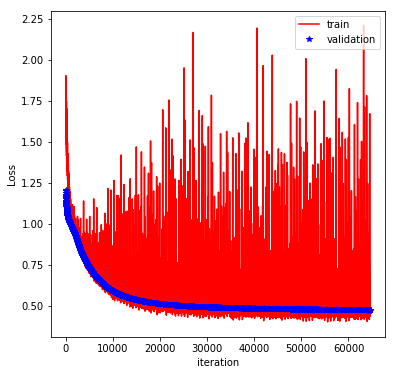

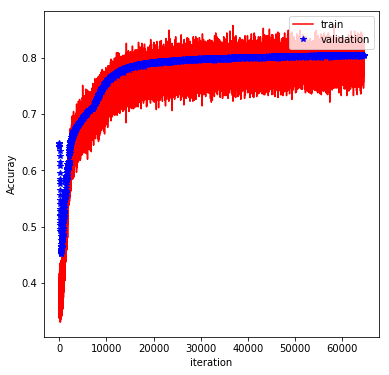

In [5]:
from tensorflow_setup import *
import tensorflow as tf 
import os 
import matplotlib.pyplot as plt
#%matplotlib inline

# filenames used 
traindtfile = 'hdf_1000.h5'
testdtfile = 'hdf_1000.h5'
losssavefig = 'cnn_train_1000_loss.png'
accsavefig = 'cnn_train_1000_accuracy.png'
resultsave = 'cnn_train_1000.h5'
chkpointdir = "cnn-1000/"

X_tr, X_vld, y_tr, y_vld, list_ch_train = get_tf_train_data(traindtfile)


batch_size = 600       # Batch size
seq_len = 12          # Number of steps
learning_rate = 0.0001
epochs = 100

n_classes = 3 # buy sell and nothing
n_channels = 6 # moving averages

graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

with graph.as_default():
    # (batch, 12, 3) --> (batch, 6, 6)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=6, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_1, (-1, 6*6))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    soft = tf.argmax(logits,1)
    pred = tf.nn.softmax(logits,1)
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


if (os.path.exists('bschkpnt-cnn') == False):
    !mkdir bschkpnt-cnn

validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()


with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1


    saver.save(sess,chkpointdir + "bs.ckpt")


t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+losssavefig)

# change filename here


# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('figures/'+accsavefig)

del(X_tr, X_vld, y_tr, y_vld, list_ch_train)

X_test, y_test, lab_ch_test = get_tf_test_data(testdtfile)

test_acc = []
probs = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint(chkpointdir))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
        prob = sess.run(pred, feed_dict=feed)
        probs.append(prob)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))


# now reshape the probs array
probs = np.array(probs)
probs = probs.reshape((probs.shape[0]*probs.shape[1]), probs.shape[2])
y_test = y_test[:len(probs),:]
# model complete

# save the results

import h5py
hf = h5py.File('h5files/' + resultsave, 'w')
hf.create_dataset('predict_valid', data=probs)
hf.create_dataset('y_test', data = y_test)
hf.close()

del(X_test, y_test, lab_ch_test)
